In [1]:
from utils import *
from tqdm.auto import tqdm
from SALib.analyze import pawn
import numpy as np
import pickle
import time
import os
import scipy.interpolate as spi

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
problem = {
    'num_vars': 7,
    'names': ["alpha", "prob_health_decrease", "prob_health_increase", "gamma", "w_delta_scale", "omega", "eta"],
    'bounds': [[0,1], [0,1], [0,1], [0.4,0.8], [0,1]]
}

In [3]:
result_suffix = "5"
result_dir = "results_" + result_suffix

### Sen's Welfare Function

In [231]:
def gini(data):
    if len(data) == 0:
        return 0
    data = np.asarray(data)
    data = np.sort(data)
    n = len(data)
    index = np.arange(1, n + 1)  # 1-based index
    gini = (2 * np.sum(index * data)) / (n * np.sum(data)) - (n + 1) / n
    return gini

def sen_welfare(data):
    return np.mean(data) * (1-gini(data))

In [6]:
result_dir = "results_" + result_suffix
sen_results = []

for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])
    sen_results.append(
        (res["params"], sen_welfare(util[:,-1]))
    )

with open(f"sen_welfare_{result_suffix}.pickle", "wb") as f:
    pickle.dump(sen_results, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [11]:
with open(f"sen_welfare_{result_suffix}.pickle", "rb") as f:
    sen_results = pickle.load(f)

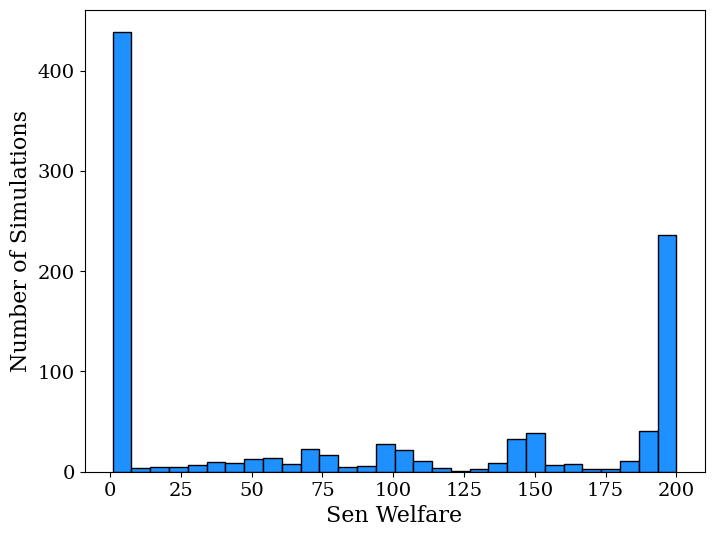

In [12]:
plt.hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Sen Welfare")
plt.ylabel("Number of Simulations")
plt.show()

In [13]:
X = []
Y = []
for t in sen_results:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)


sen_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
print(sen_pawn["mean"])

[0.41692621 0.09956619 0.10389998 0.09580917 0.17478137 0.09580917
 0.08393561]


/Users/charlesdupont/Documents/code/wealth-health/.venv/lib/python3.13/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


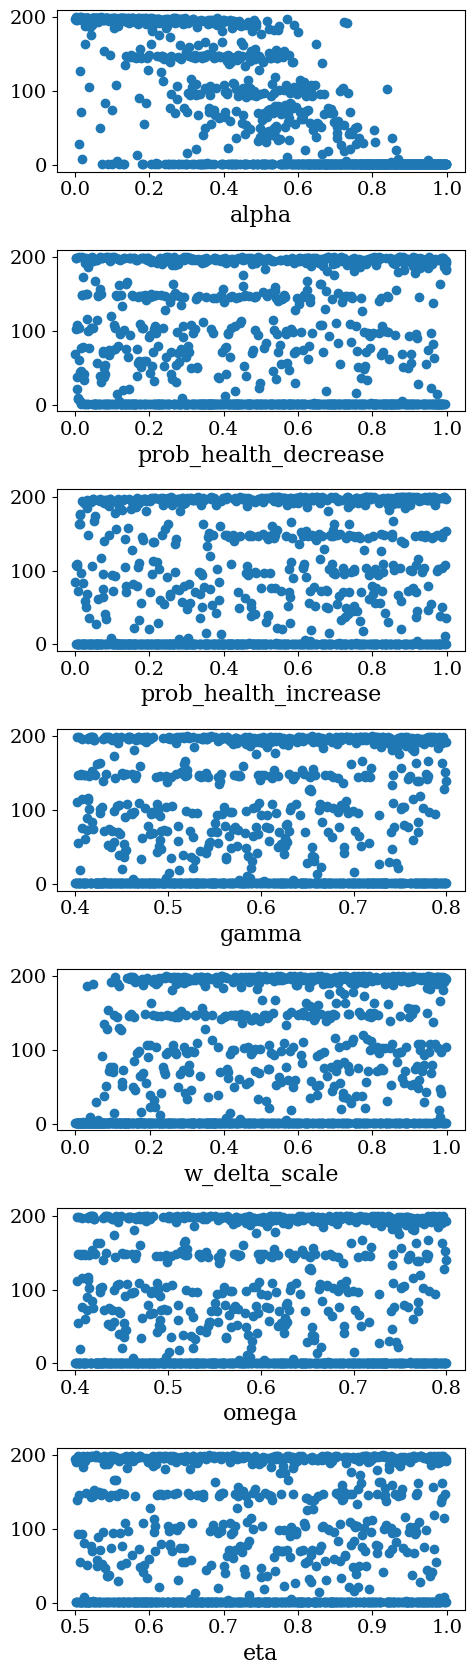

In [10]:
num_vars = problem["num_vars"]
fig, axs = plt.subplots(num_vars, 1, figsize=(5,17))
for idx in range(num_vars):
    axs[idx].scatter(
        X[:,idx],
        Y,
    )
    axs[idx].set_xlabel(problem["names"][idx])
fig.tight_layout()
plt.show()

### MFPT

In [15]:
def random_walk(n_steps, start_pos, step_size, interpolate, alpha, exp_factor=1):
    rand_nums = np.random.uniform(0, 1, size=(n_steps,))
    rand_angle = np.random.uniform(0, 2 * np.pi, size=(n_steps,))

    X = np.zeros((n_steps+1,))
    X[0] = start_pos[0]
    Y = np.zeros((n_steps+1,))
    Y[0] = start_pos[1]
    util = np.zeros((n_steps+1,))
    util[0] = utility(X[0], Y[0], alpha)
    current_potential = interpolate(X[0], Y[0])

    for step in range(n_steps):
        dx = np.cos(rand_angle[step]) * step_size
        dy = np.sin(rand_angle[step]) * step_size

        new_x = max(1, min(X[step] + dx, 200))
        new_y = max(1, min(Y[step] + dy, 200))        
        new_potential = interpolate(new_x, new_y, grid=False)

        # check whether to accept or reject moves
        accept = False
        if (new_potential < current_potential) or rand_nums[step] < exp_factor * np.exp(current_potential - new_potential):
            accept = True        
            current_potential = new_potential
            X[step+1] = new_x
            Y[step+1] = new_y
        else:
            X[step+1] = X[step]
            Y[step+1] = Y[step]
        
        util[step+1] = utility(X[step+1], Y[step+1], alpha)

    return util, X, Y

In [12]:
result_dir = "results_" + result_suffix

interpolation_functions = []
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    interp_func = get_interpolation_function(
        res["wealth"][:,-1],
        res["health"][:,-1]
    )
    interpolation_functions.append(
        (res["params"], interp_func)
    )

with open(f"interpolation_functions_{result_suffix}.pickle", "wb") as f:
    pickle.dump(interpolation_functions, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [4]:
with open(f"interpolation_functions_{result_suffix}.pickle", "rb") as f:
    interpolation_functions = pickle.load(f)

In [14]:
MINIMA = []
for param_set, func in tqdm(interpolation_functions):
    MINIMA.append(
        (param_set, get_minima(func, count_threshold=2, num_points=15, N=param_set["N"], step_size=10))
    )

with open(f"minima_{result_suffix}.pickle", "wb") as f:
    pickle.dump(MINIMA, f)

  0%|          | 0/1024 [00:00<?, ?it/s]

In [5]:
with open(f"minima_{result_suffix}.pickle", "rb") as f:
    MINIMA = pickle.load(f)

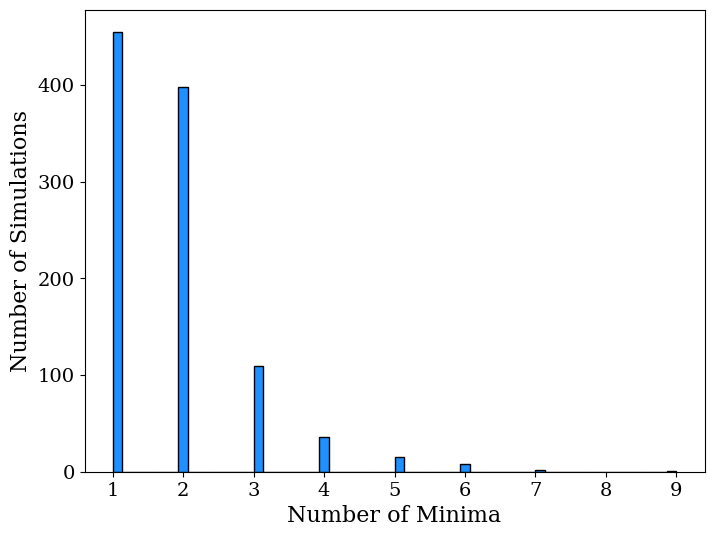

In [220]:
histo = plt.hist(
    [len(m[1]) for m in MINIMA],
    bins=60,
    color="dodgerblue",
    edgecolor="k"
)
plt.xlabel("Number of Minima")
plt.ylabel("Number of Simulations")
plt.show()

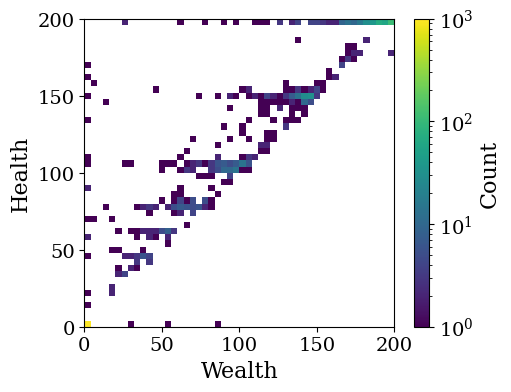

In [22]:
minima_locations = []
for m in MINIMA:
    for point in m[1]:
        minima_locations.append(point[0])

plt.figure(figsize=(5,4))
hist = plt.hist2d(
    [x[0] for x in minima_locations],
    [x[1] for x in minima_locations],
    bins=50,
    norm="log"
)
cbar = plt.colorbar(hist[3], label="Count")
cbar.set_ticks([1, 10, 100, 1000])

plt.xlabel("Wealth")
plt.ylabel("Health")
plt.savefig("minima_locations.pdf", bbox_inches="tight")
plt.show()

In [16]:
all_utils = []
for simulation_idx, item in tqdm(enumerate(MINIMA)):
    params, minima_list = item
    util_diffs = []
    for i in range(len(minima_list)):
        if minima_list[i][1] <= 2:
            continue
        w_i, h_i = minima_list[i][0]
        util, x, y = random_walk(100, (w_i,h_i), 1, interpolation_functions[simulation_idx][1], params["alpha"], exp_factor=0.5)
        util_diffs.append(util.max() - util[0])
    all_utils.append(
        (
            params,
            np.mean(util_diffs)
        )
    )

0it [00:00, ?it/s]

In [17]:
X = []
Y = []
for t in all_utils:
    X.append((t[0]["alpha"], t[0]["P_H_decrease"], t[0]["P_H_increase"], t[0]["gamma"], t[0]["w_delta_scale"], t[0]["gamma"], t[0]["eta"]))
    Y.append(t[1])
X = np.array(X)
Y = np.array(Y)

util_improvement_pawn = pawn.analyze(problem, X, Y, S=10, print_to_console=False)
util_improvement_pawn["mean"]

array([0.30199163, 0.07793372, 0.11412874, 0.08535625, 0.12289791,
       0.08535625, 0.07617574])

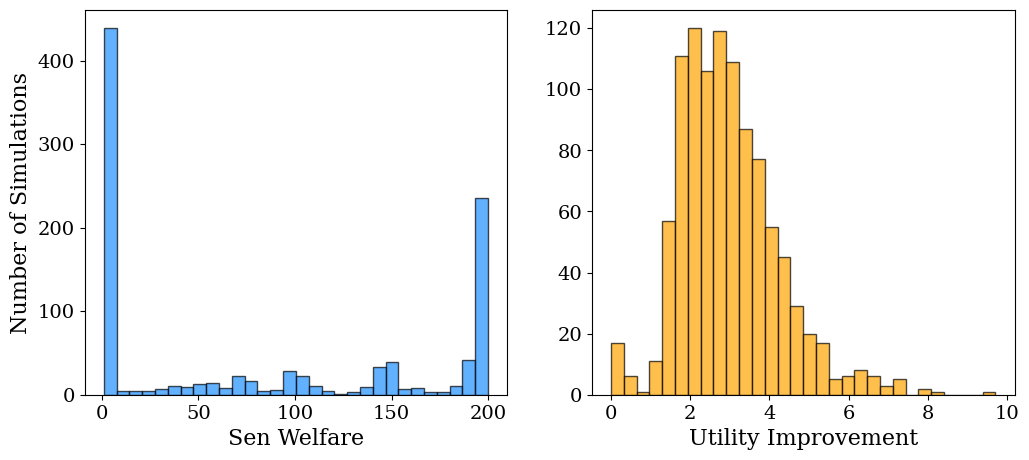

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].hist(
    [t[1] for t in sen_results],
    bins=30,
    color="dodgerblue",
    edgecolor="k",
    alpha=0.7
)
axs[0].set_xlabel("Sen Welfare")
axs[0].set_ylabel("Number of Simulations")

axs[1].hist(
    [x[1] for x in all_utils],
    color="orange",
    edgecolor="k",
    bins=30,
    alpha=0.7
)
axs[1].set_xlabel("Utility Improvement")

plt.savefig("gsa_distributions.pdf", bbox_inches="tight")

plt.show()

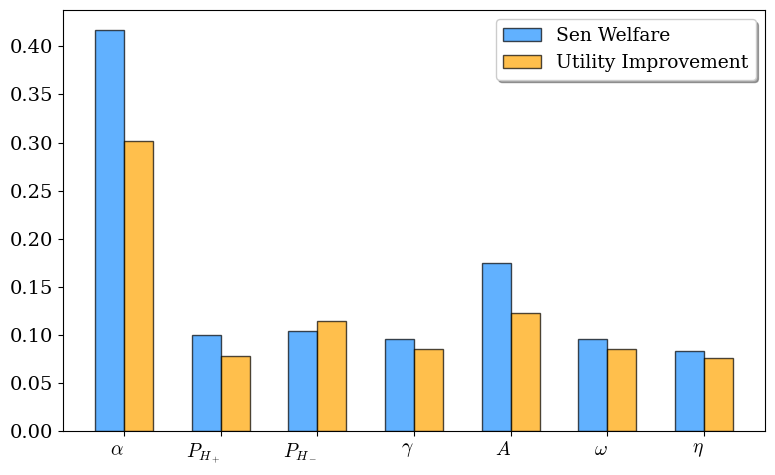

In [19]:
# Categories on x-axis
categories = [r'$\alpha$', r'$P_{H_+}$', r'$P_{H_-}$', r'$\gamma$', r'$A$', r'$\omega$', r'$\eta$']

# Data for the bars
sen_values = sen_pawn["mean"]
util_values = util_improvement_pawn["mean"]

# X locations for the groups
x = np.arange(len(categories))

# Width of bars
width = 0.3  

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, sen_values, width, label='Sen Welfare', color='dodgerblue', alpha=0.7, edgecolor="k")
ax.bar(x + width/2, util_values, width, label='Utility Improvement', color='orange', alpha=0.7, edgecolor="k")

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(categories, ha="right")
ax.legend(shadow=True)

# Show plot
plt.tight_layout()
plt.savefig("pawn_sensitivity_indices.pdf", bbox_inches="tight")
plt.show()

### Minima Zoo

3


/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/4072095575.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)


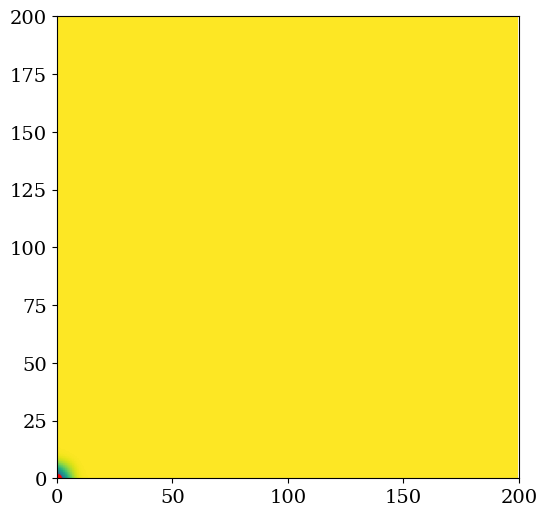

4


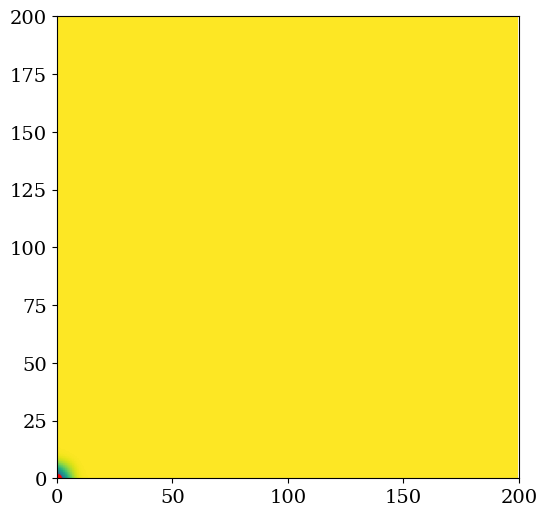

5


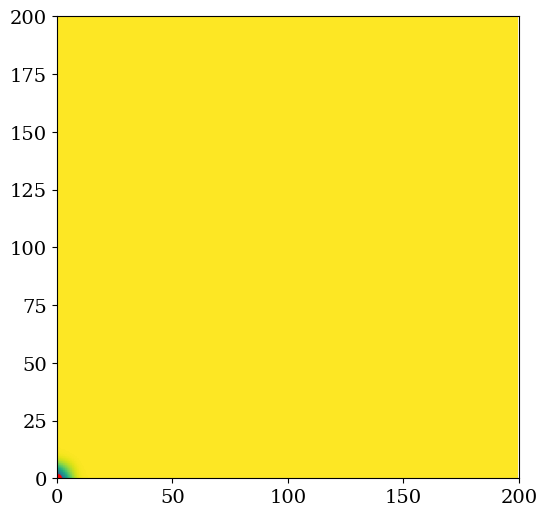

7


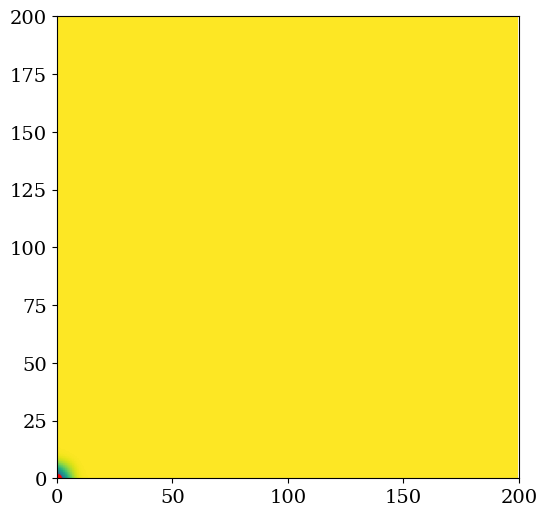

8


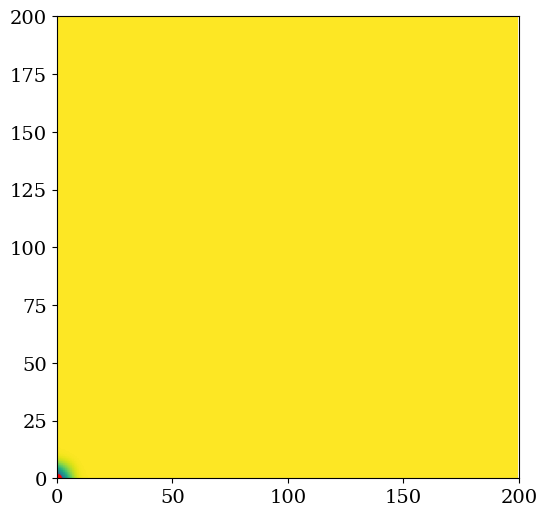

10


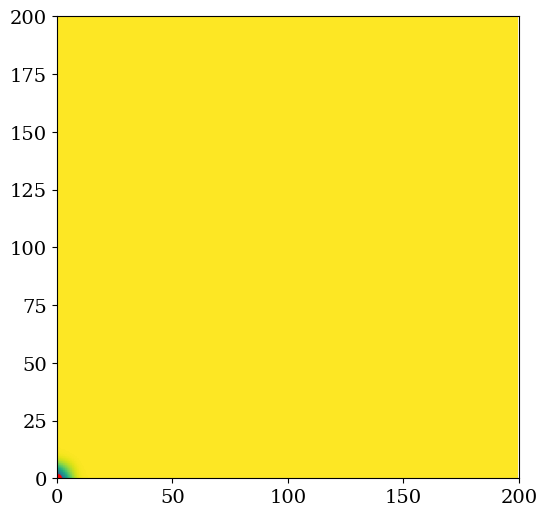

12


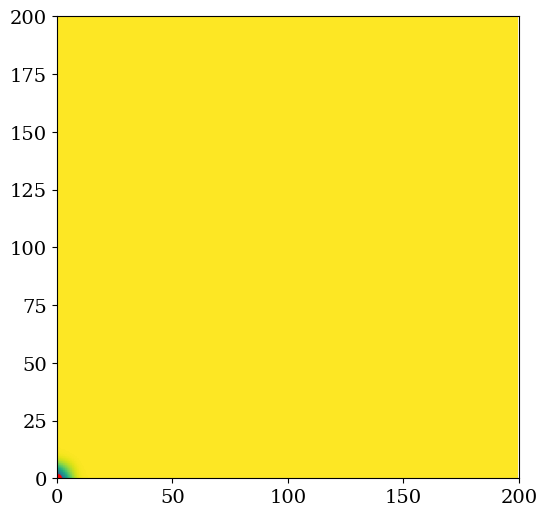

13


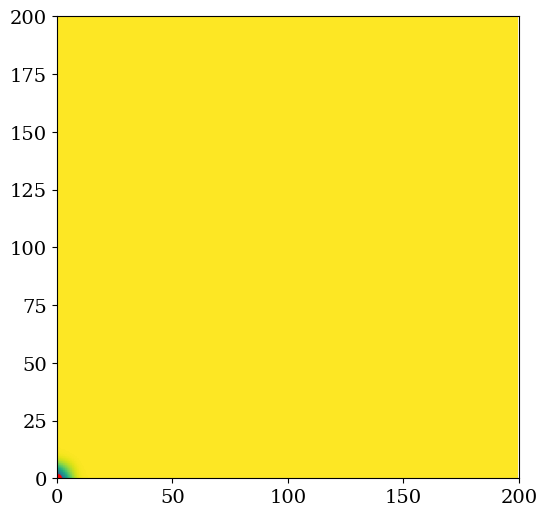

20


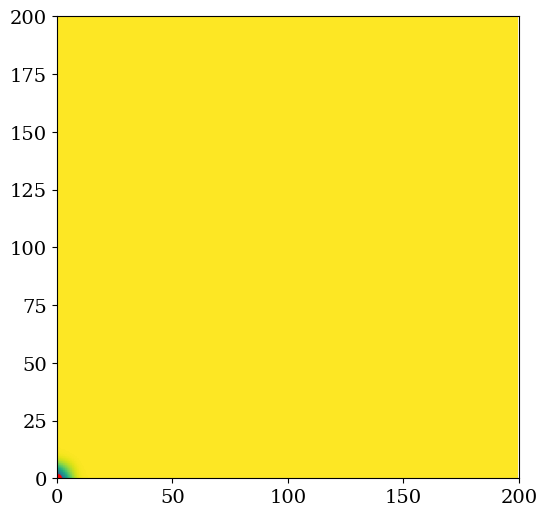

21


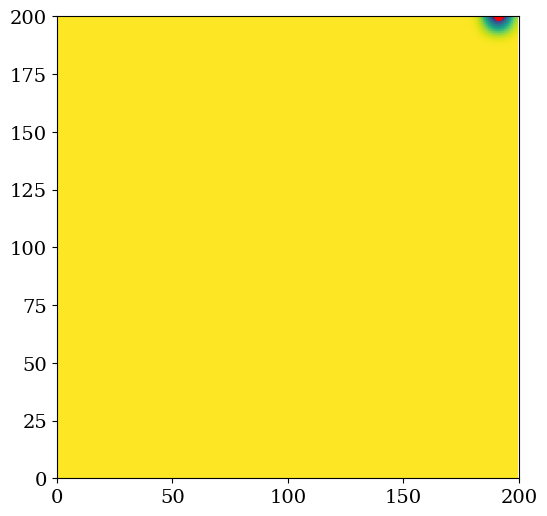

23


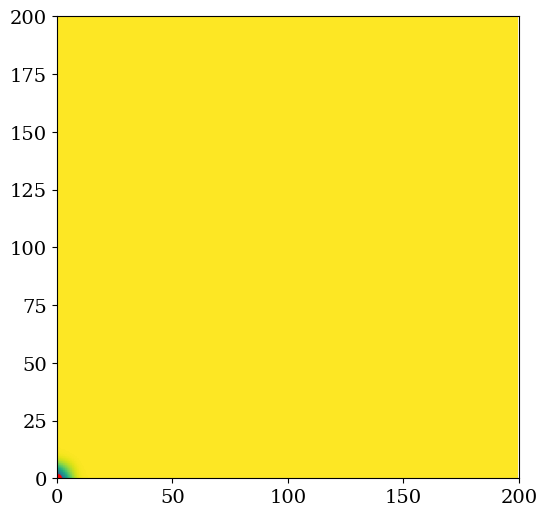

24


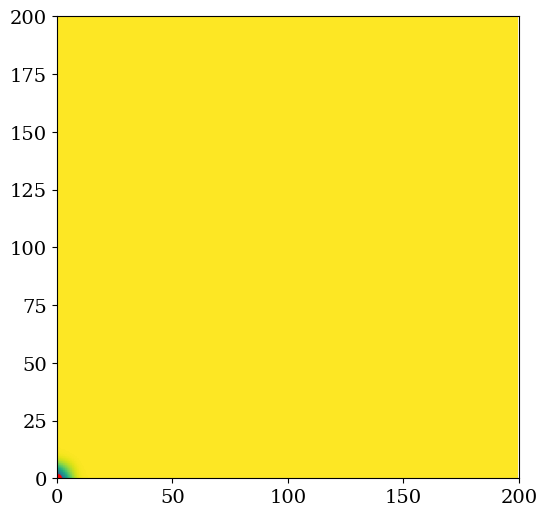

26


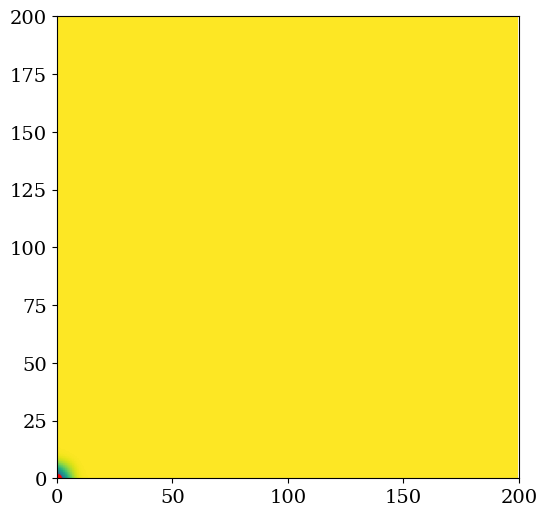

28


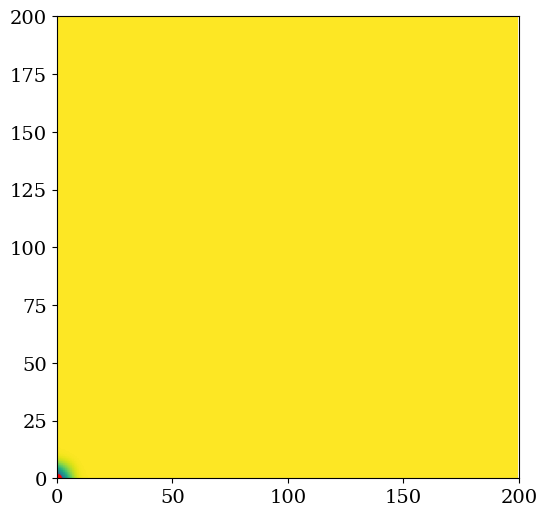

30


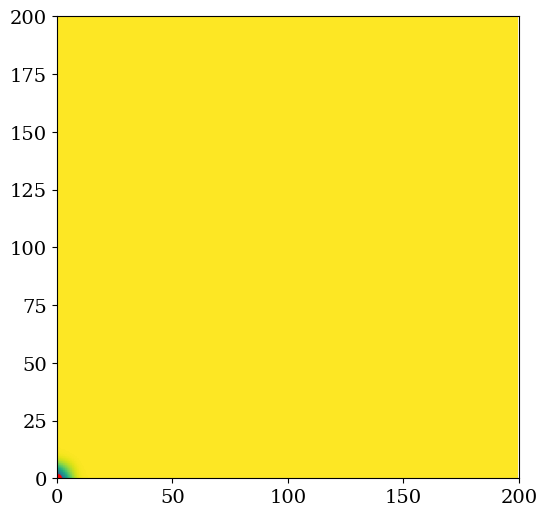

32


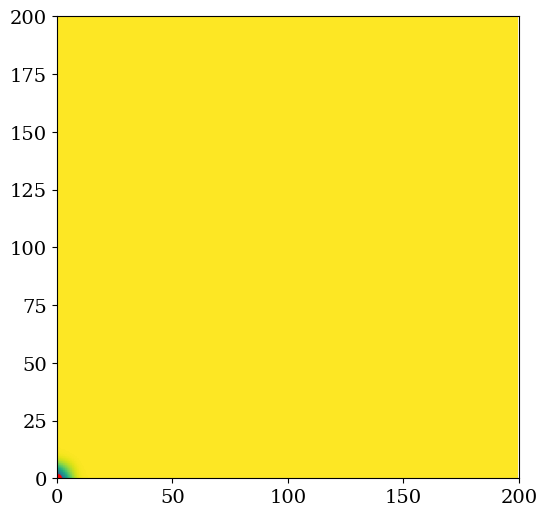

34


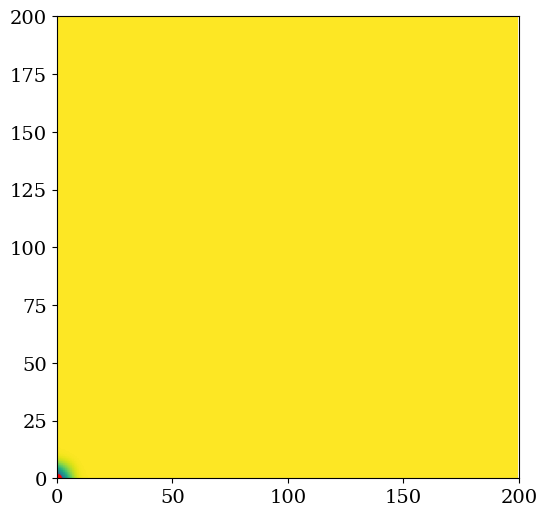

35


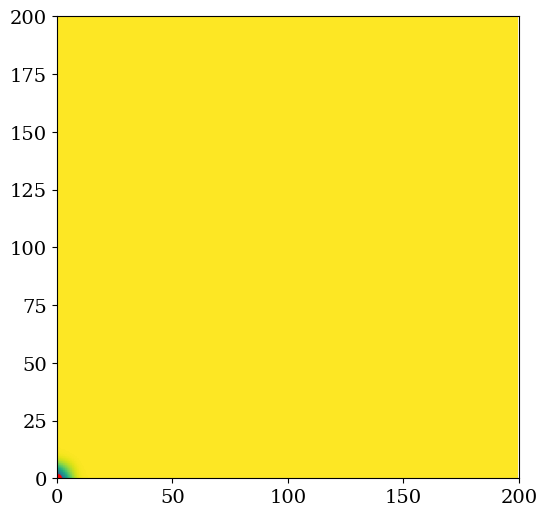

36


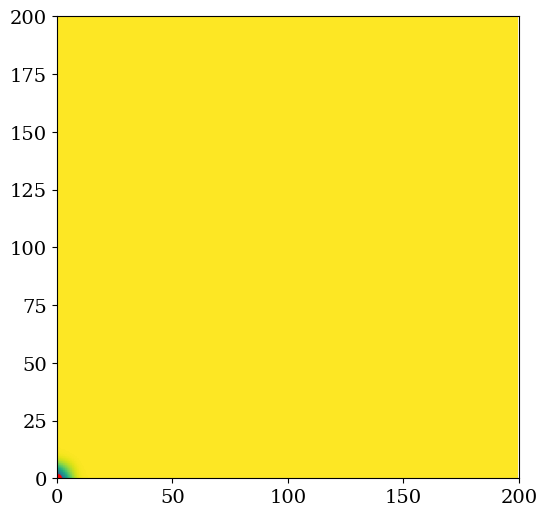

39


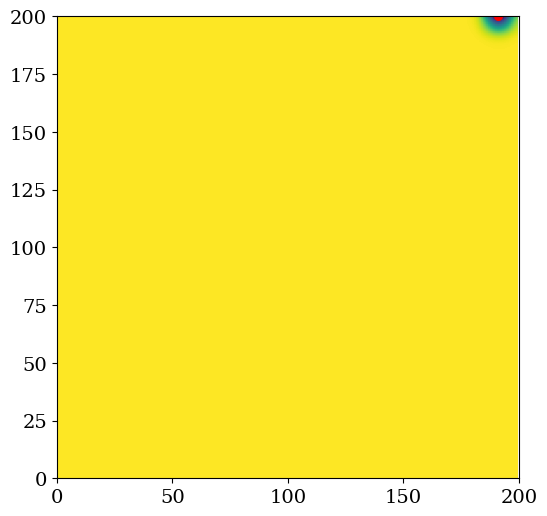

42


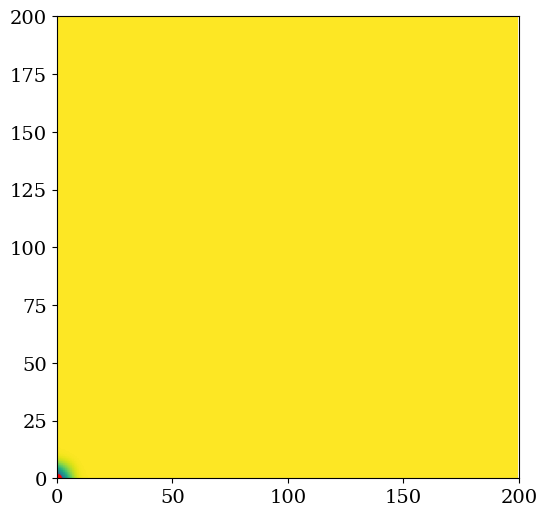

44


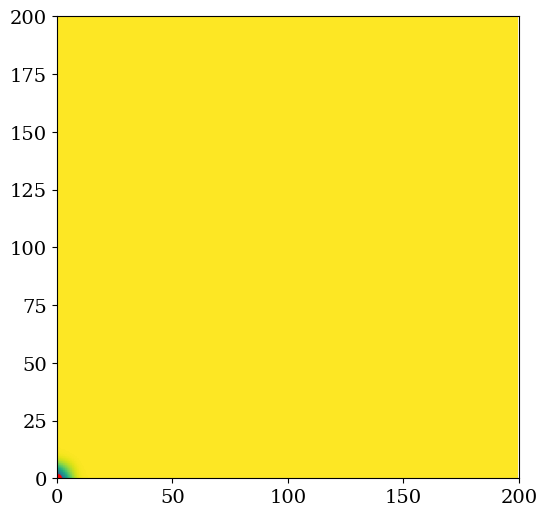

45


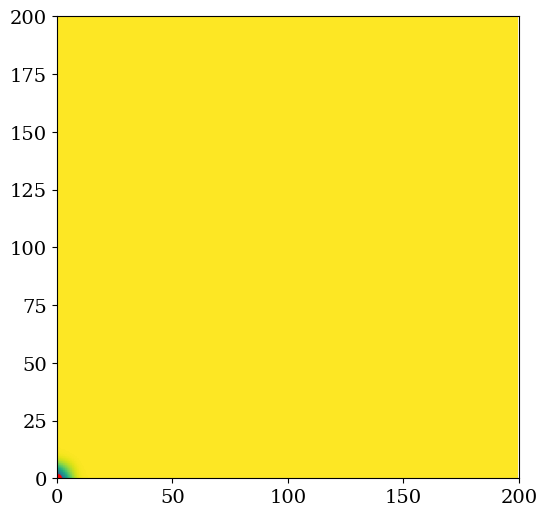

46


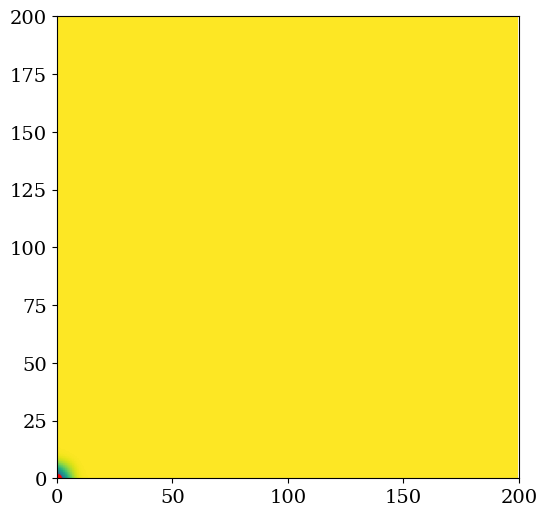

51


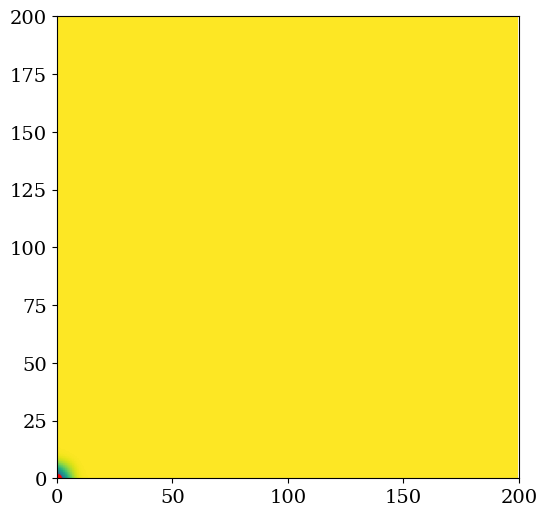

52


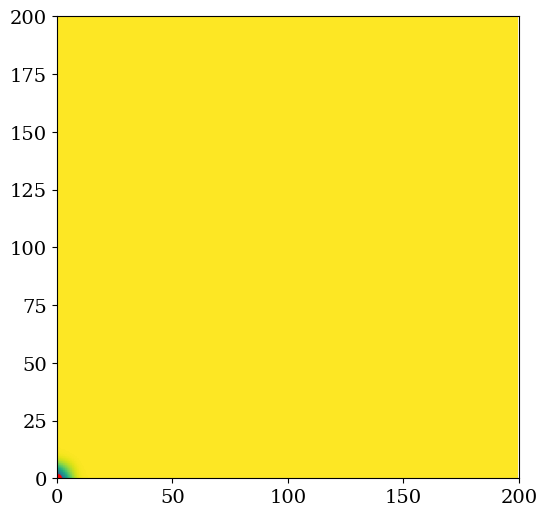

56


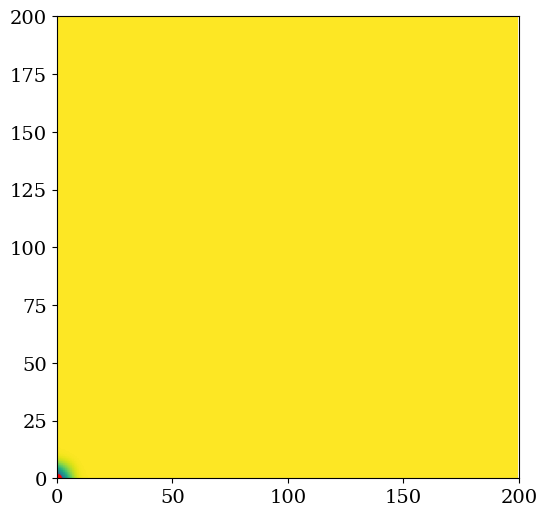

57


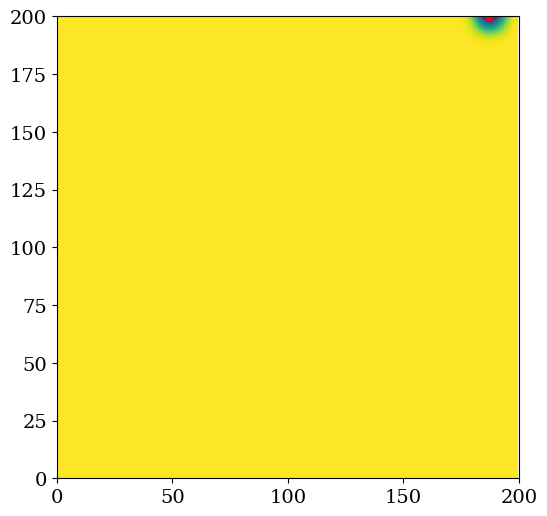

59


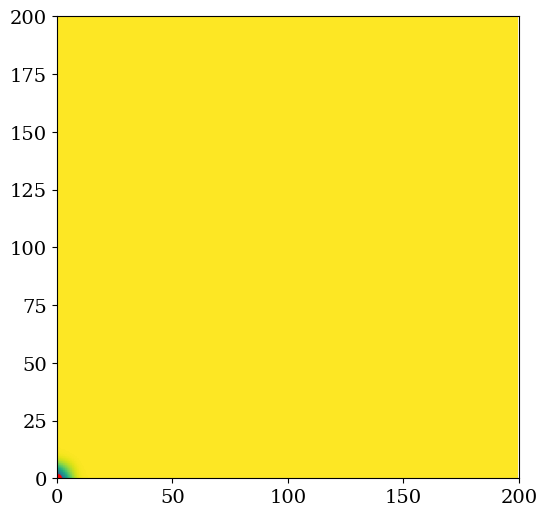

61


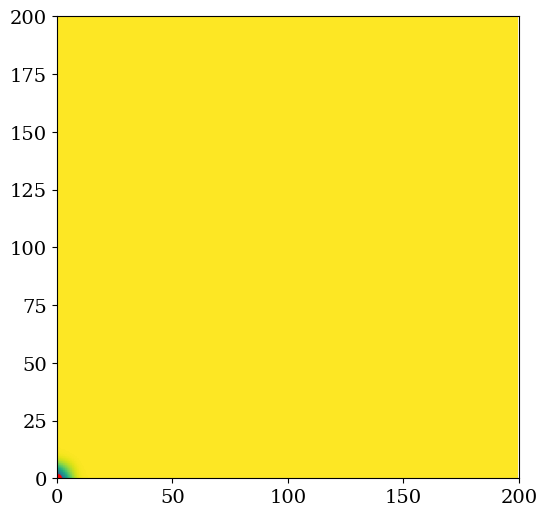

67


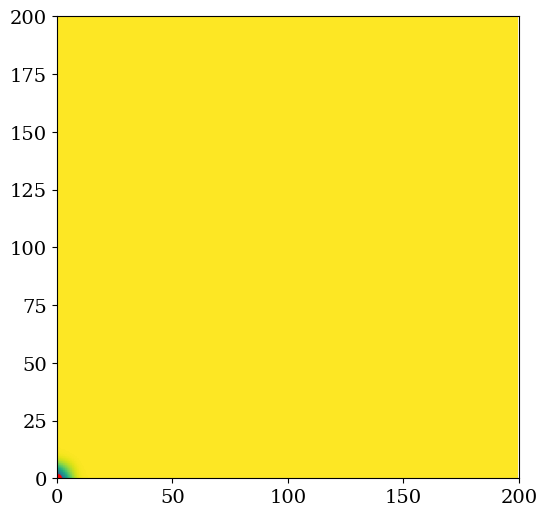

68


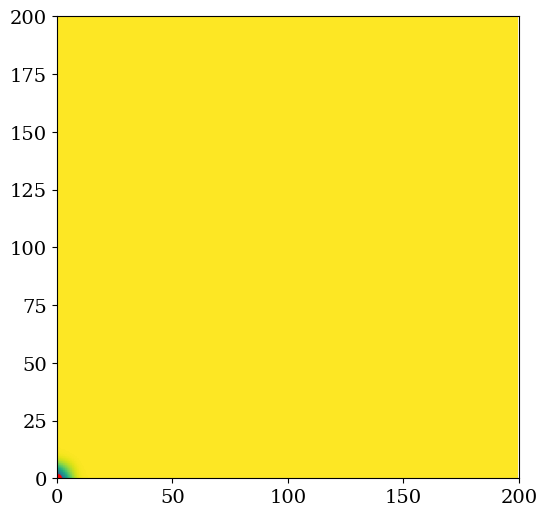

71


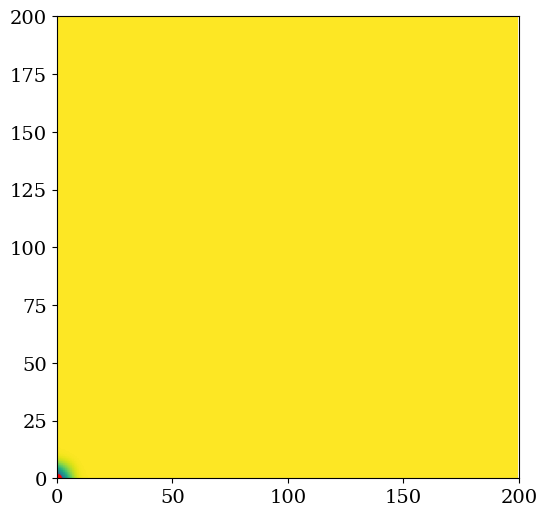

73


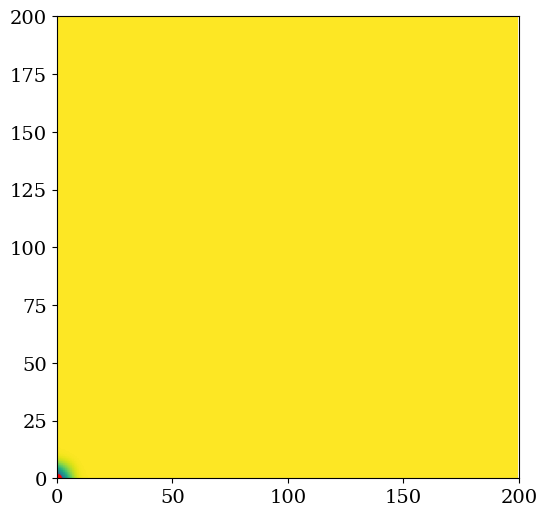

74


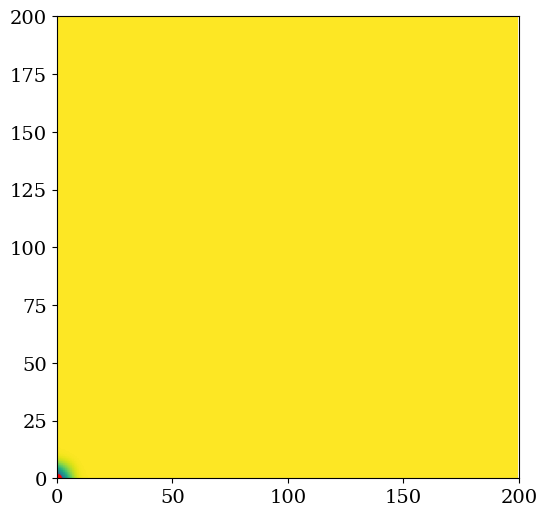

78


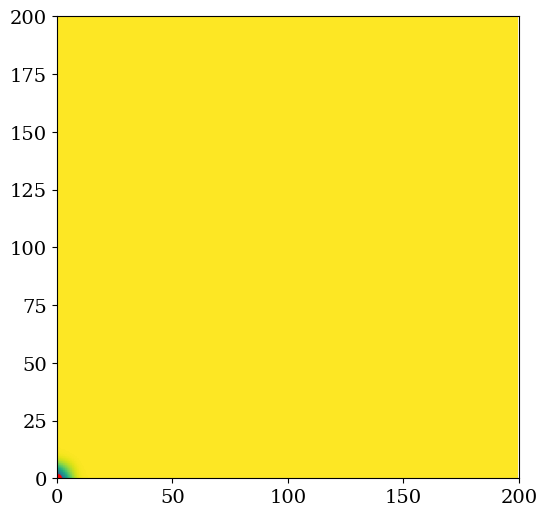

80


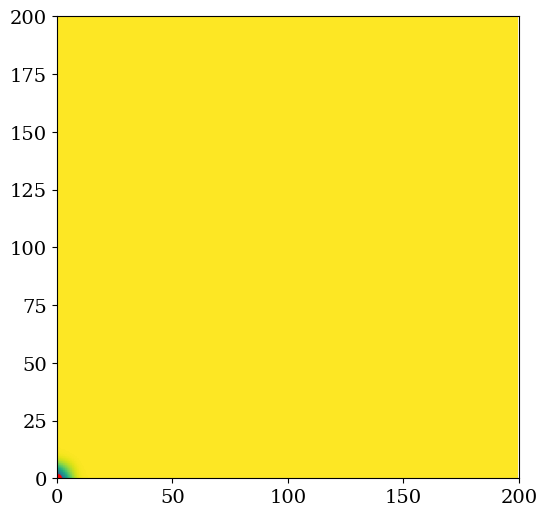

81


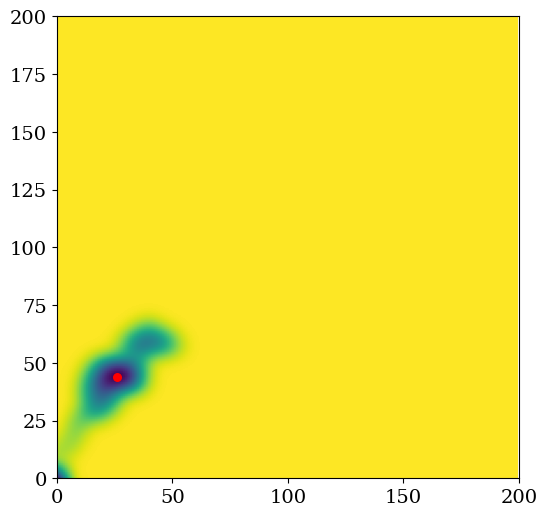

85


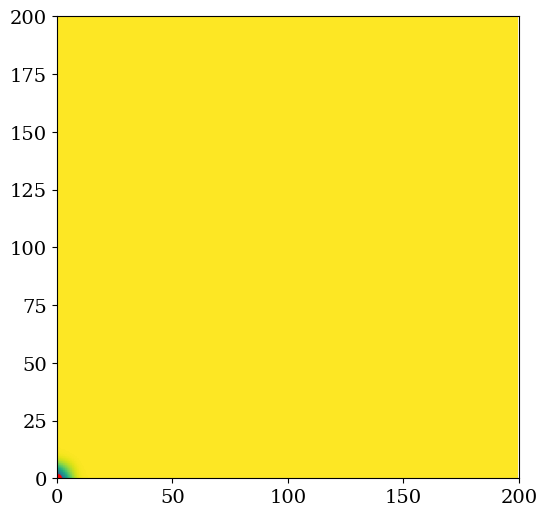

88


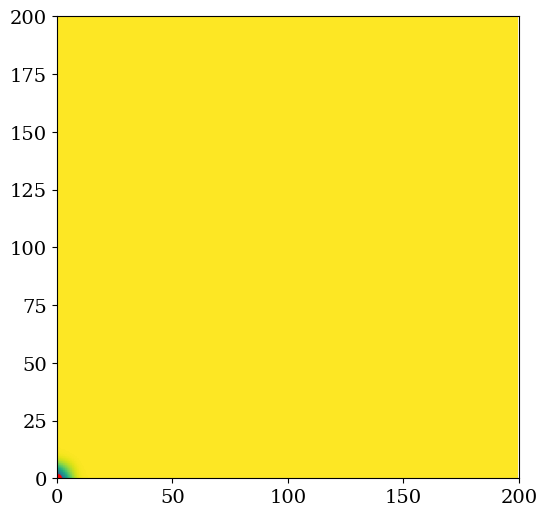

89


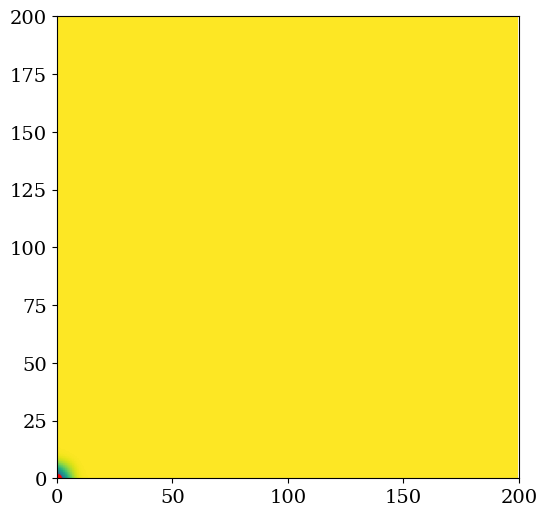

90


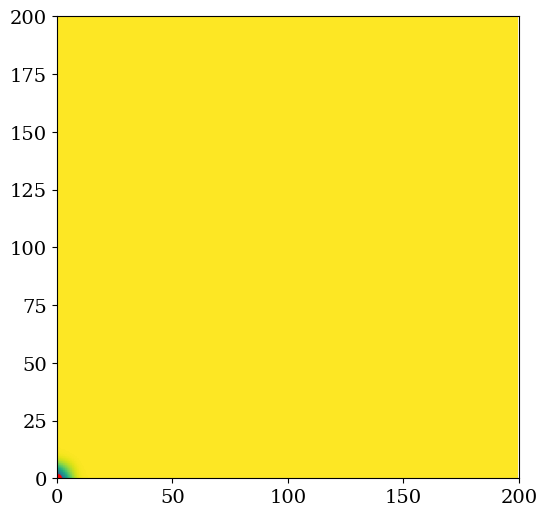

91


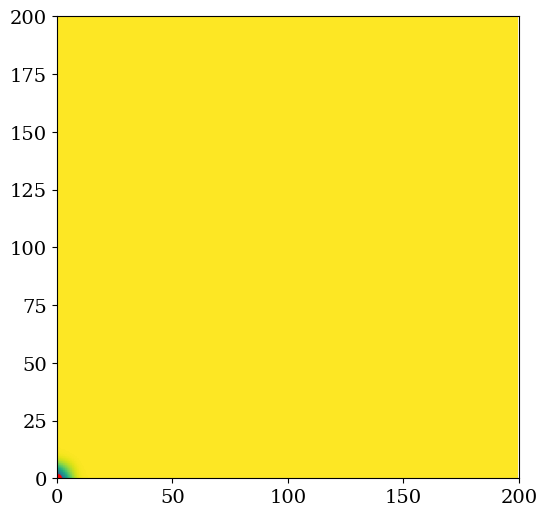

92


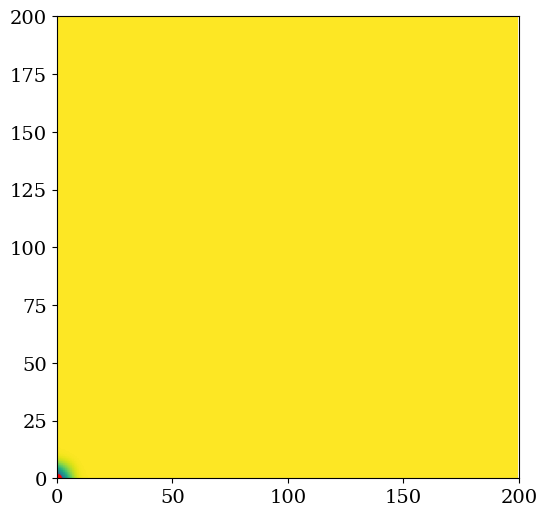

94


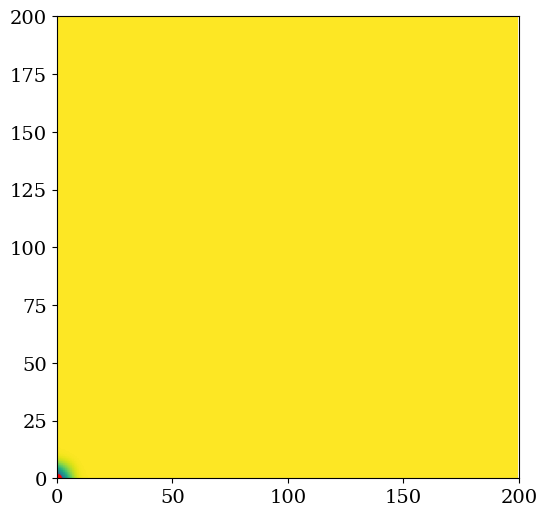

95


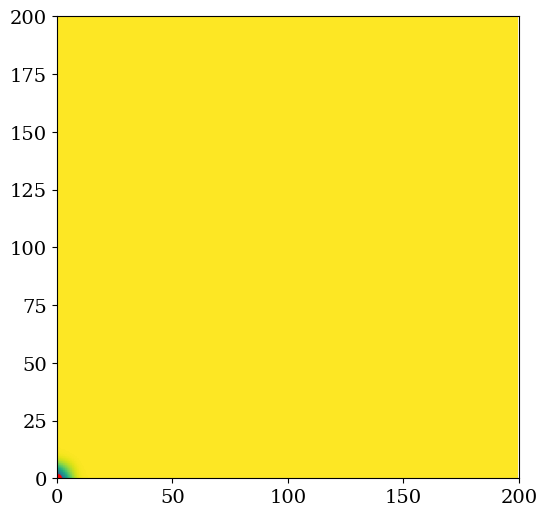

96


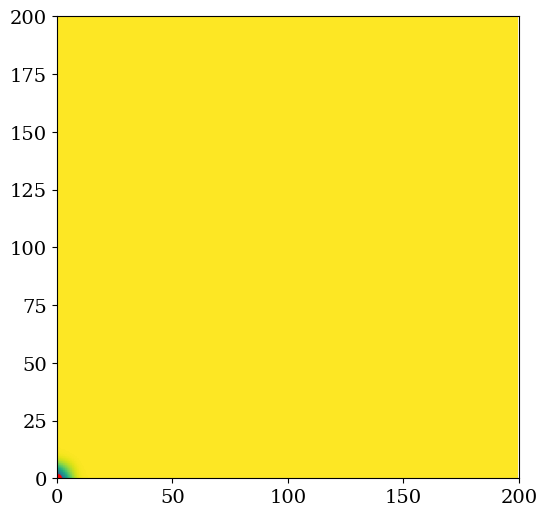

97


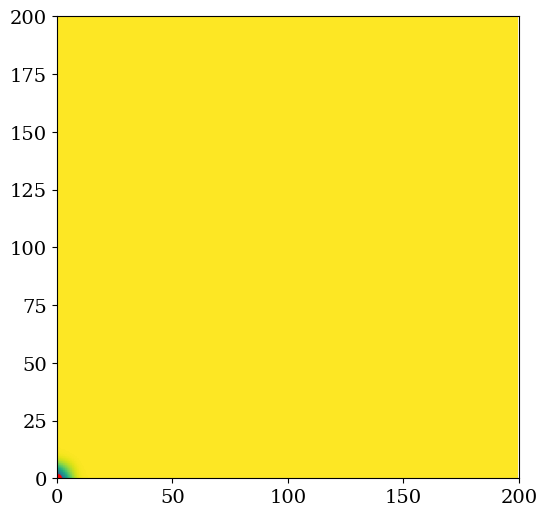

105


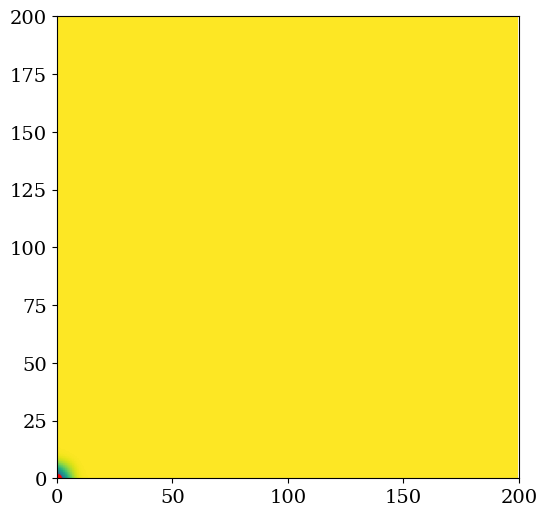

106


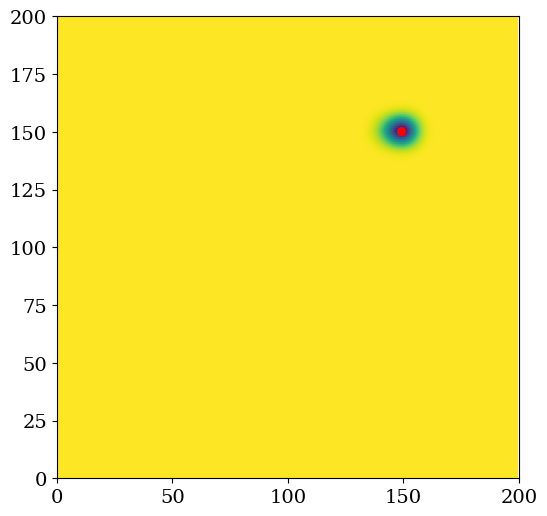

107


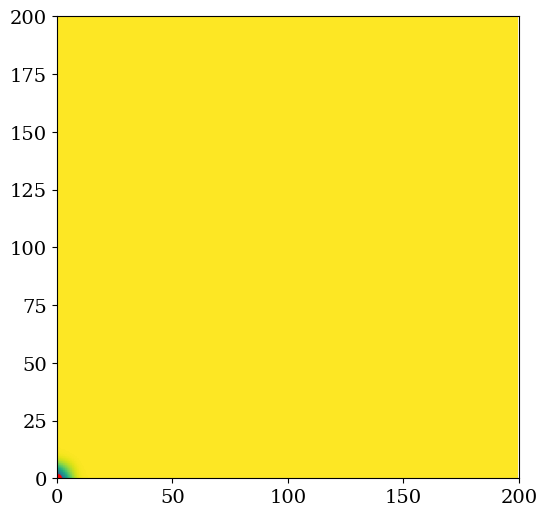

109


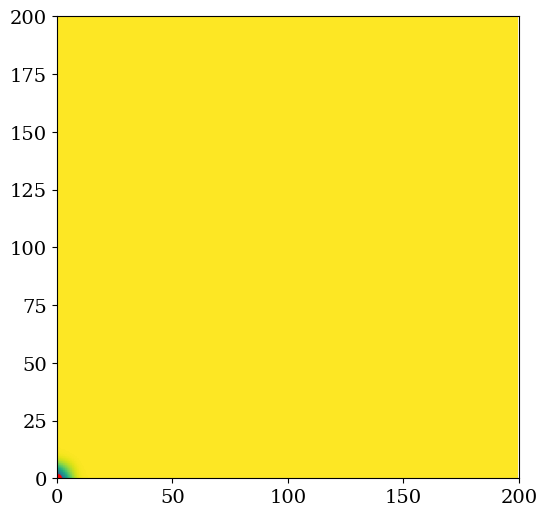

110


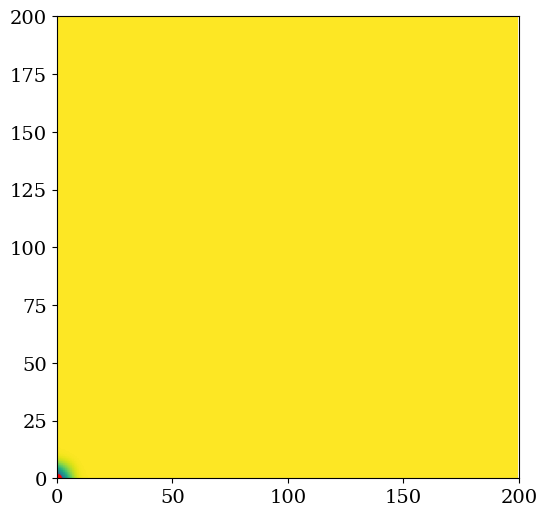

111


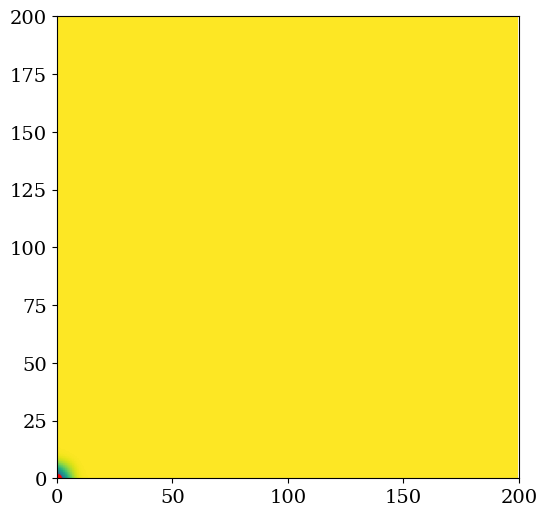

113


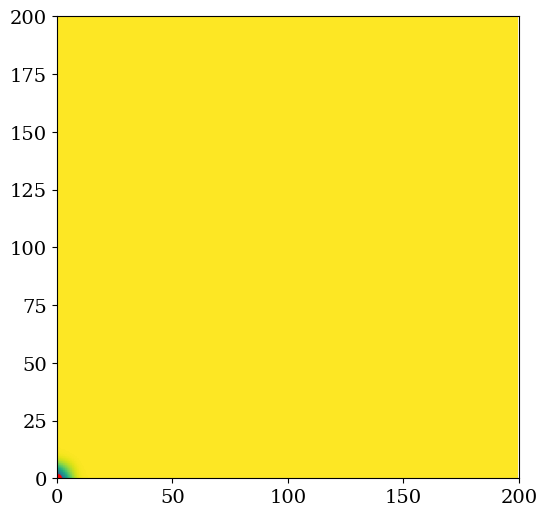

116


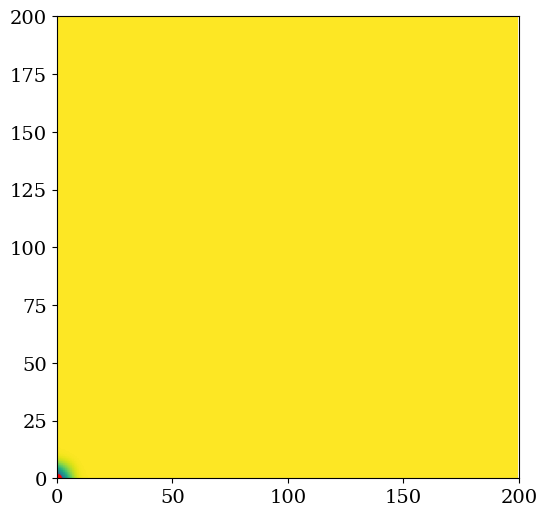

117


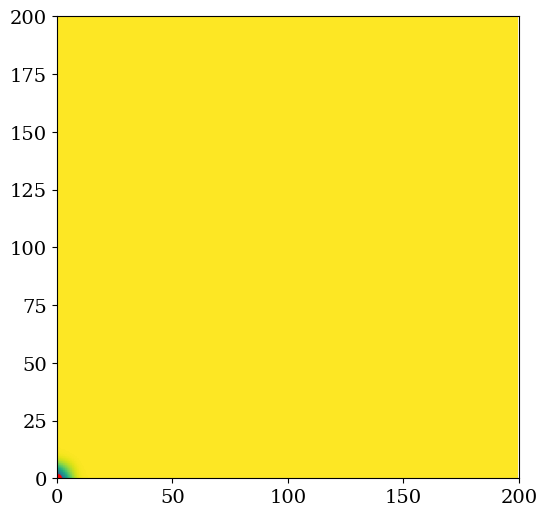

121


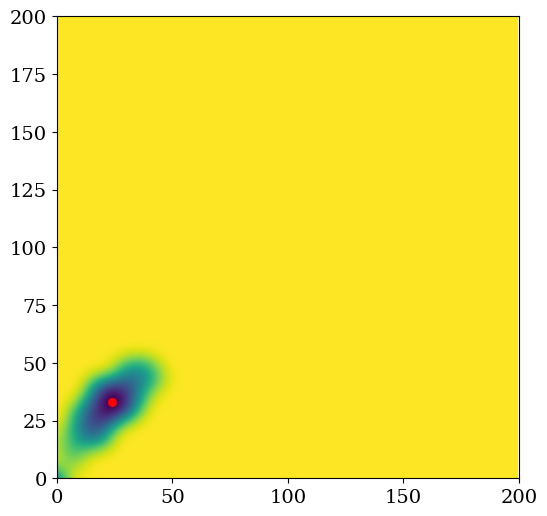

122


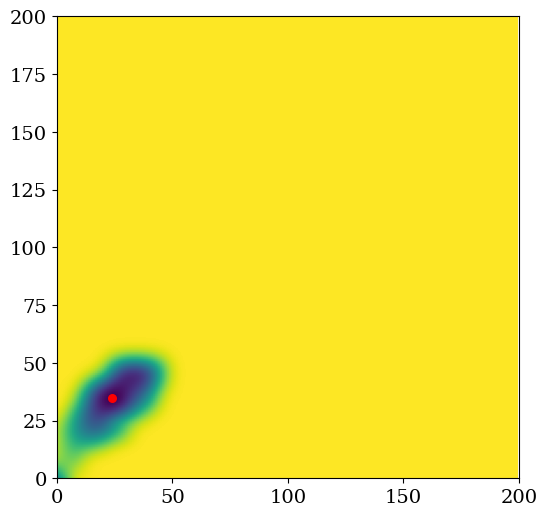

123


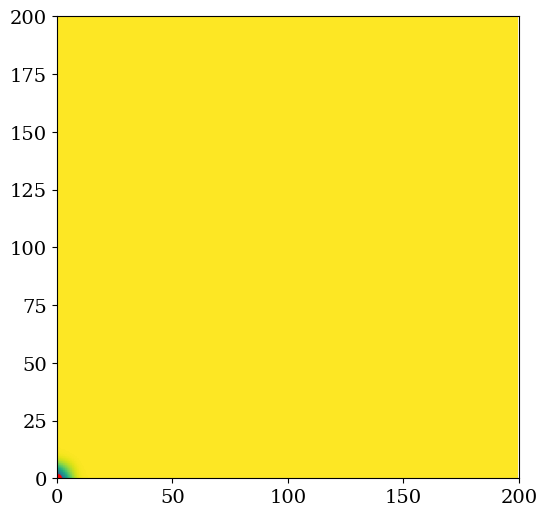

126


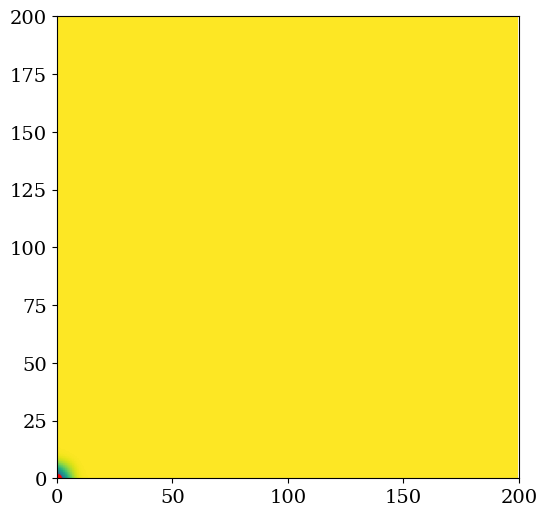

128


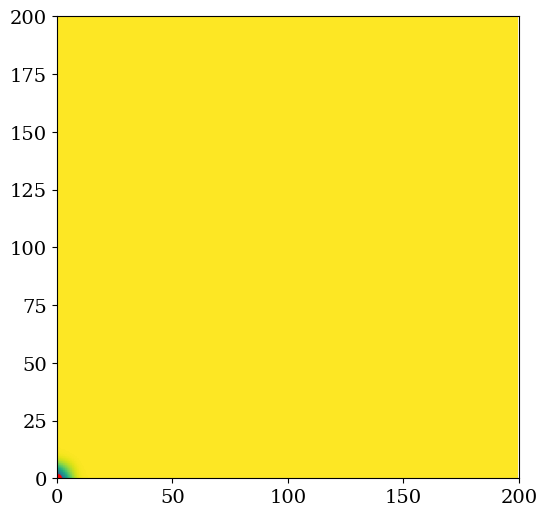

129


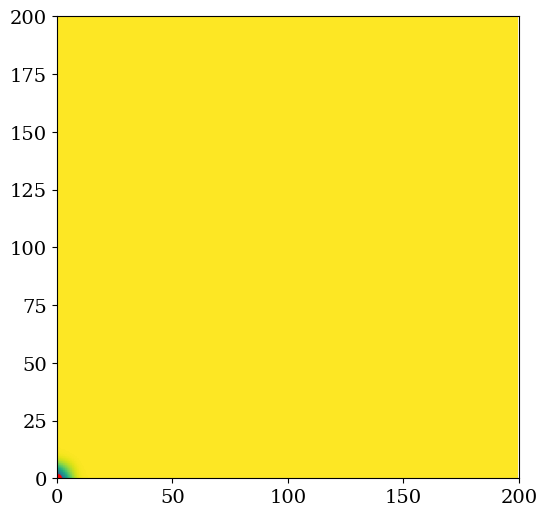

137


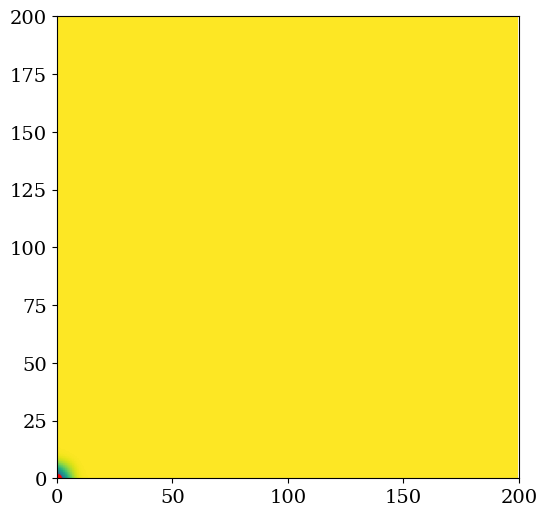

140


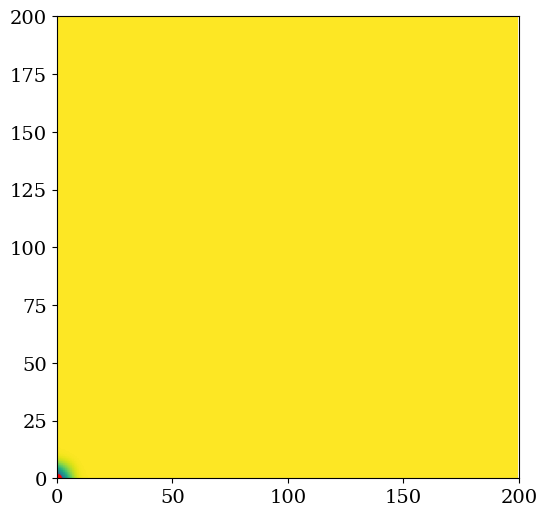

144


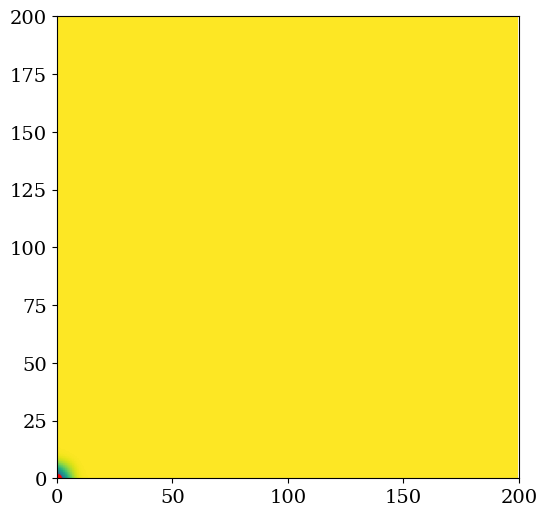

145


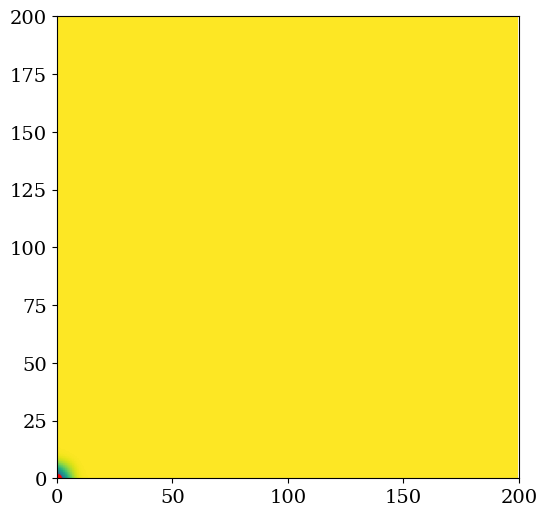

147


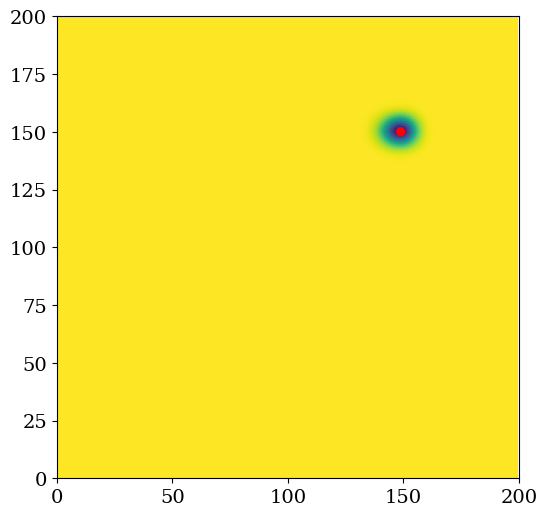

148


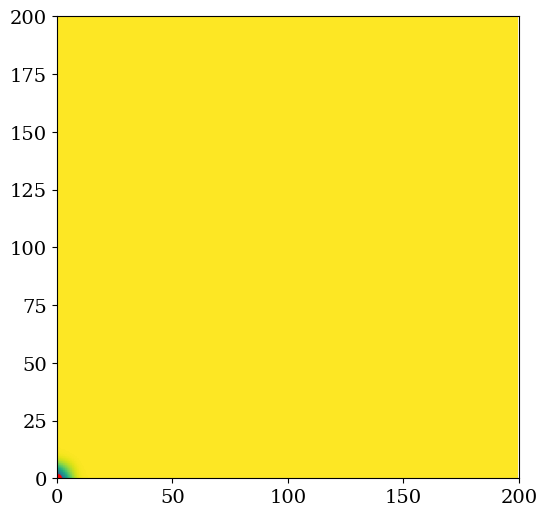

151


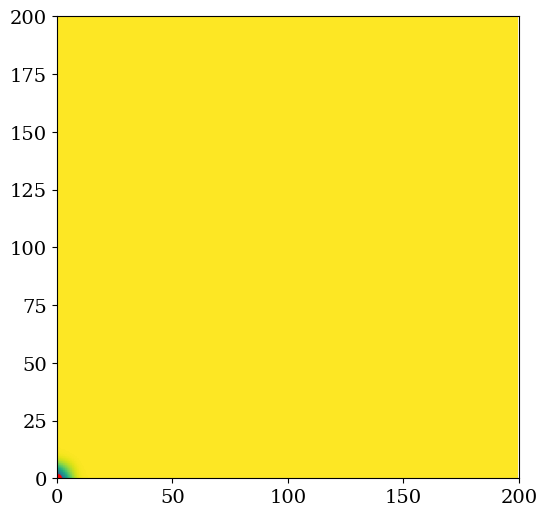

153


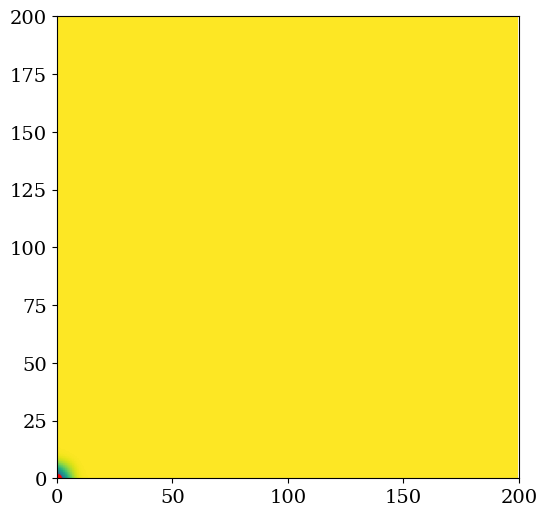

154


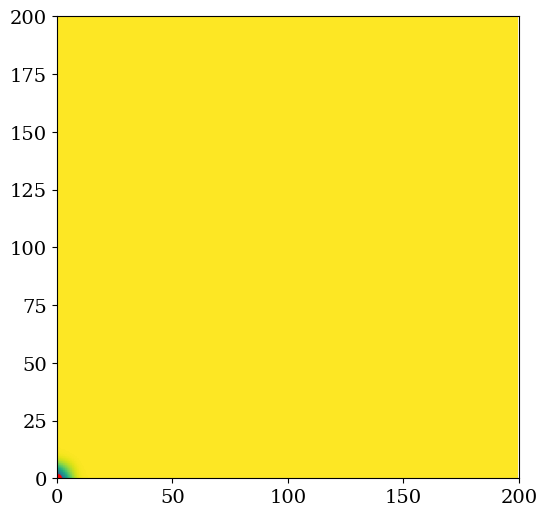

155


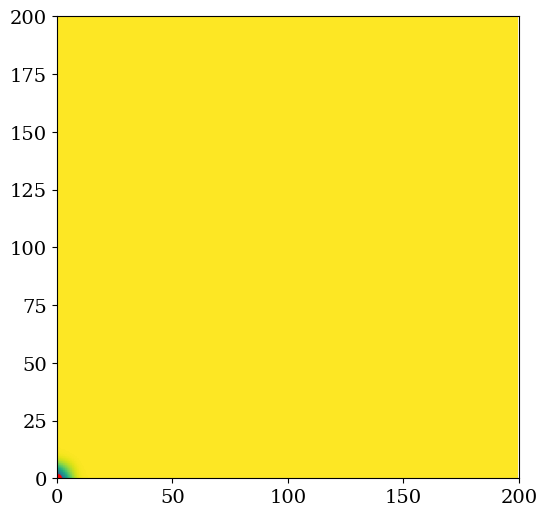

157


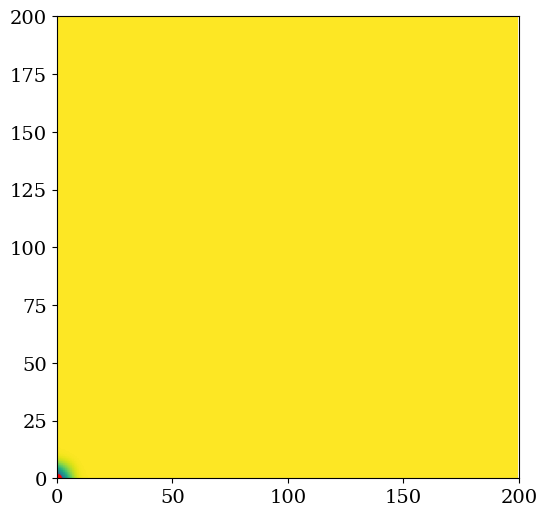

159


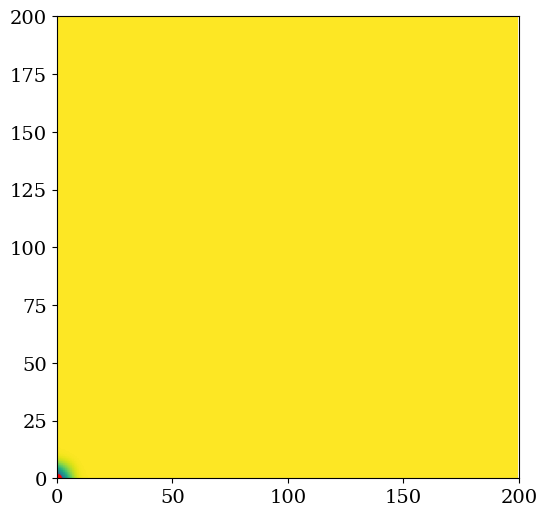

161


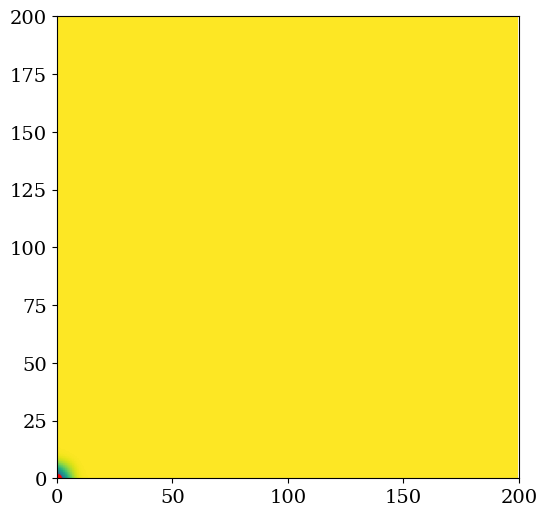

169


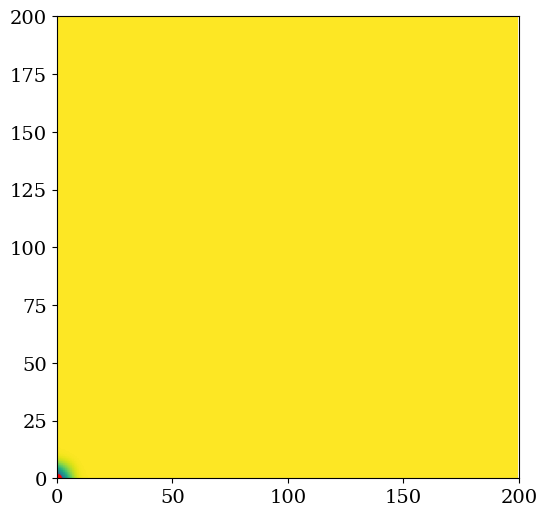

170


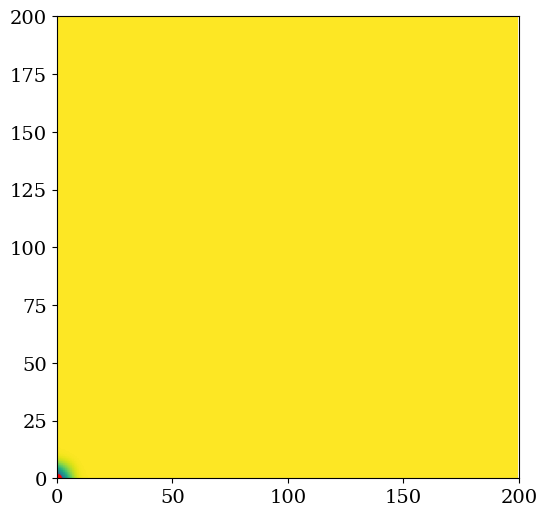

171


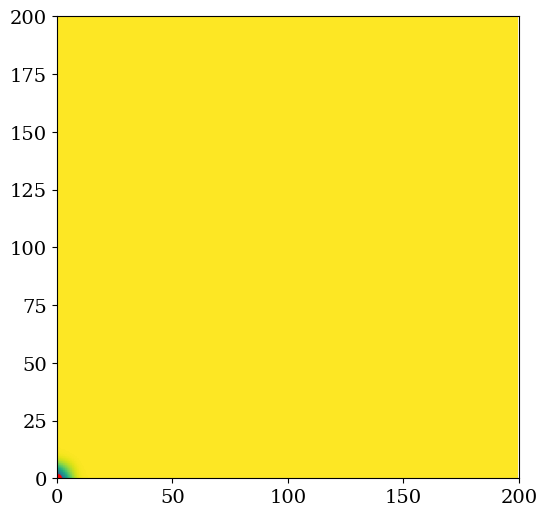

172


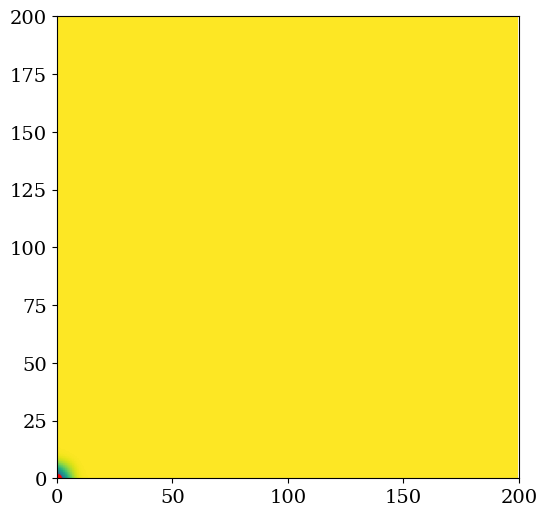

176


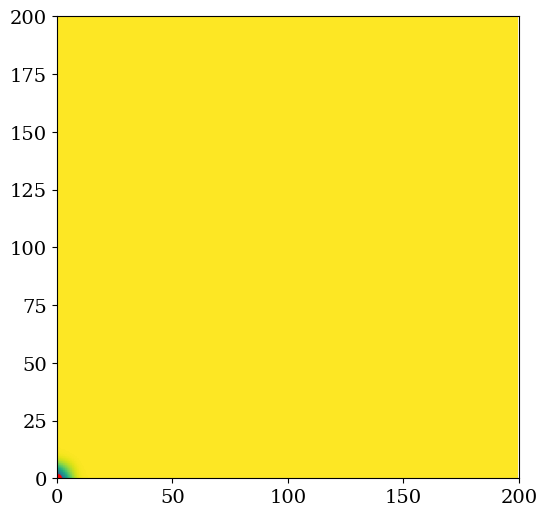

177


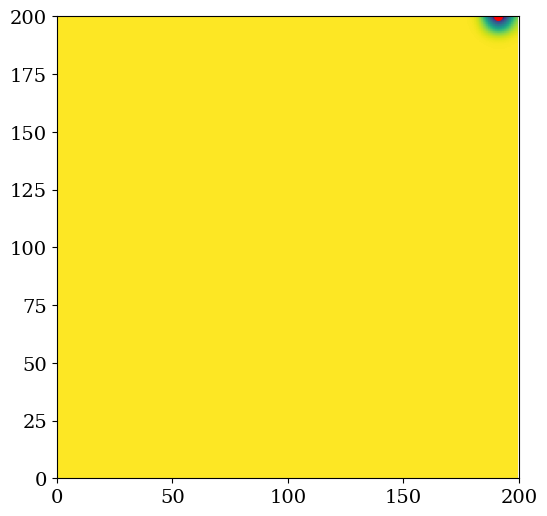

183


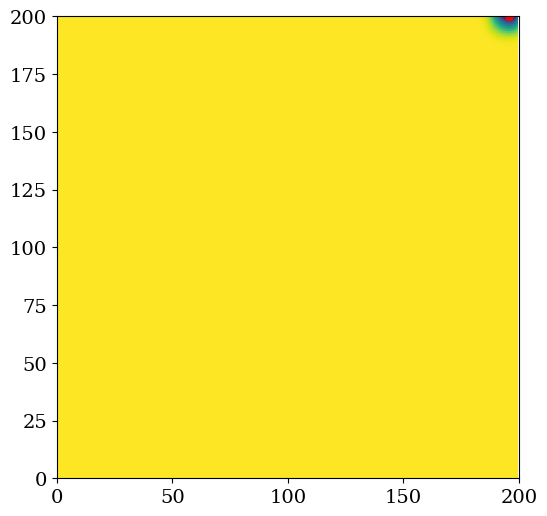

184


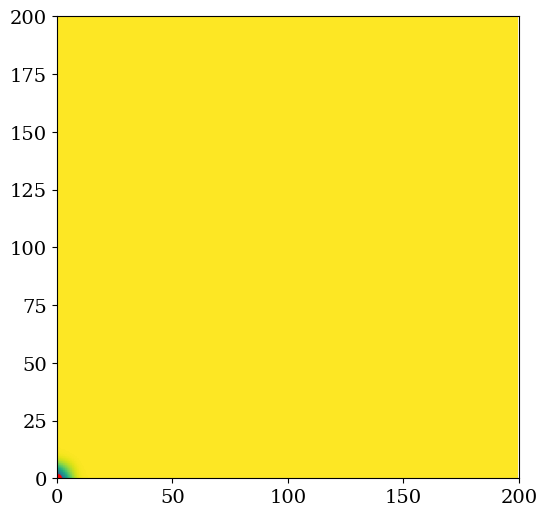

185


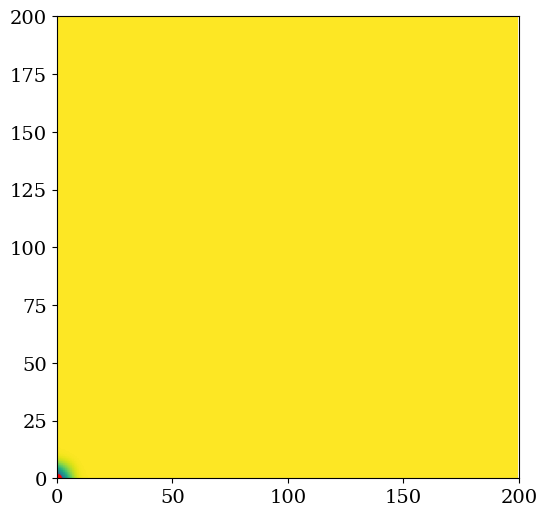

186


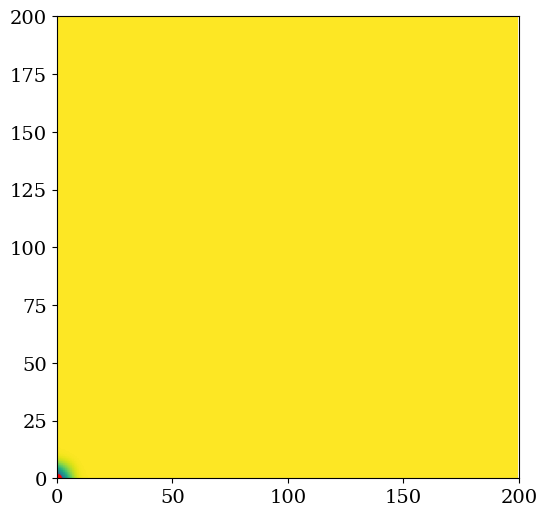

187


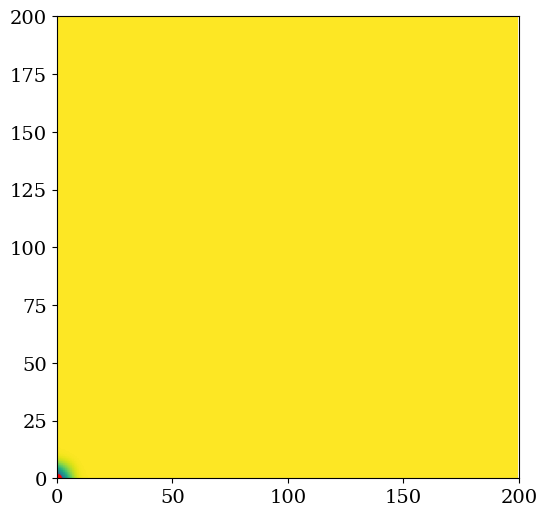

189


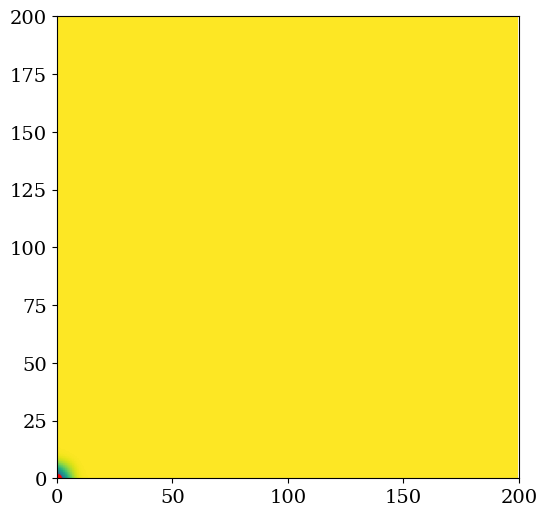

190


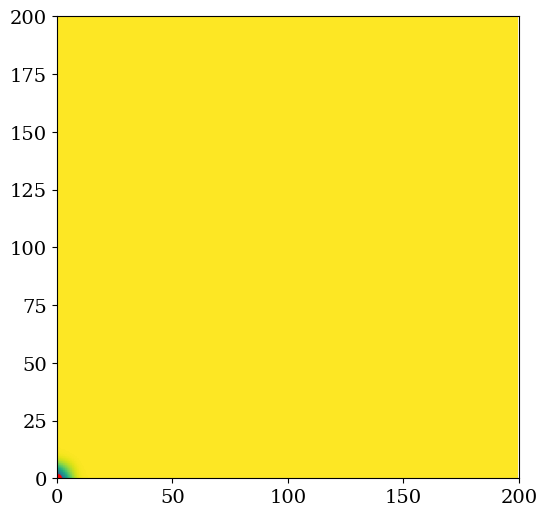

191


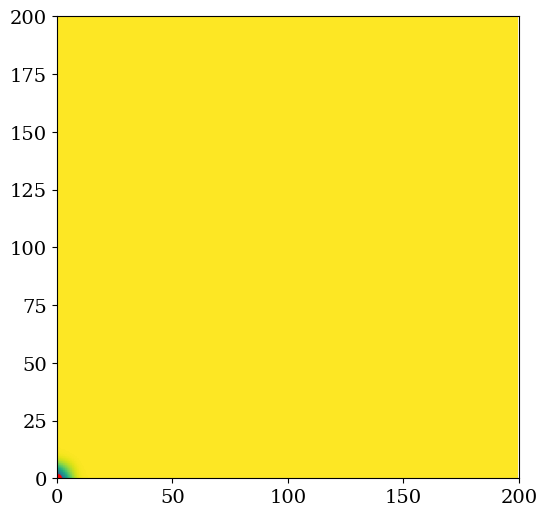

192


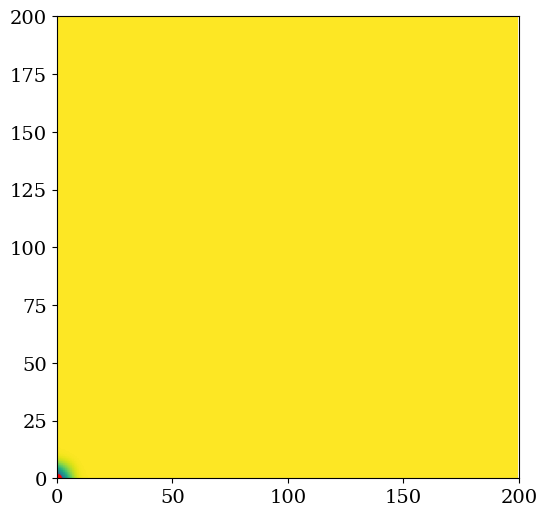

196


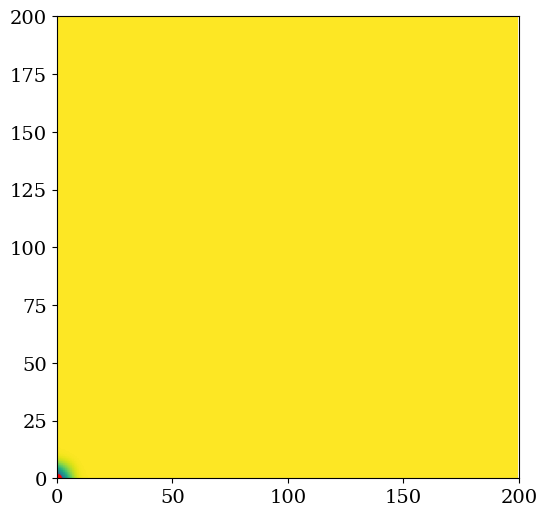

198


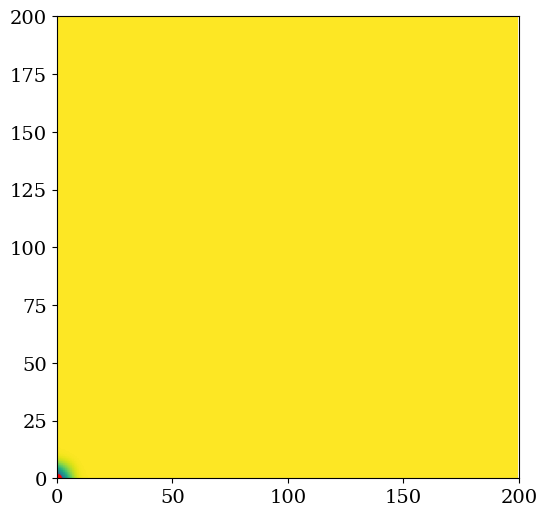

203


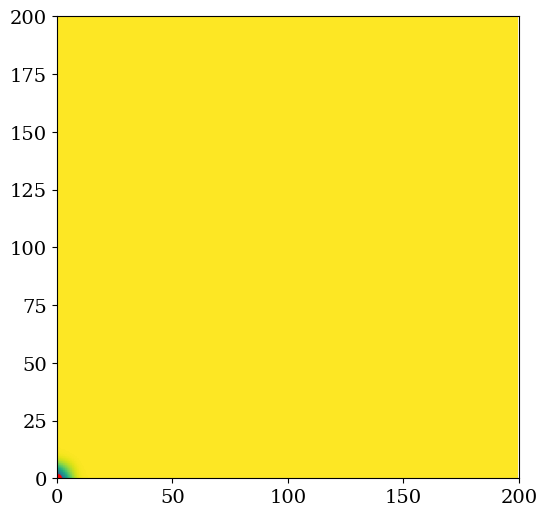

210


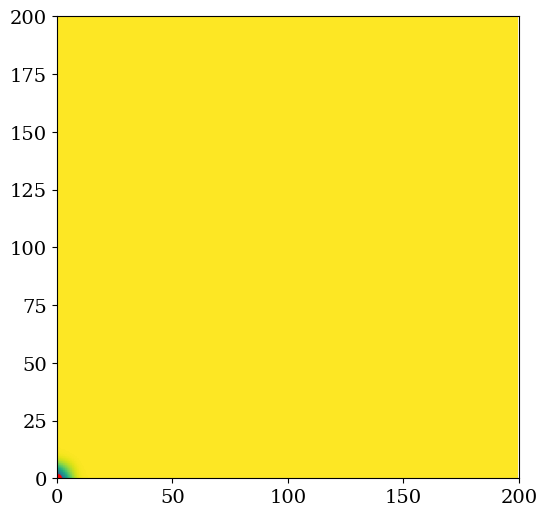

211


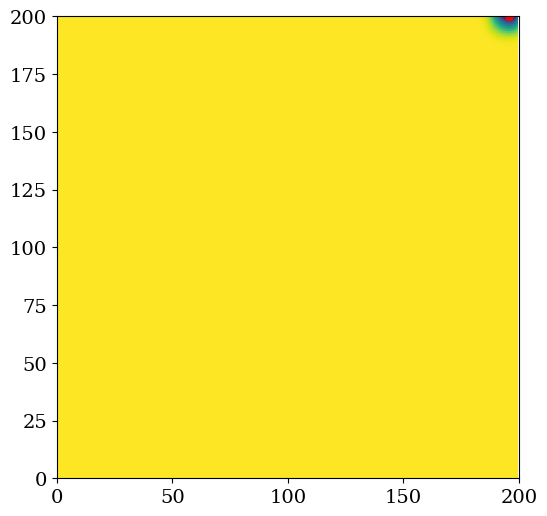

216


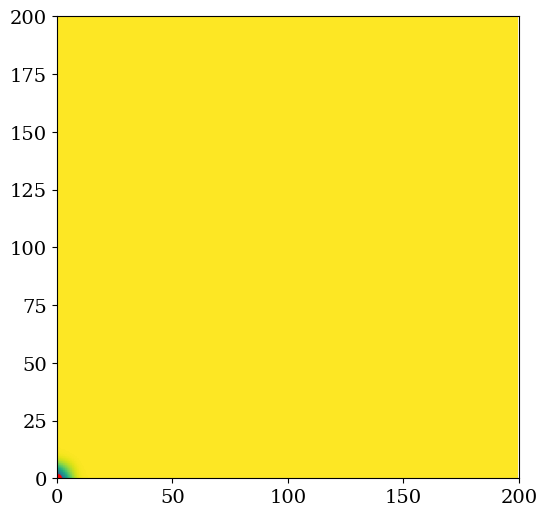

218


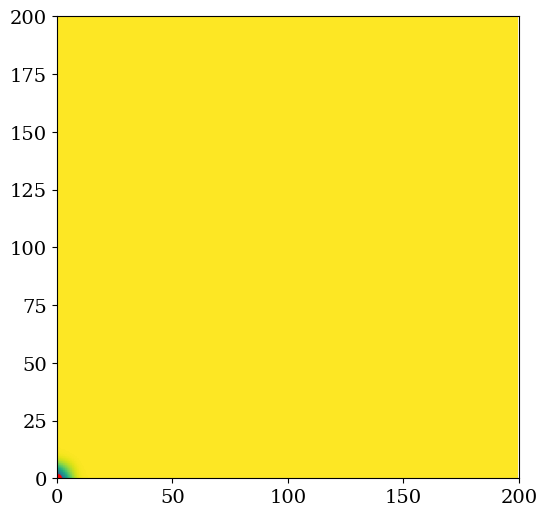

219


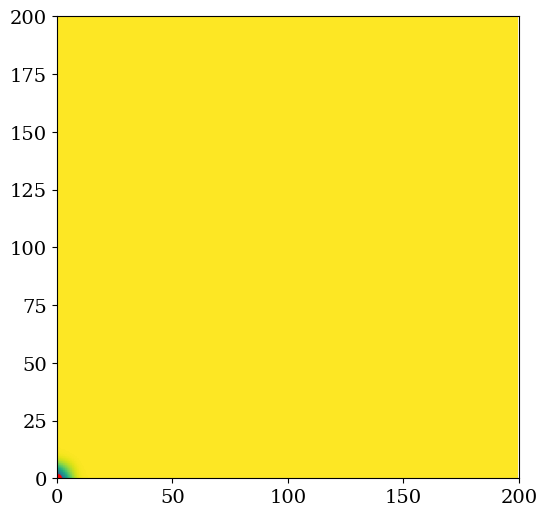

222


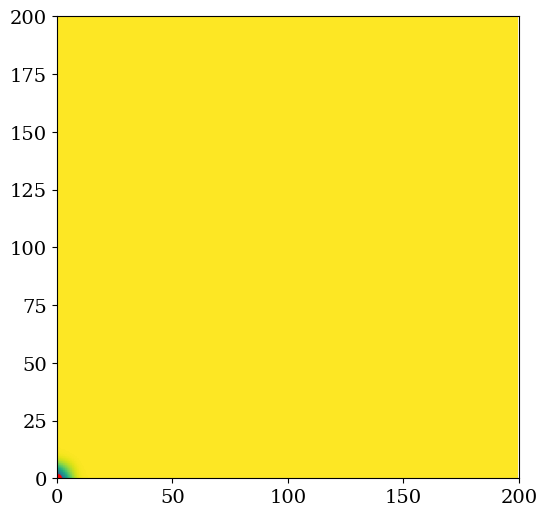

224


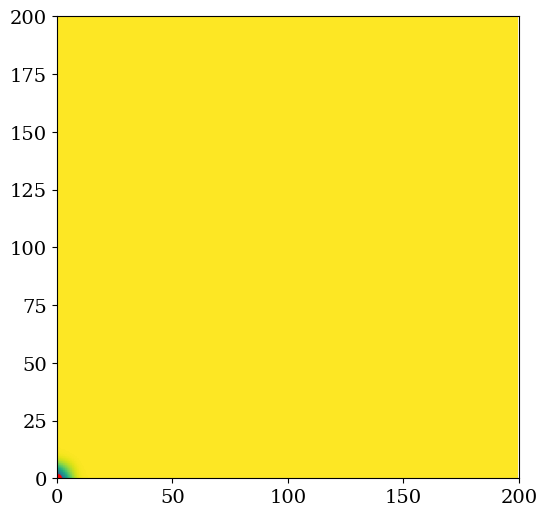

228


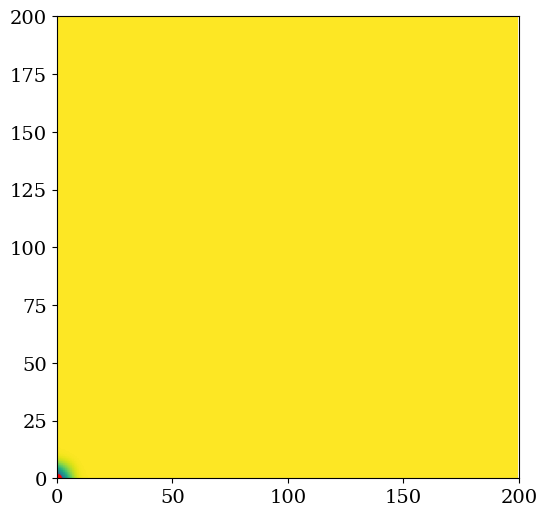

231


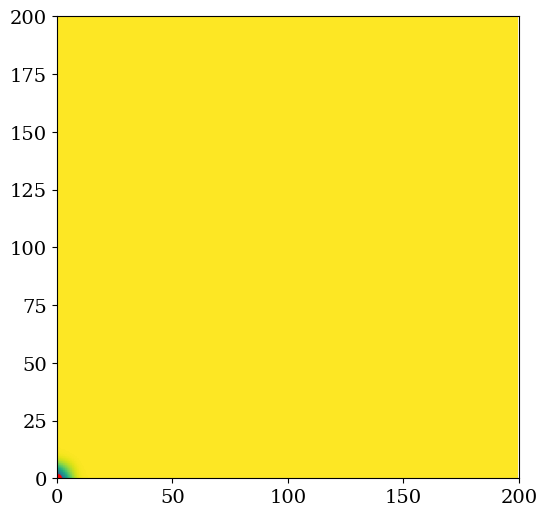

232


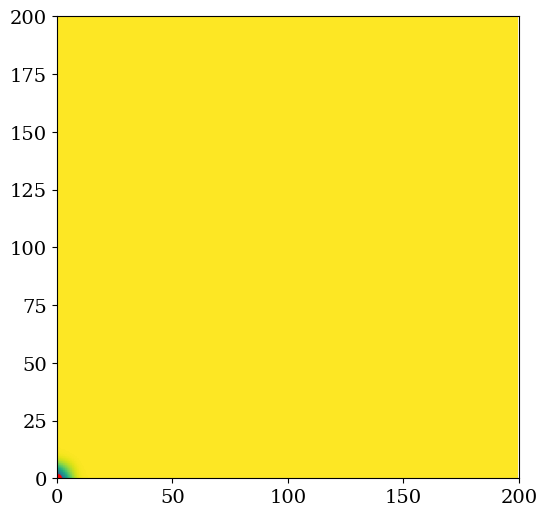

233


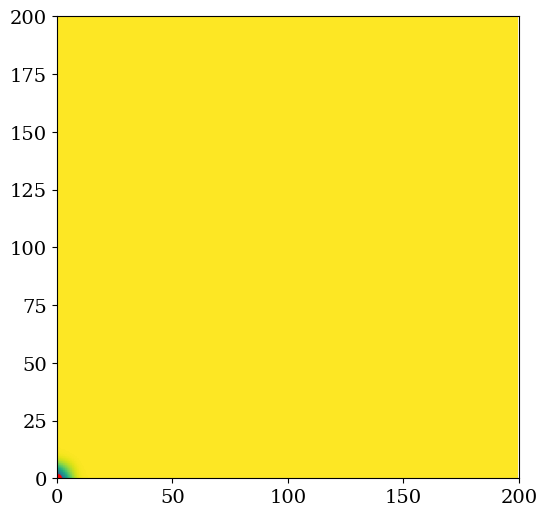

234


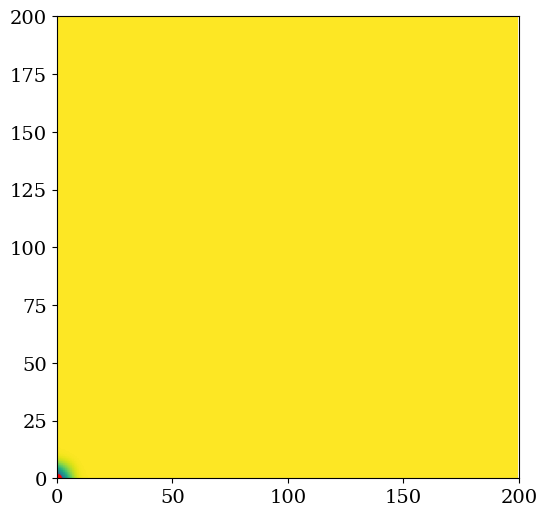

235


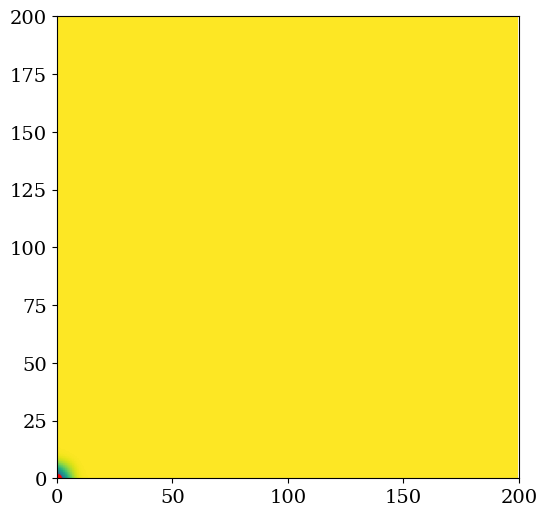

236


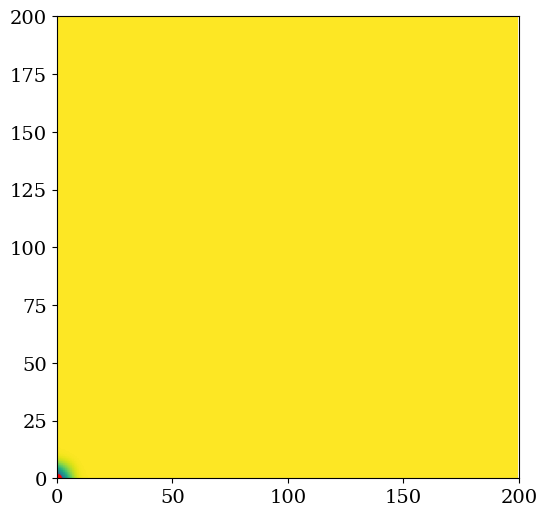

239


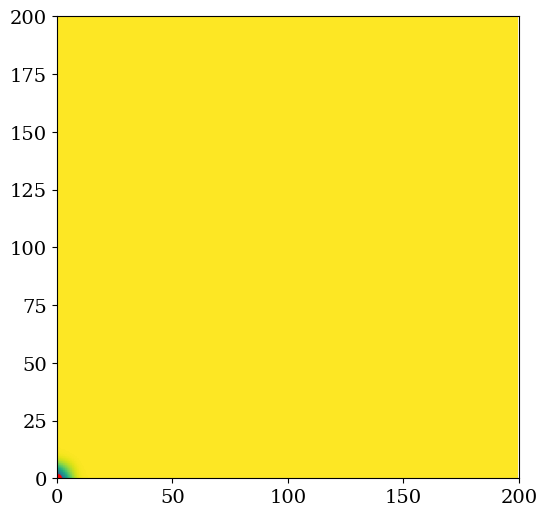

241


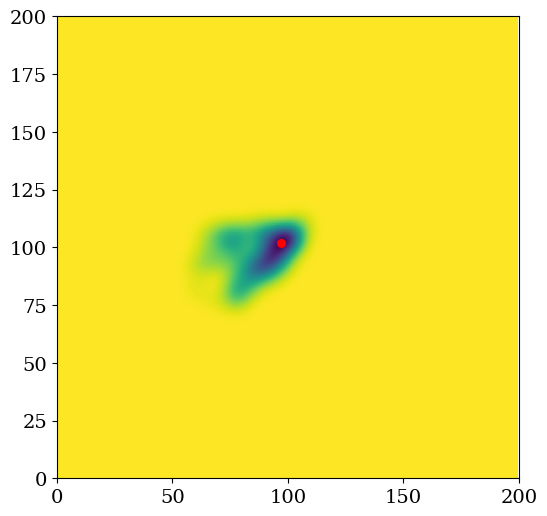

242


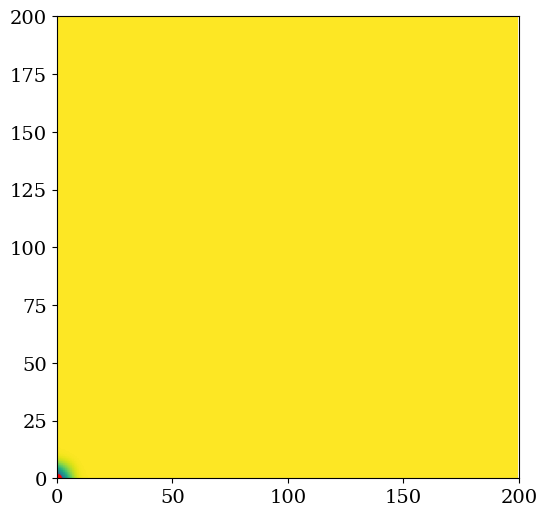

244


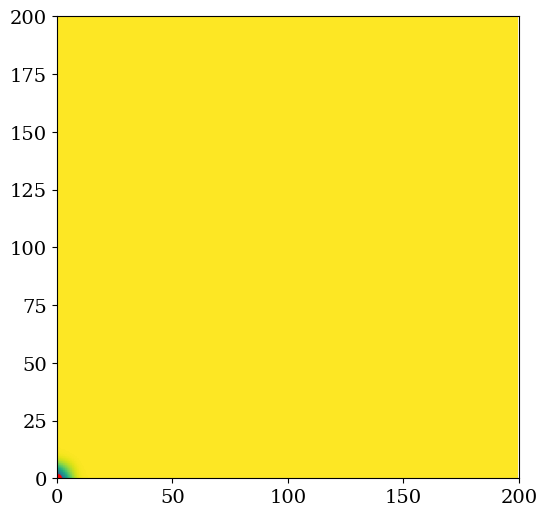

245


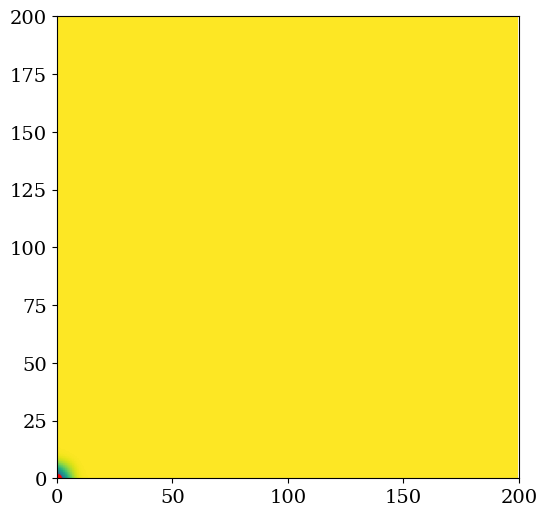

254


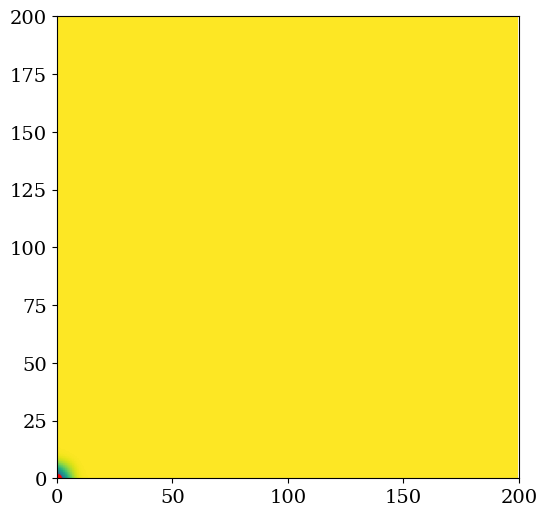

256


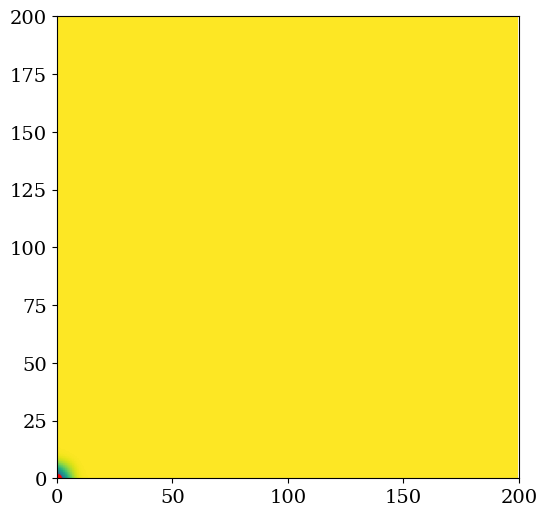

258


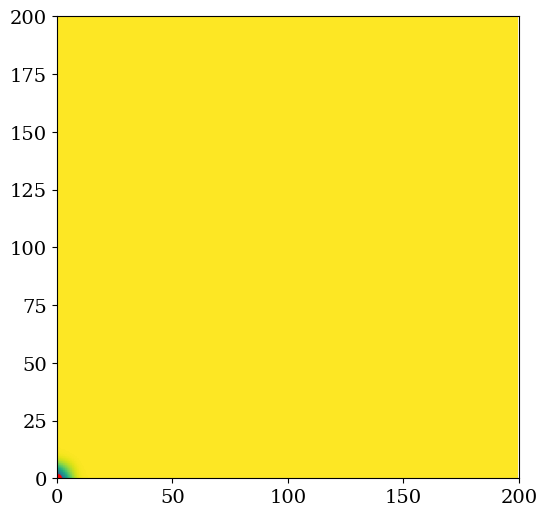

259


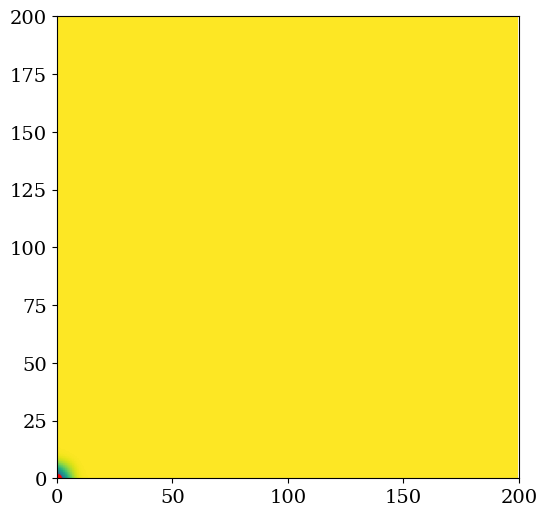

261


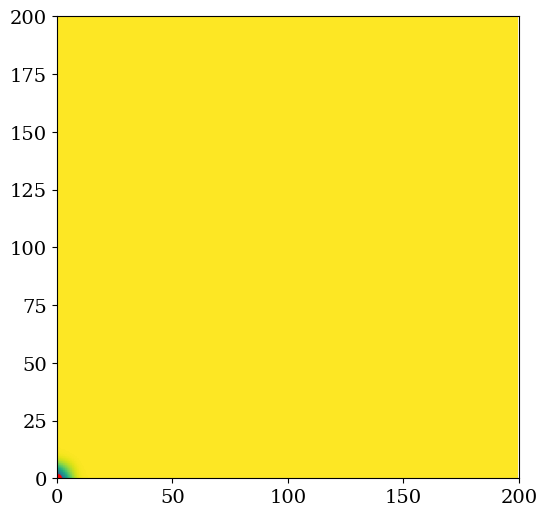

263


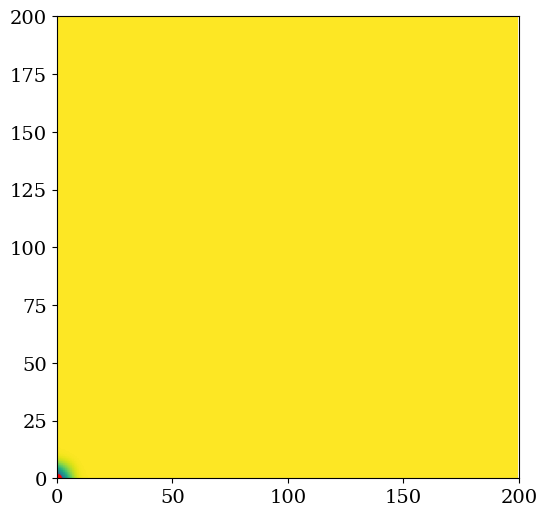

266


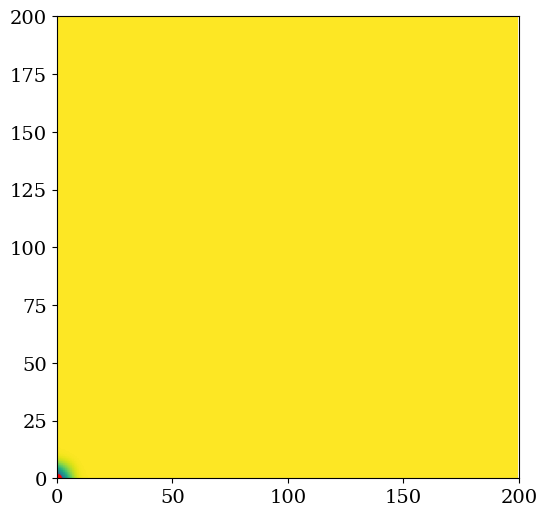

267


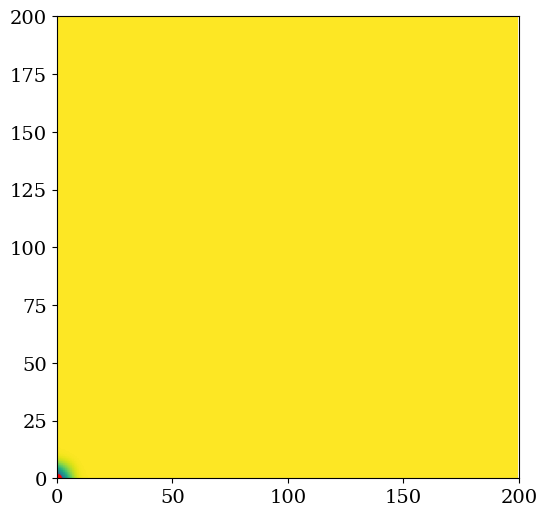

270


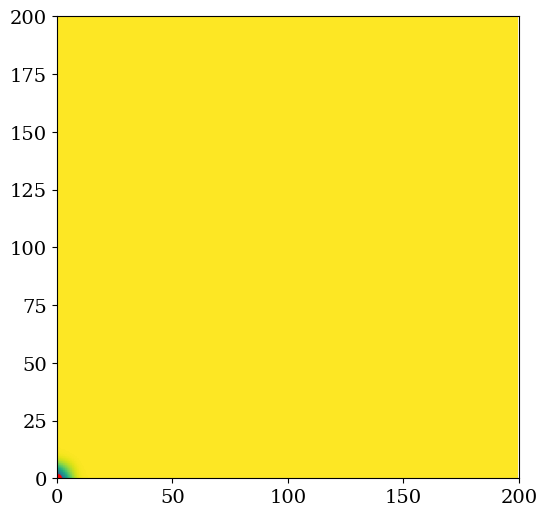

271


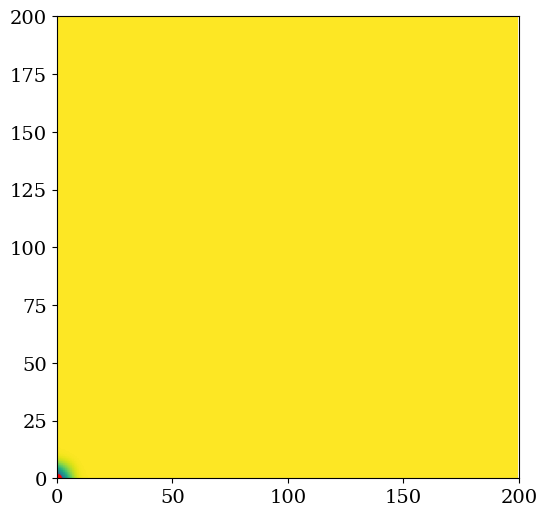

272


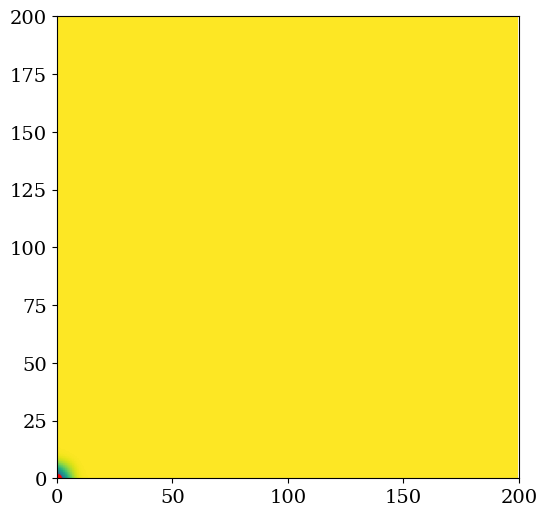

275


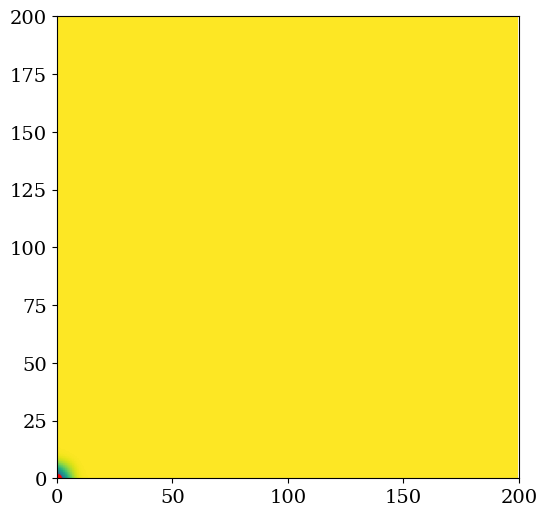

276


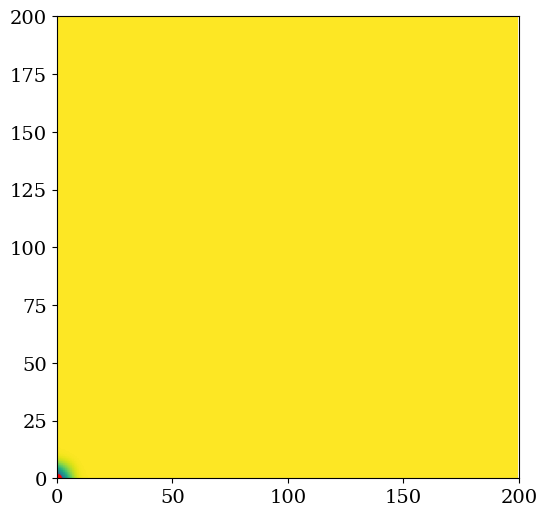

280


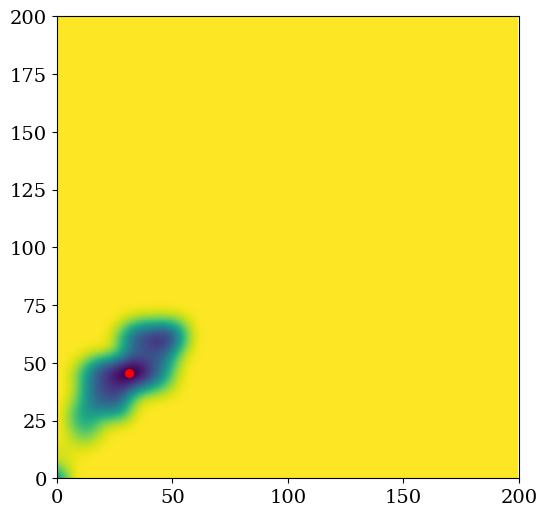

281


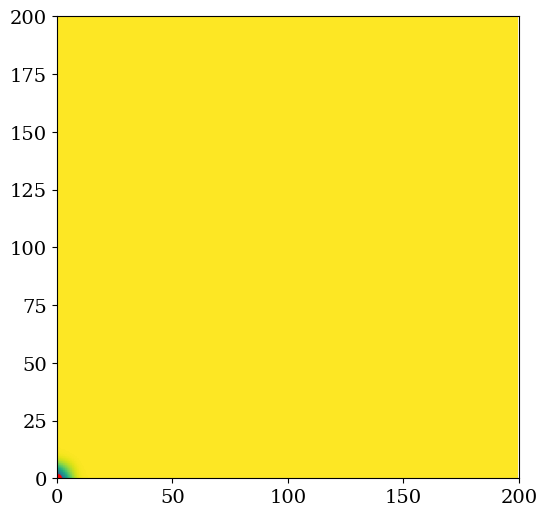

282


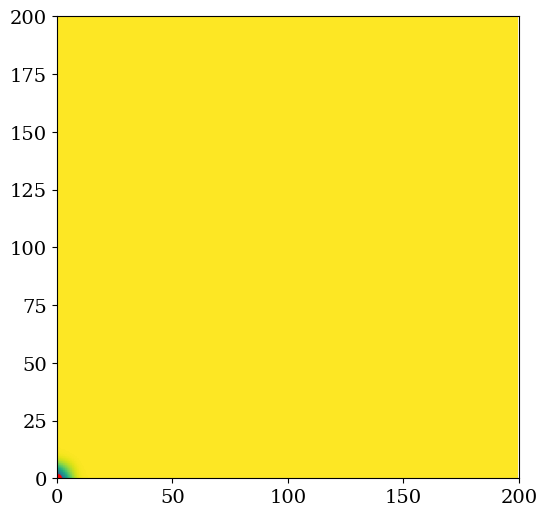

283


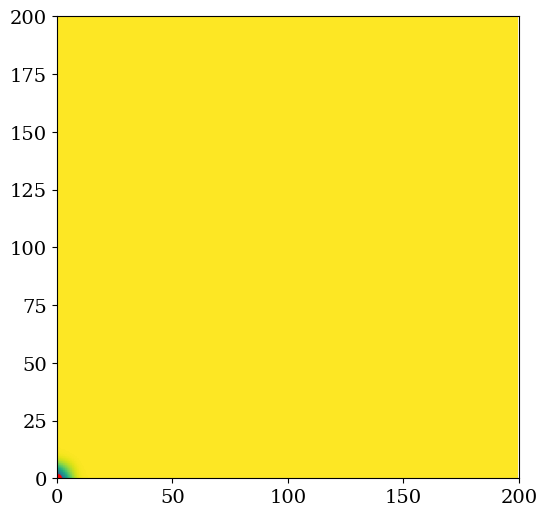

284


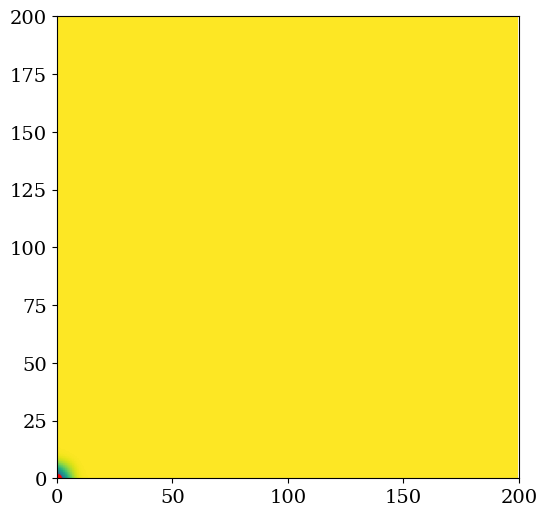

286


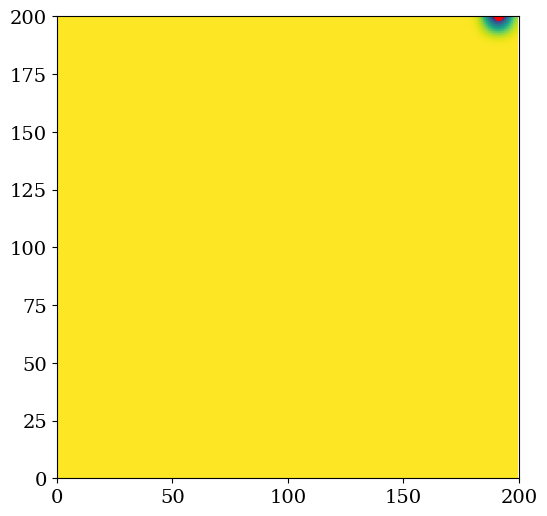

288


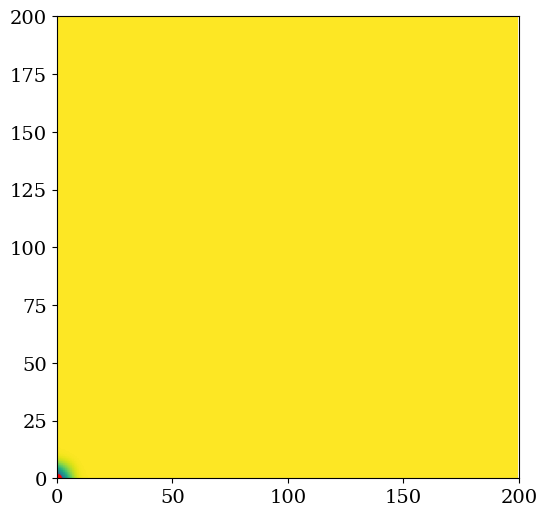

290


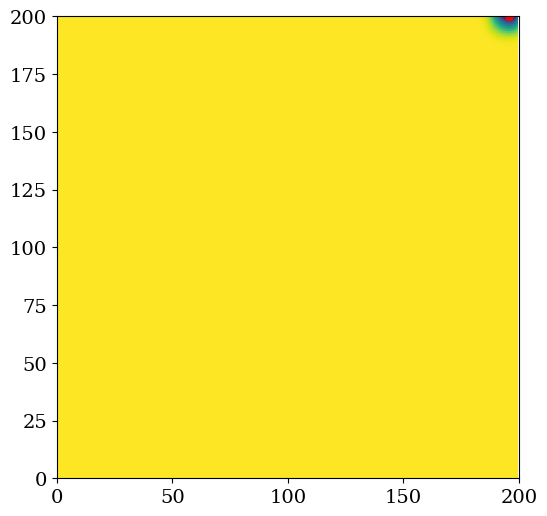

291


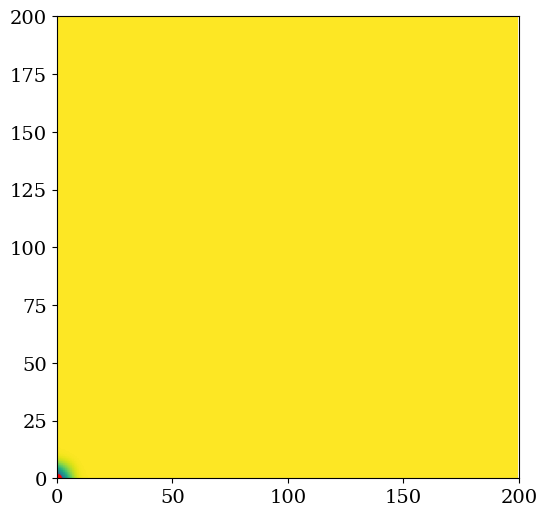

295


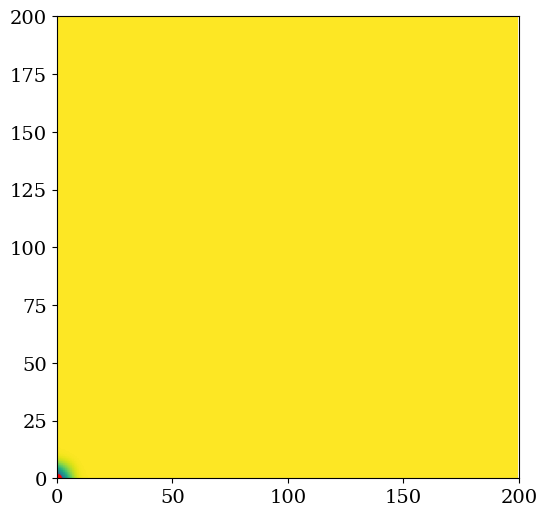

296


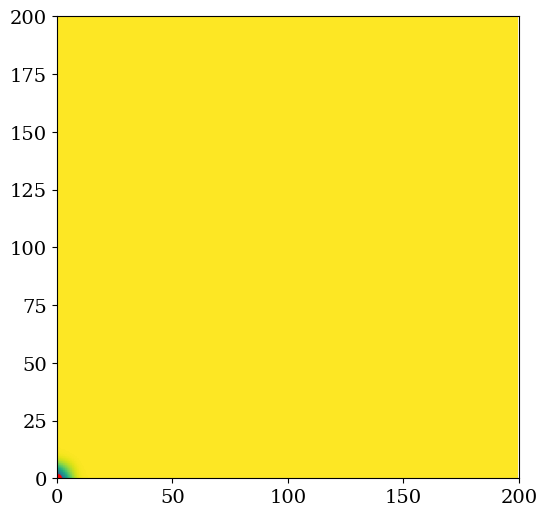

297


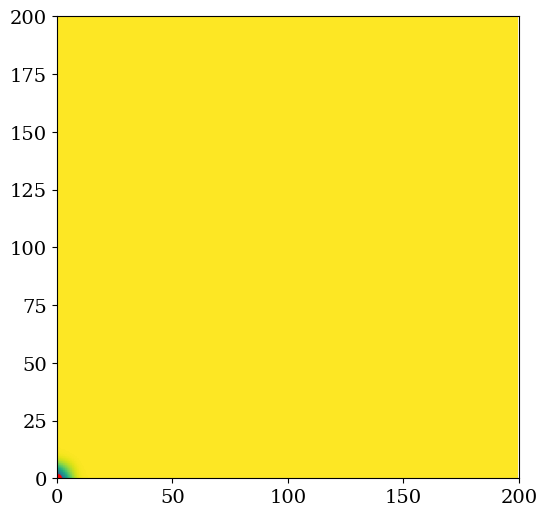

299


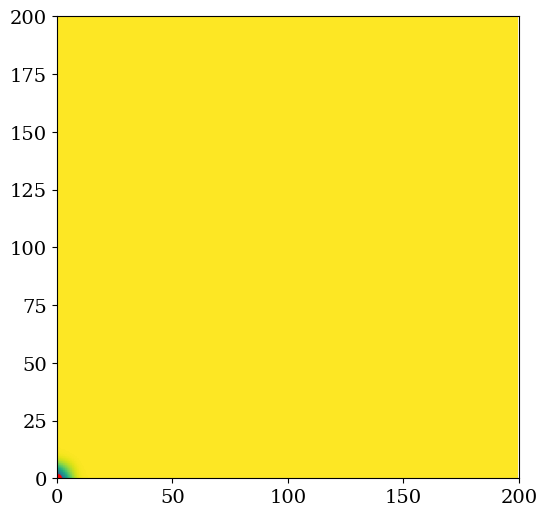

301


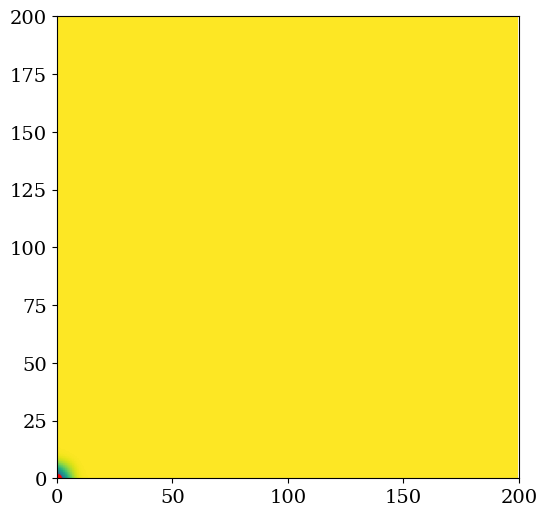

310


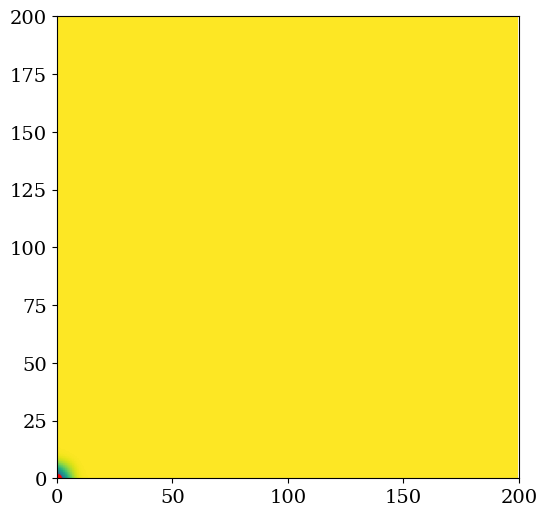

313


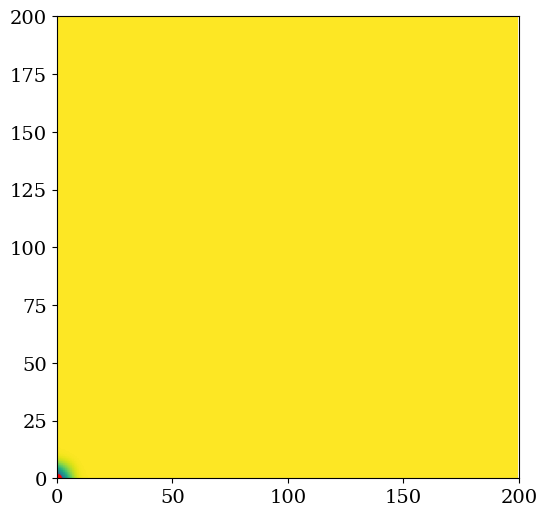

316


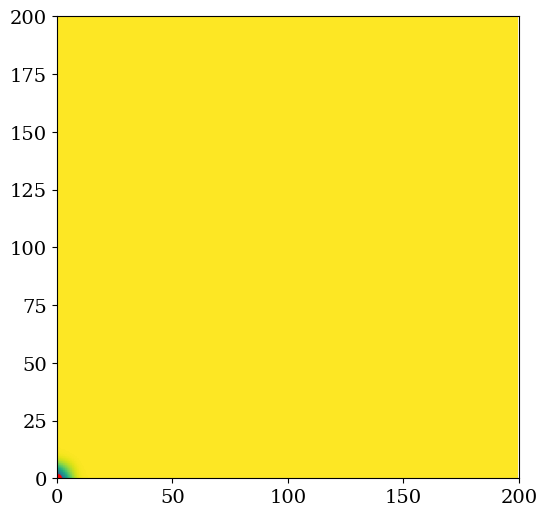

318


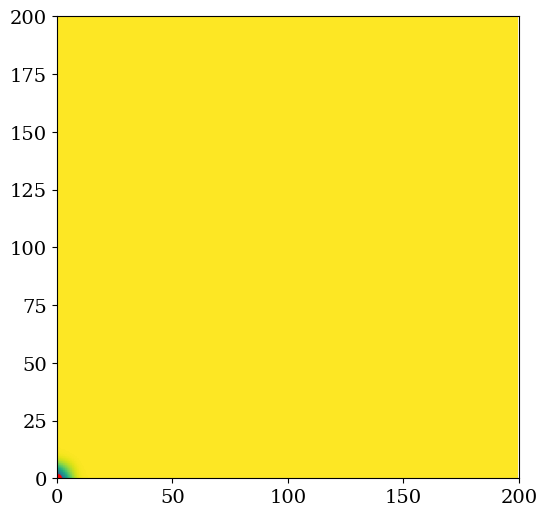

319


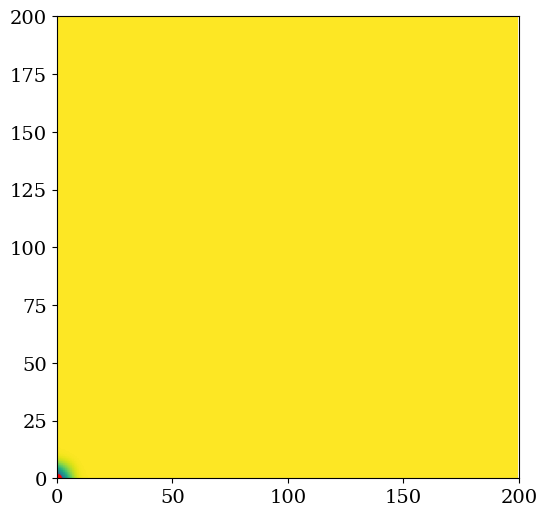

320


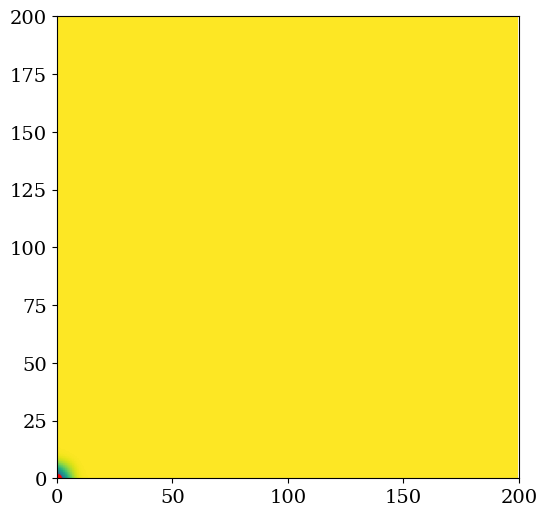

328


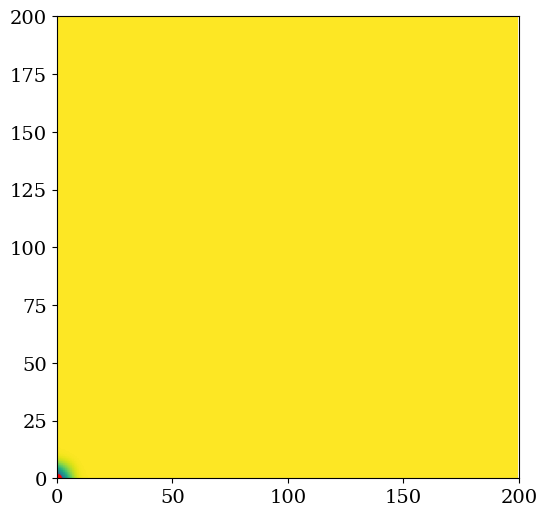

333


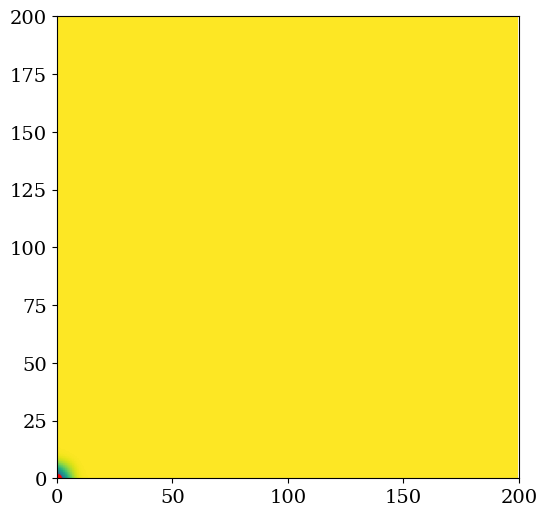

334


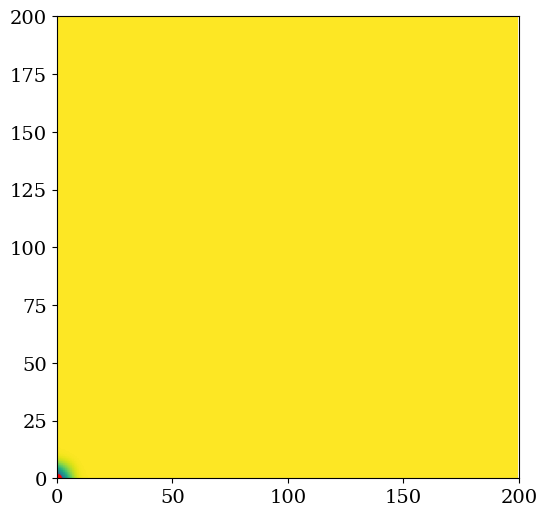

336


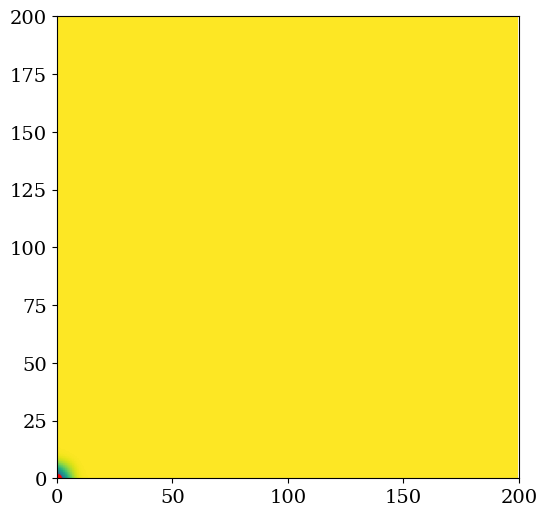

337


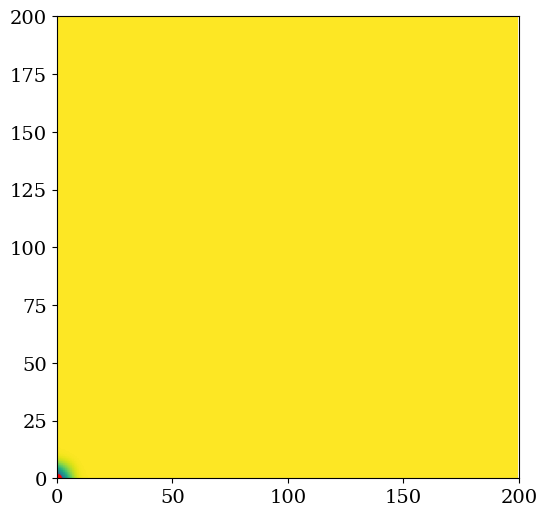

339


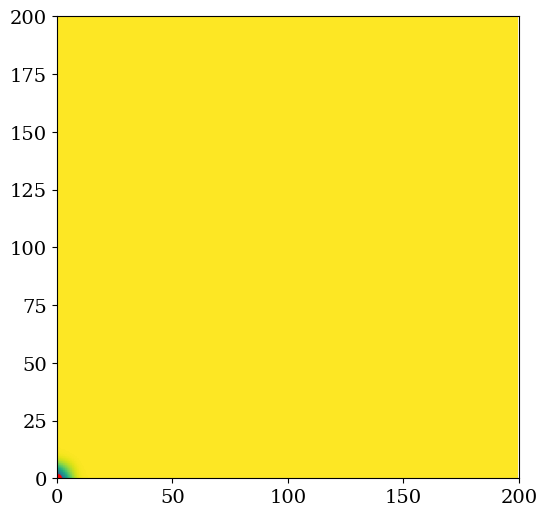

340


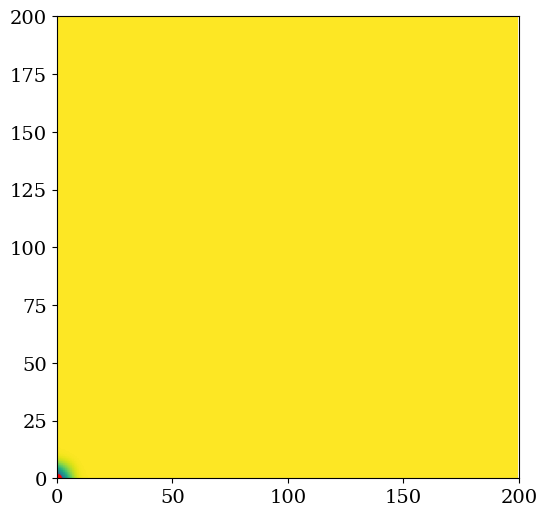

342


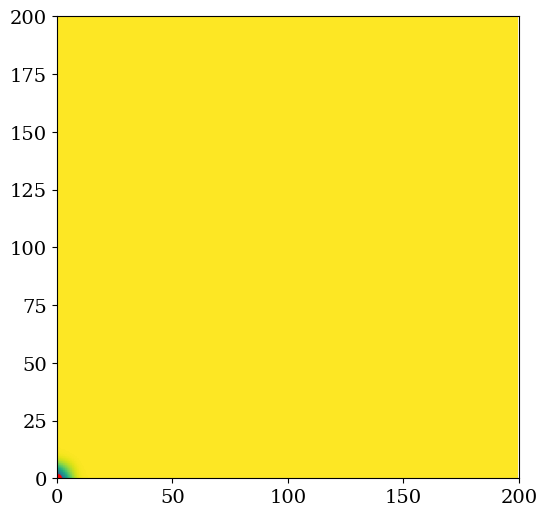

343


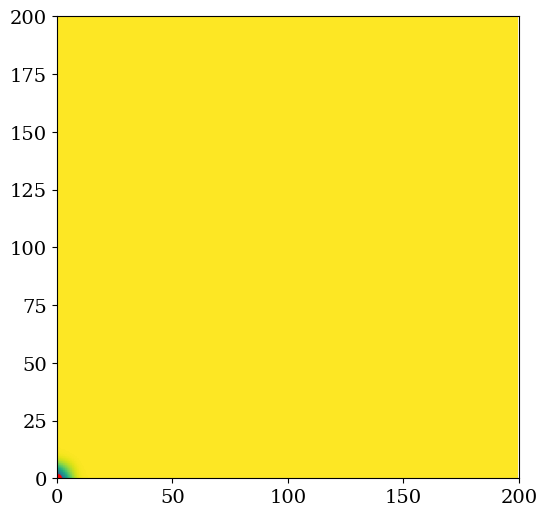

344


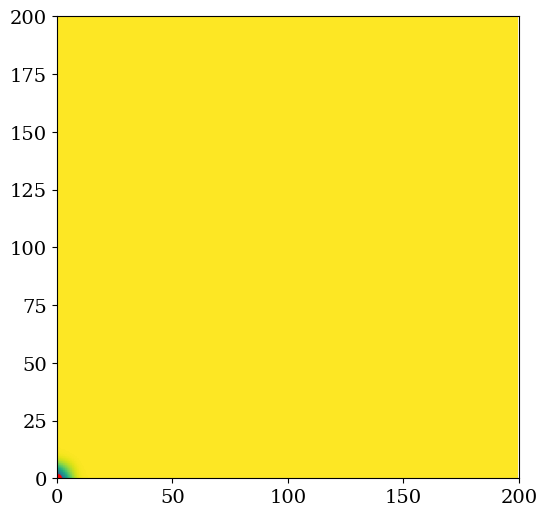

346


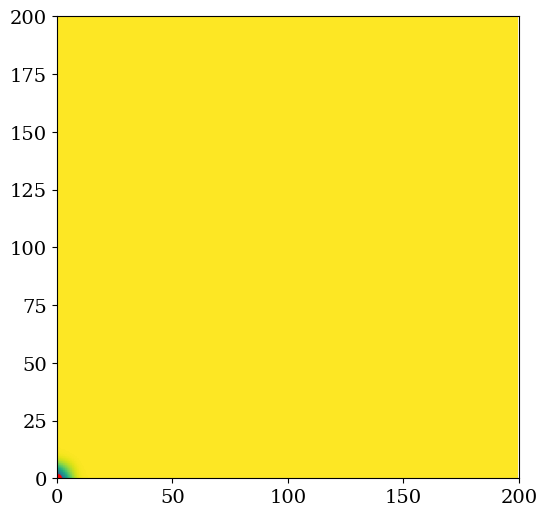

350


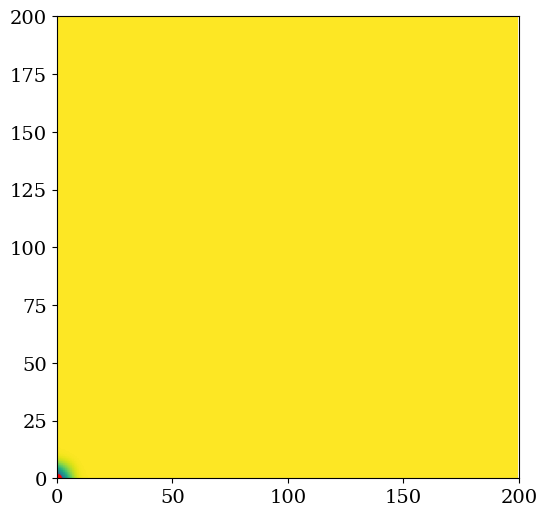

353


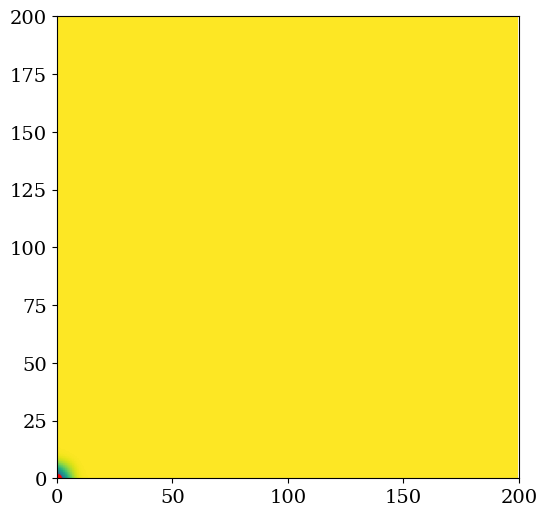

358


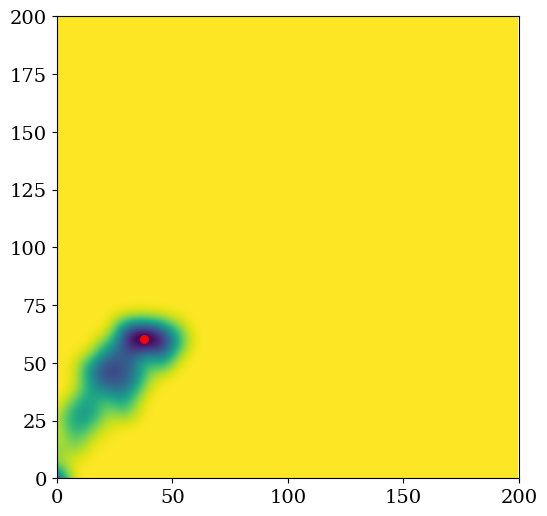

364


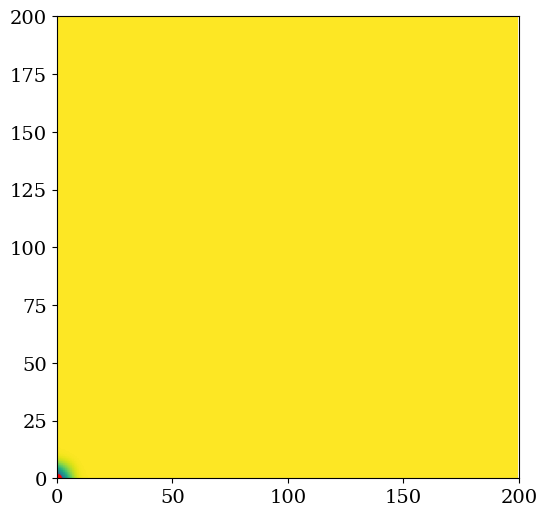

367


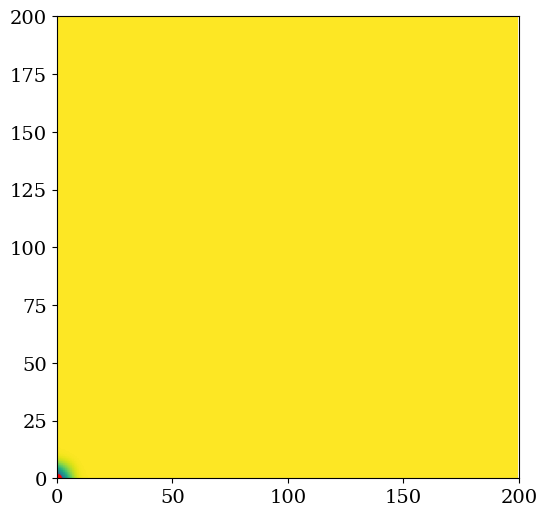

369


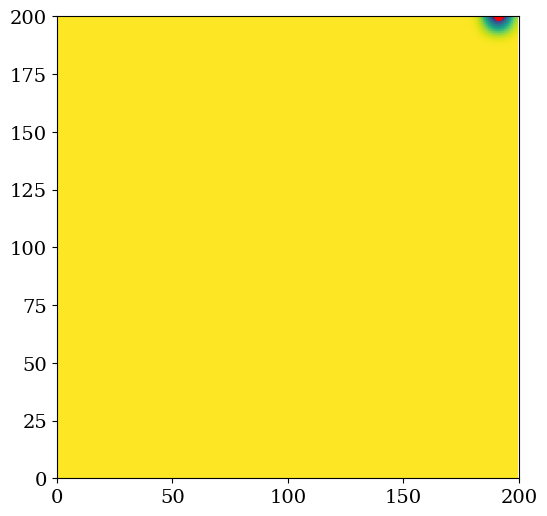

370


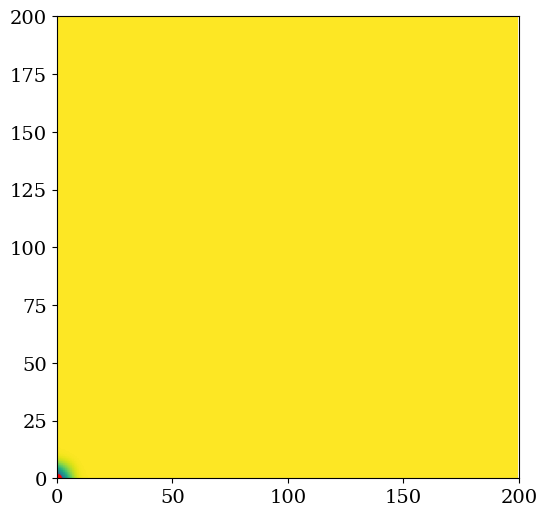

371


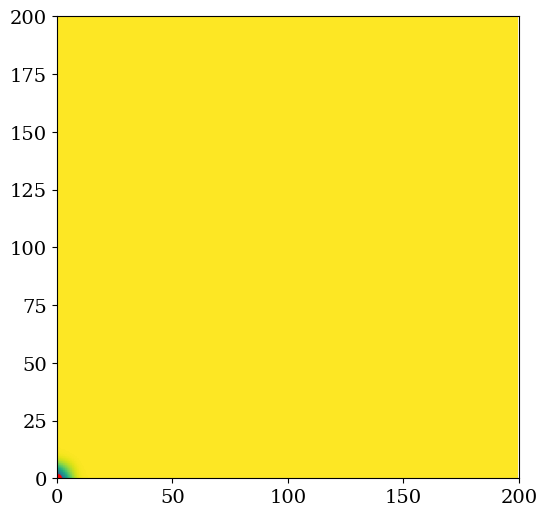

372


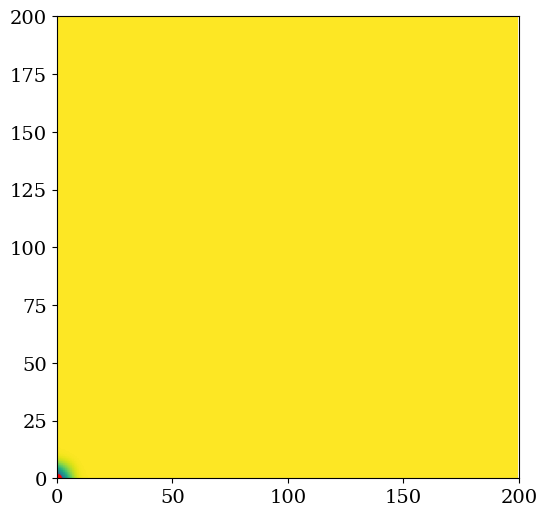

373


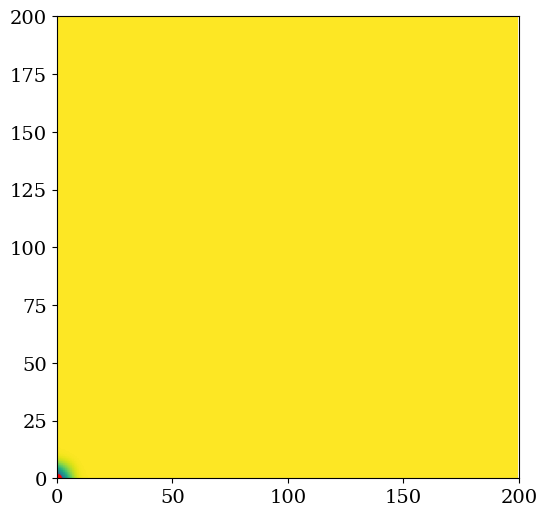

377


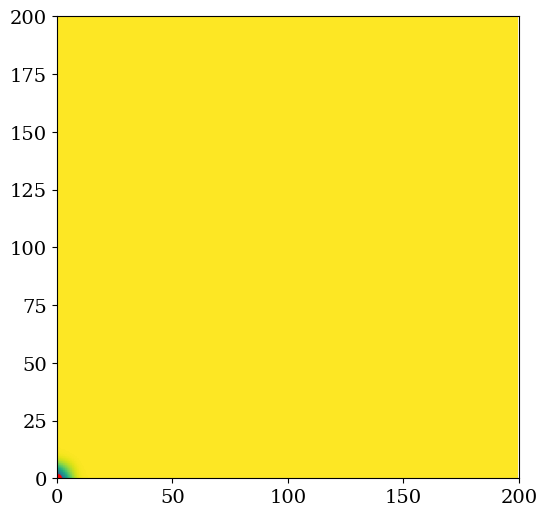

378


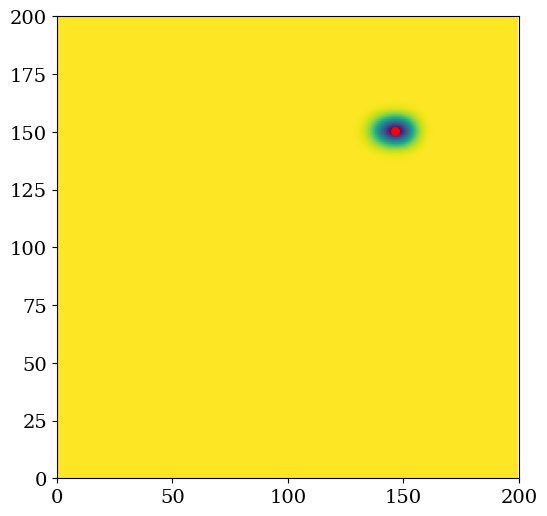

380


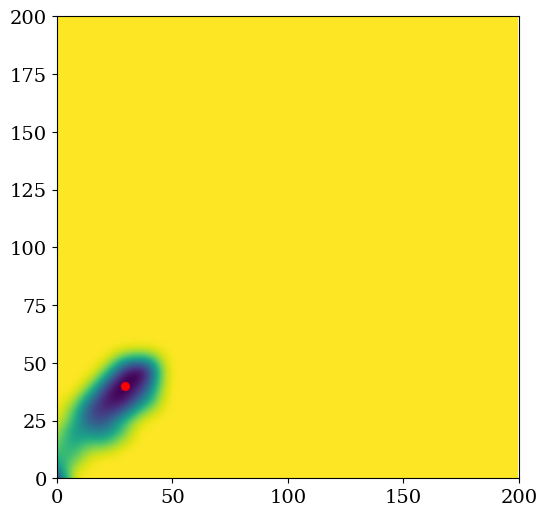

382


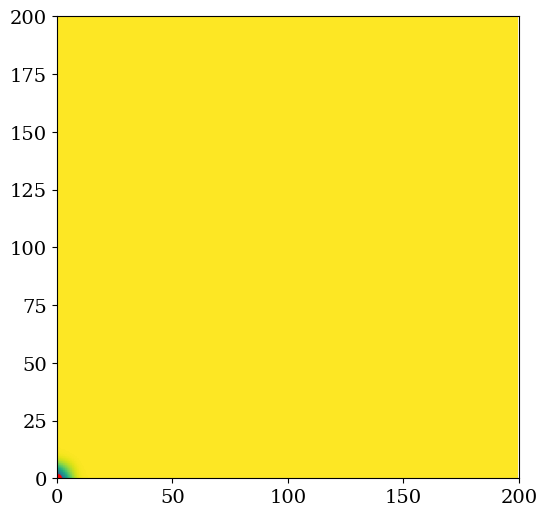

391


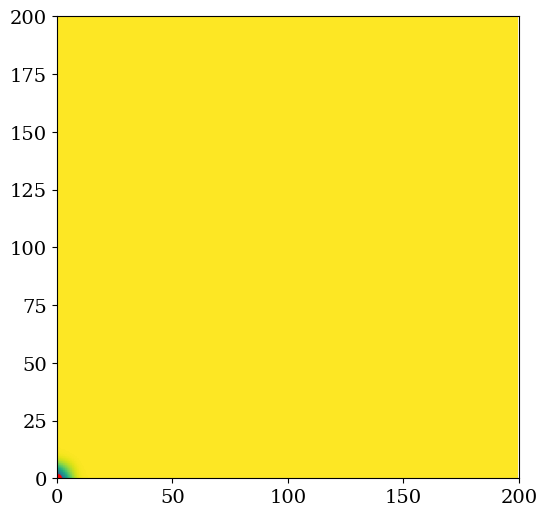

395


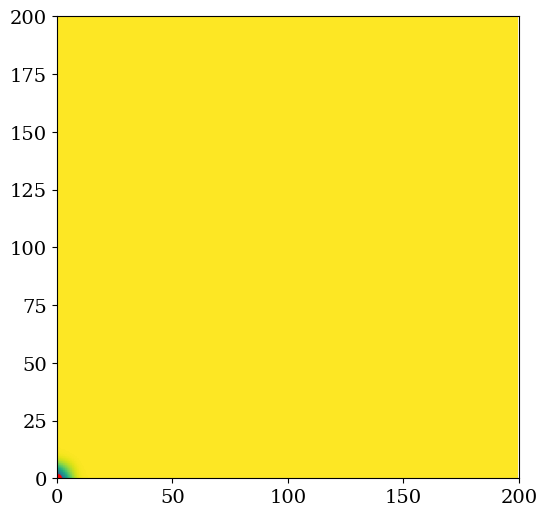

396


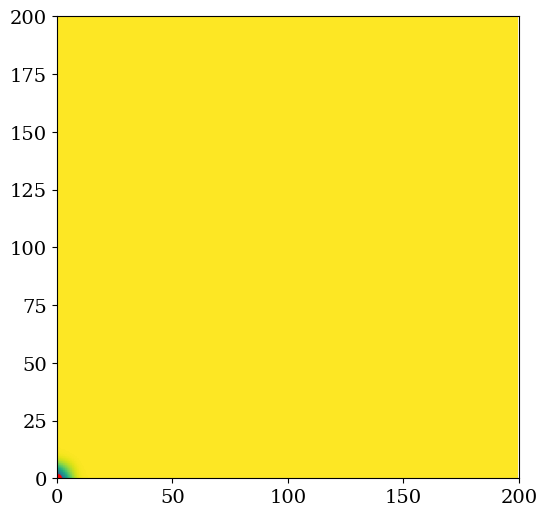

398


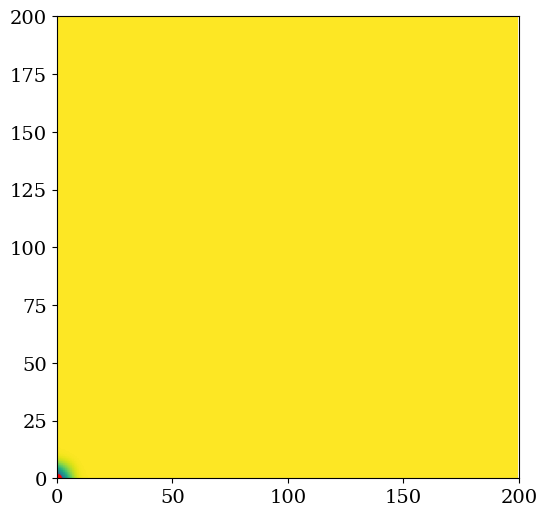

399


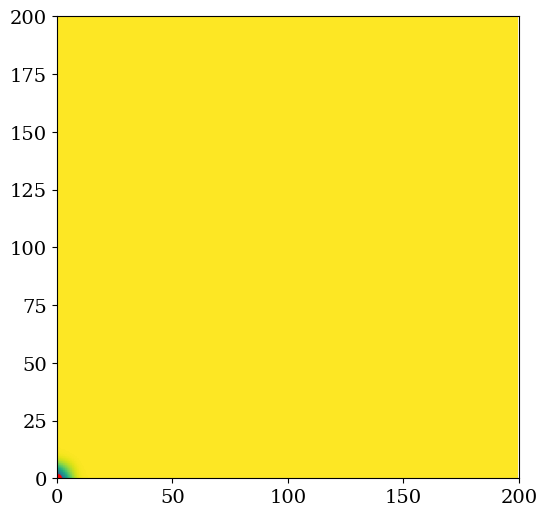

400


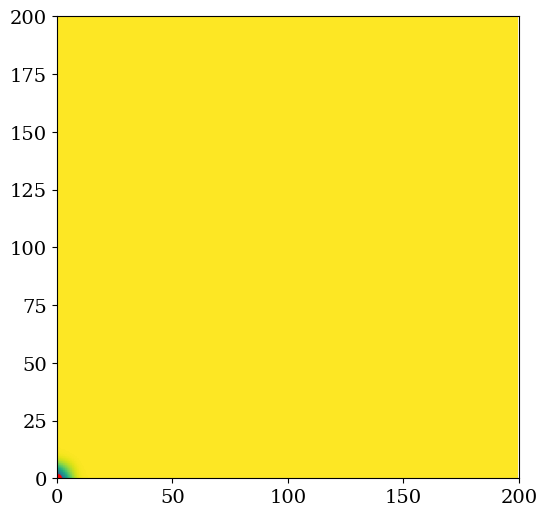

401


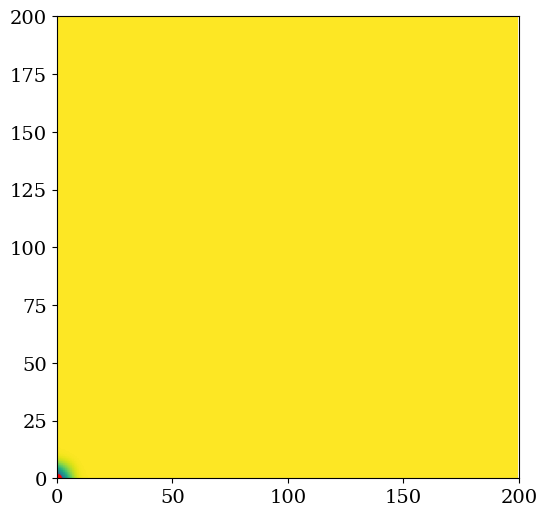

402


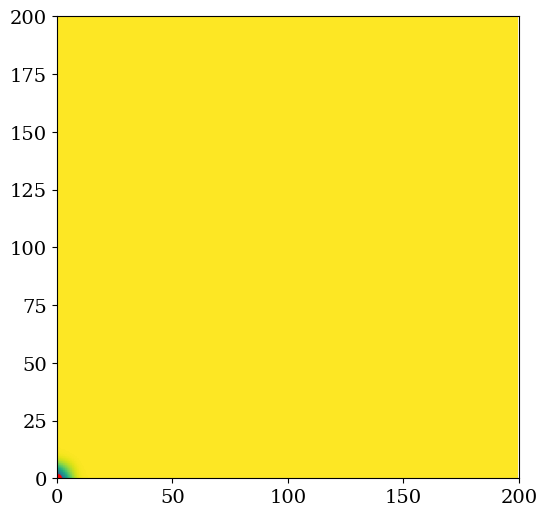

403


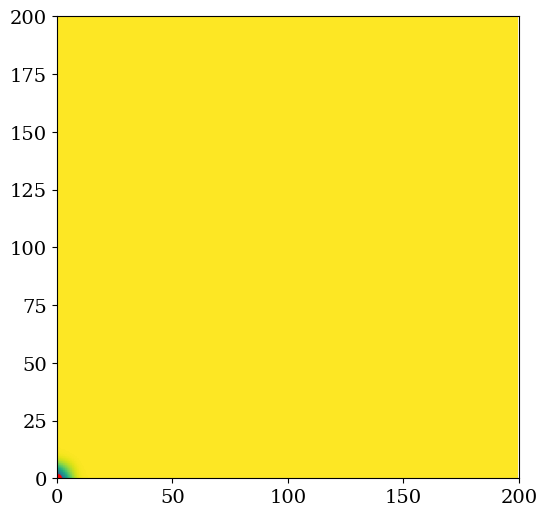

404


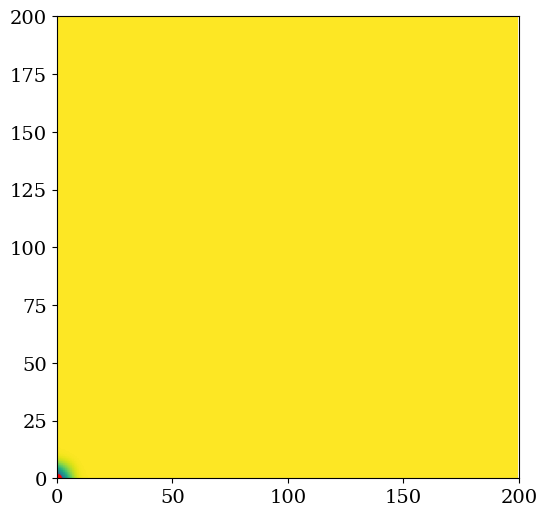

406


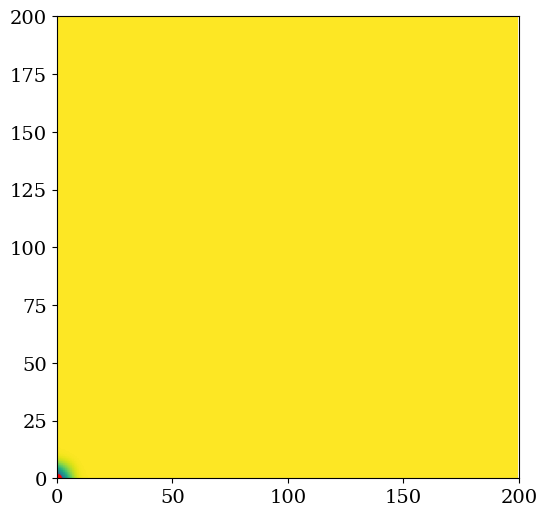

408


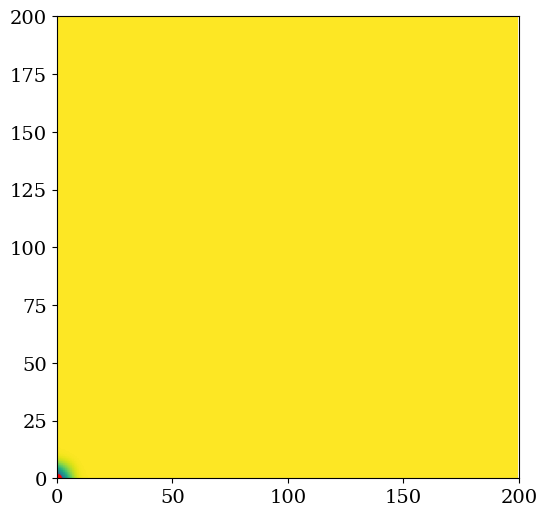

410


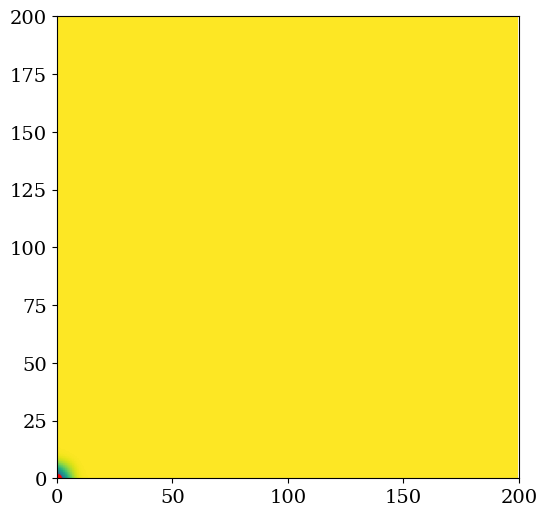

413


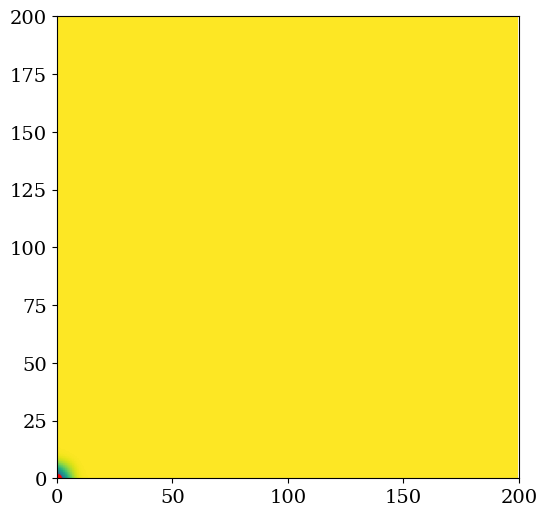

415


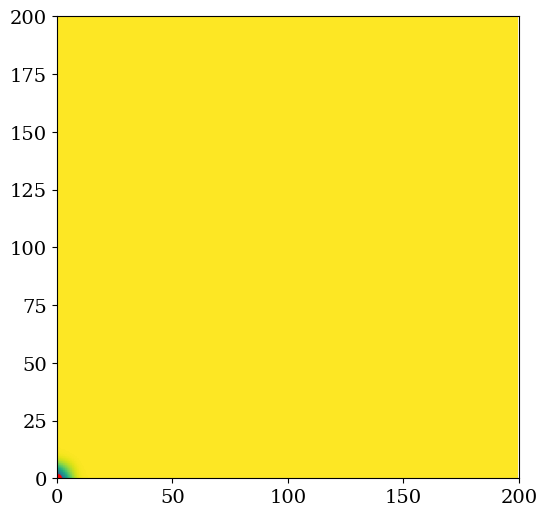

418


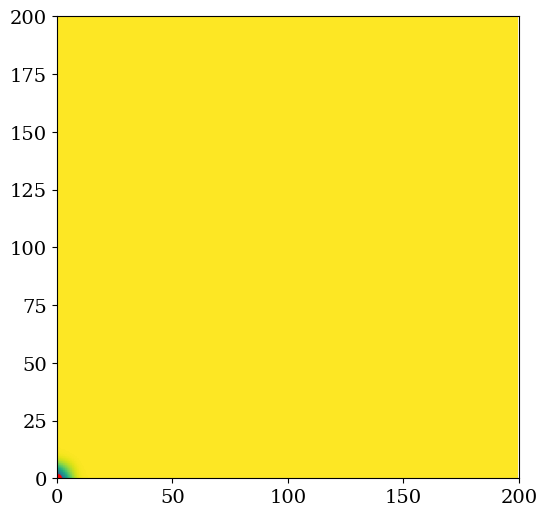

422


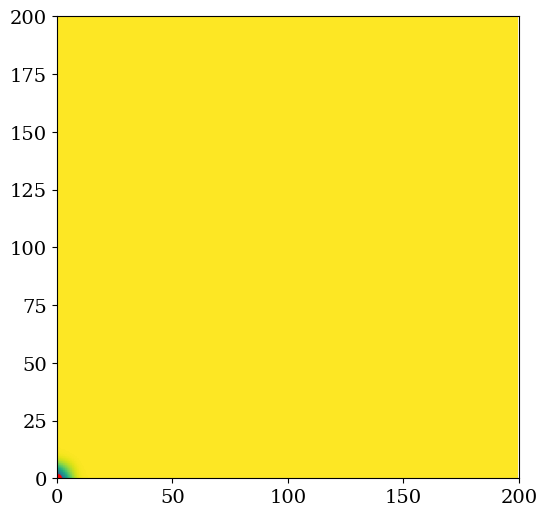

423


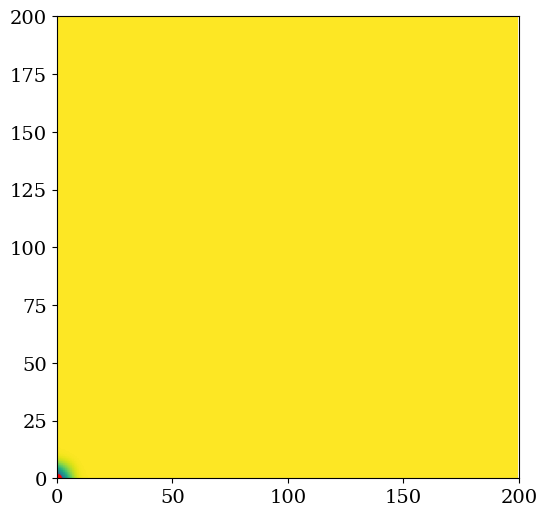

424


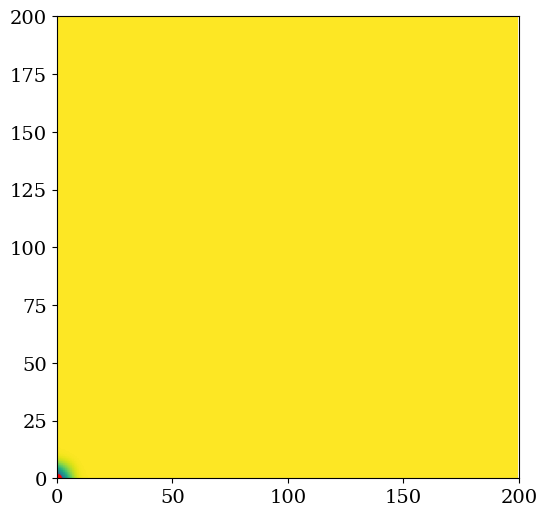

425


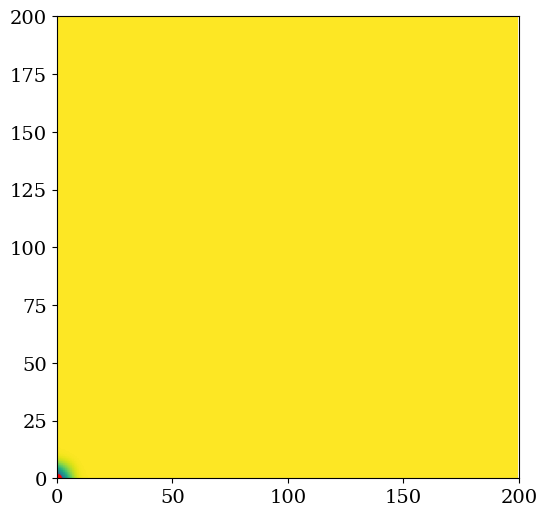

427


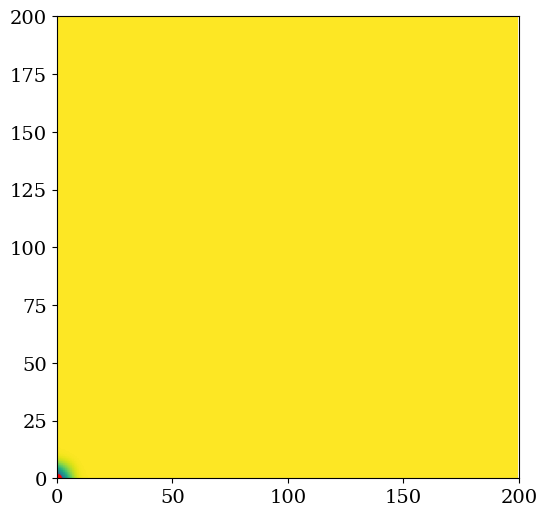

431


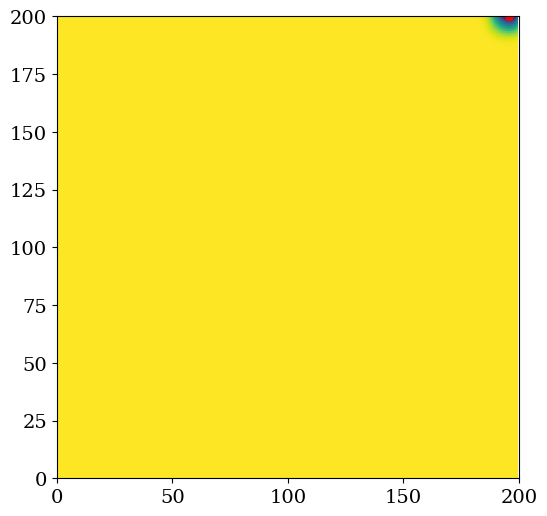

434


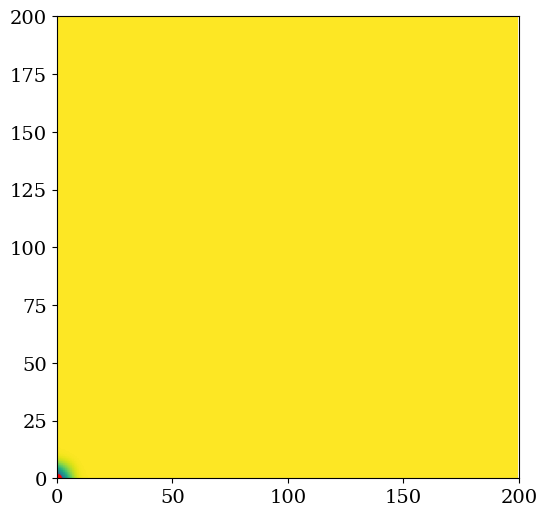

437


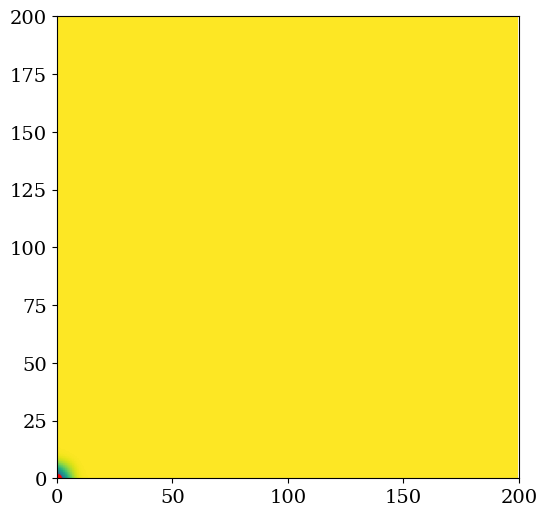

438


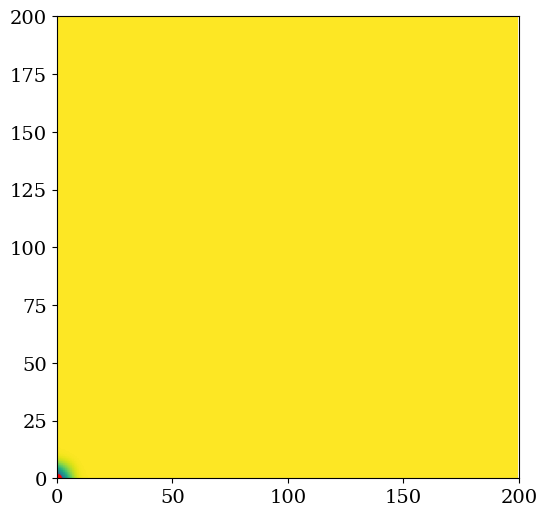

440


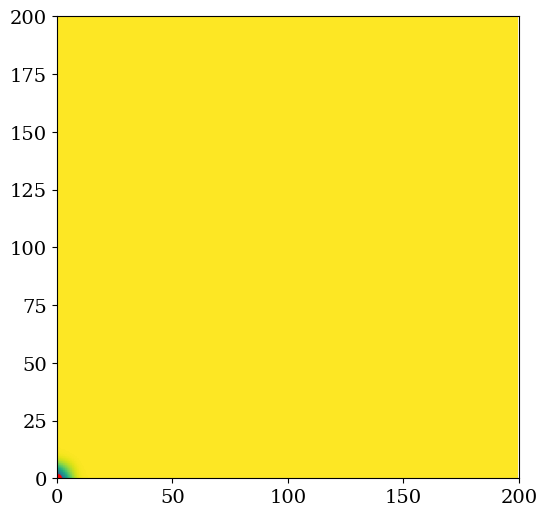

441


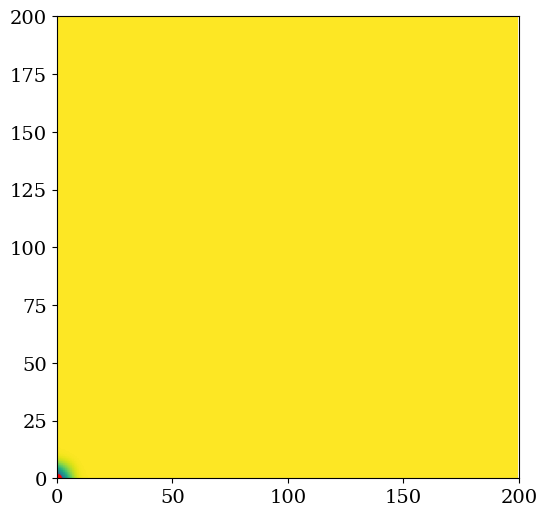

443


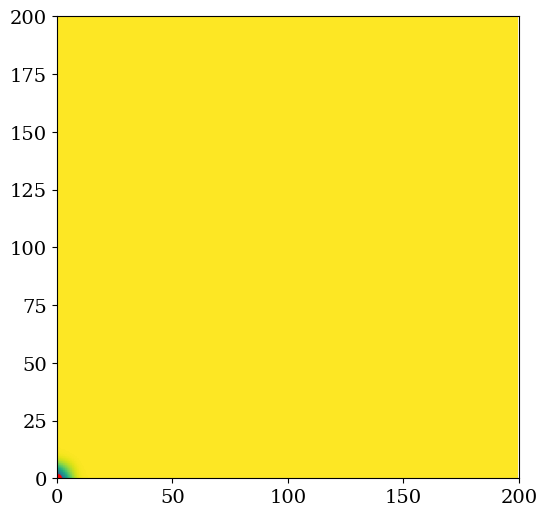

444


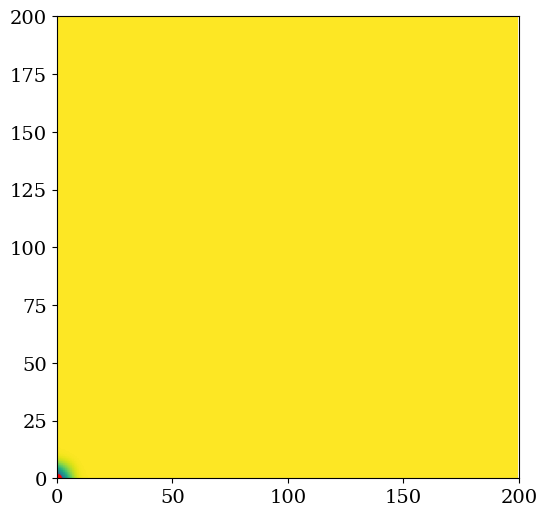

446


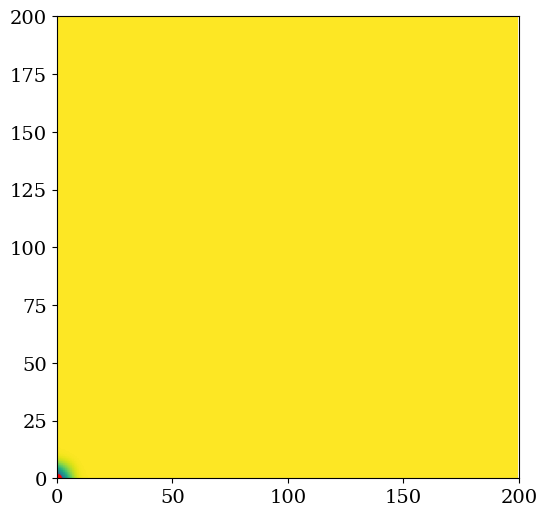

447


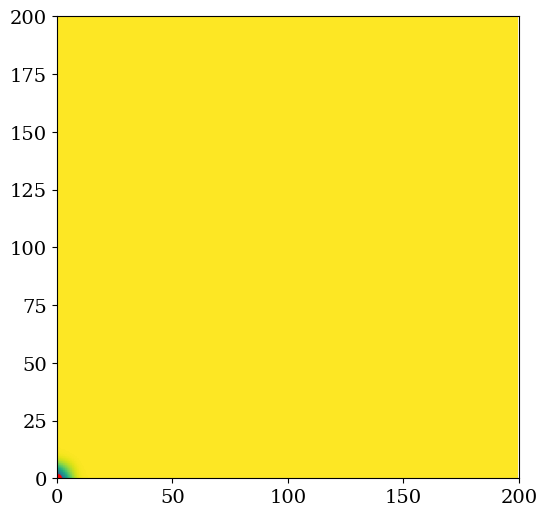

448


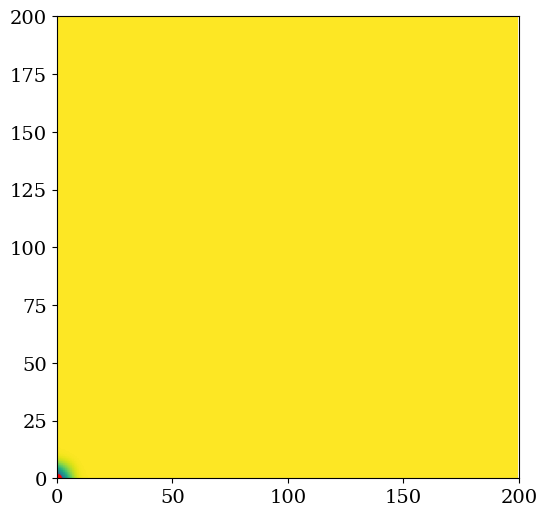

450


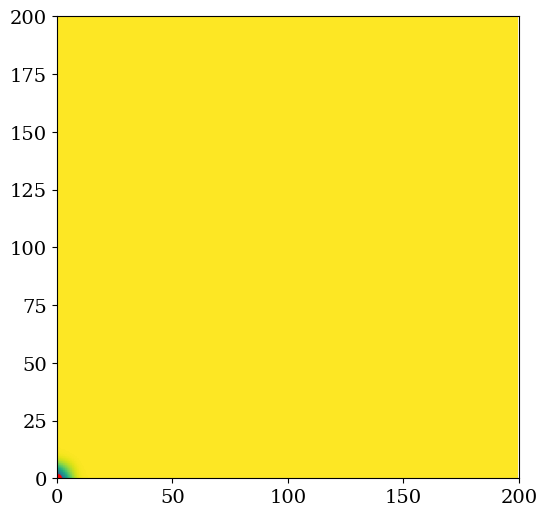

454


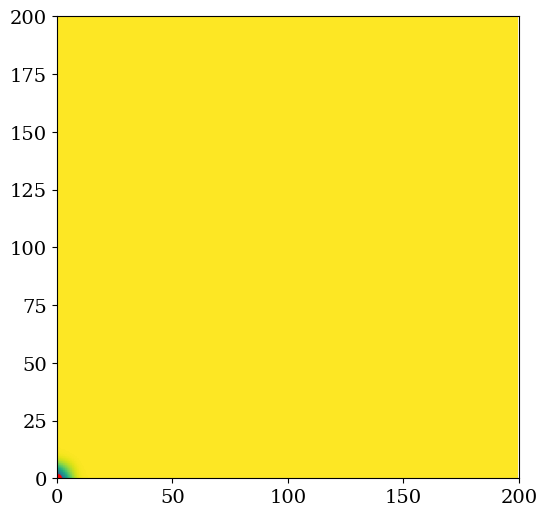

457


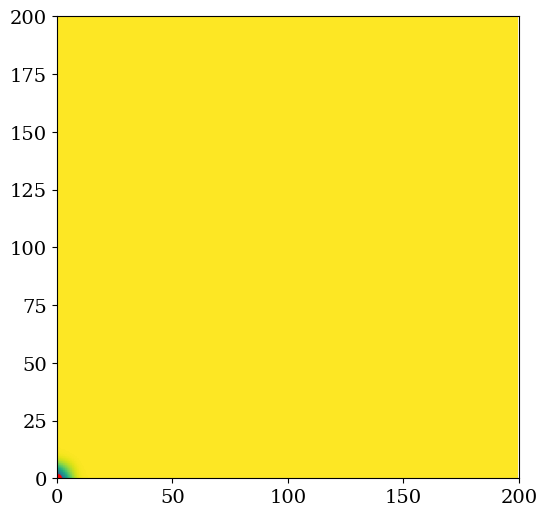

461


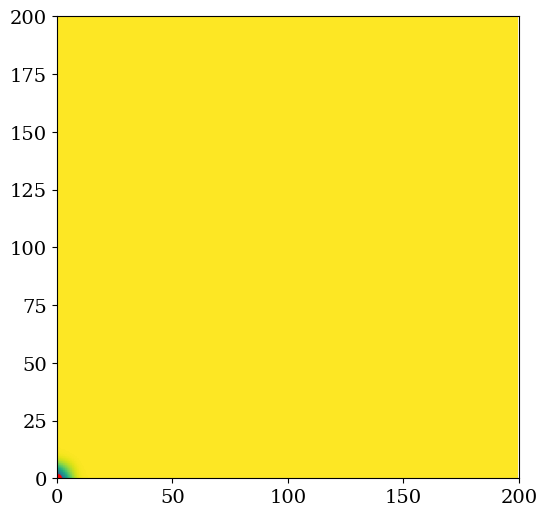

465


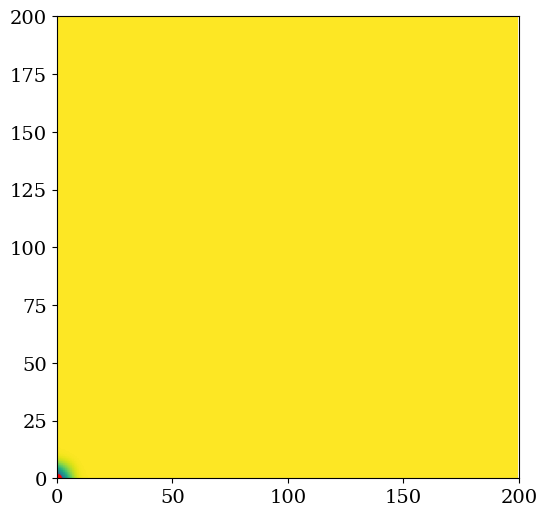

467


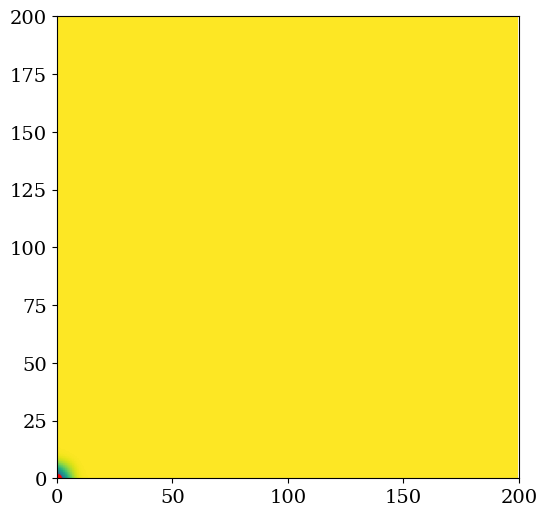

472


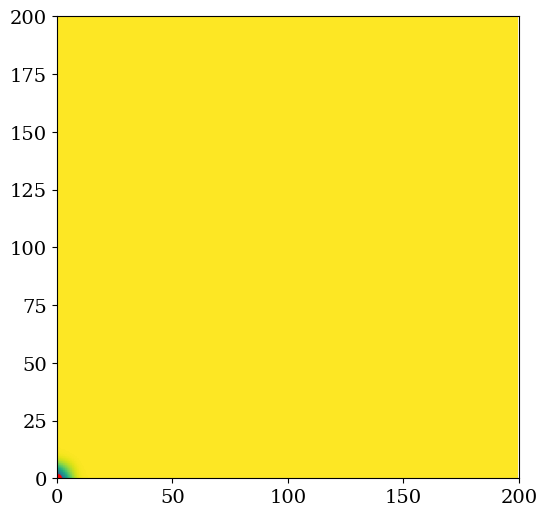

475


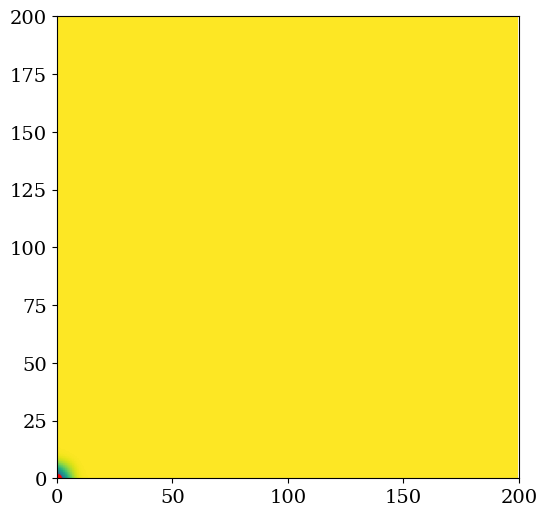

477


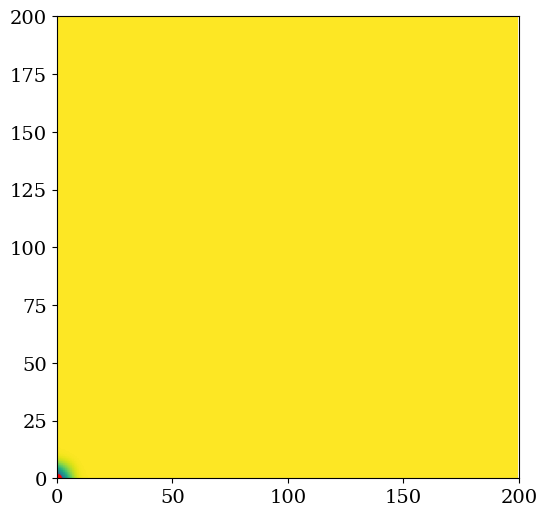

479


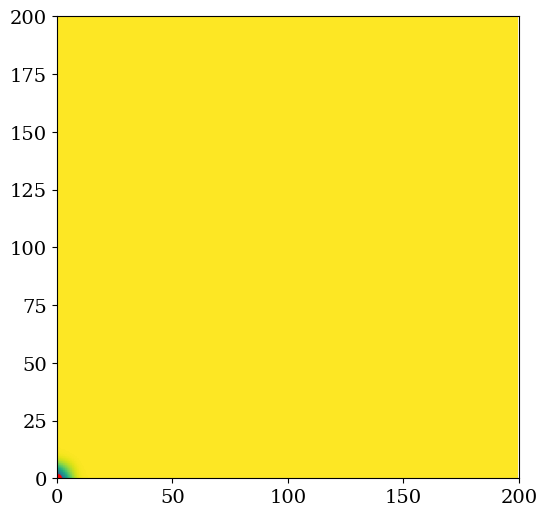

482


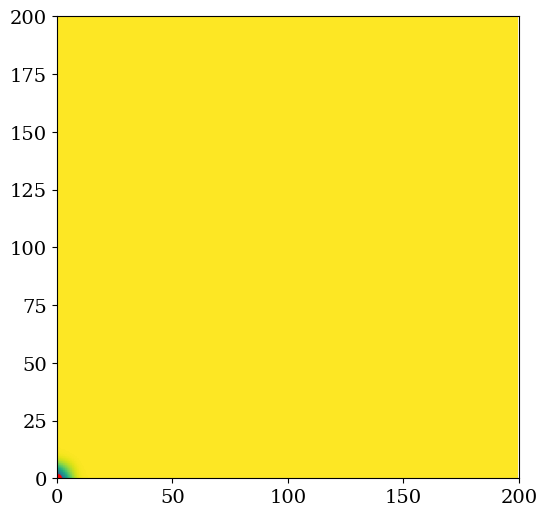

483


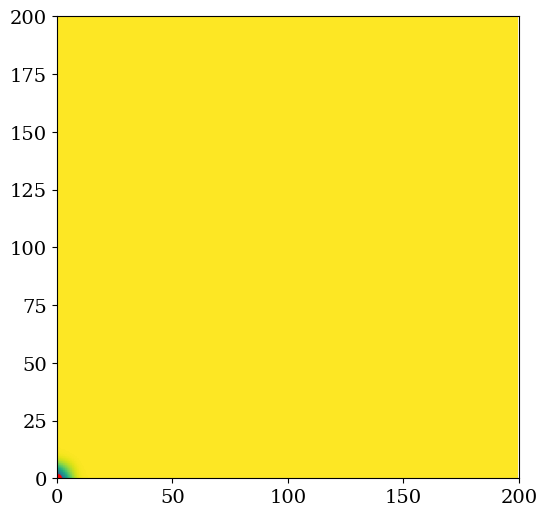

488


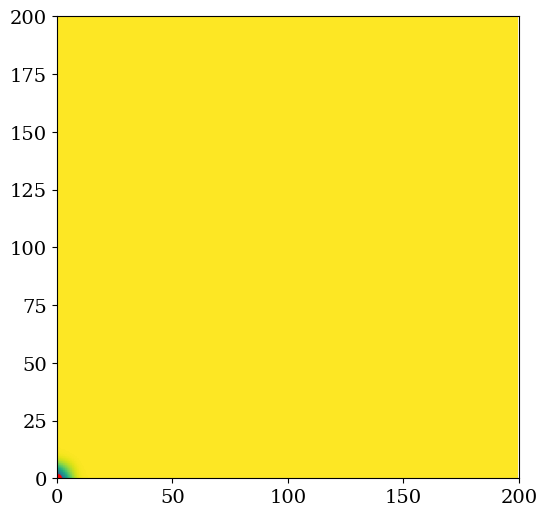

489


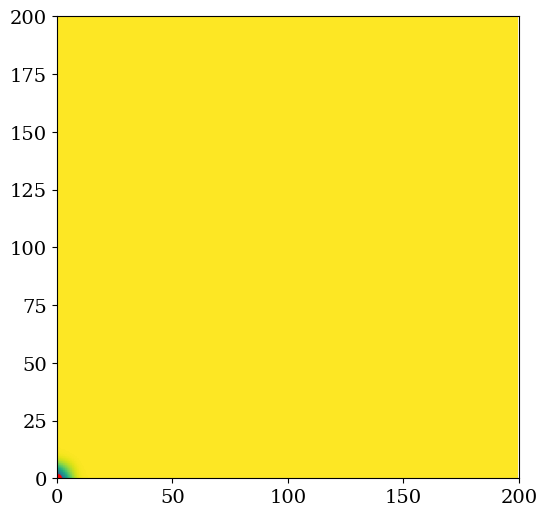

490


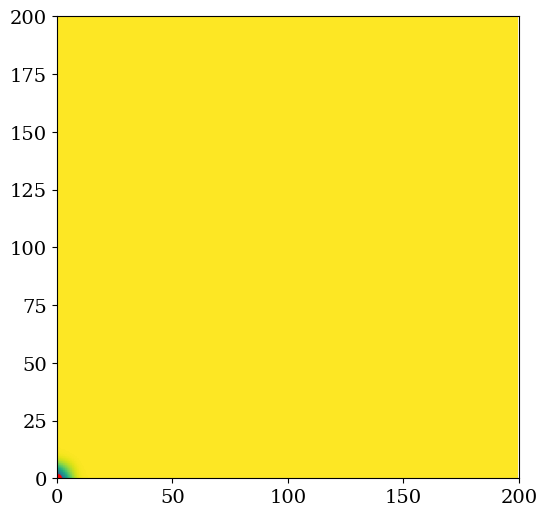

491


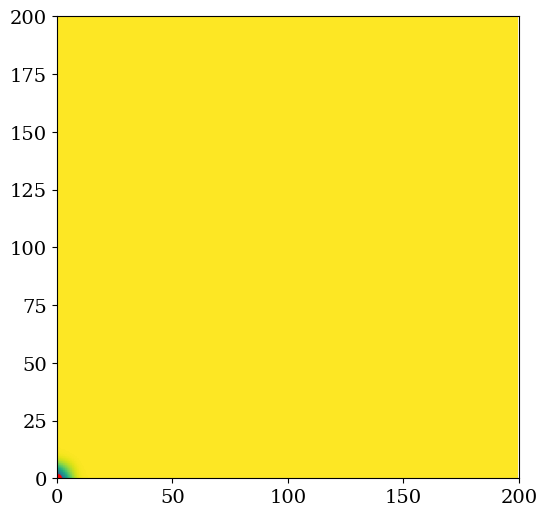

492


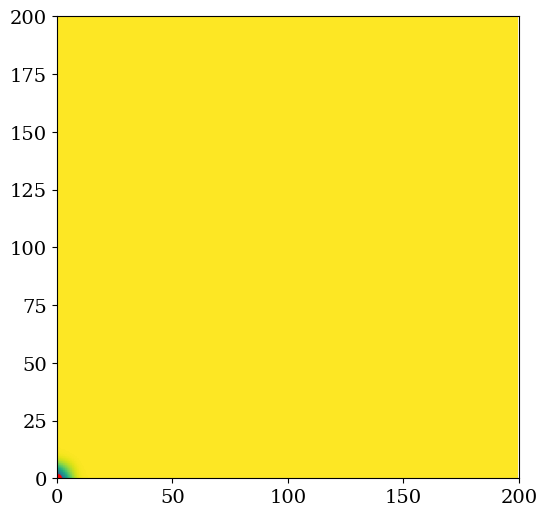

494


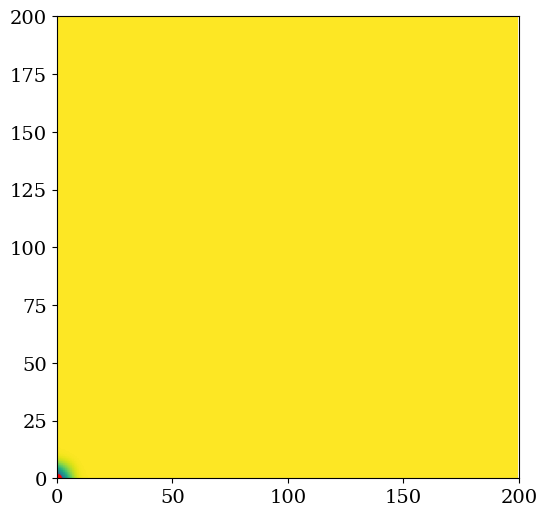

498


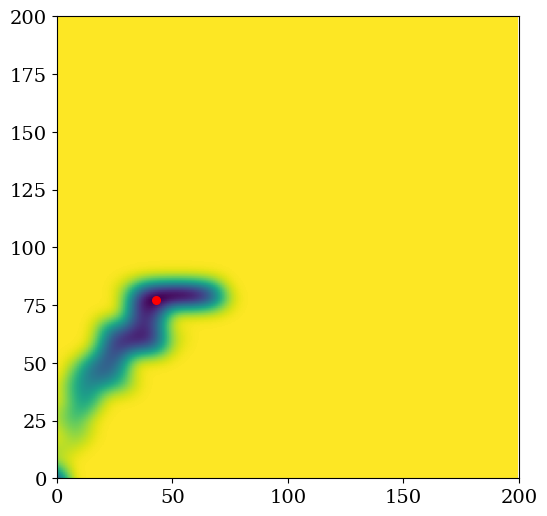

500


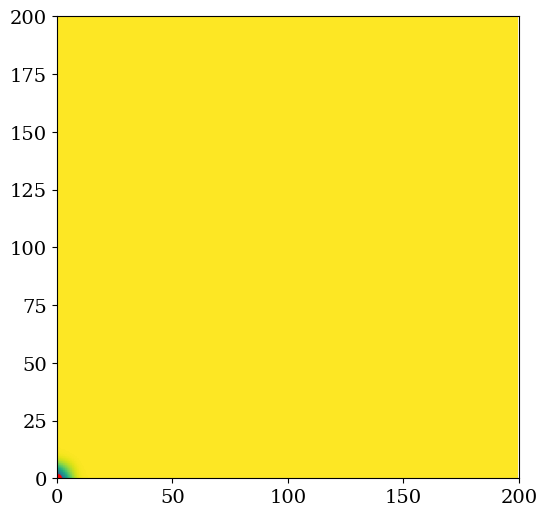

505


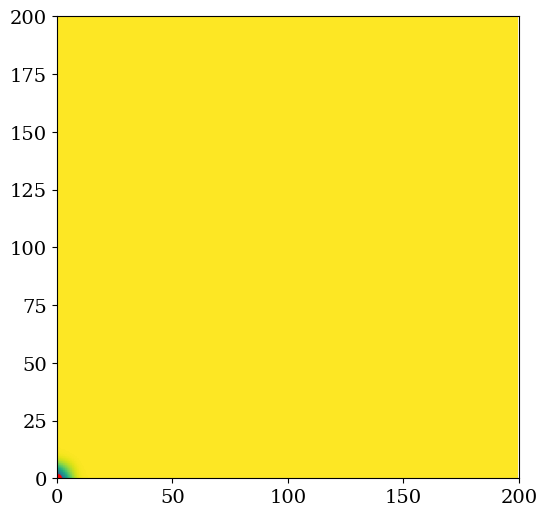

511


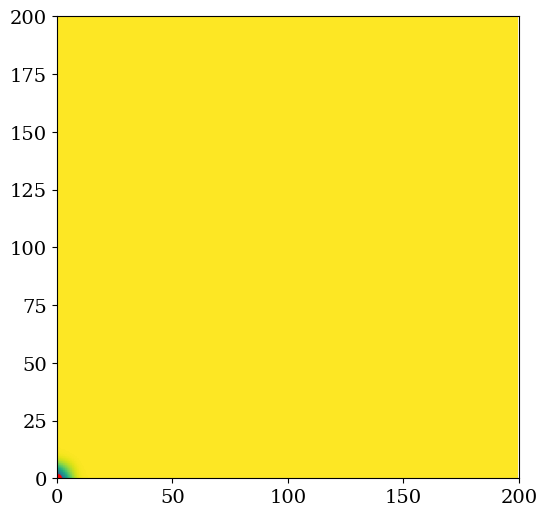

514


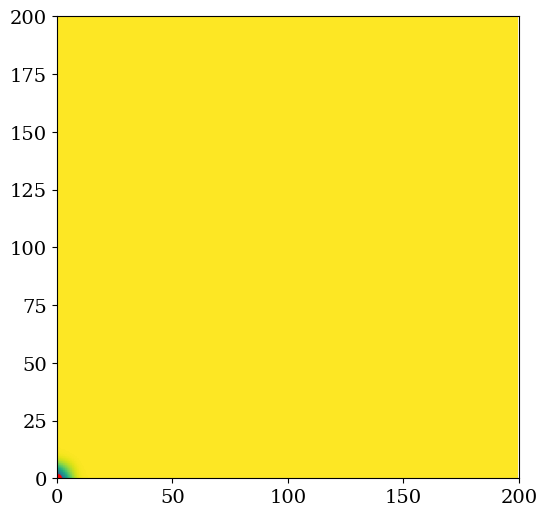

519


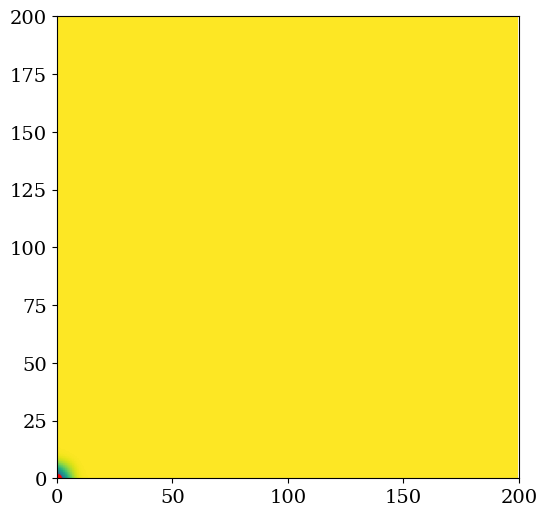

524


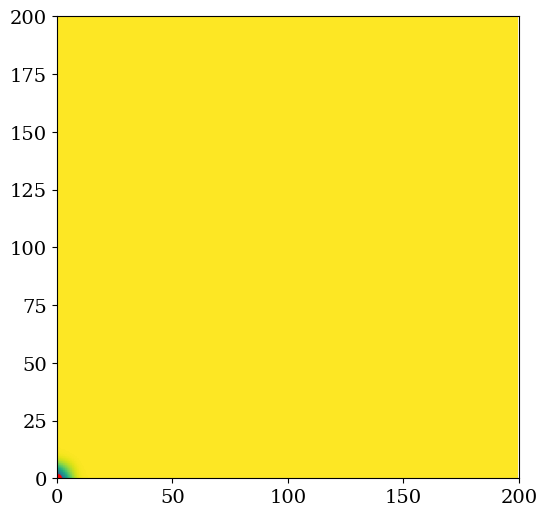

527


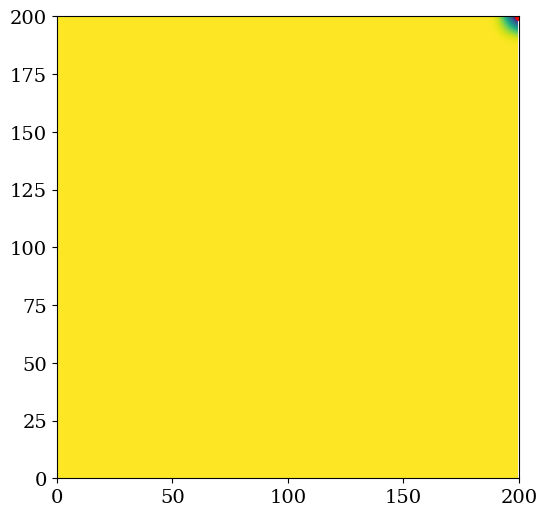

529


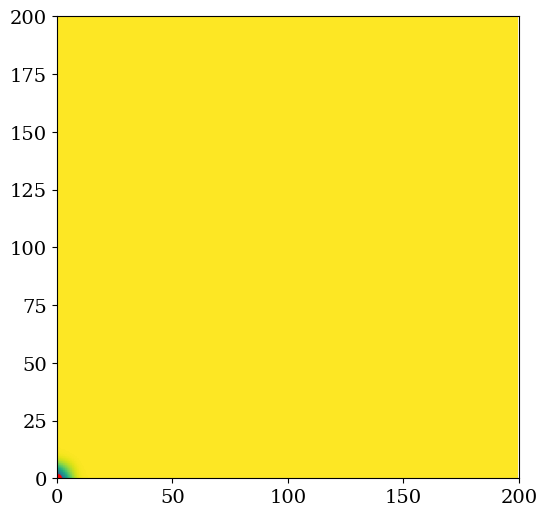

534


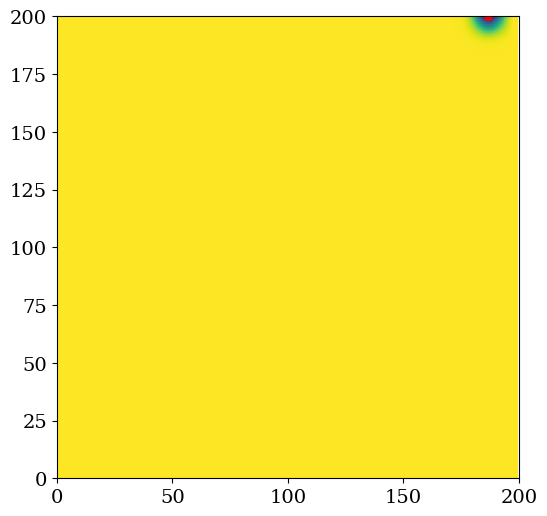

539


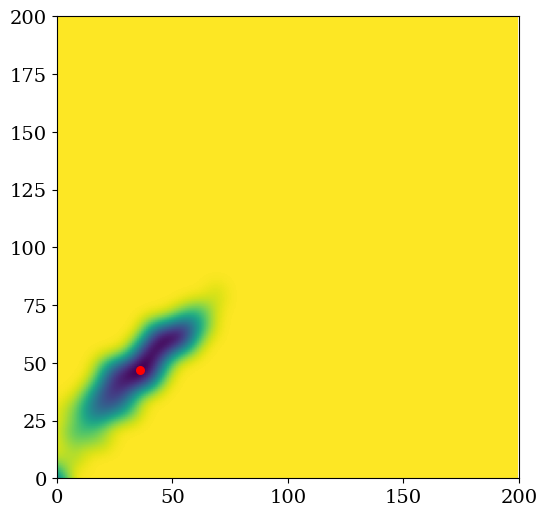

540


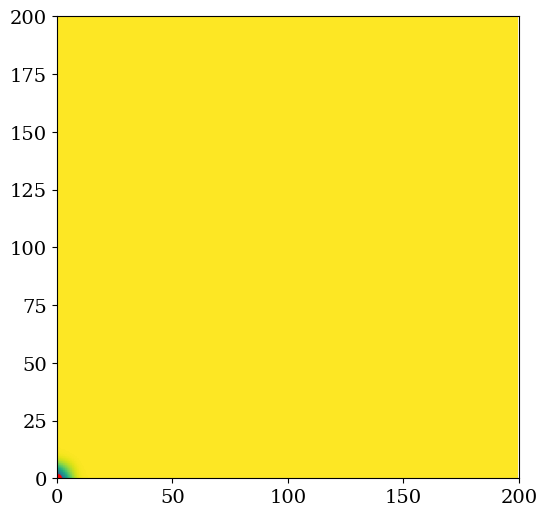

541


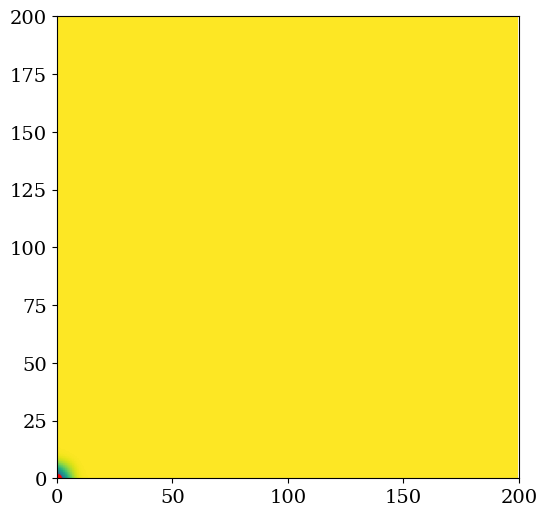

543


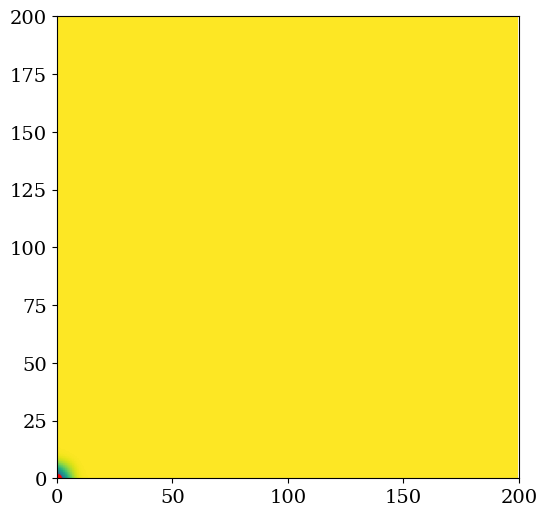

545


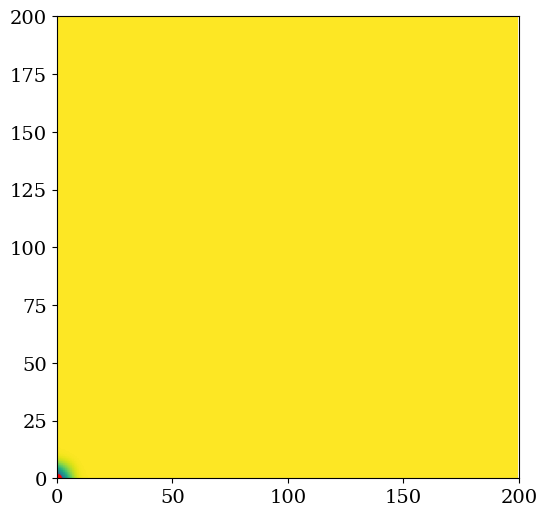

546


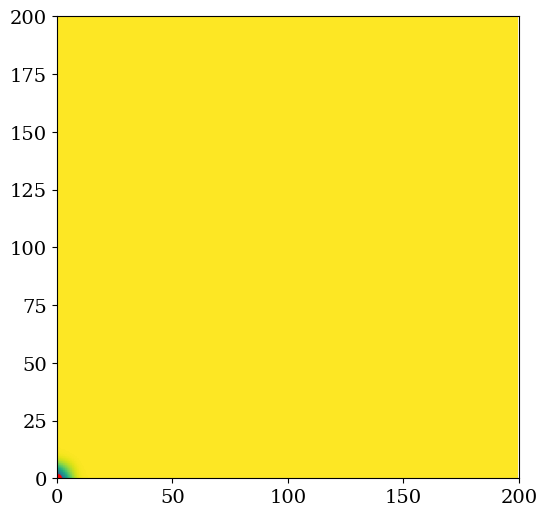

548


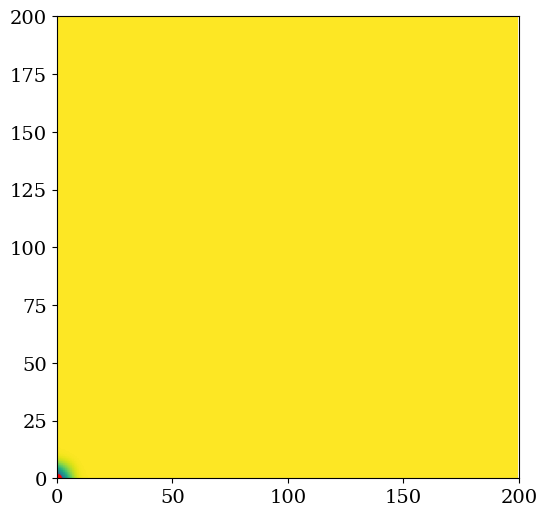

556


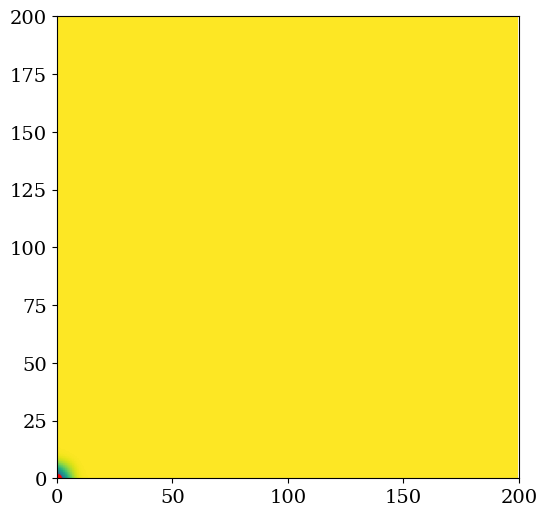

568


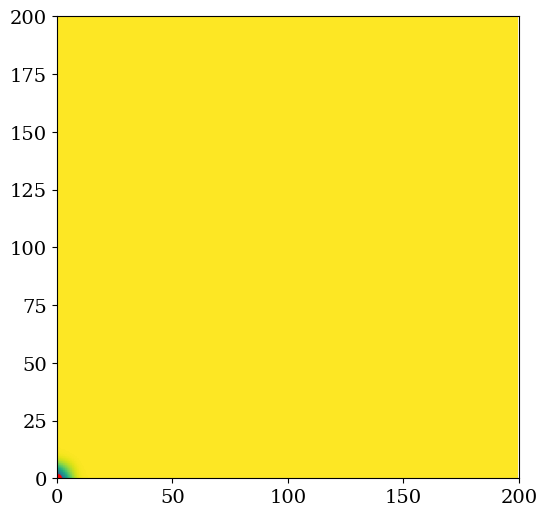

569


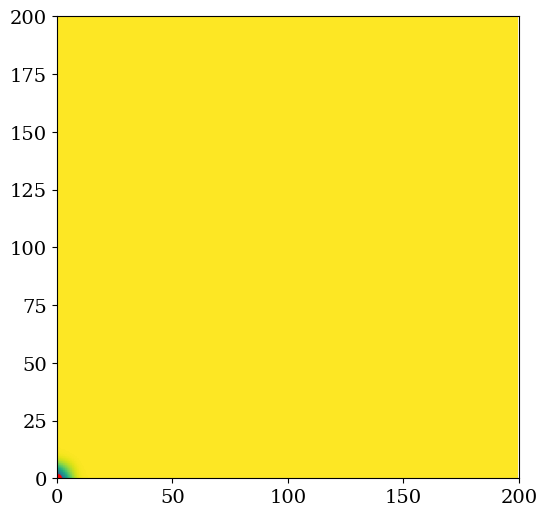

575


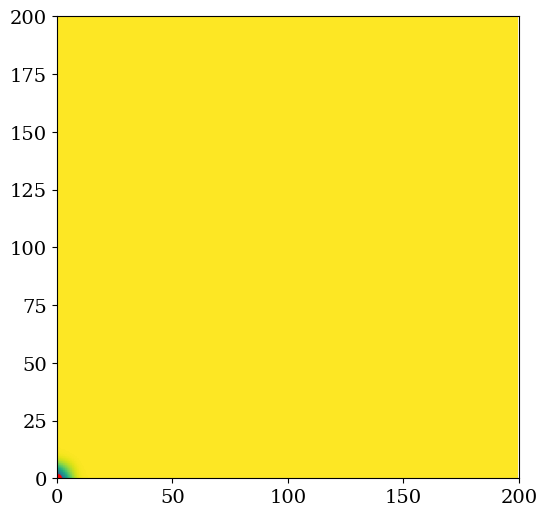

576


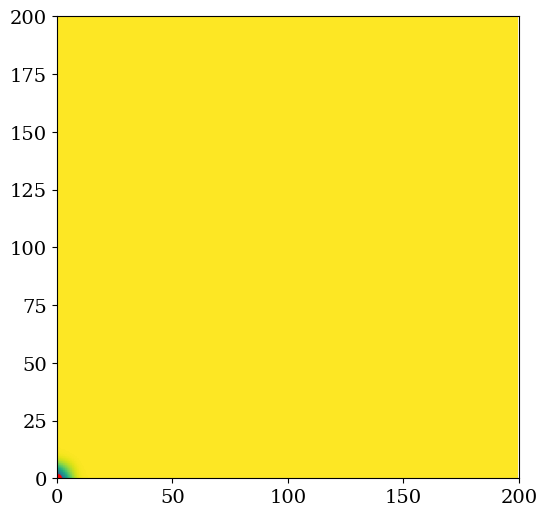

577


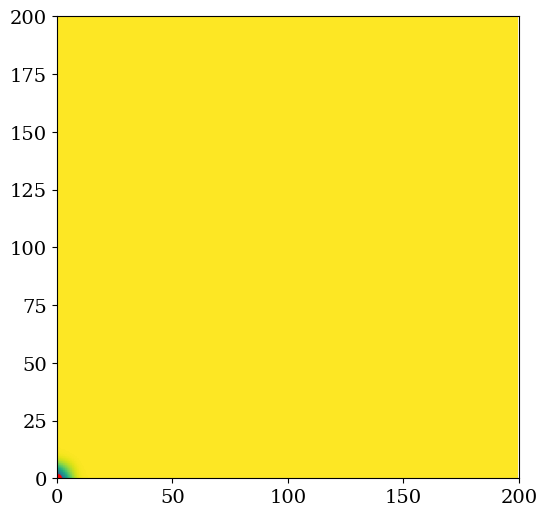

585


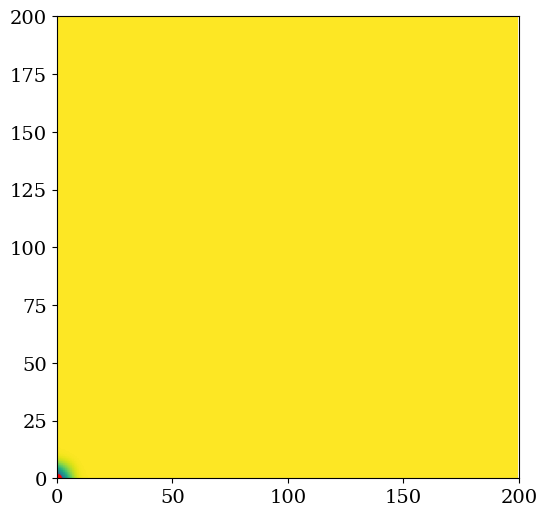

586


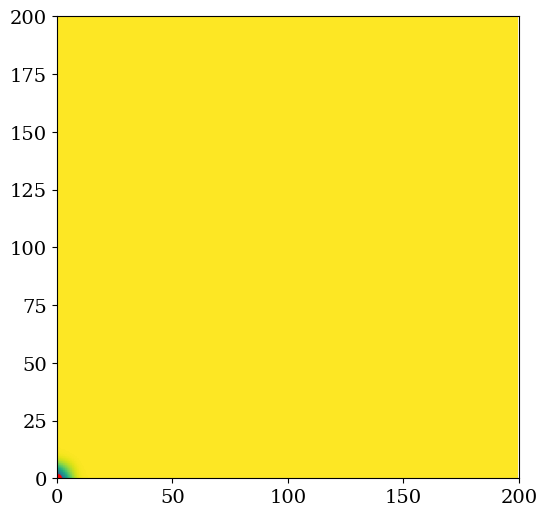

590


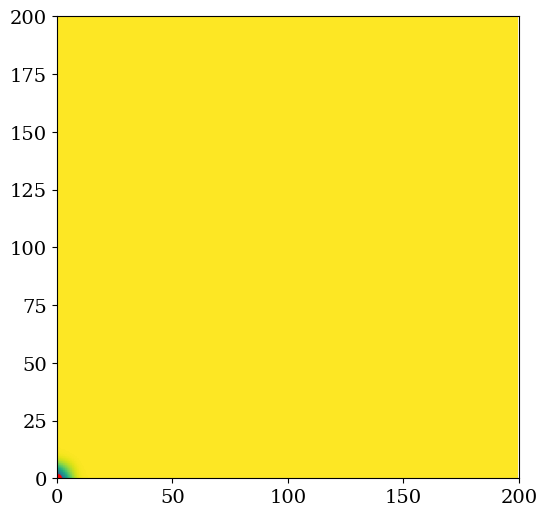

592


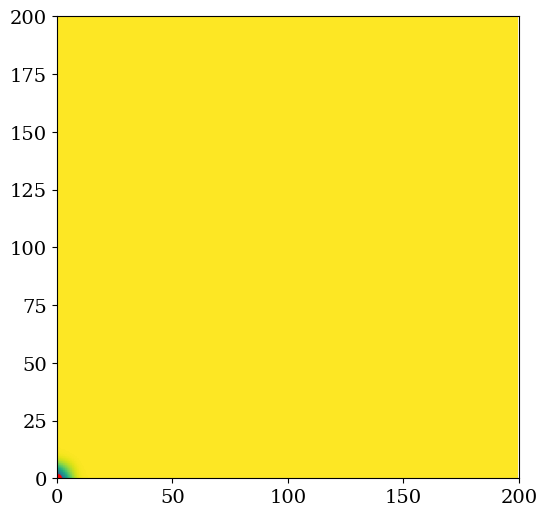

594


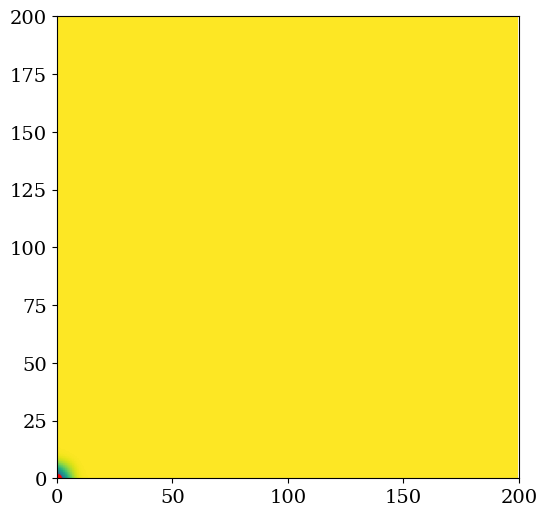

595


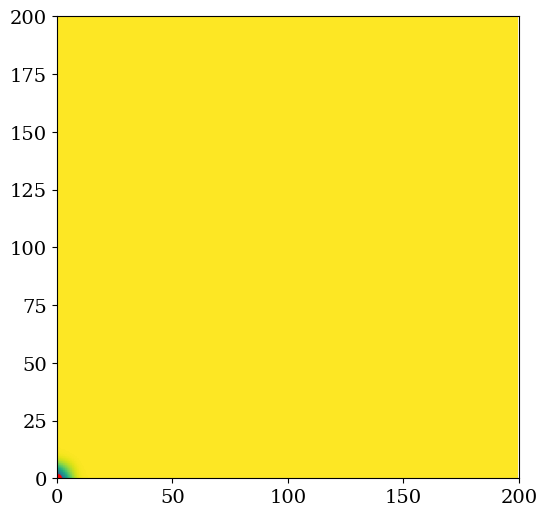

596


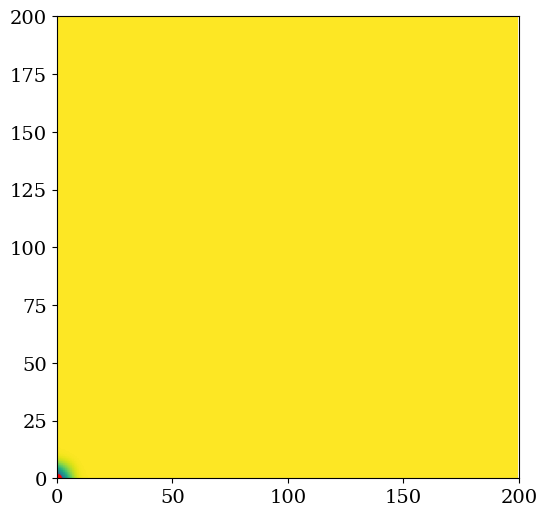

597


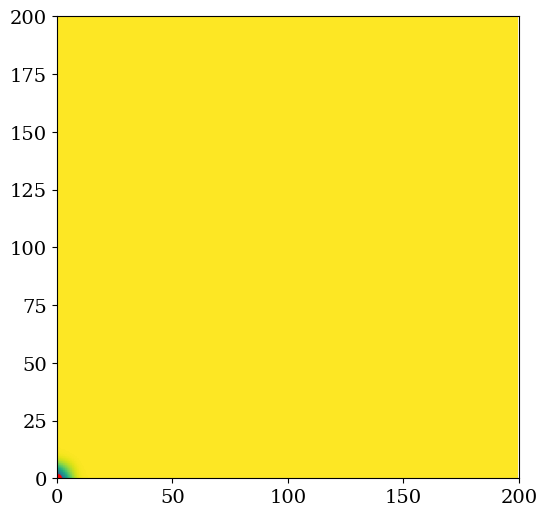

598


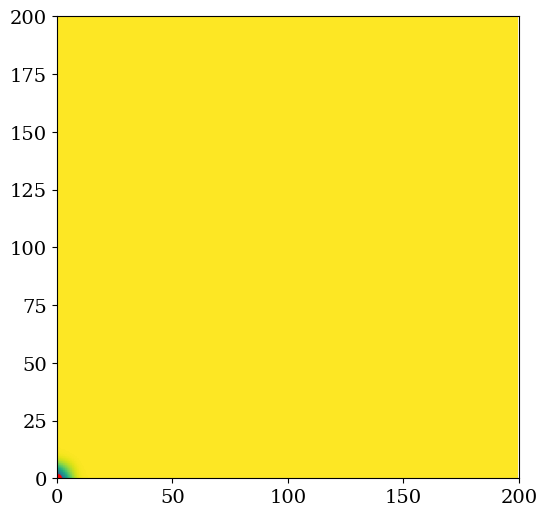

599


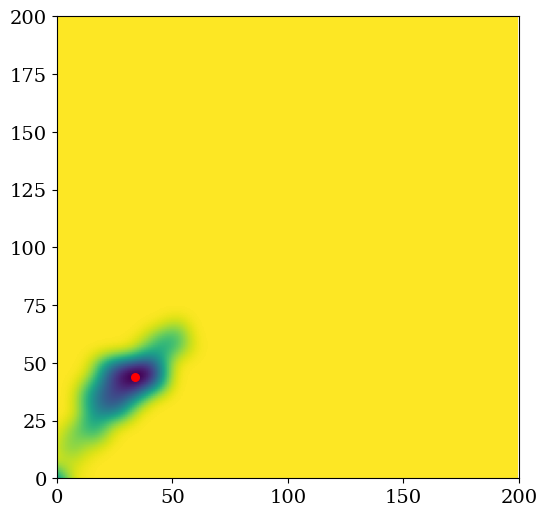

601


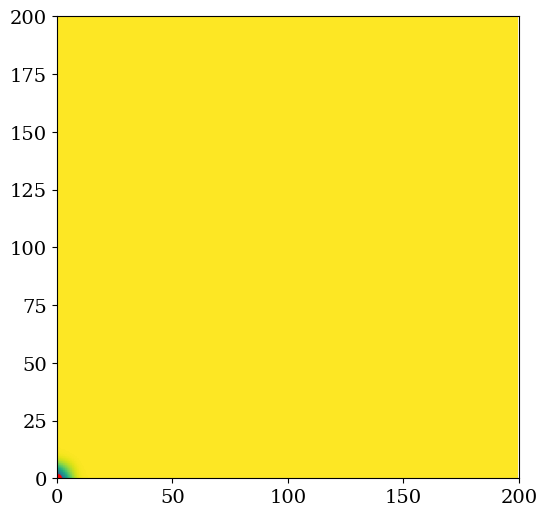

603


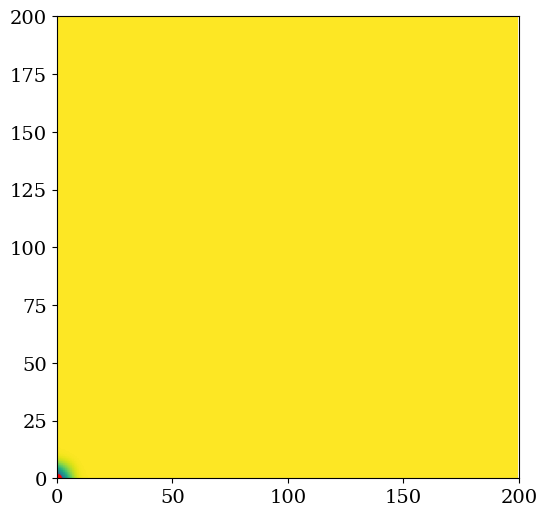

605


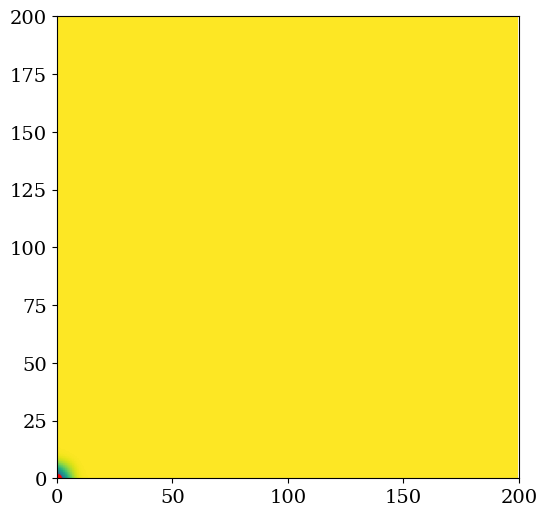

606


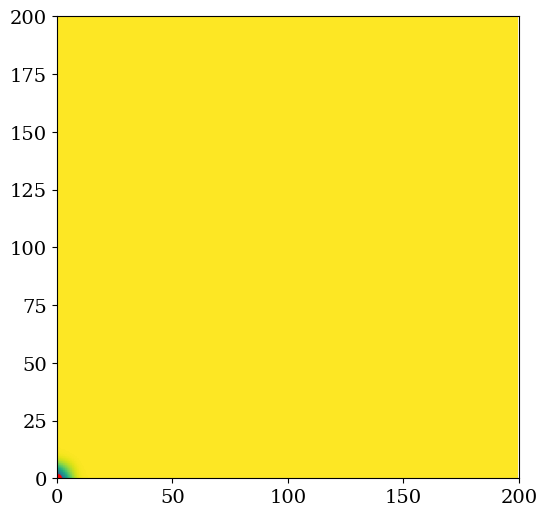

608


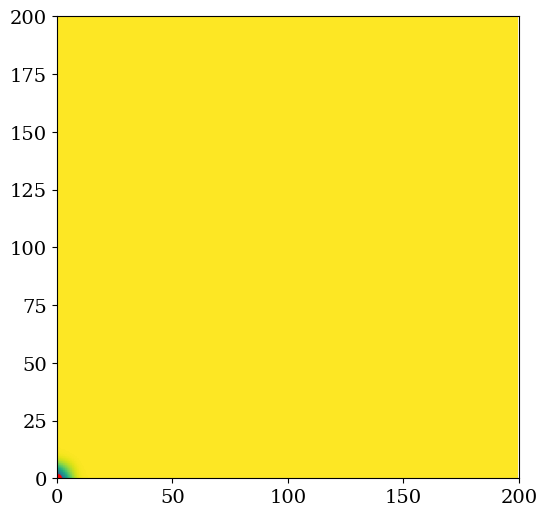

611


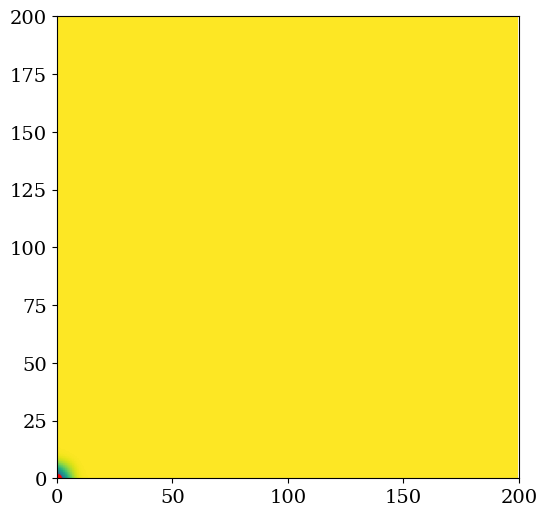

612


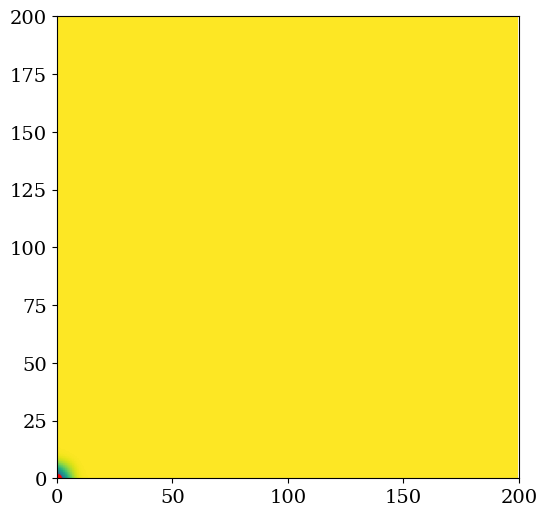

613


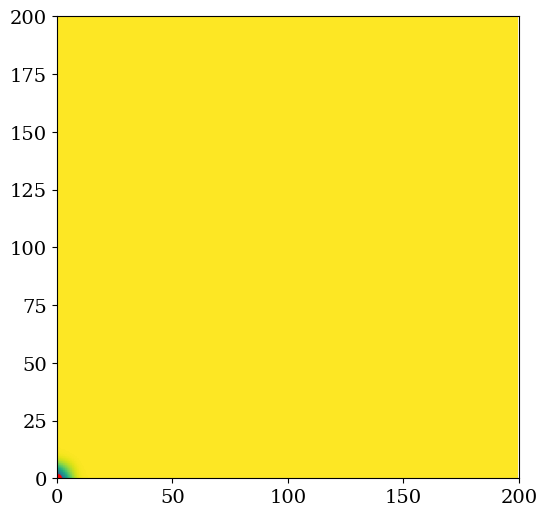

615


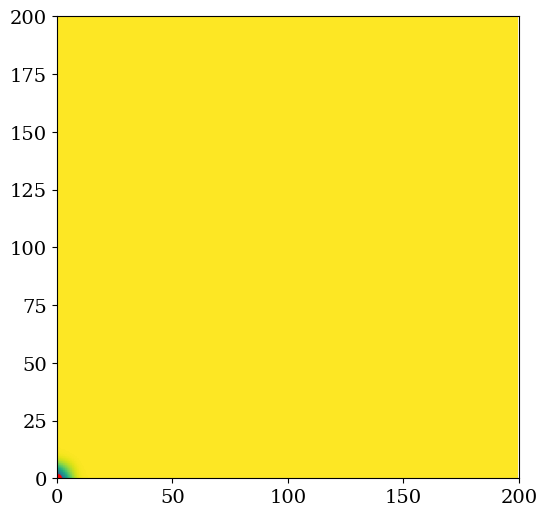

620


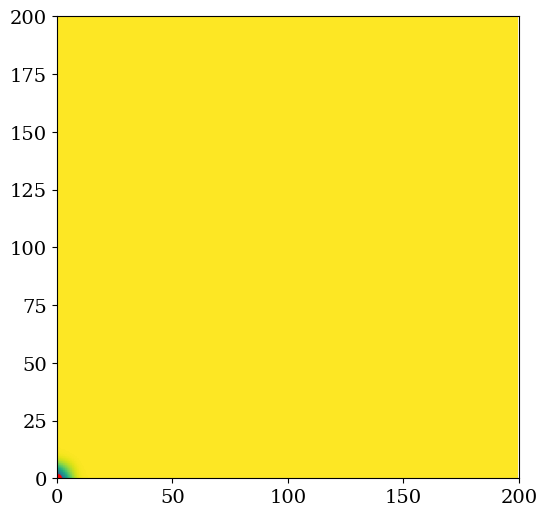

622


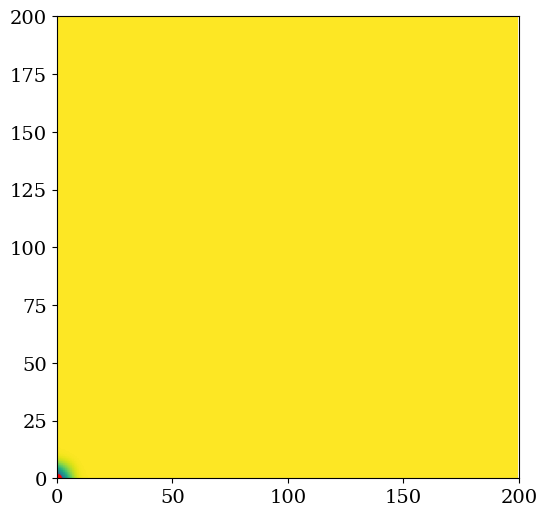

623


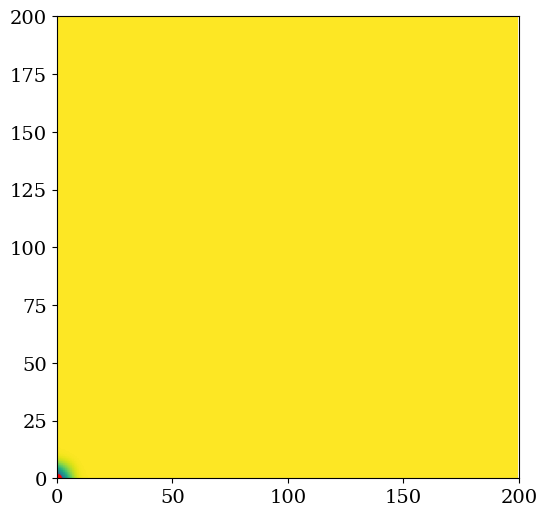

625


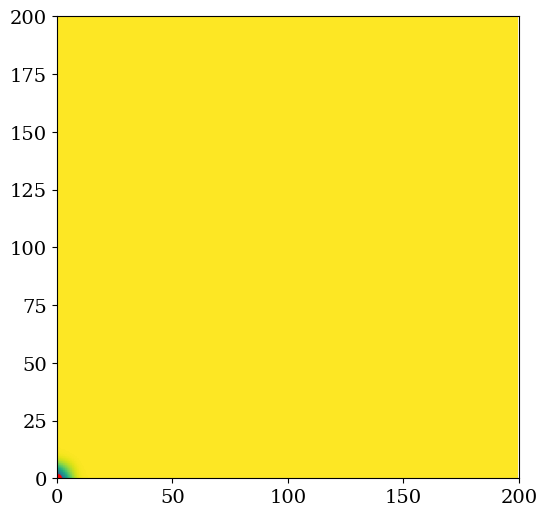

629


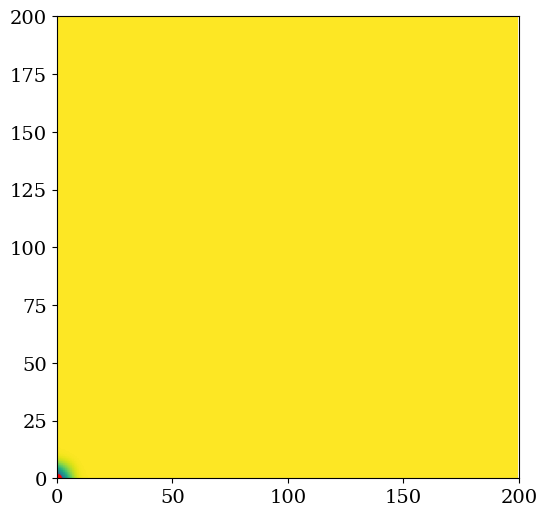

630


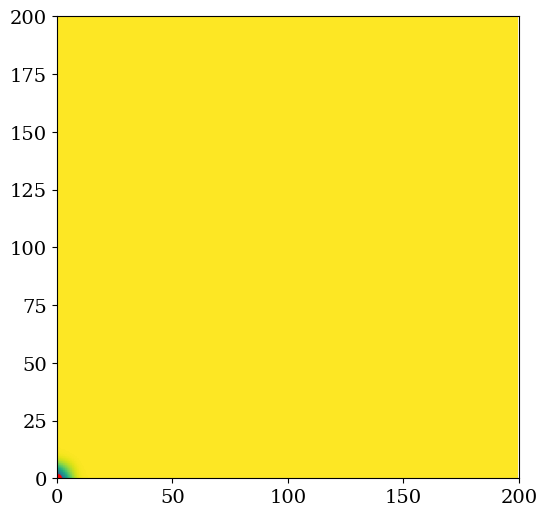

632


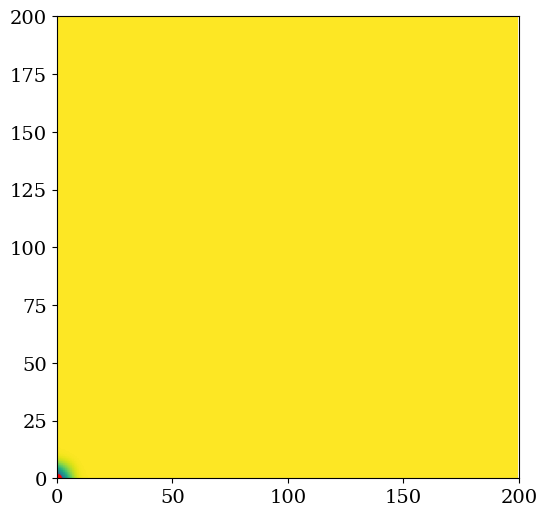

633


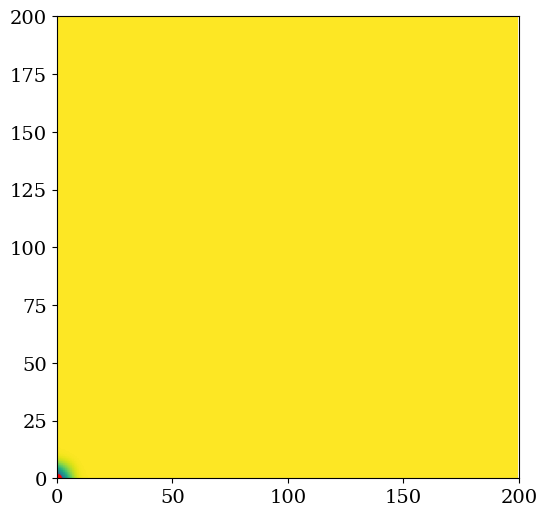

635


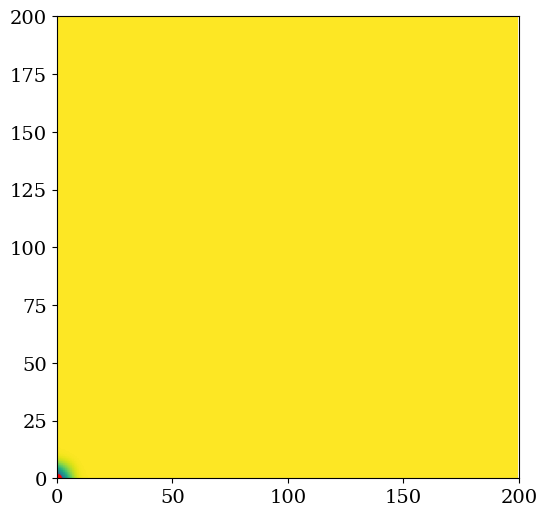

637


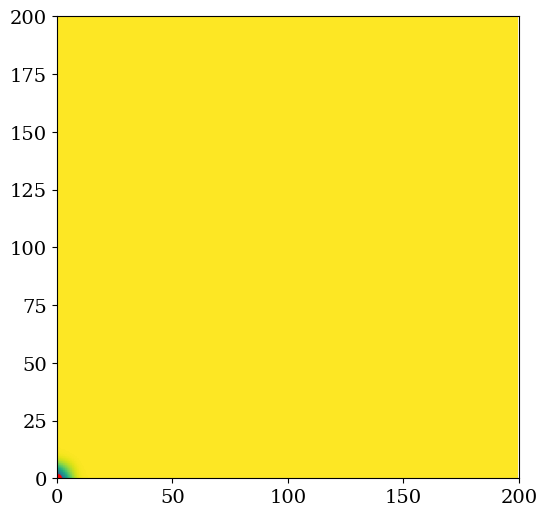

640


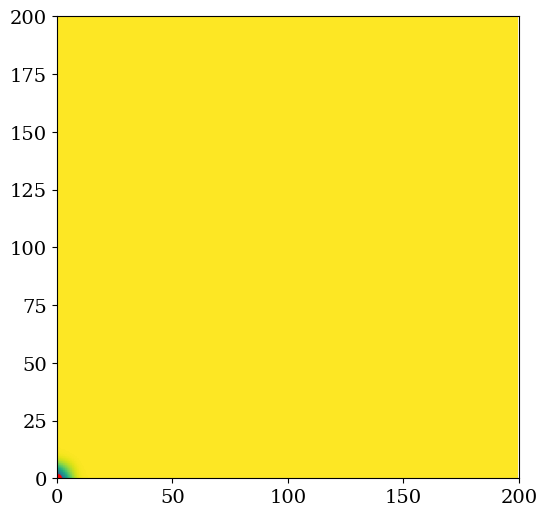

641


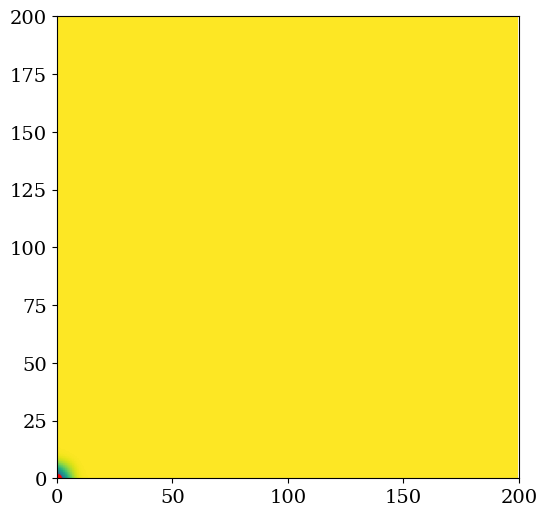

644


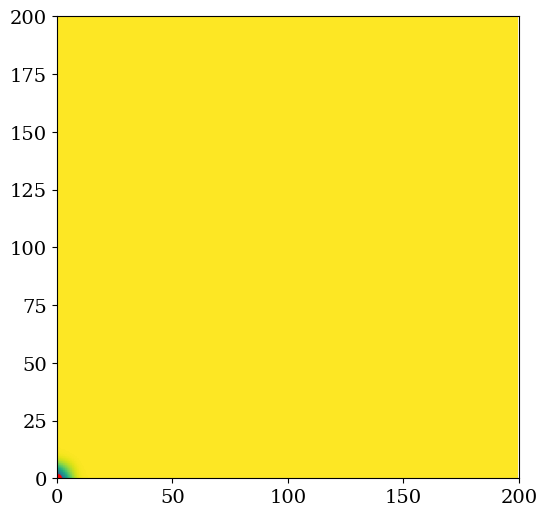

646


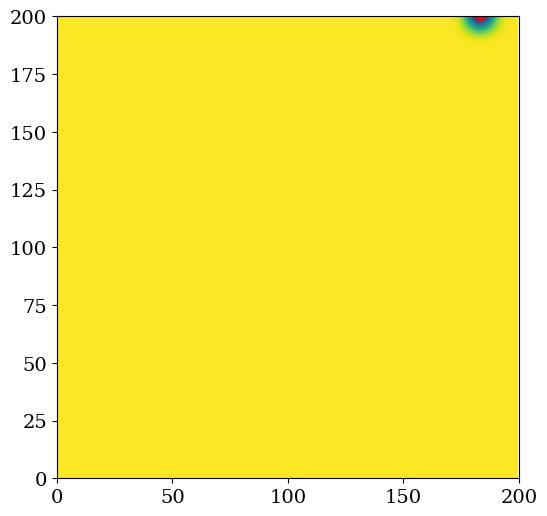

649


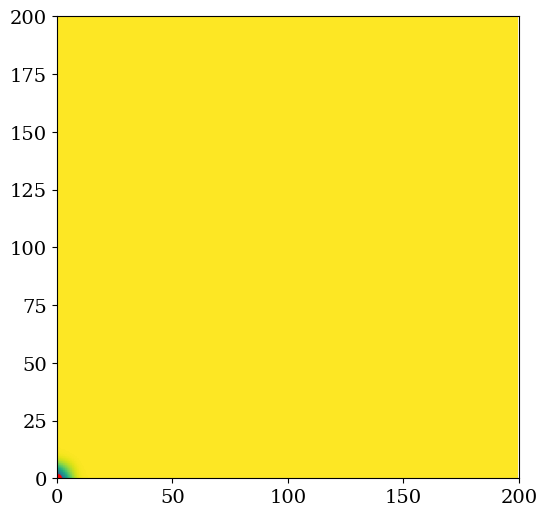

651


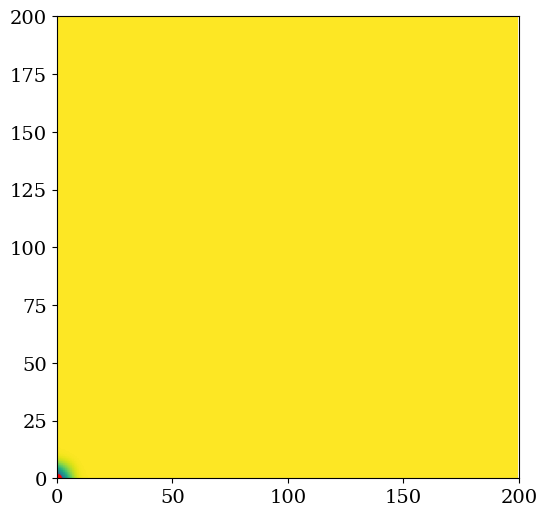

652


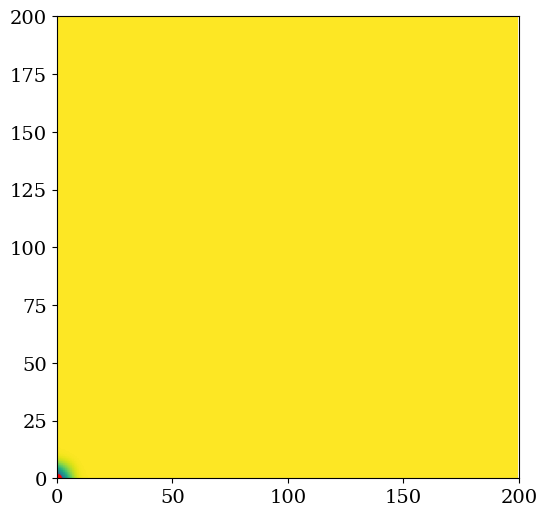

655


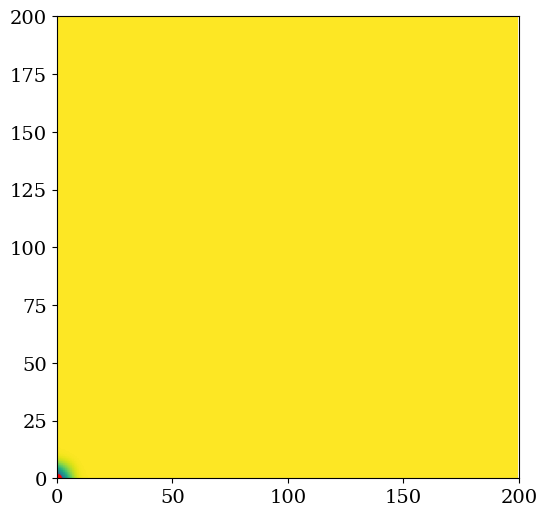

657


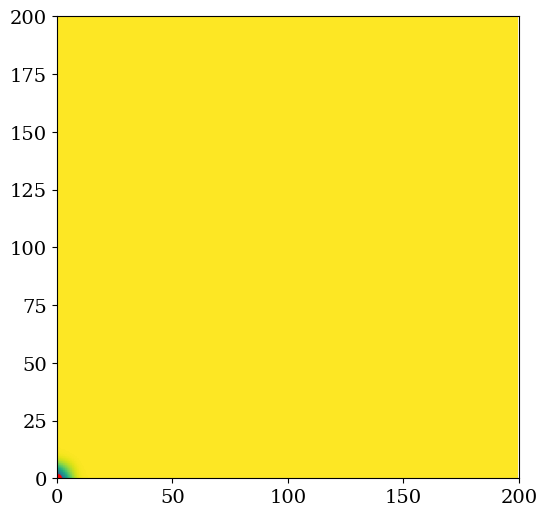

661


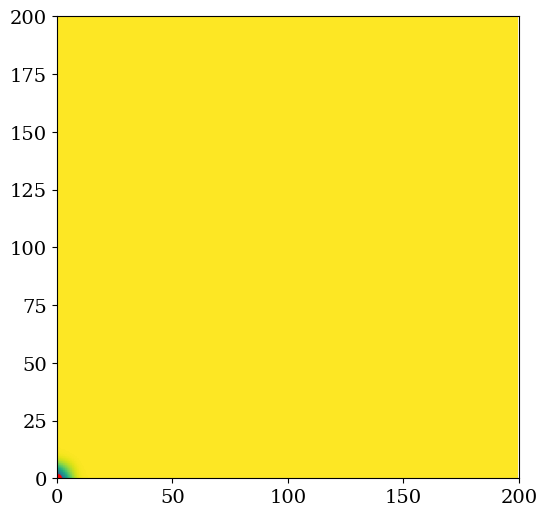

662


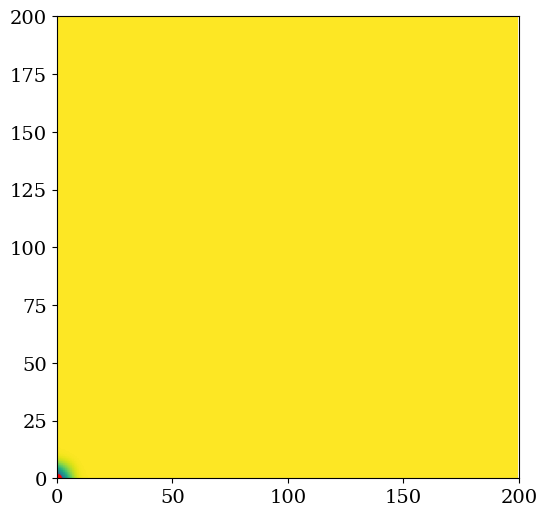

663


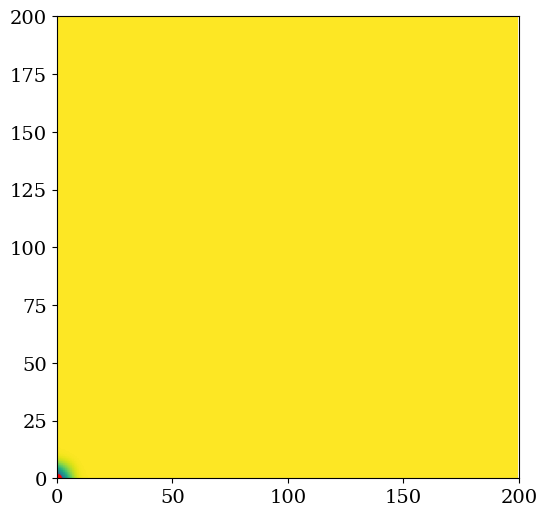

664


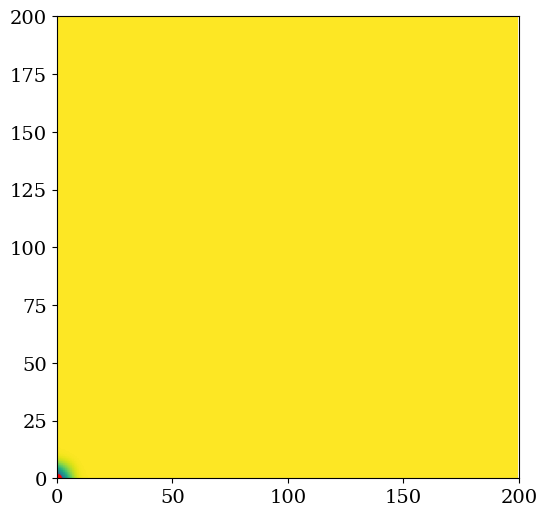

666


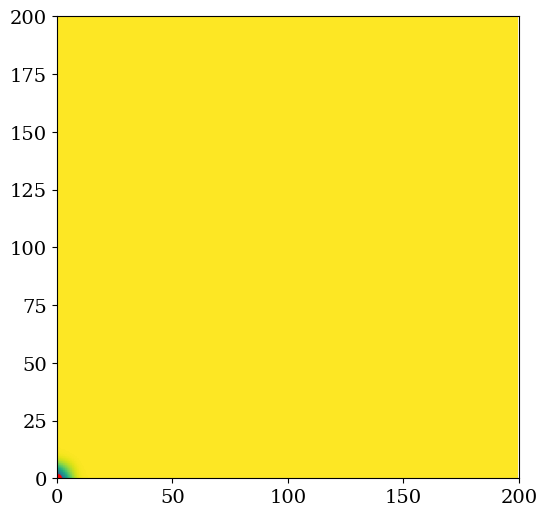

667


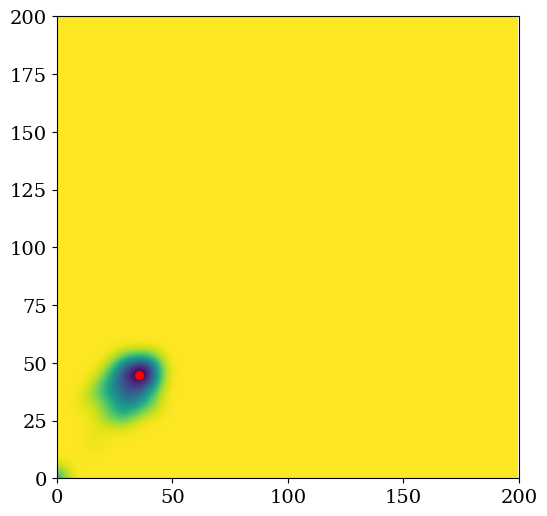

668


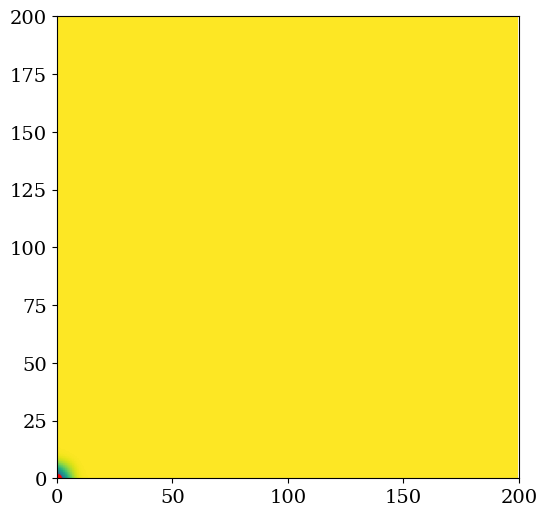

670


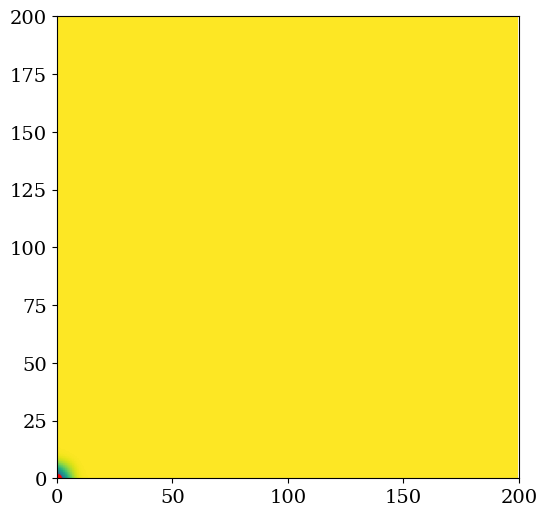

674


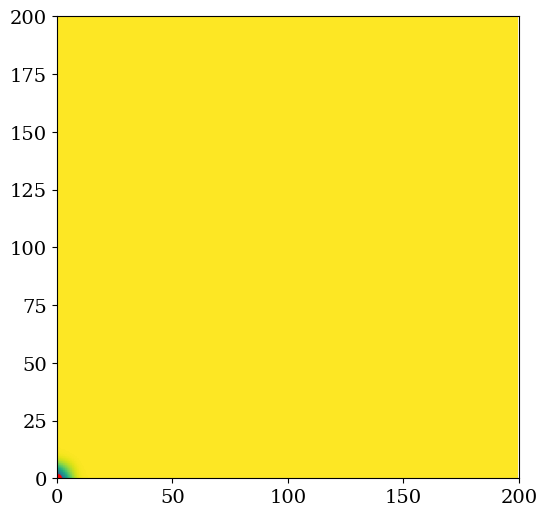

676


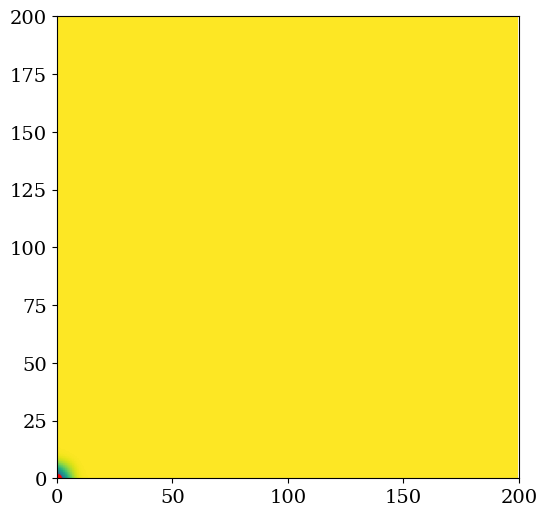

678


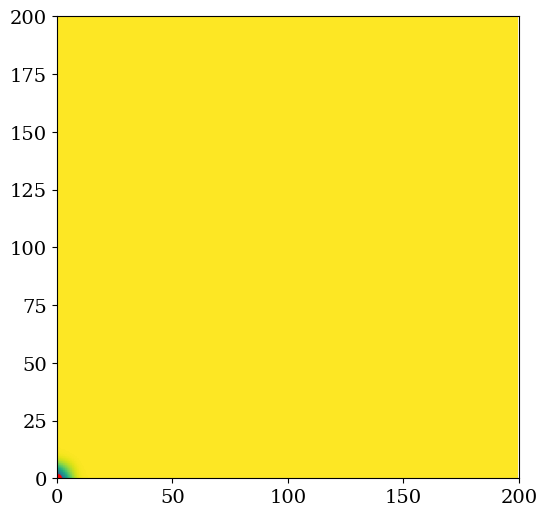

679


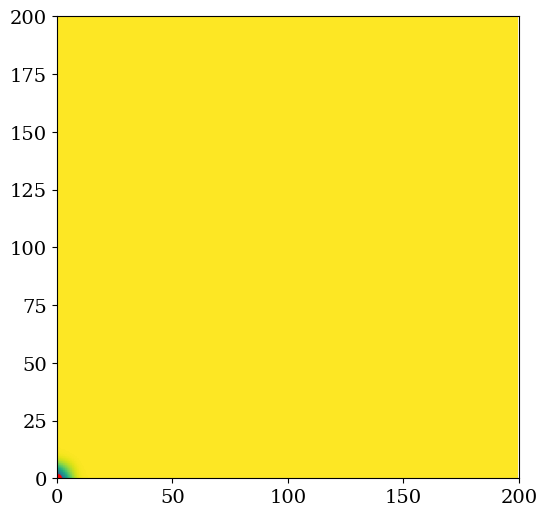

680


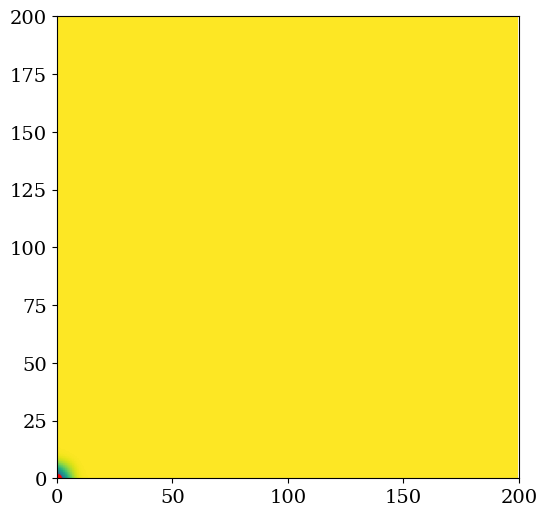

682


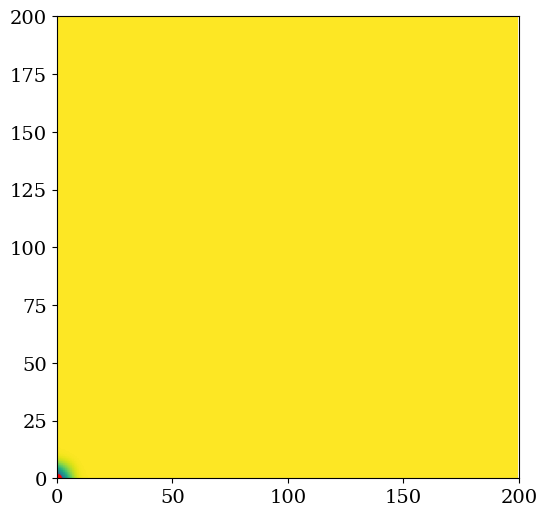

685


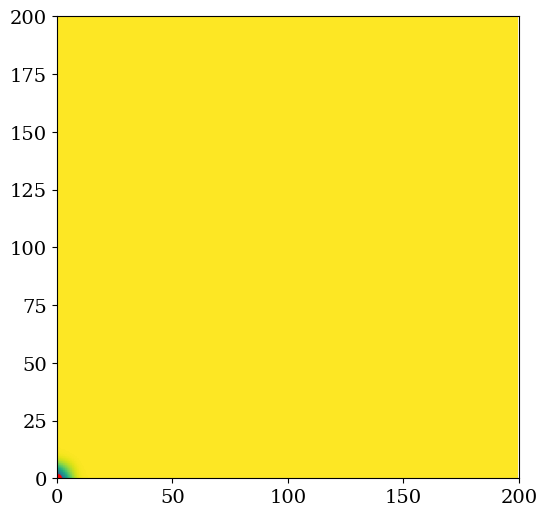

687


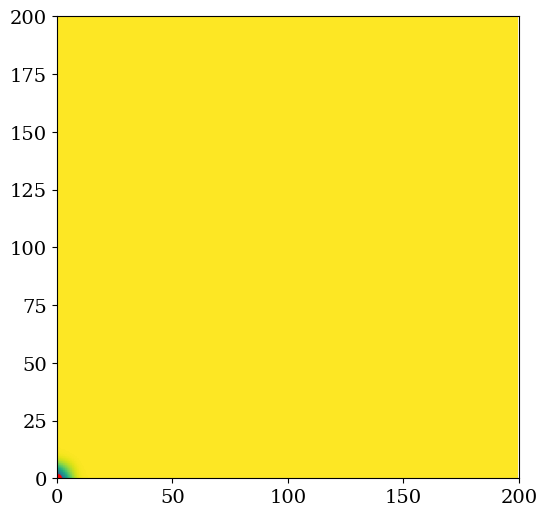

689


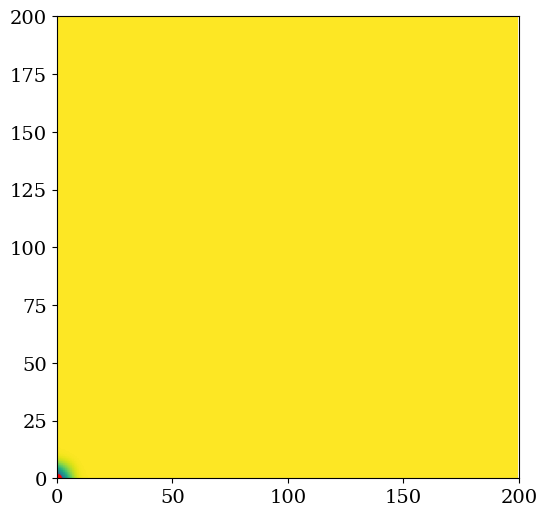

691


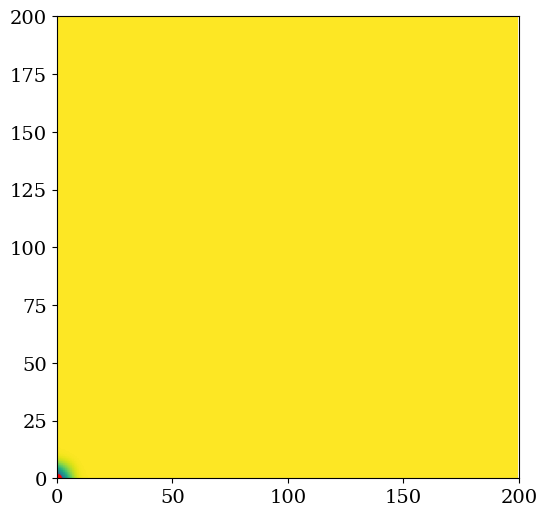

692


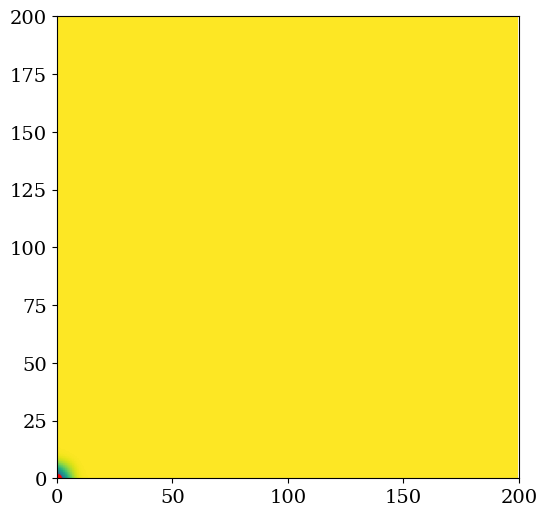

694


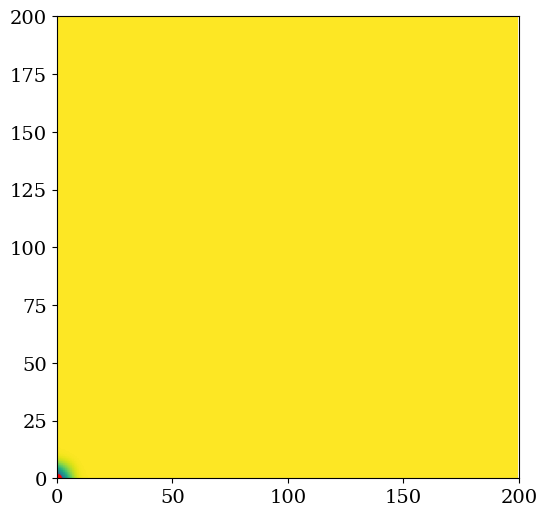

696


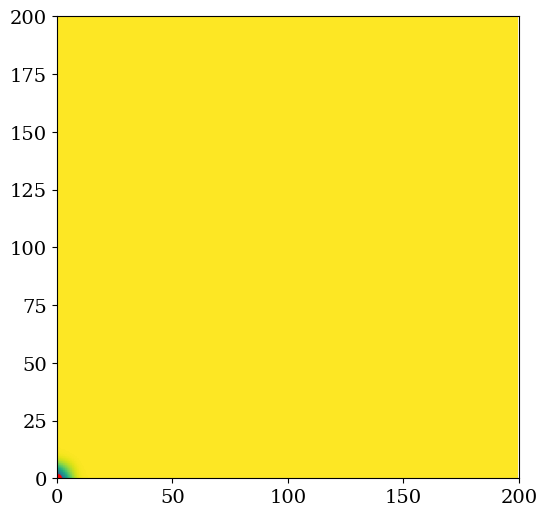

698


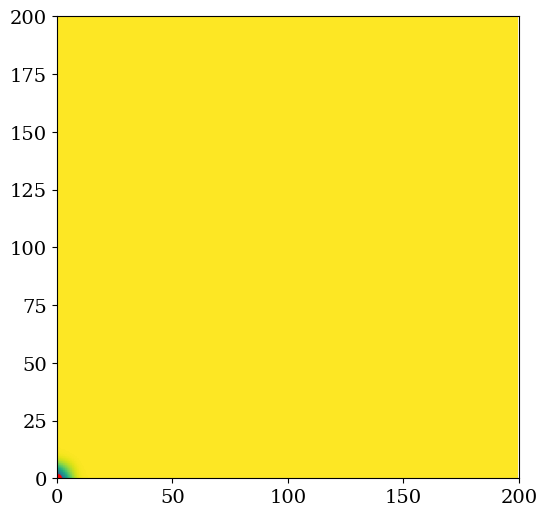

699


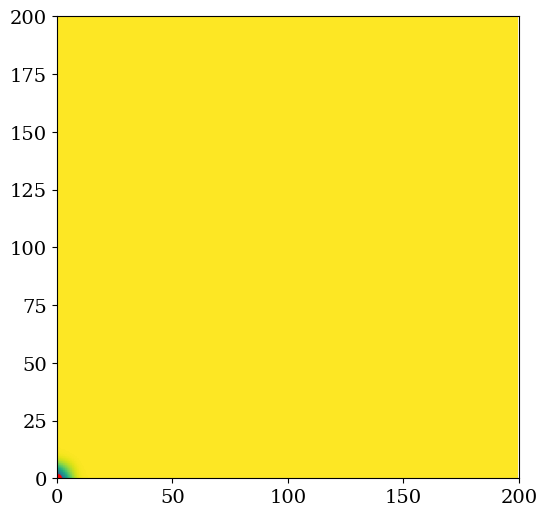

702


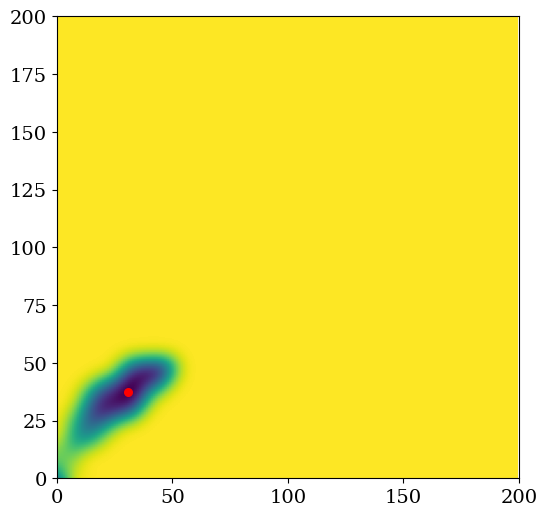

703


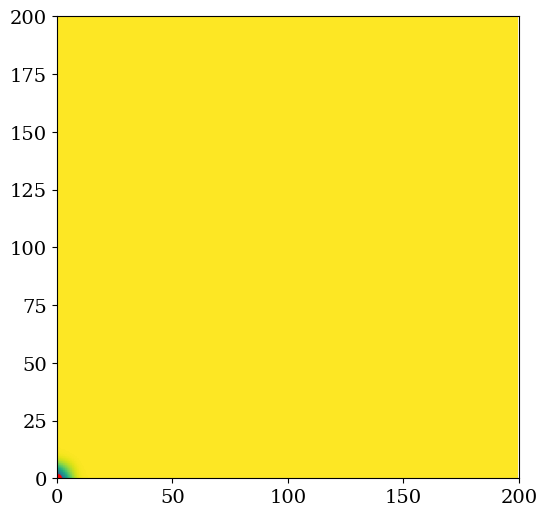

704


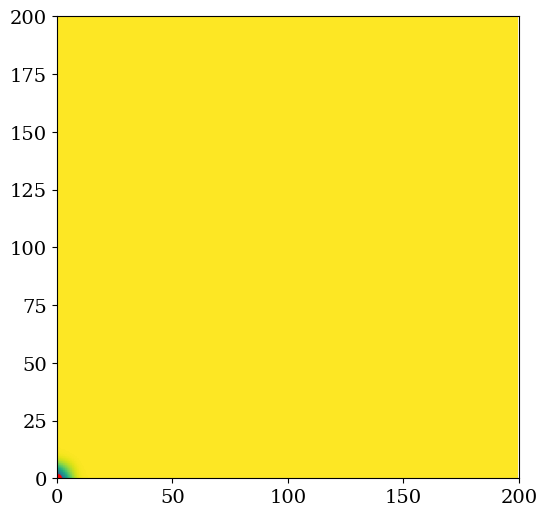

706


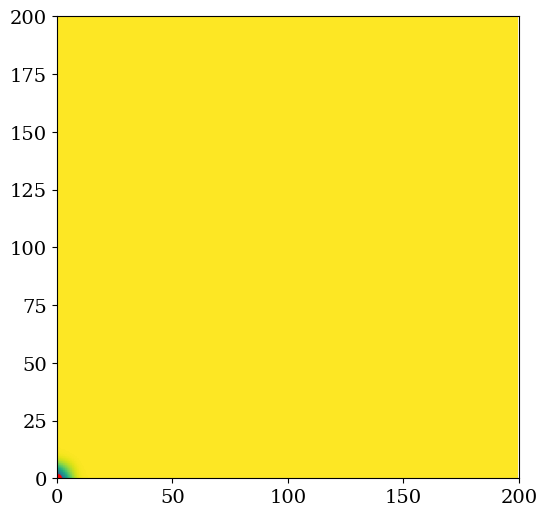

707


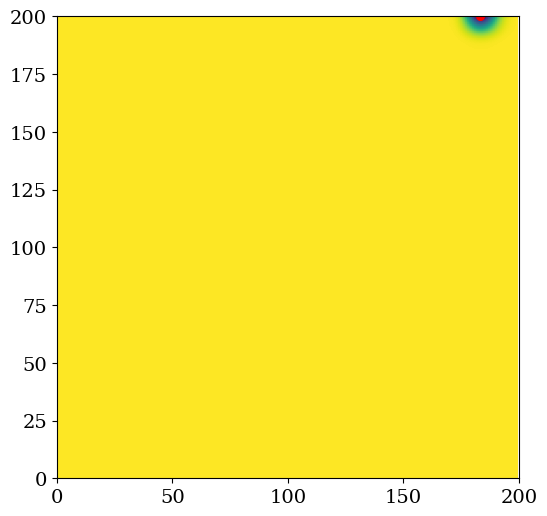

708


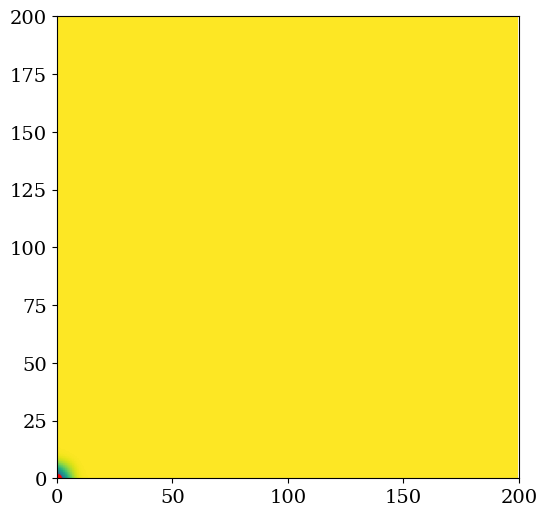

709


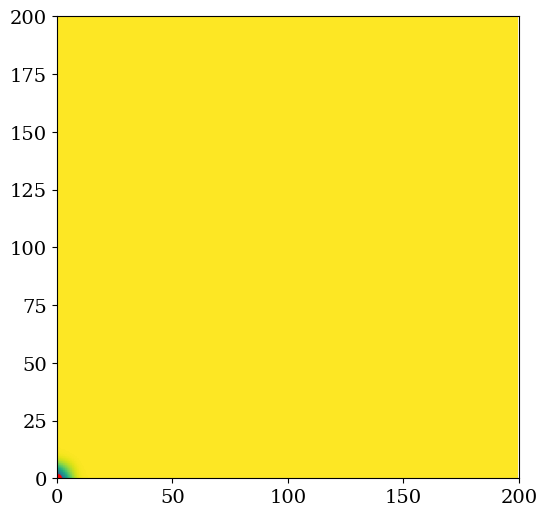

716


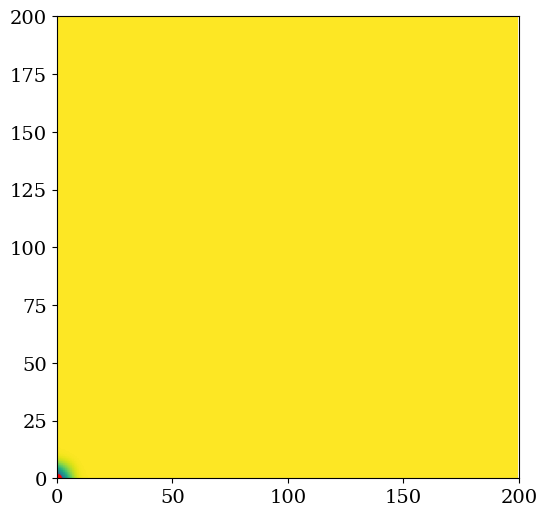

720


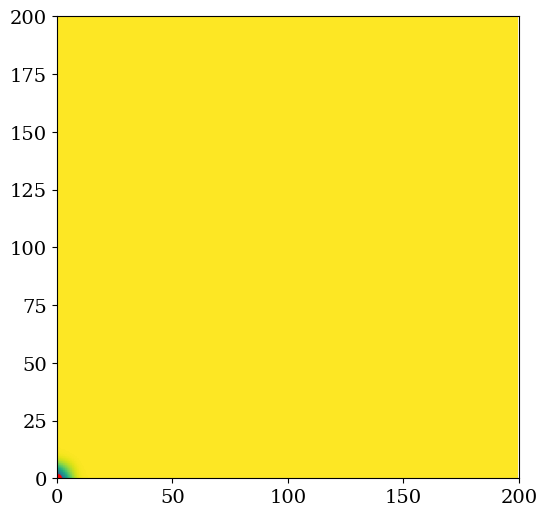

721


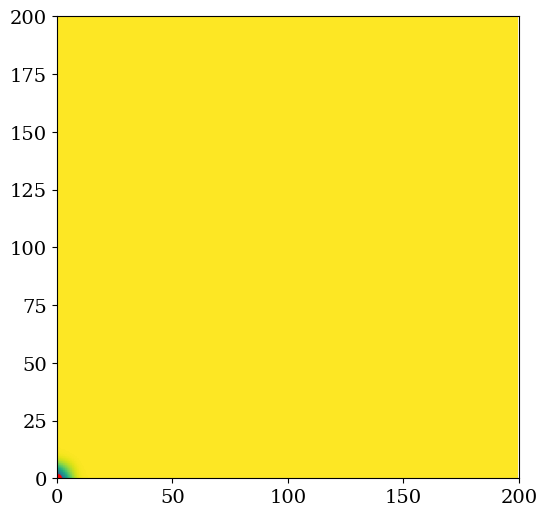

722


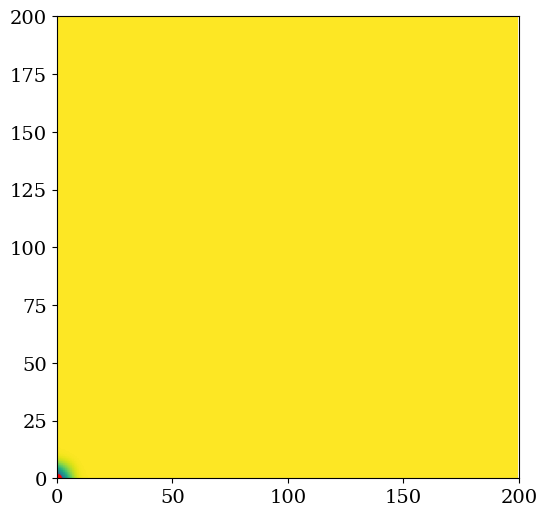

725


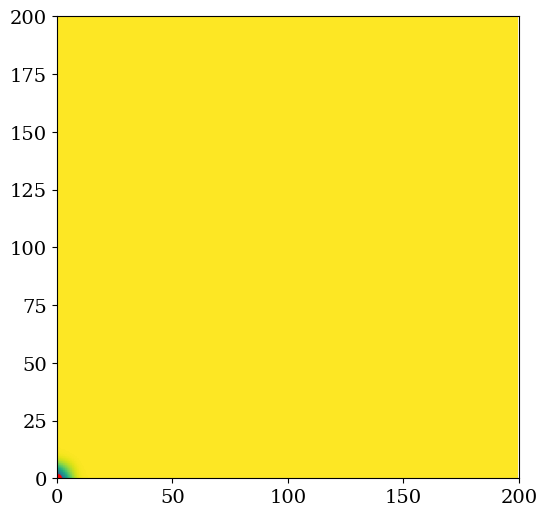

727


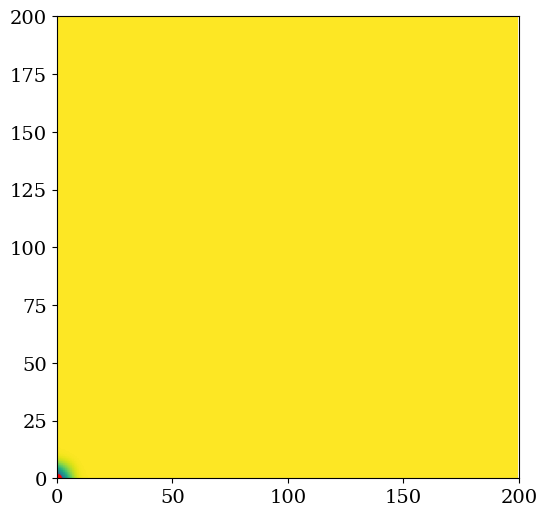

730


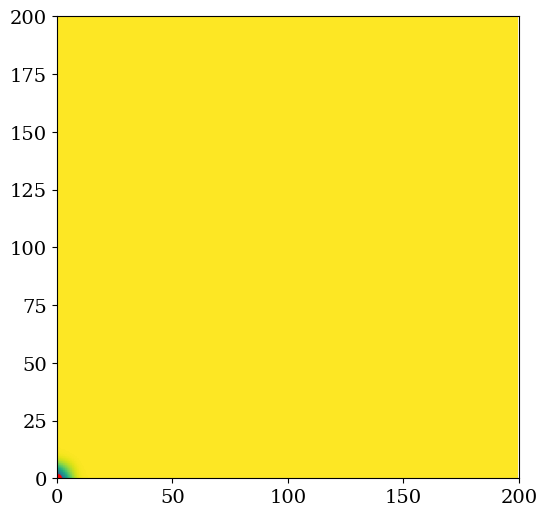

734


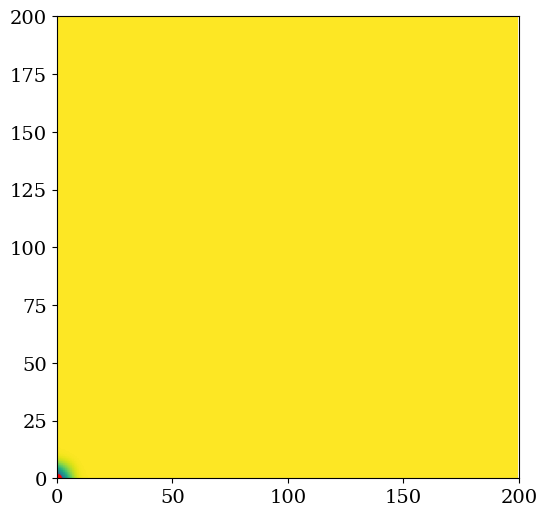

737


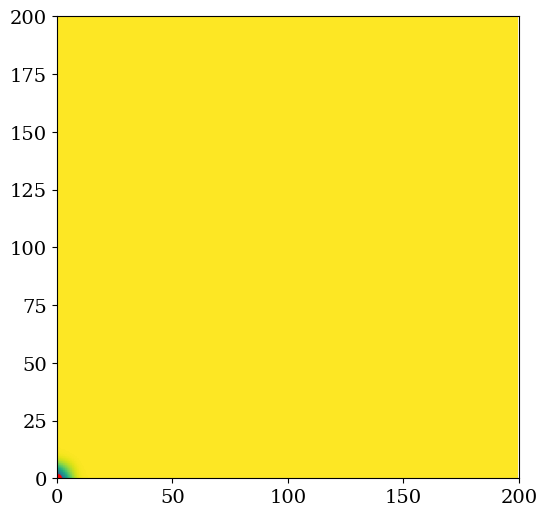

739


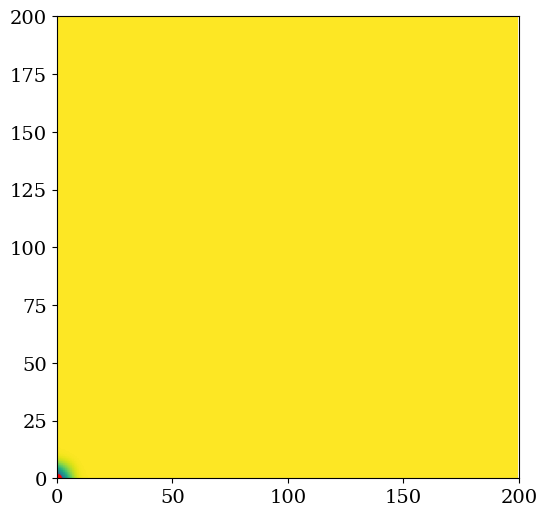

740


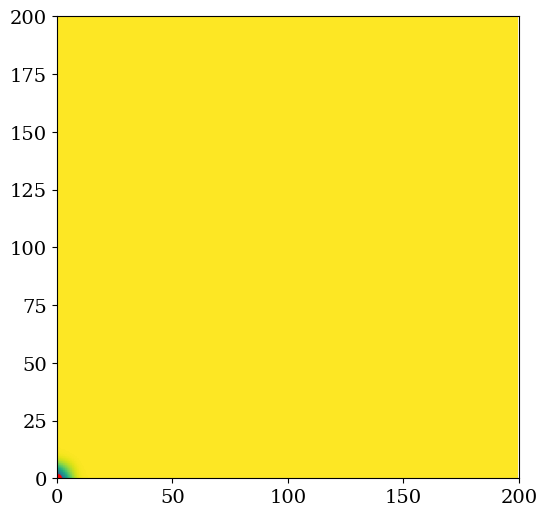

744


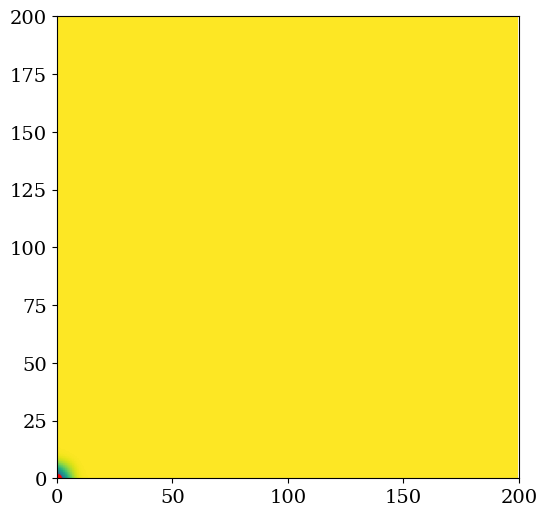

745


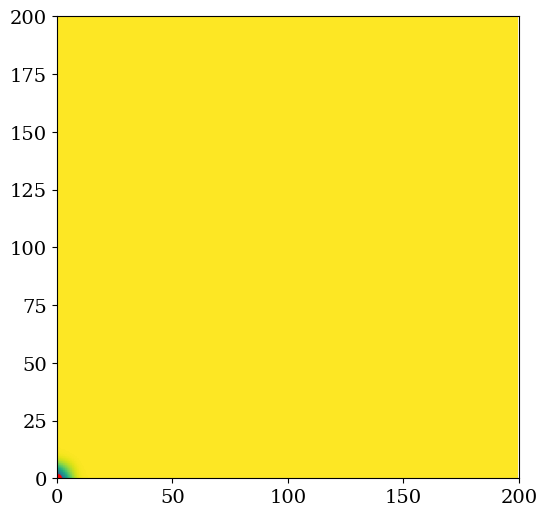

746


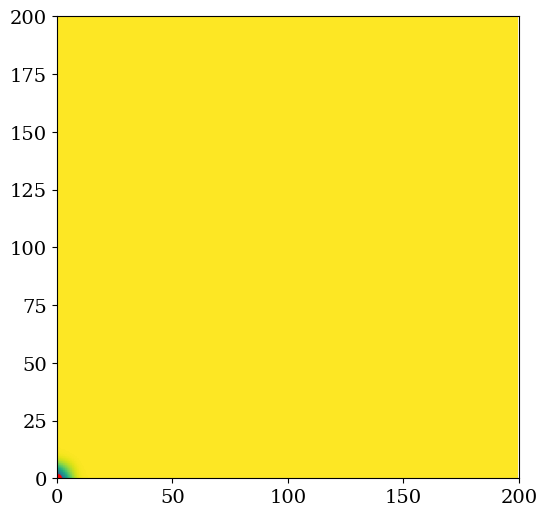

747


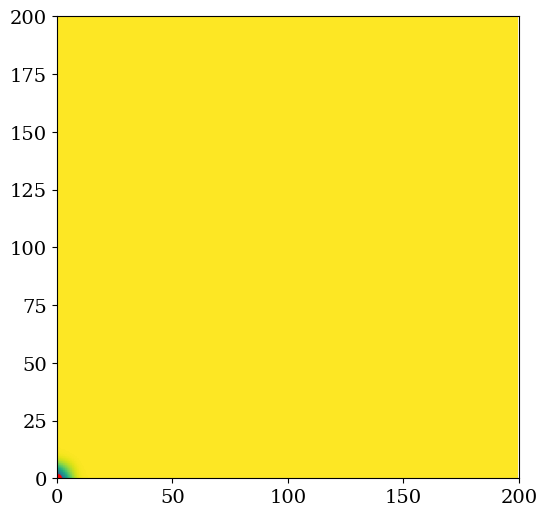

748


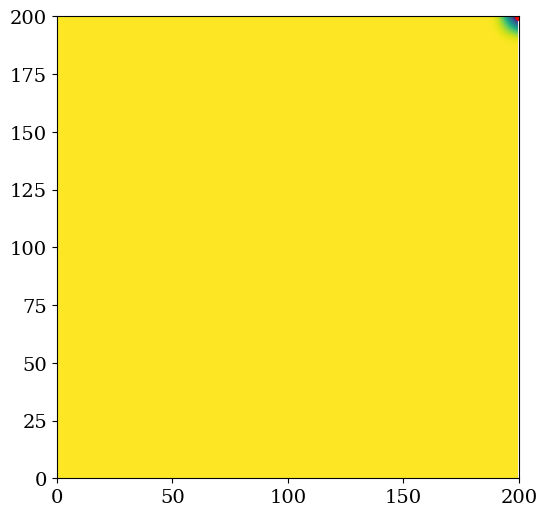

749


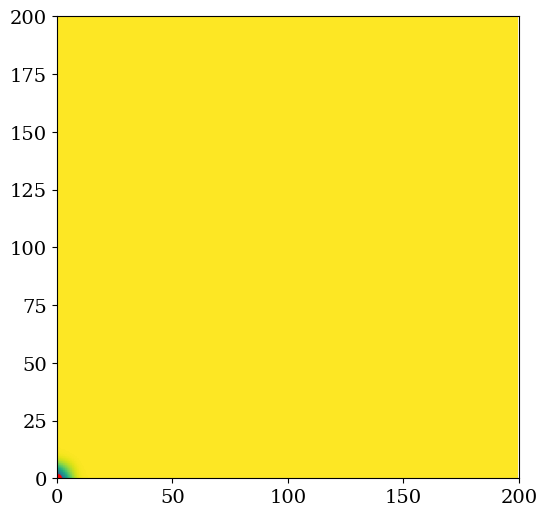

750


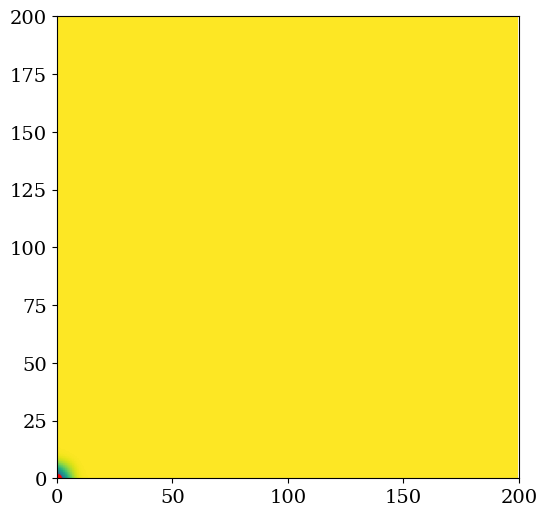

752


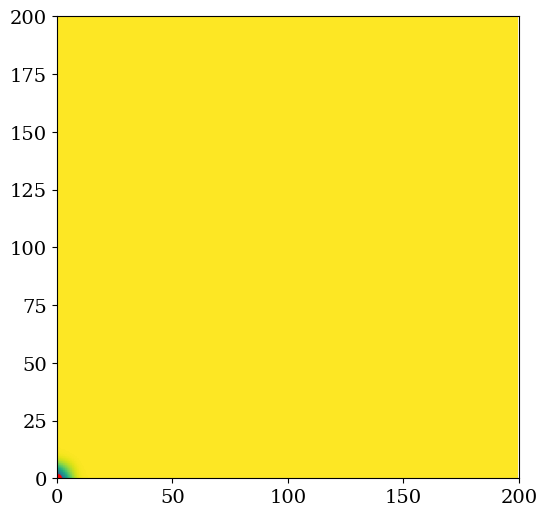

758


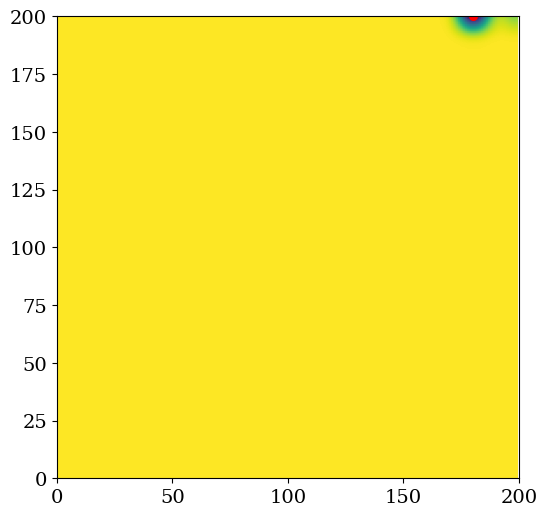

759


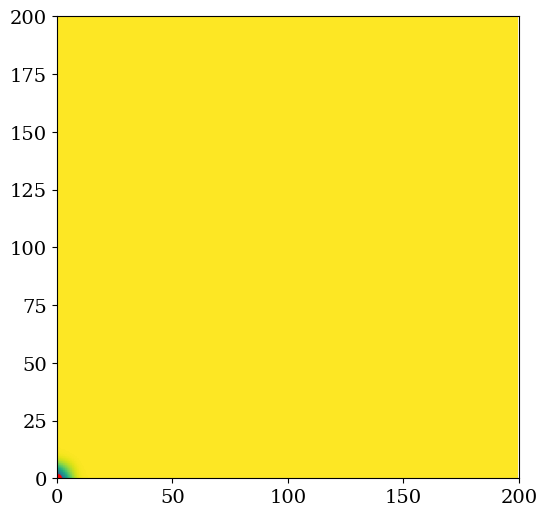

762


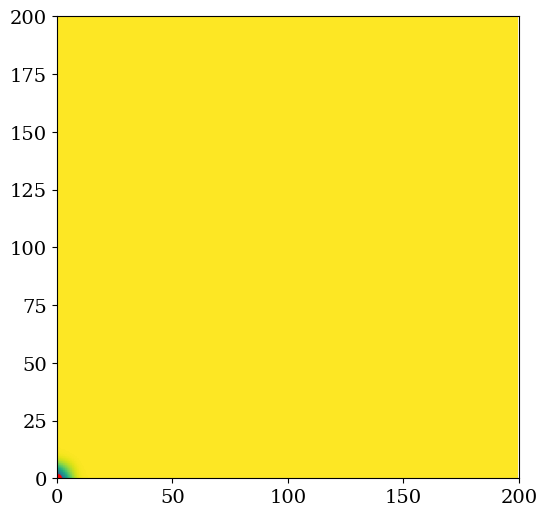

764


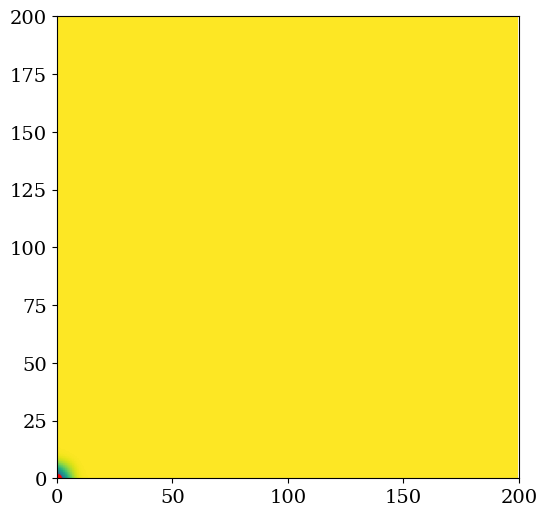

765


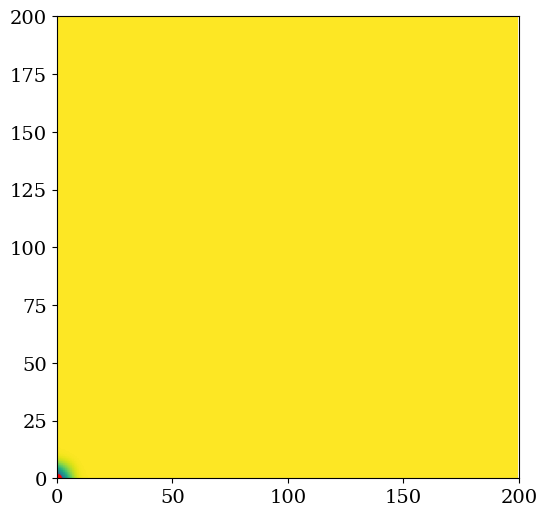

766


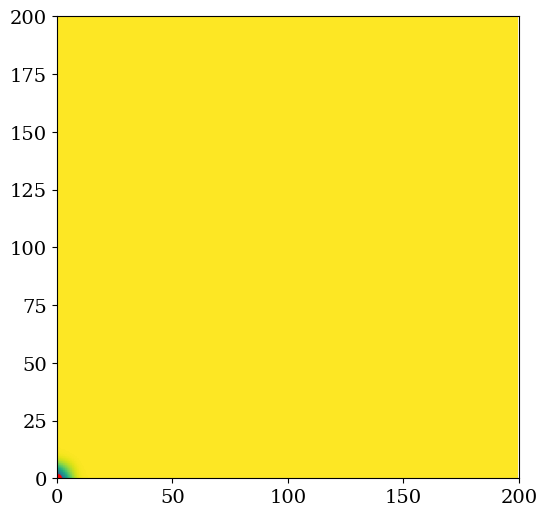

768


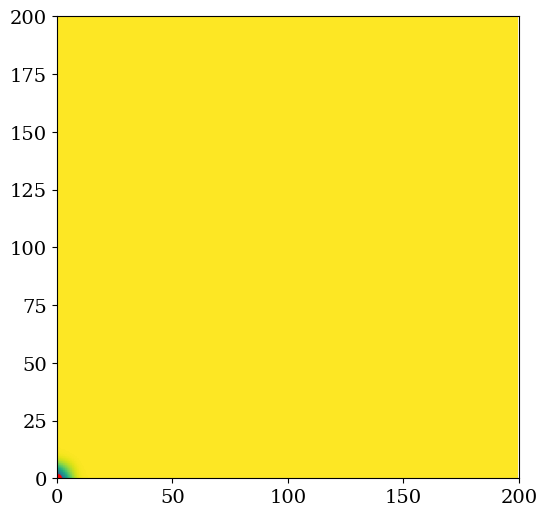

769


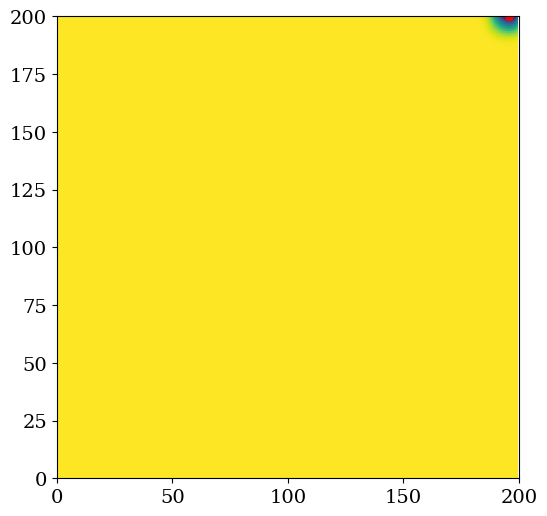

771


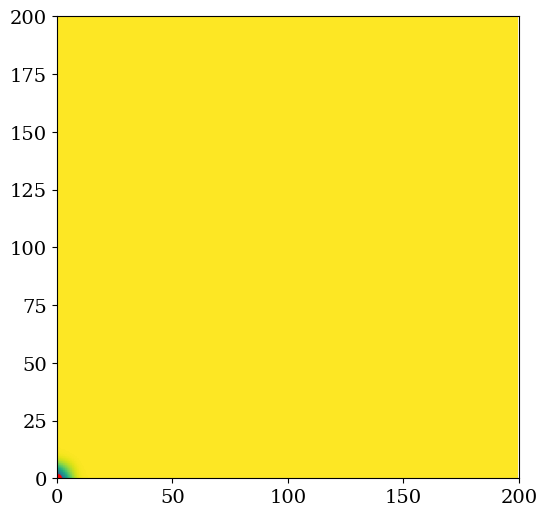

772


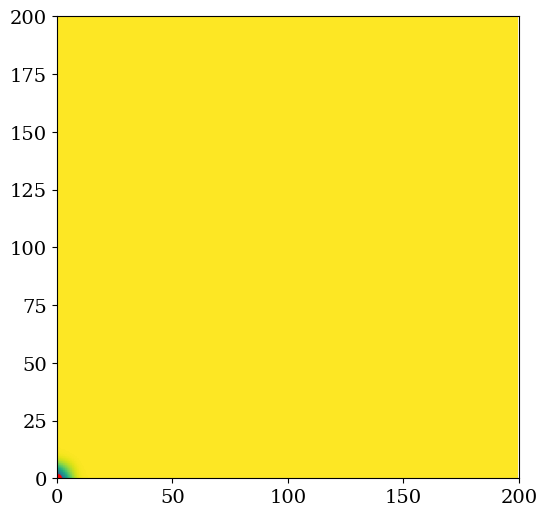

773


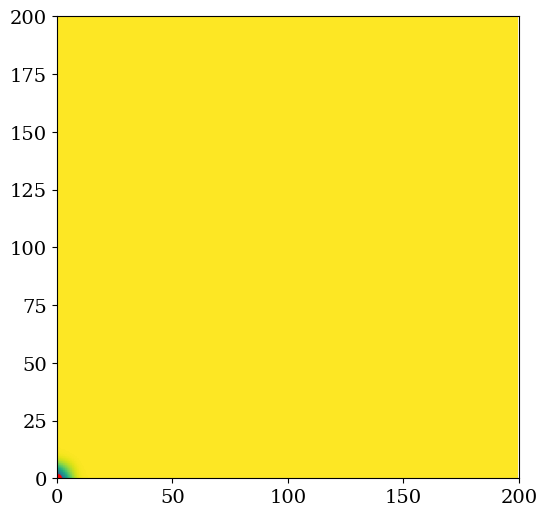

778


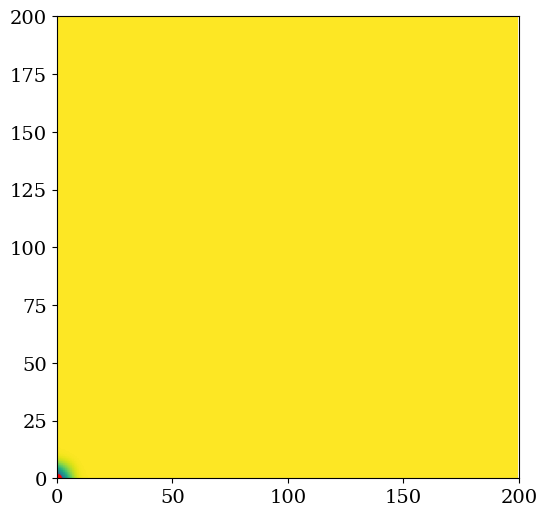

782


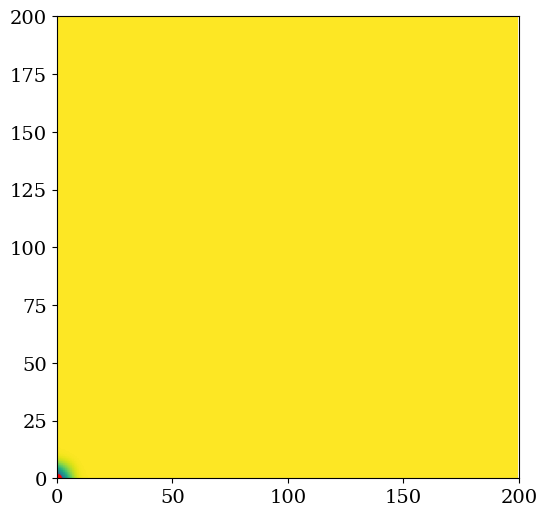

783


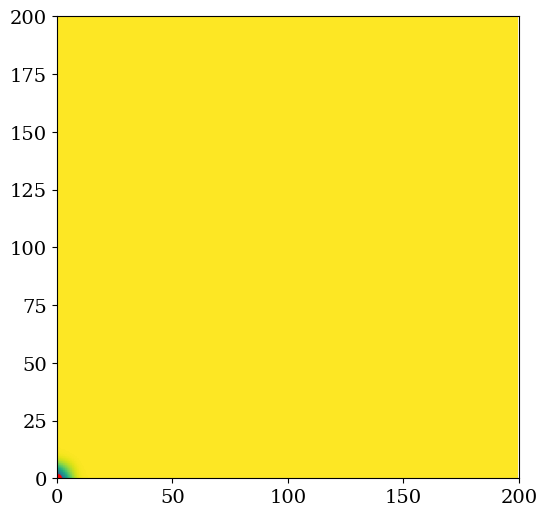

788


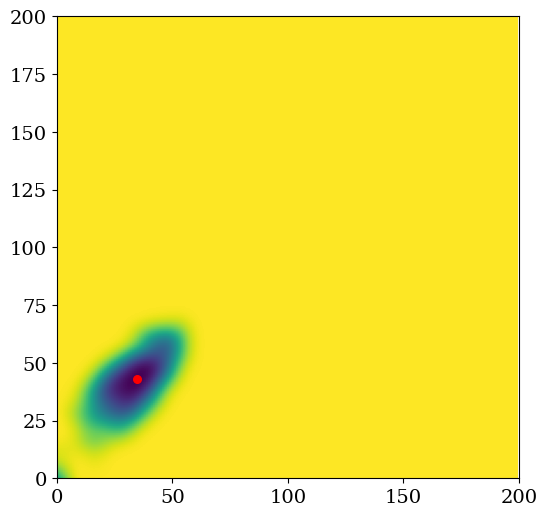

790


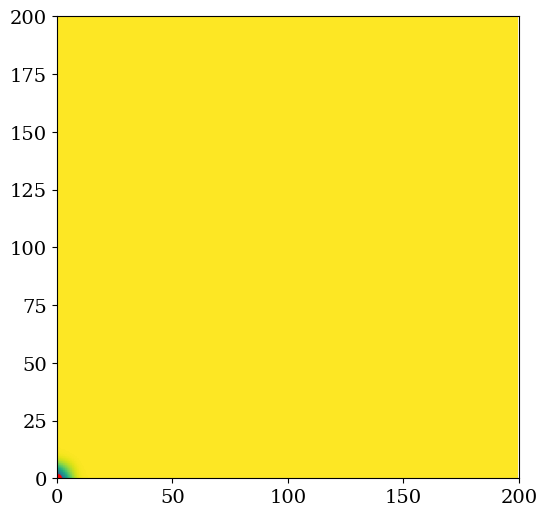

792


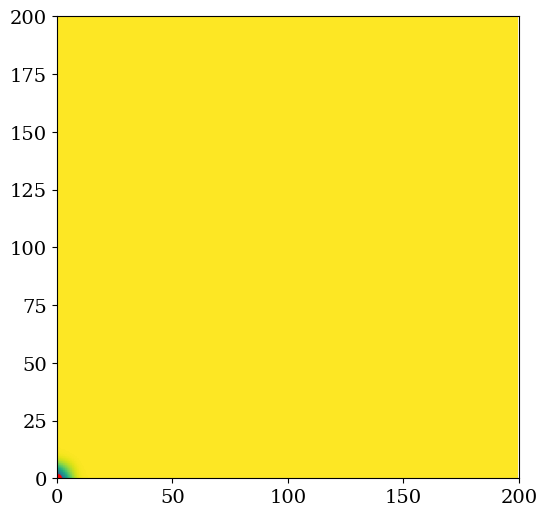

796


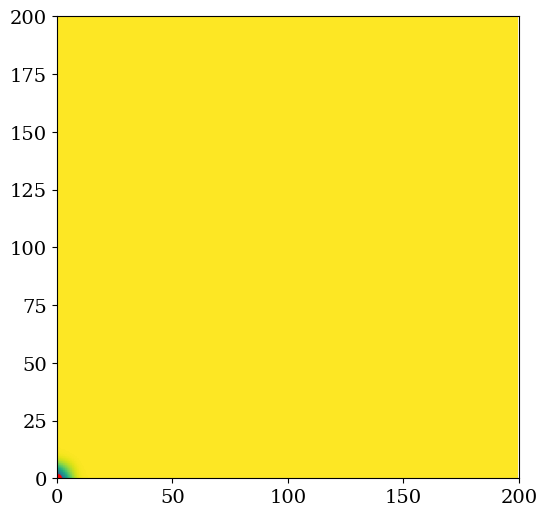

797


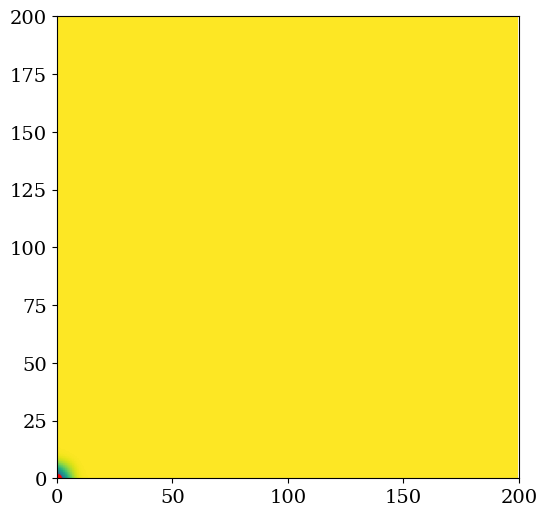

800


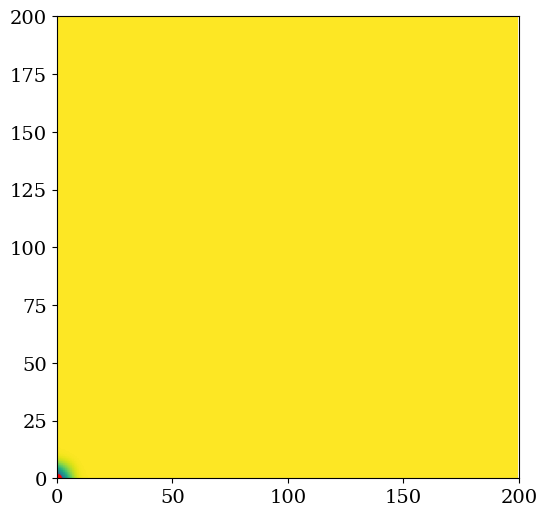

801


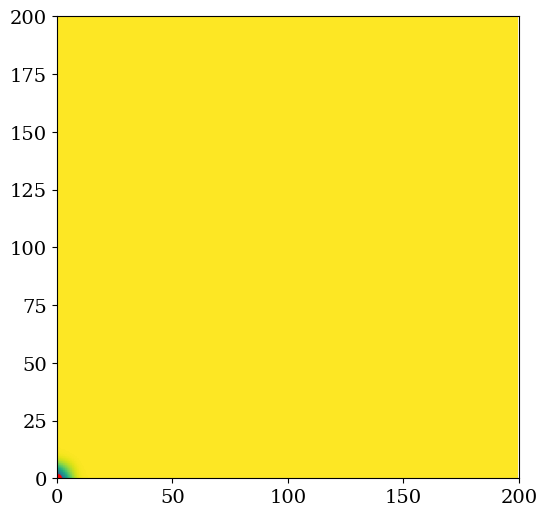

805


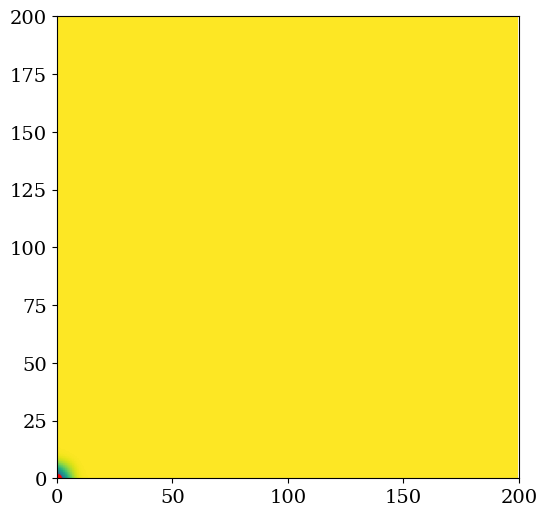

809


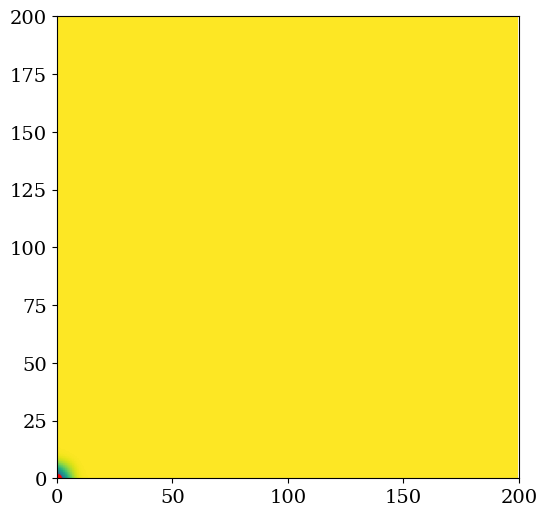

812


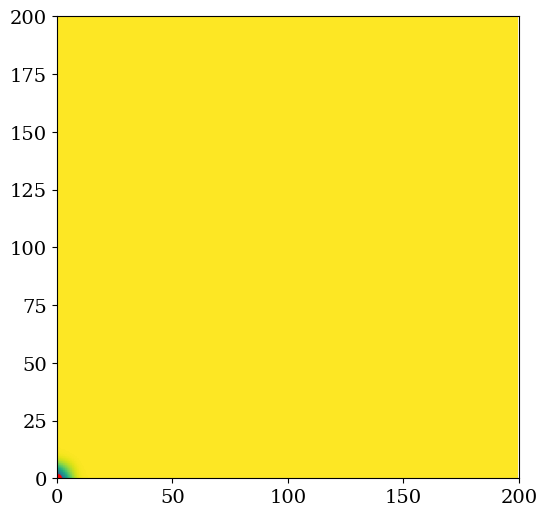

816


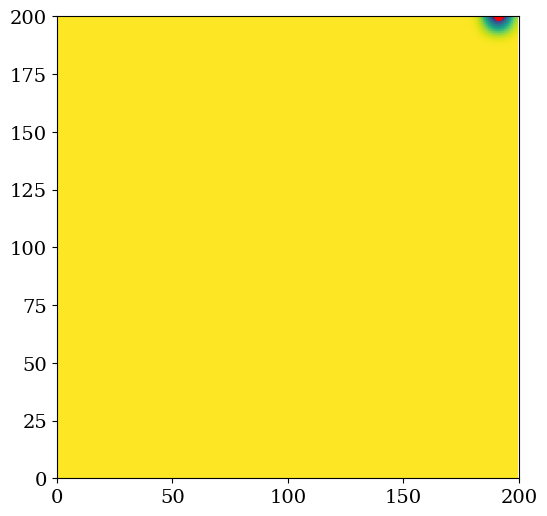

819


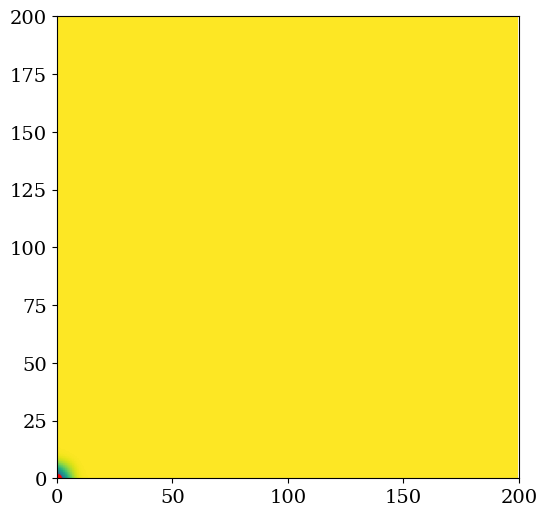

825


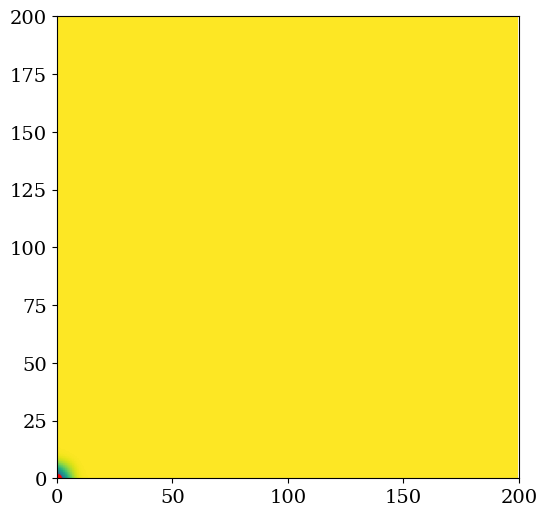

826


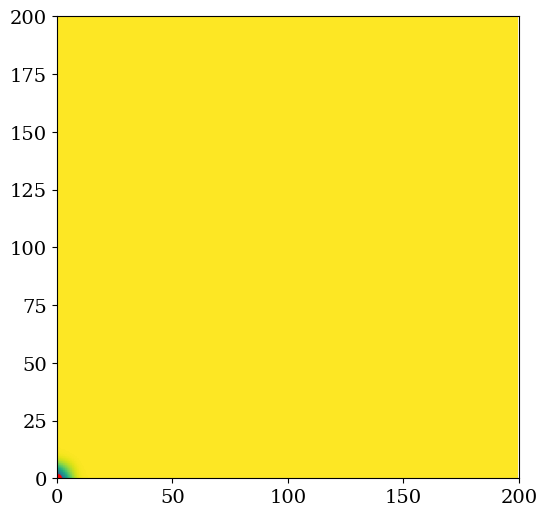

827


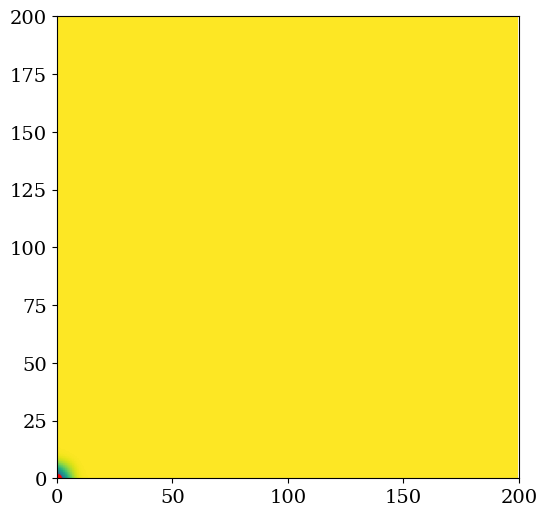

829


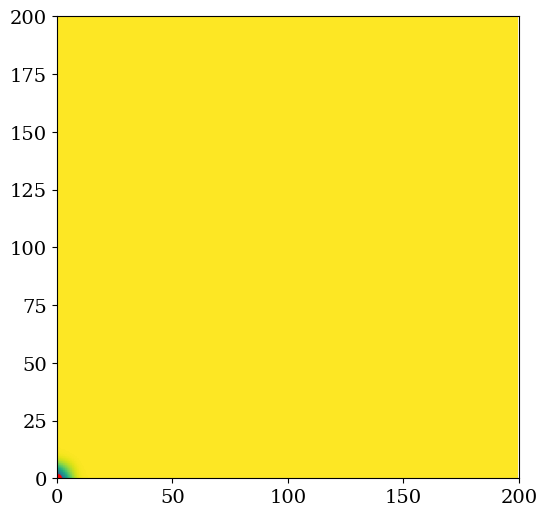

832


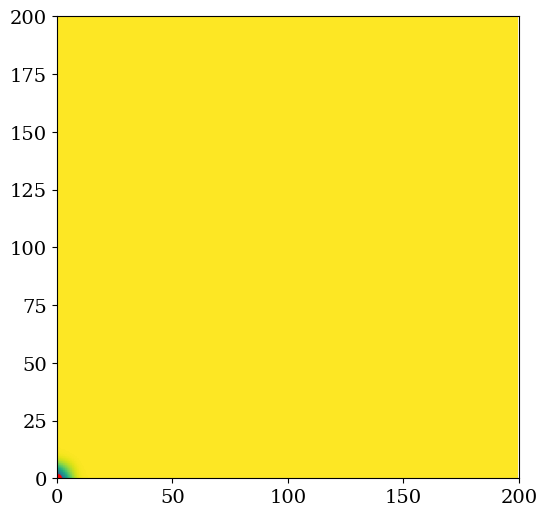

833


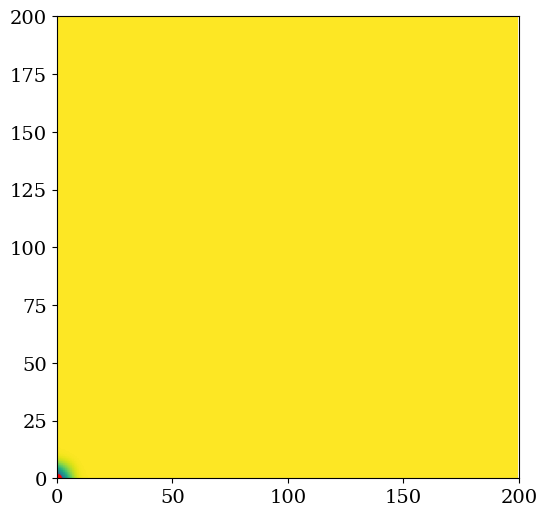

835


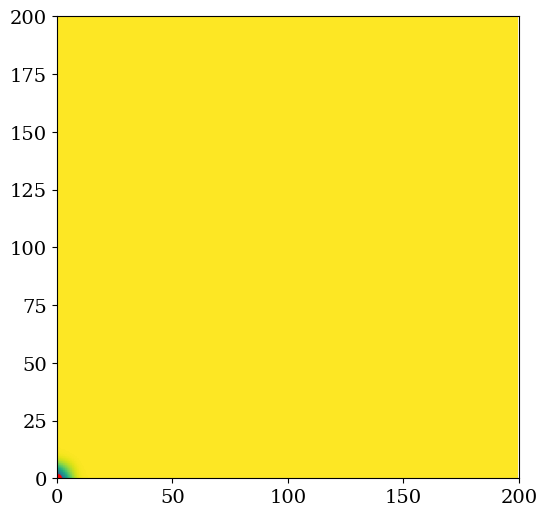

837


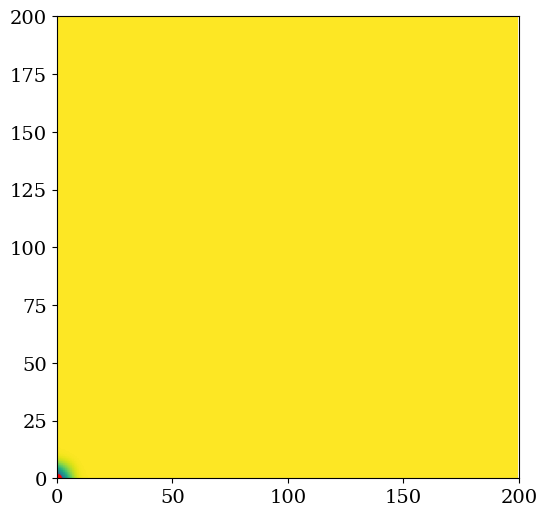

841


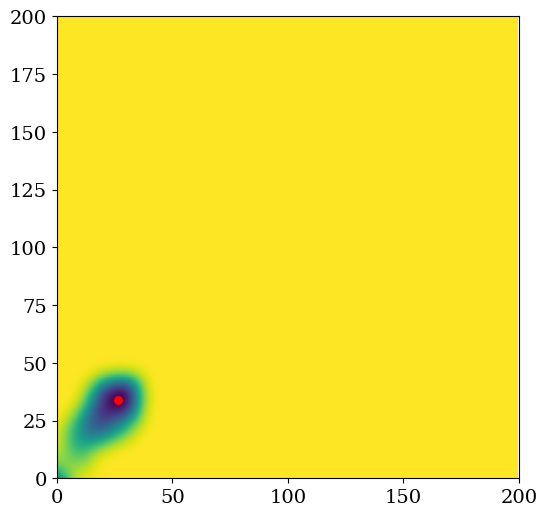

842


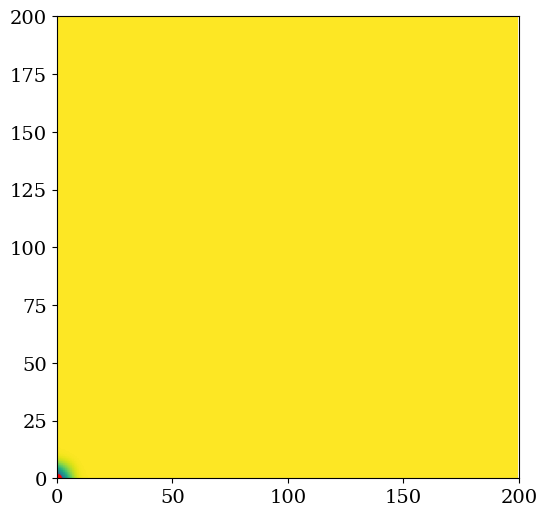

846


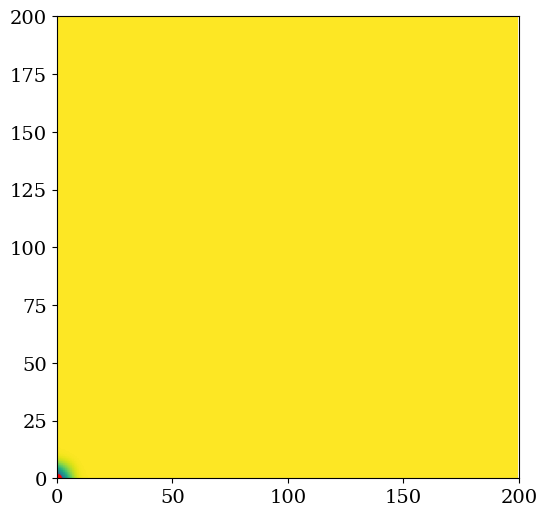

847


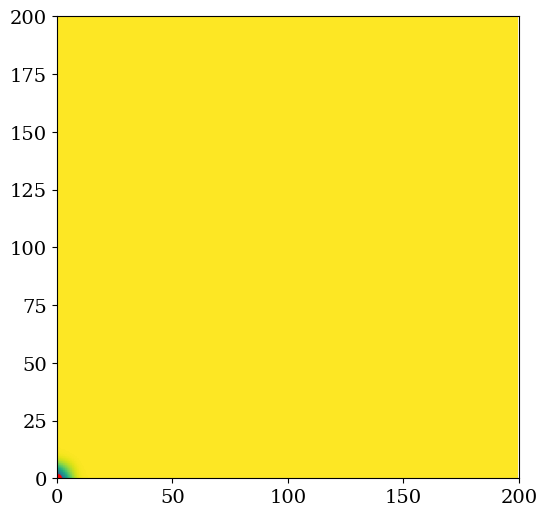

848


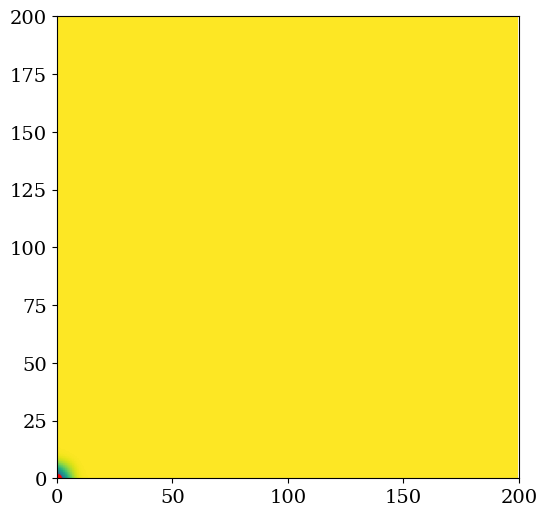

852


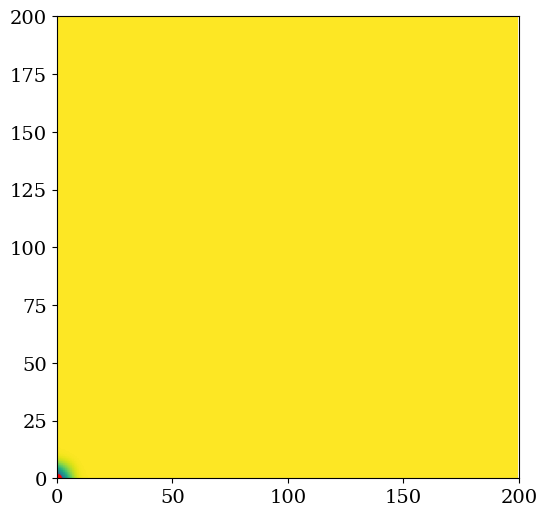

853


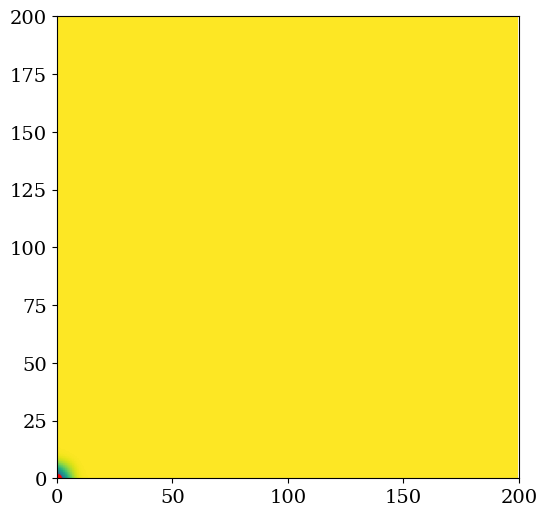

856


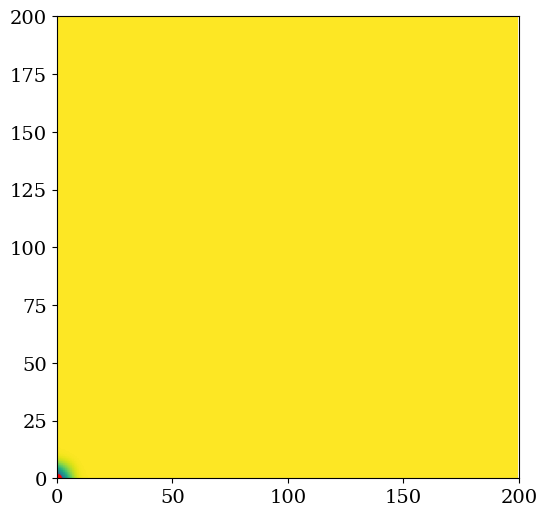

860


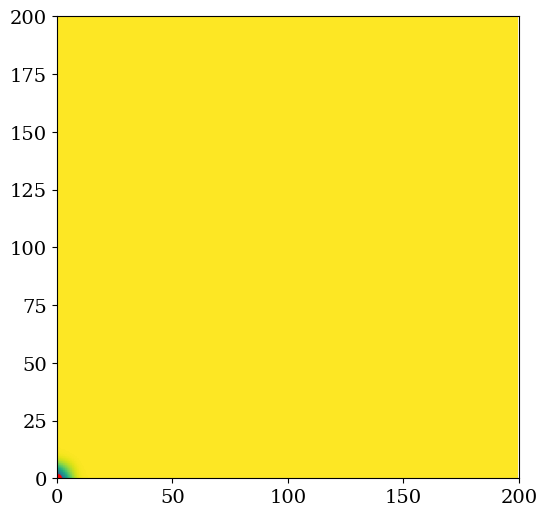

871


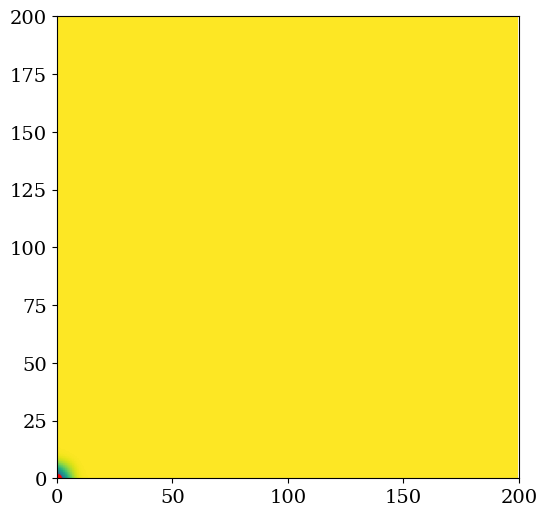

874


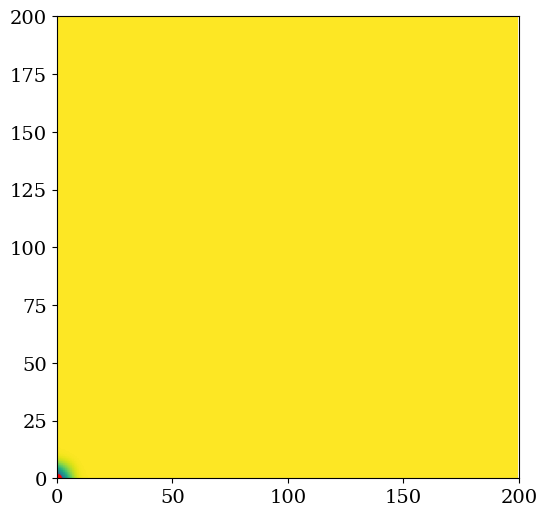

875


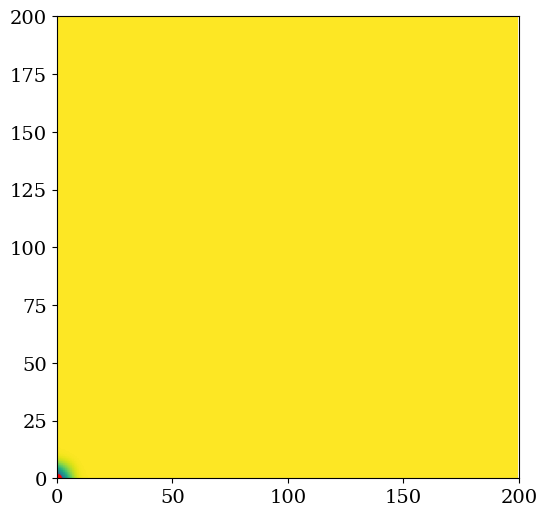

876


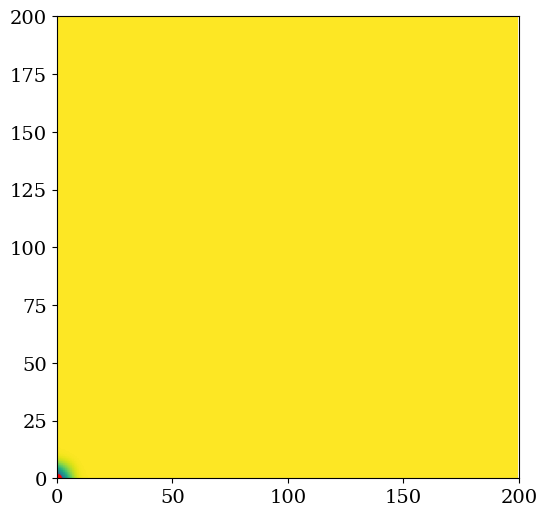

877


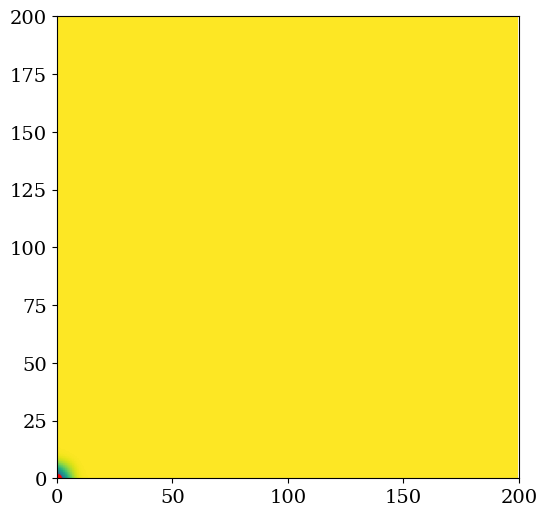

881


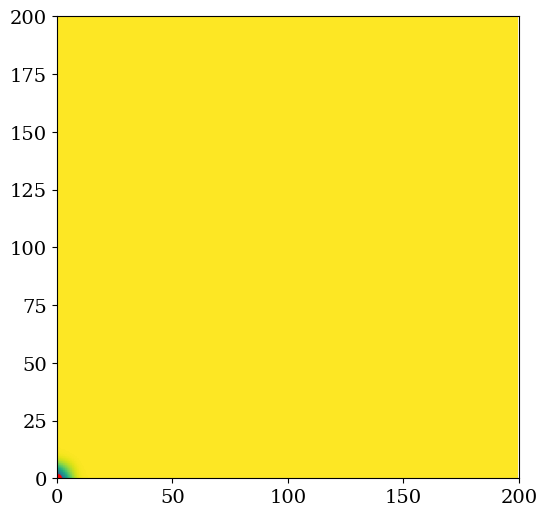

882


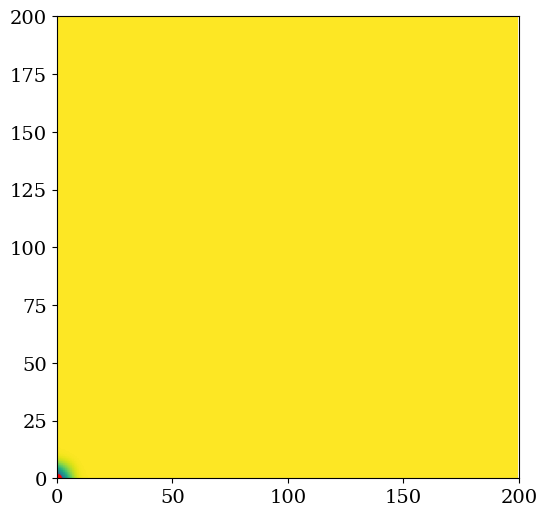

884


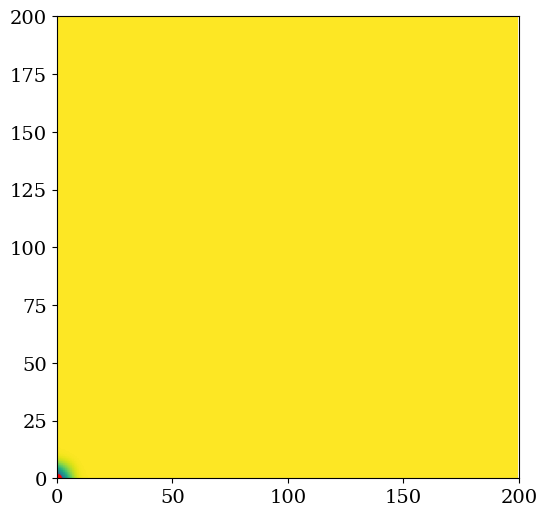

885


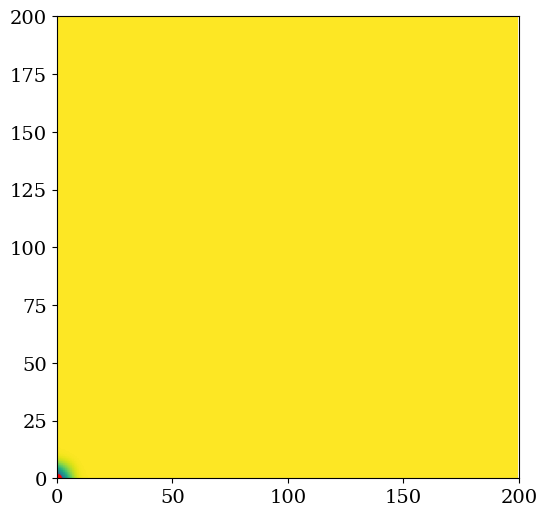

888


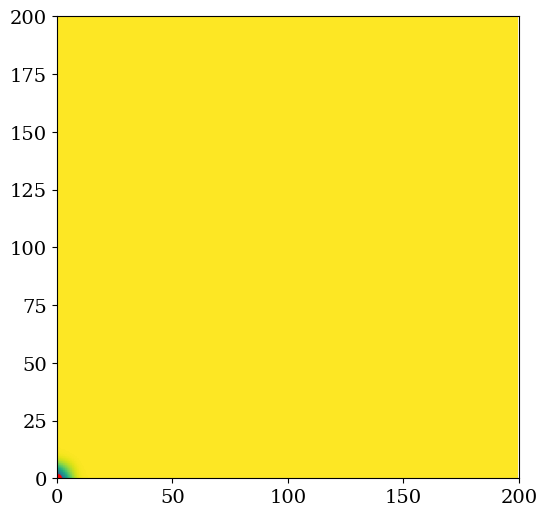

889


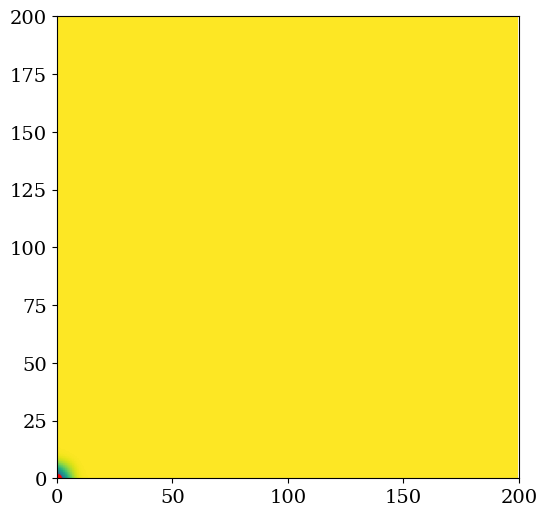

893


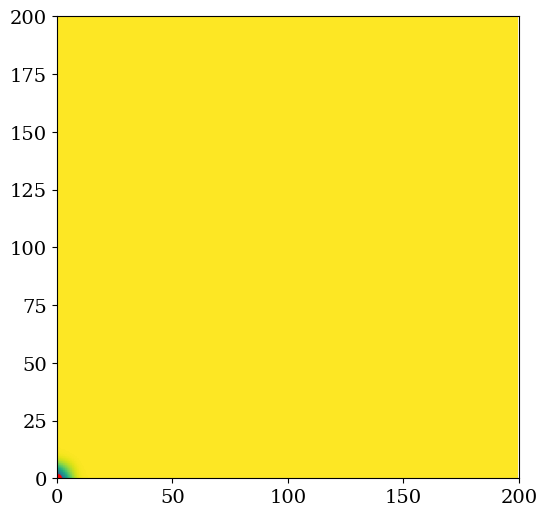

895


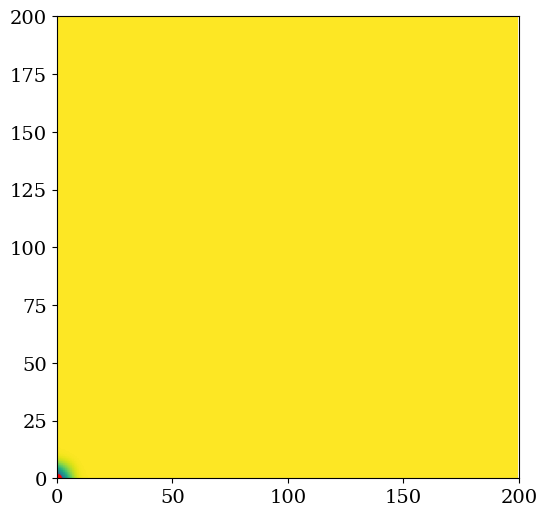

899


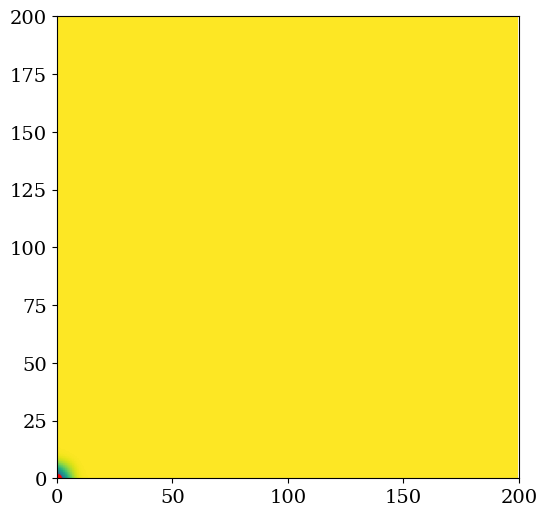

900


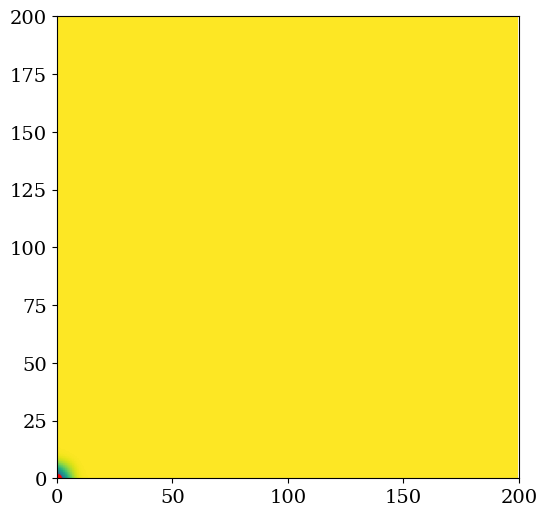

907


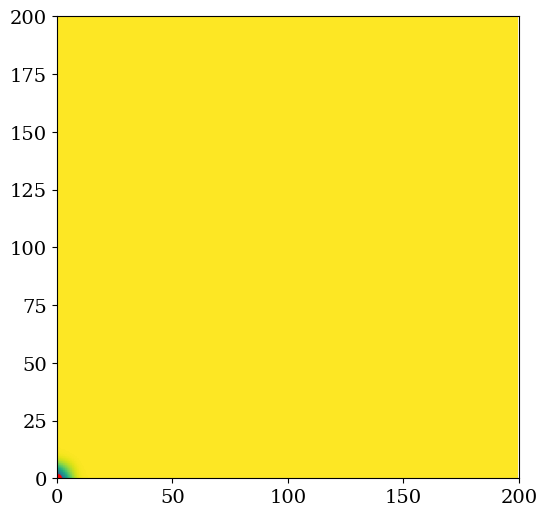

908


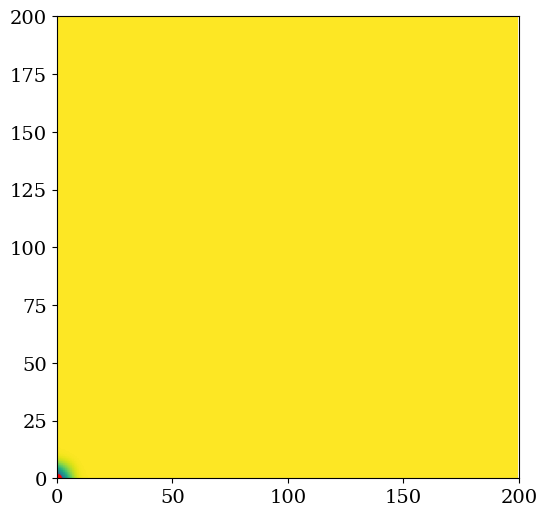

911


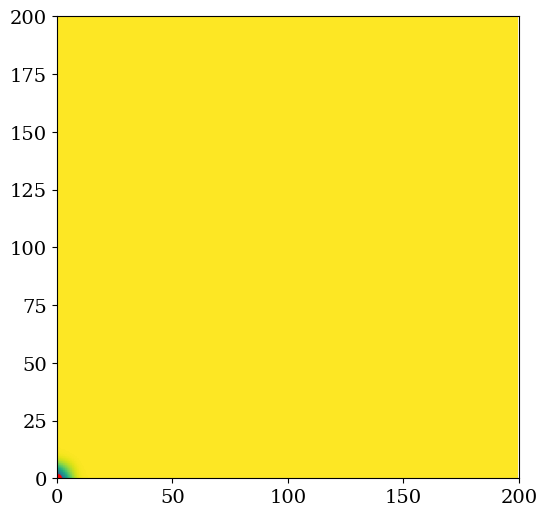

915


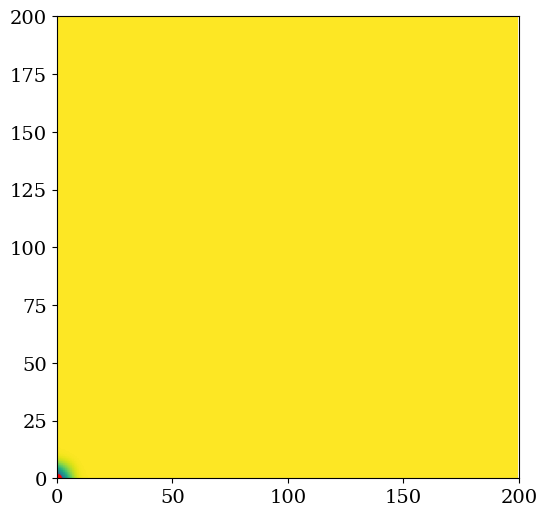

919


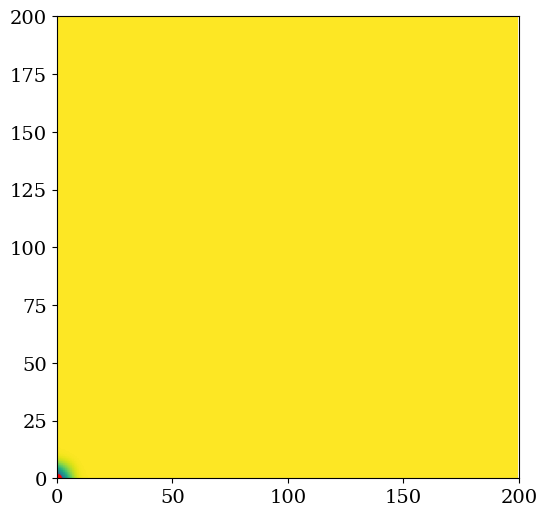

920


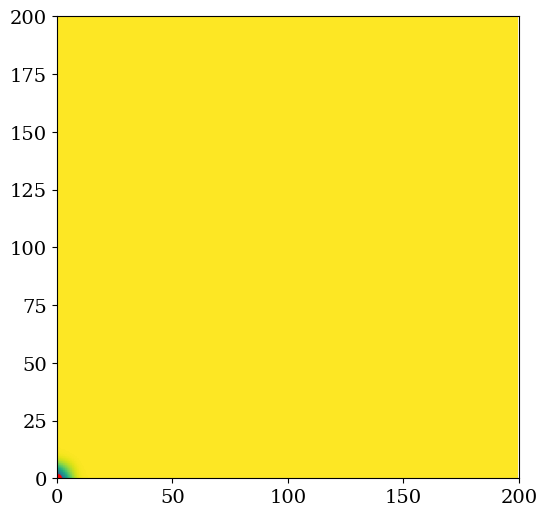

921


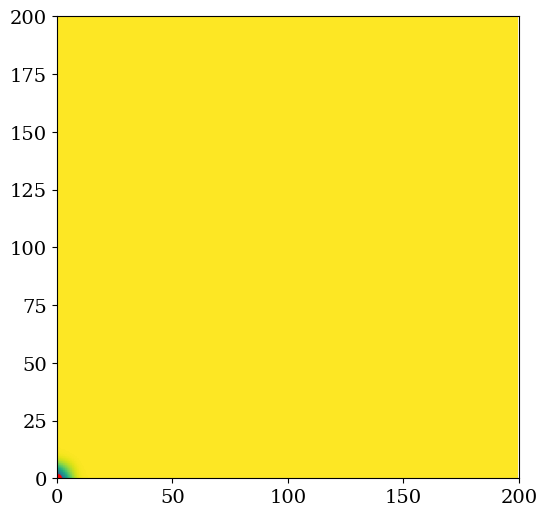

922


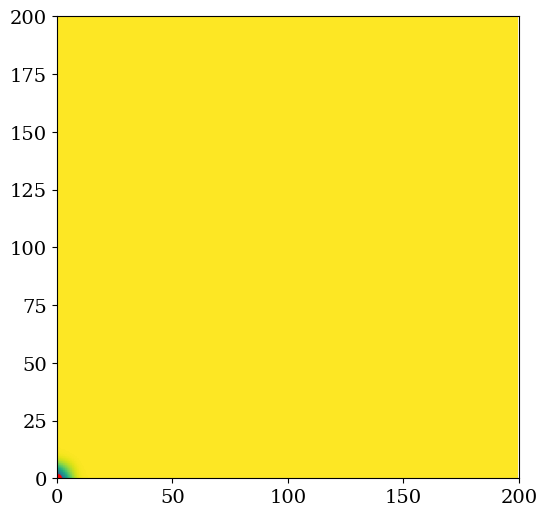

923


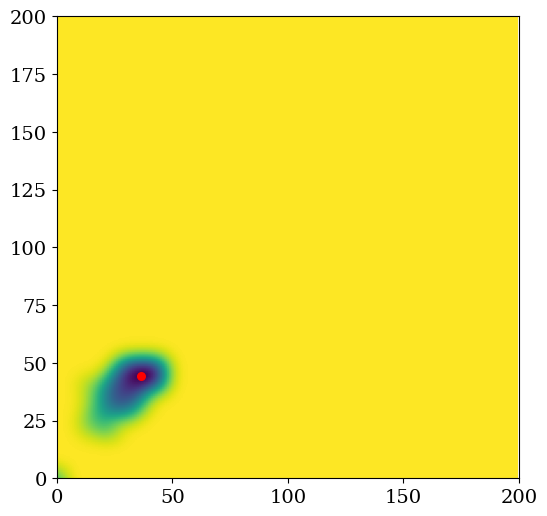

924


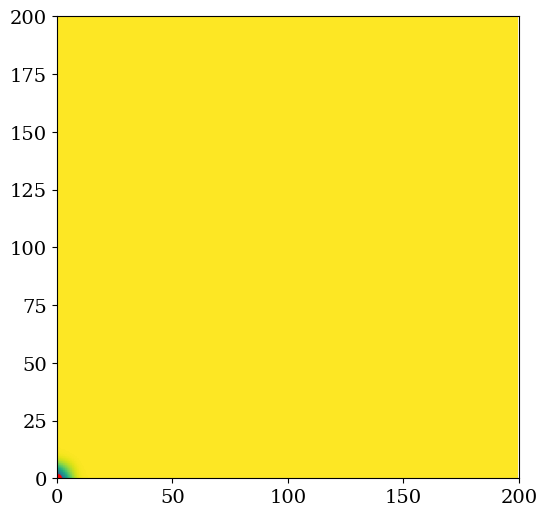

926


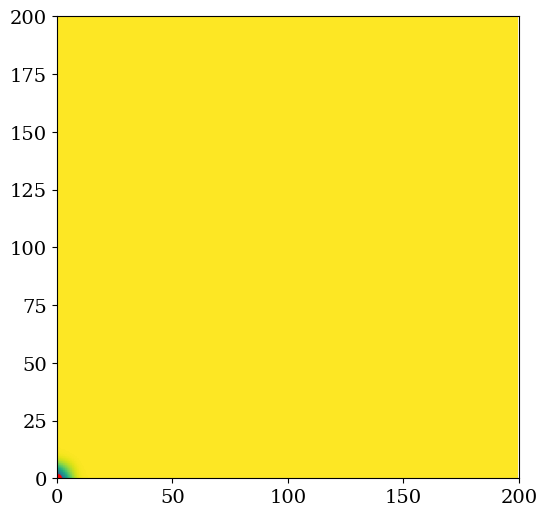

928


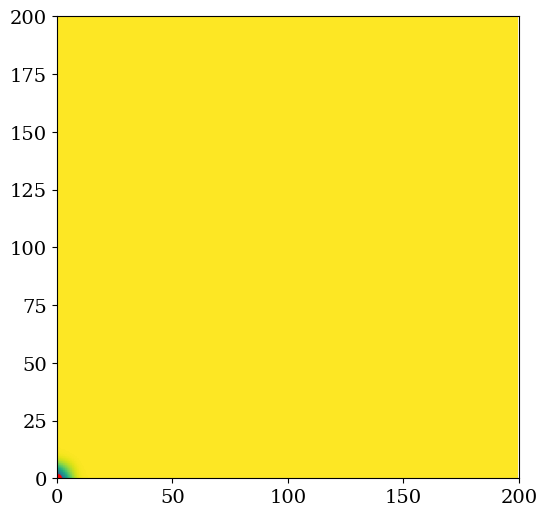

929


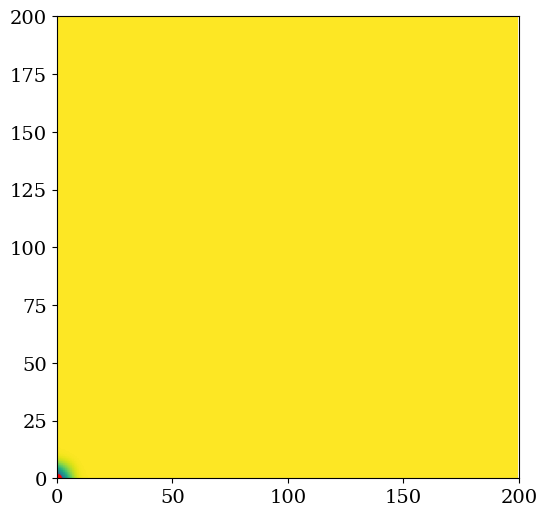

930


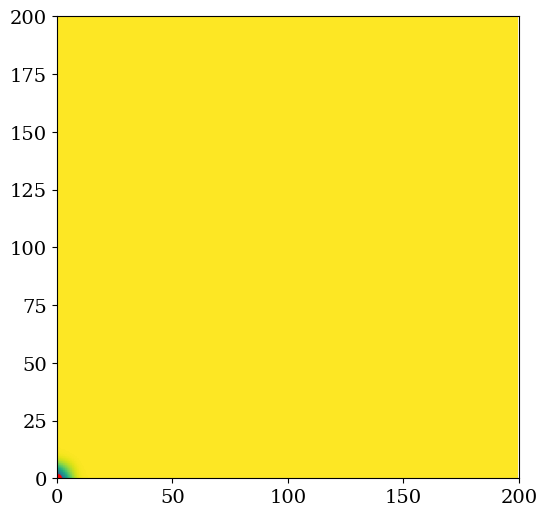

933


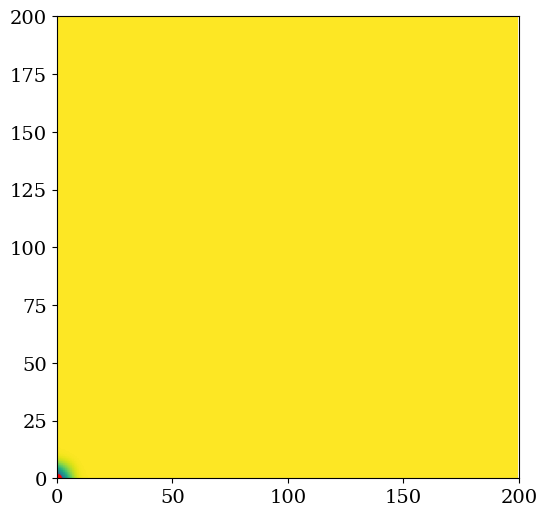

934


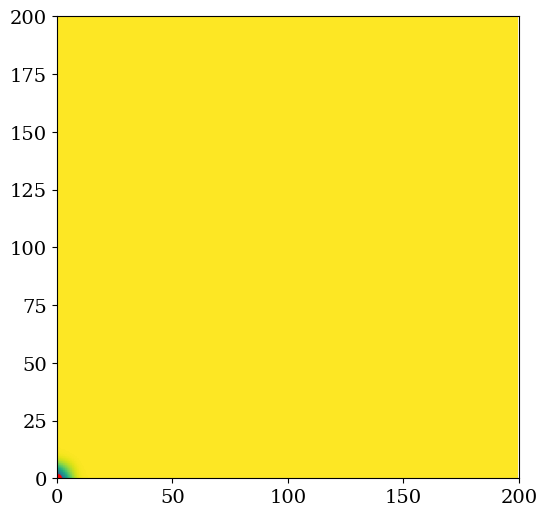

938


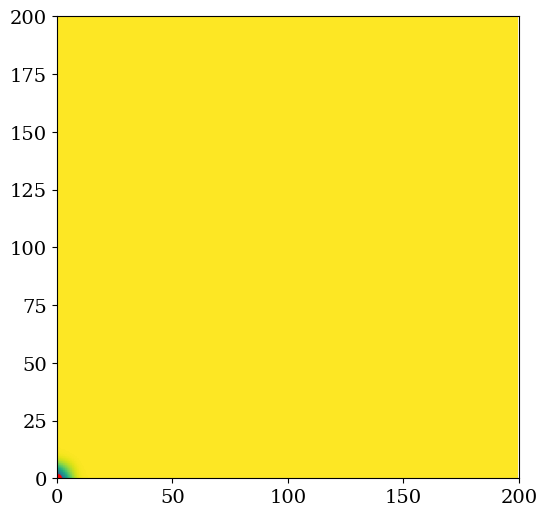

939


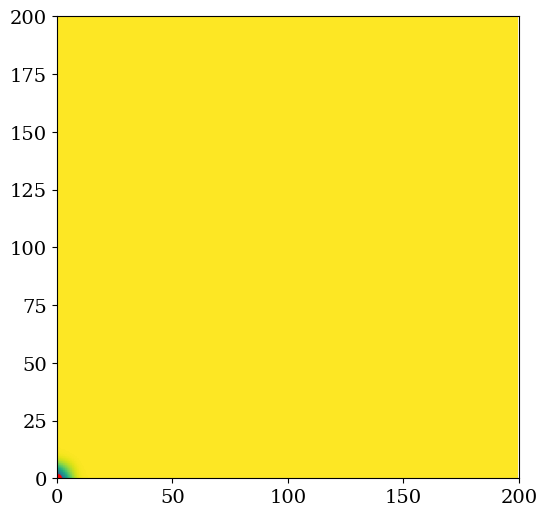

940


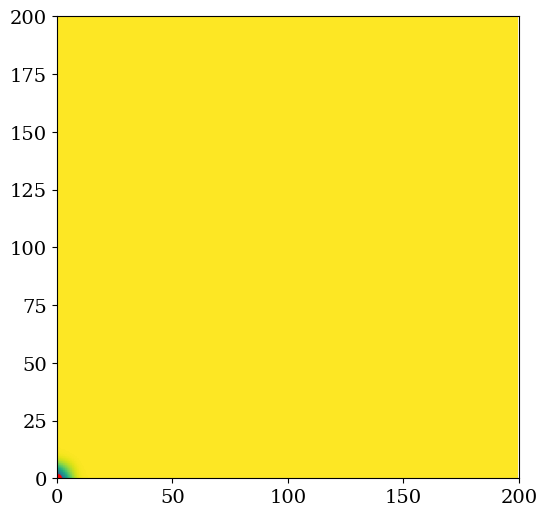

942


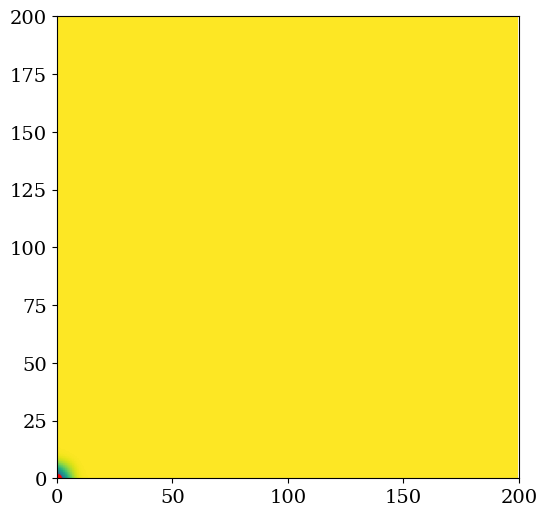

946


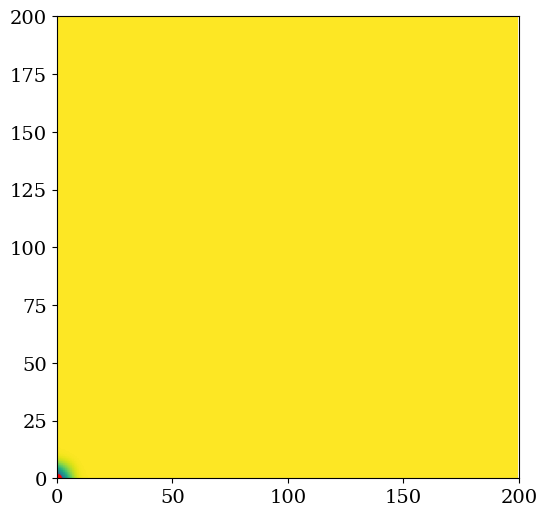

947


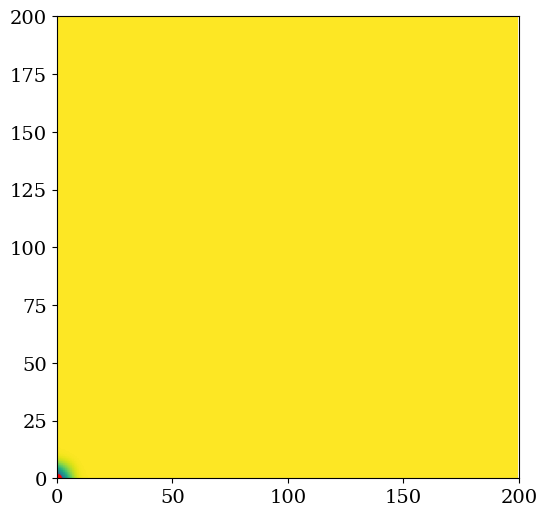

949


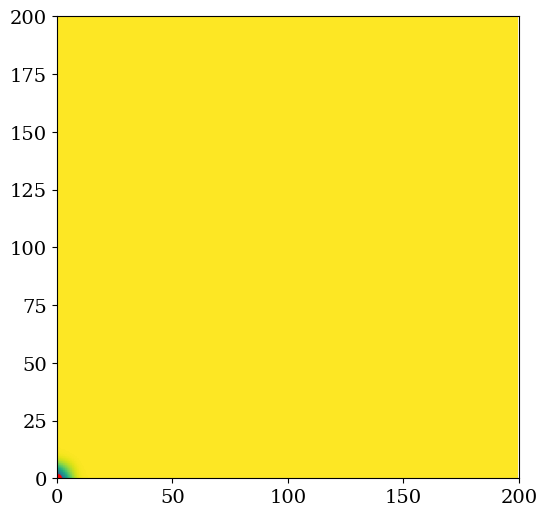

950


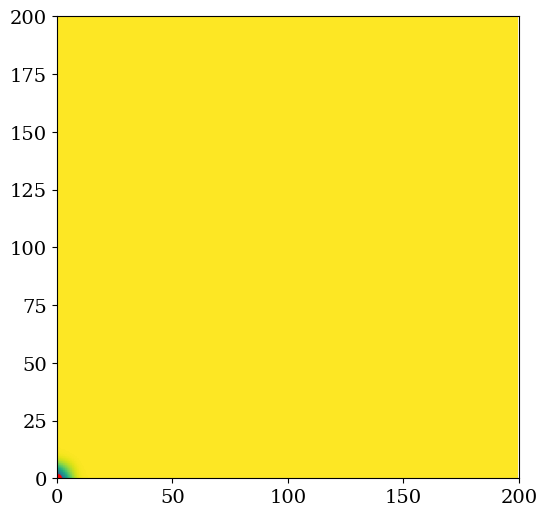

951


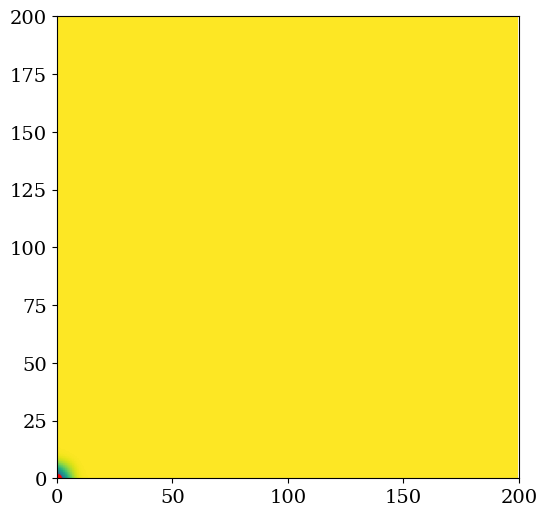

952


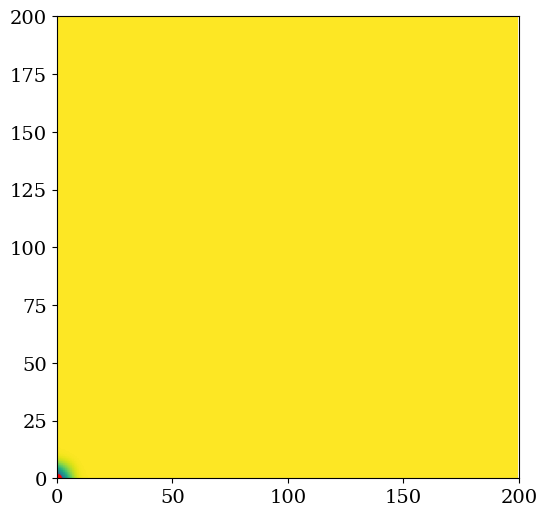

953


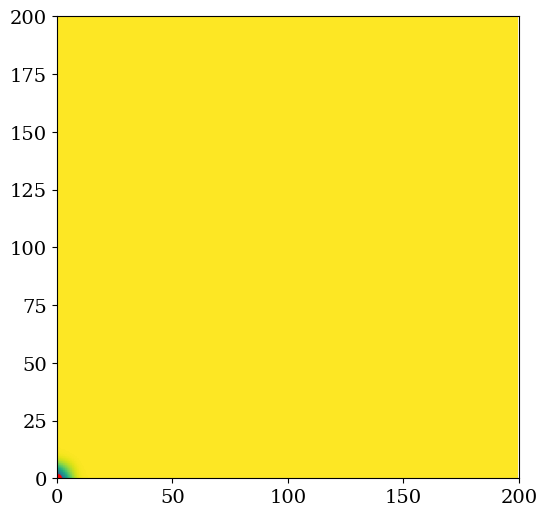

957


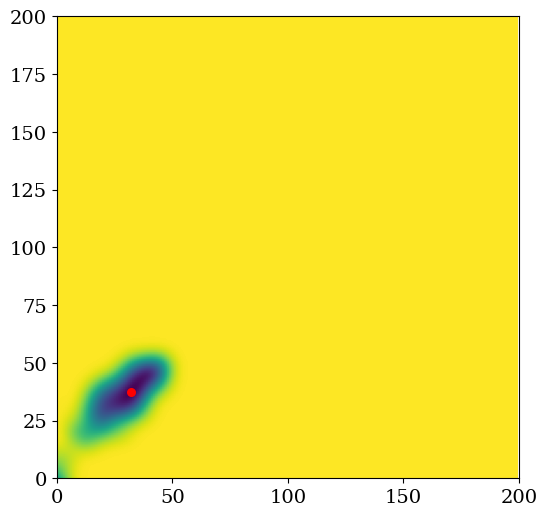

958


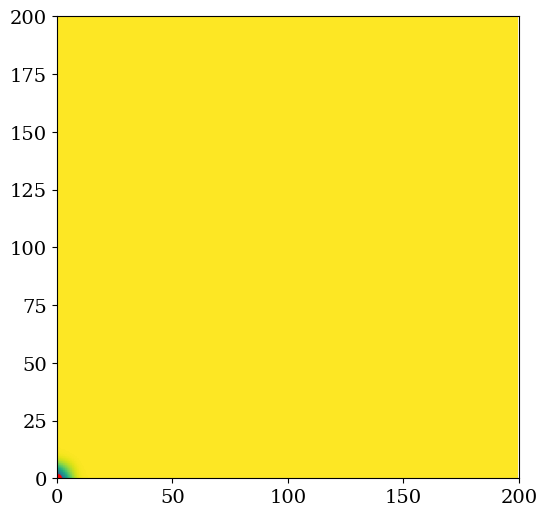

960


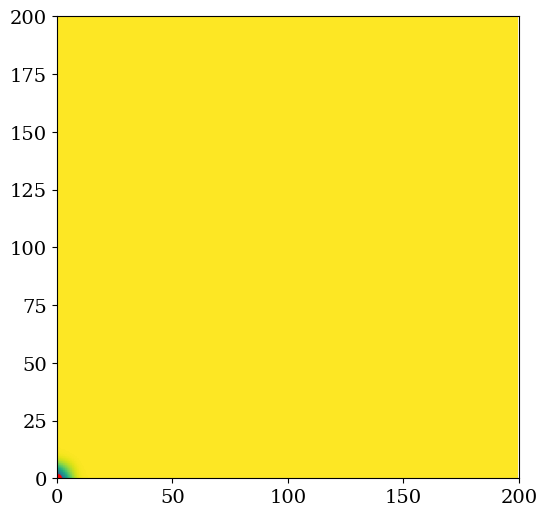

961


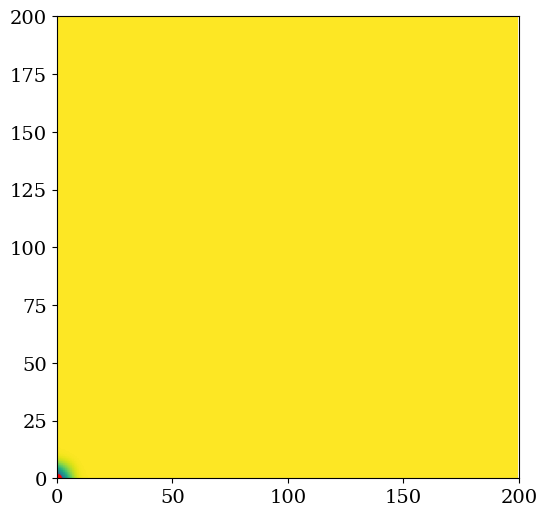

963


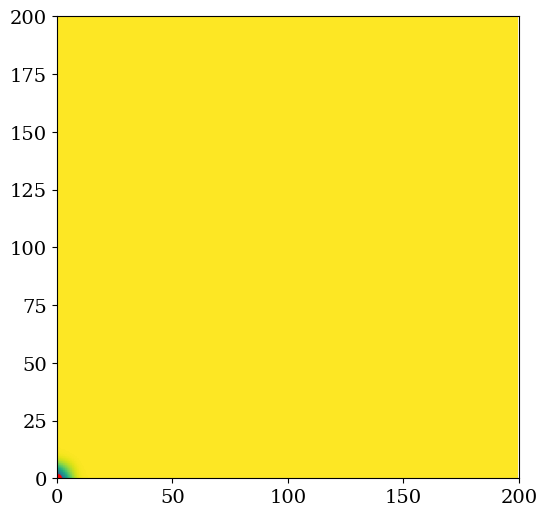

964


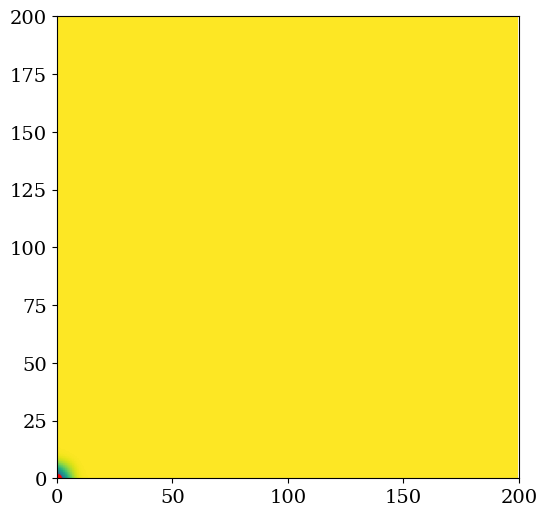

968


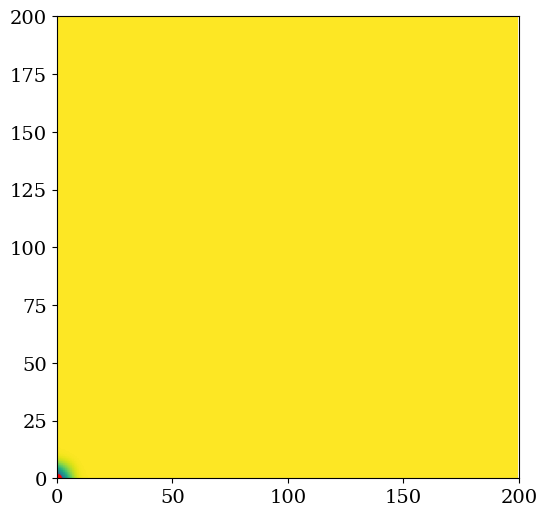

974


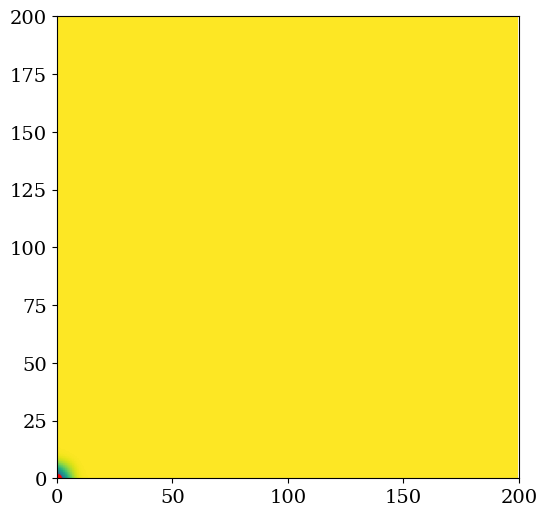

976


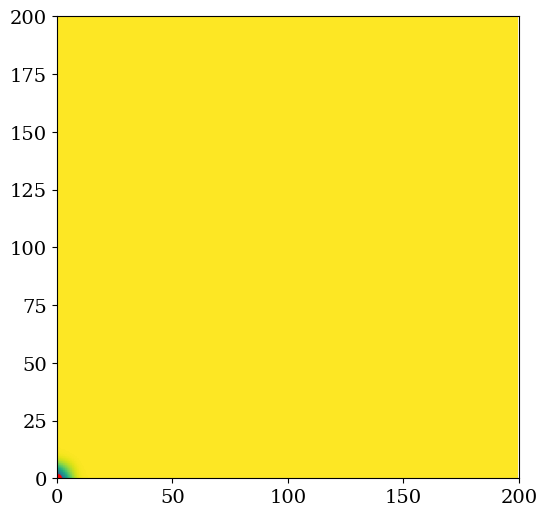

978


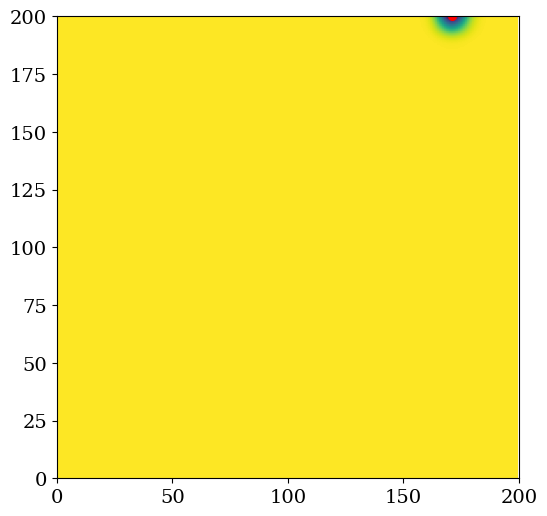

980


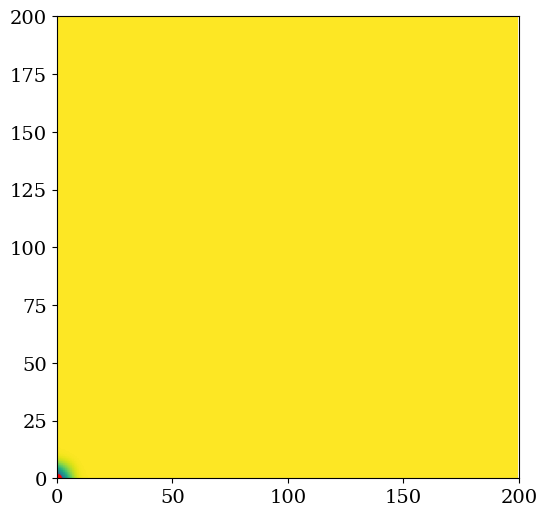

981


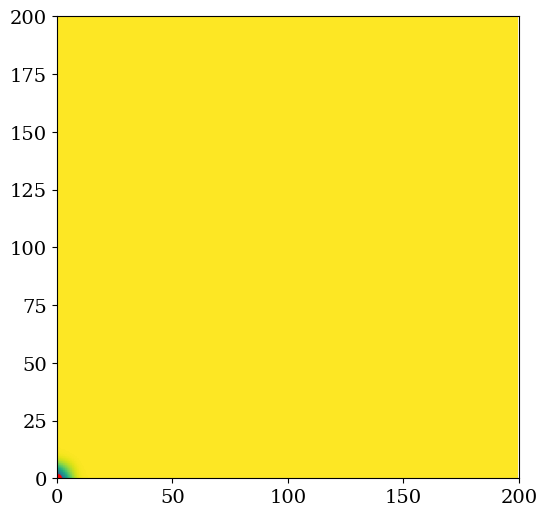

983


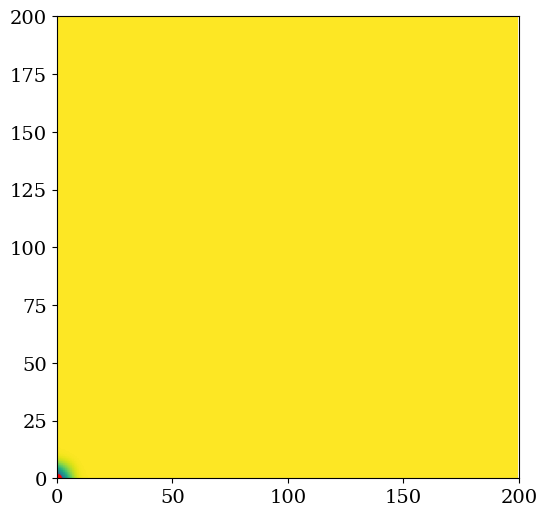

984


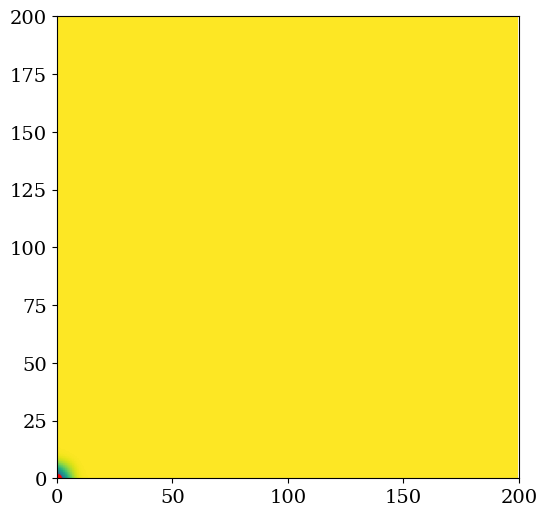

985


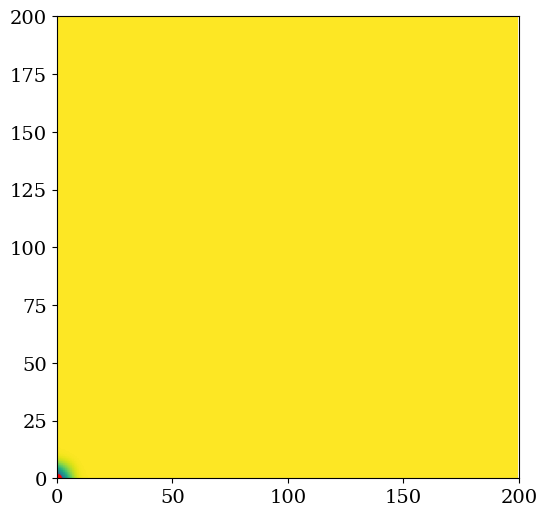

989


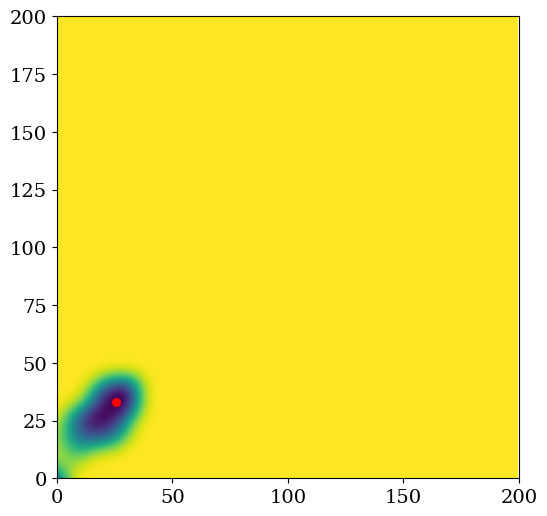

990


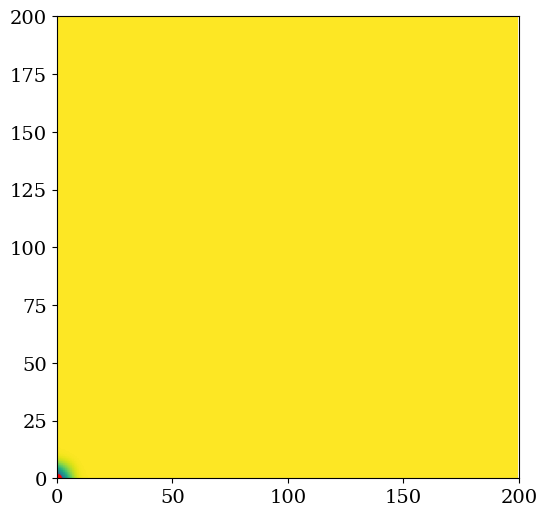

991


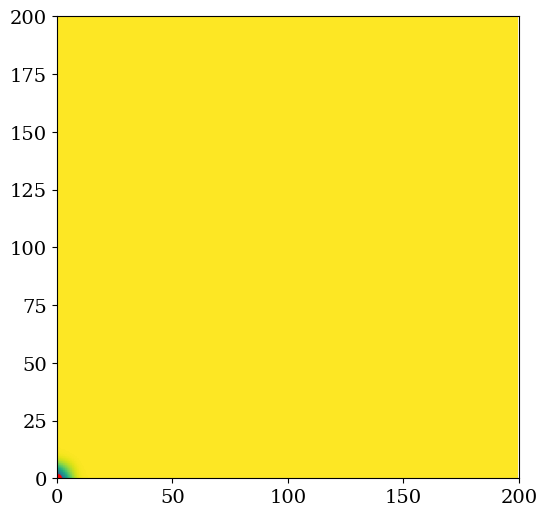

992


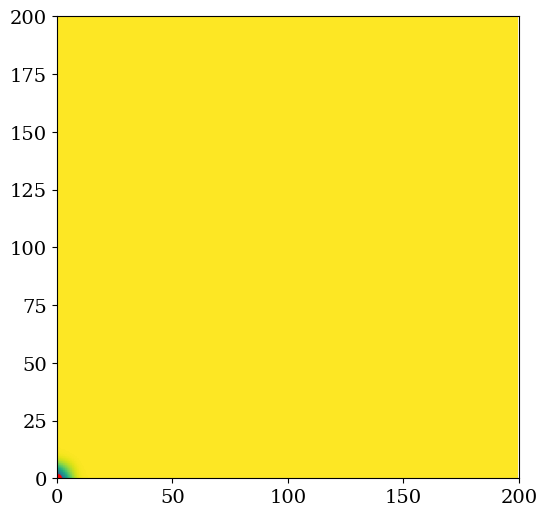

995


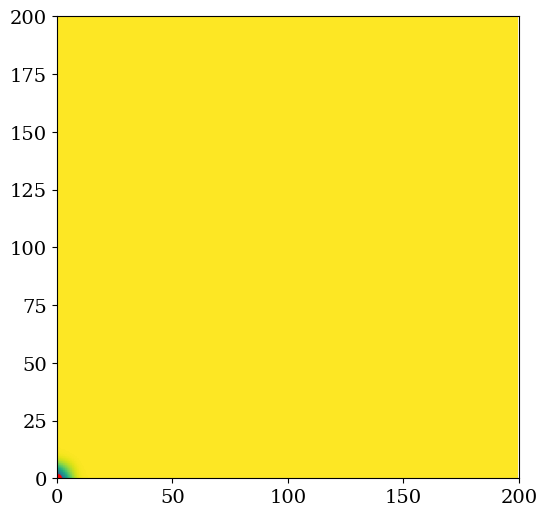

996


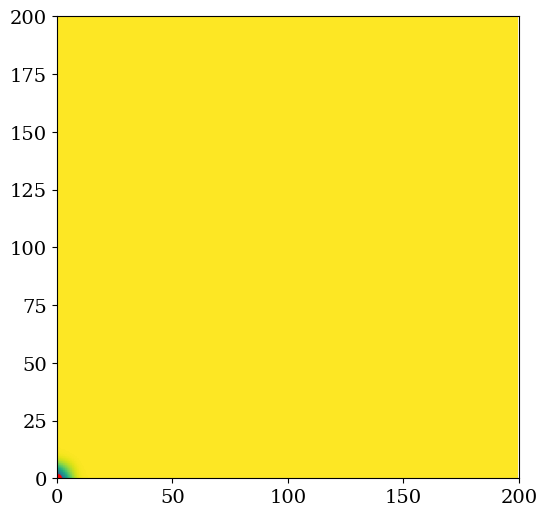

997


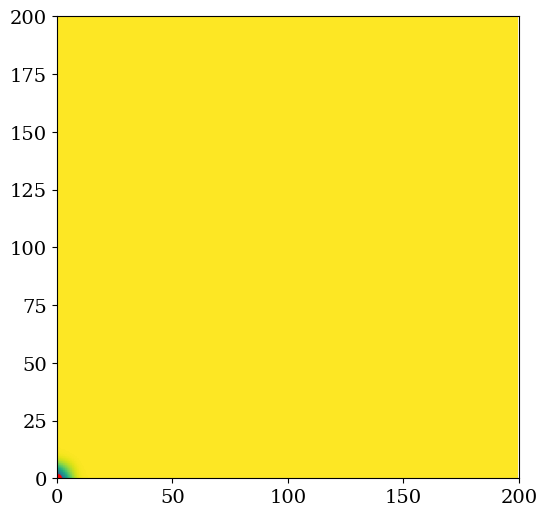

998


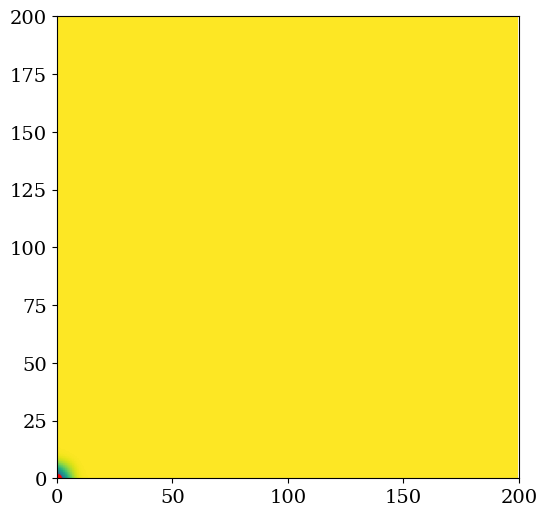

999


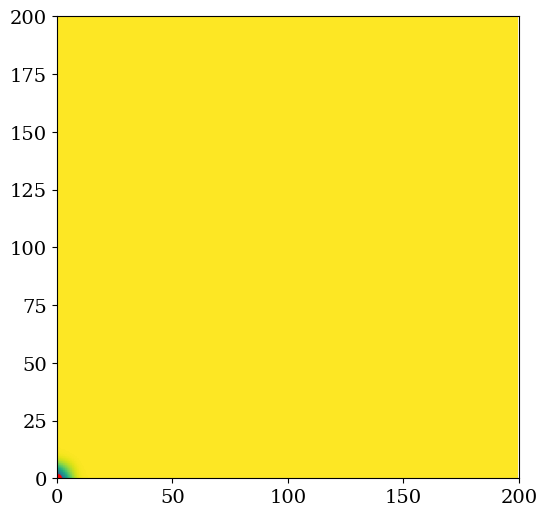

1001


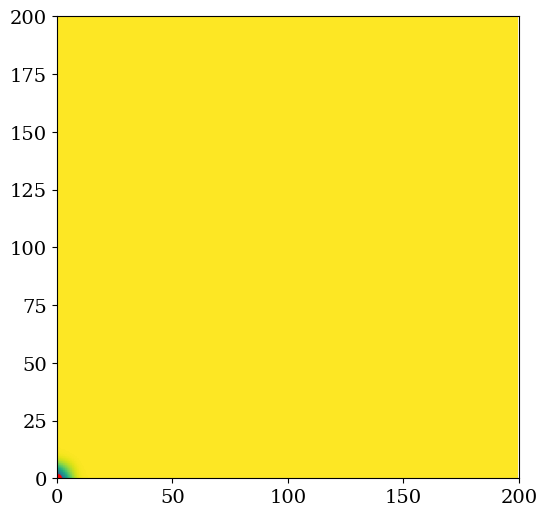

1002


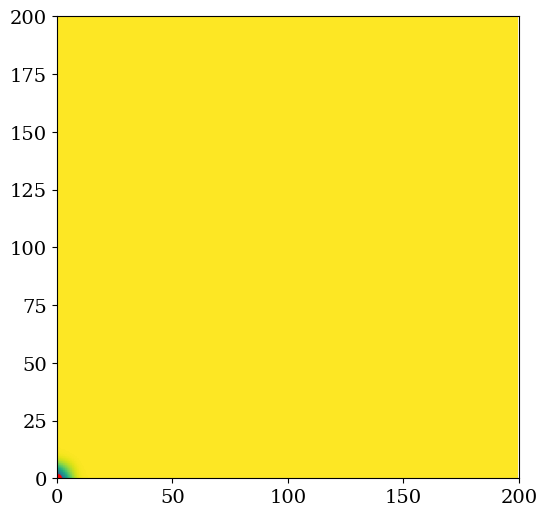

1003


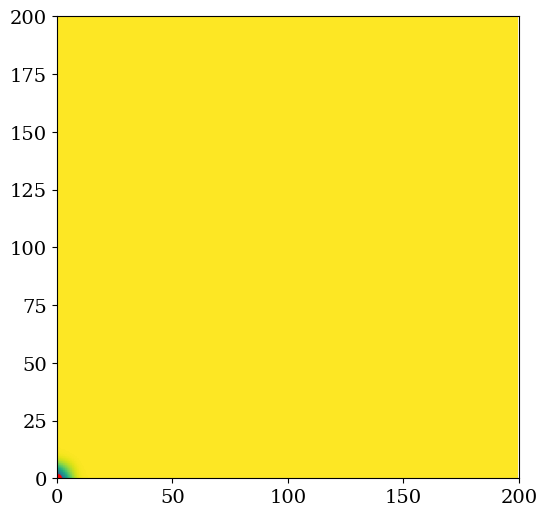

1004


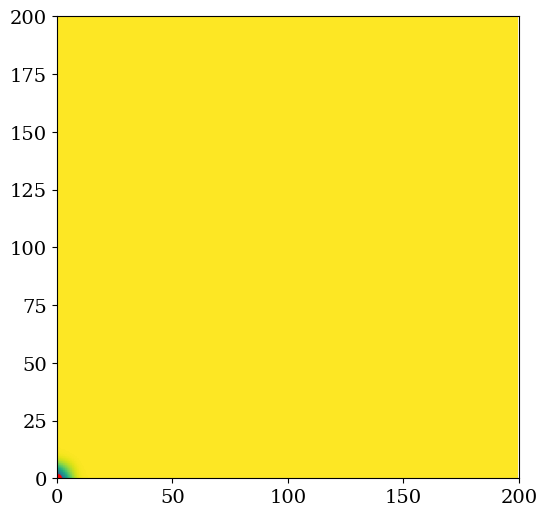

1005


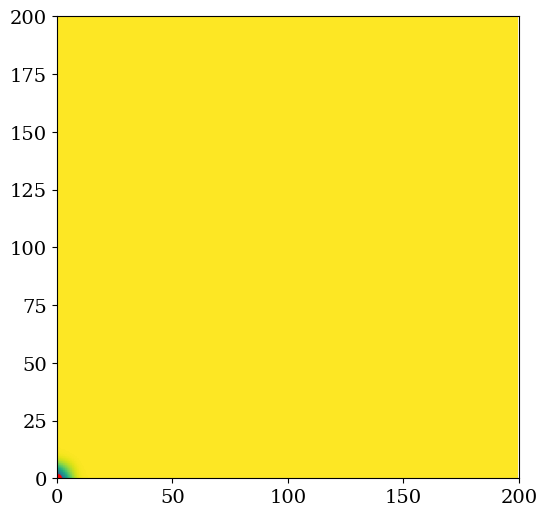

1006


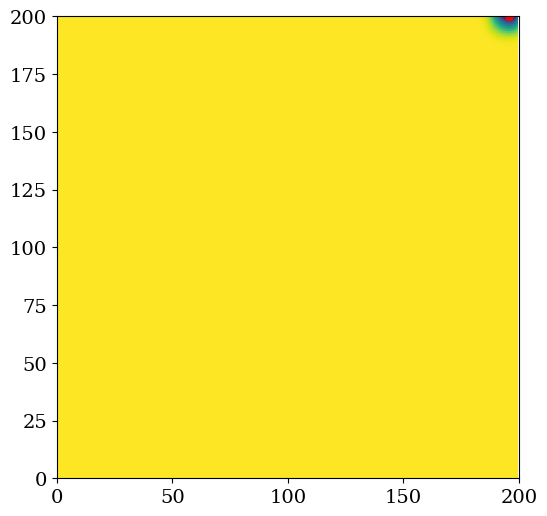

1010


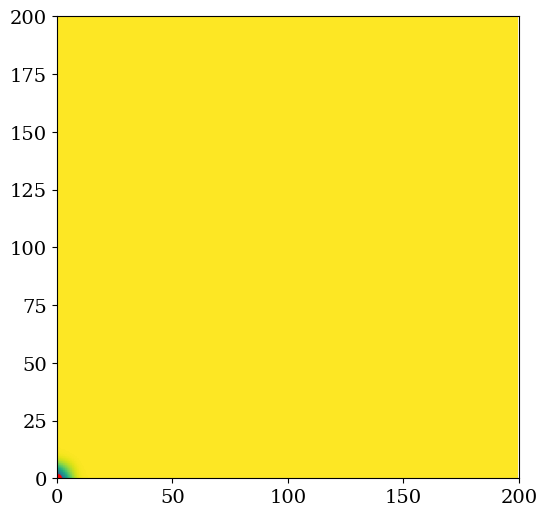

1013


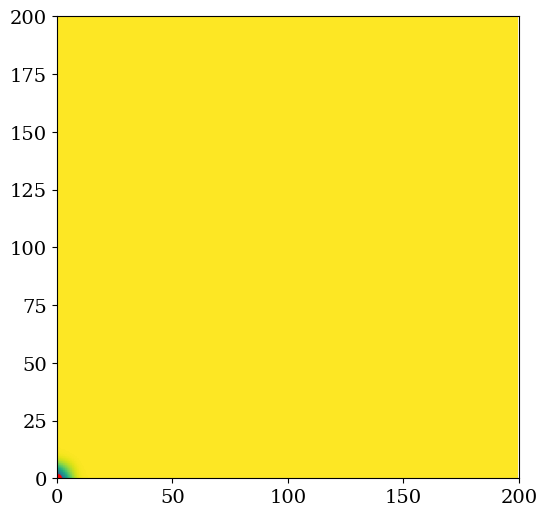

1014


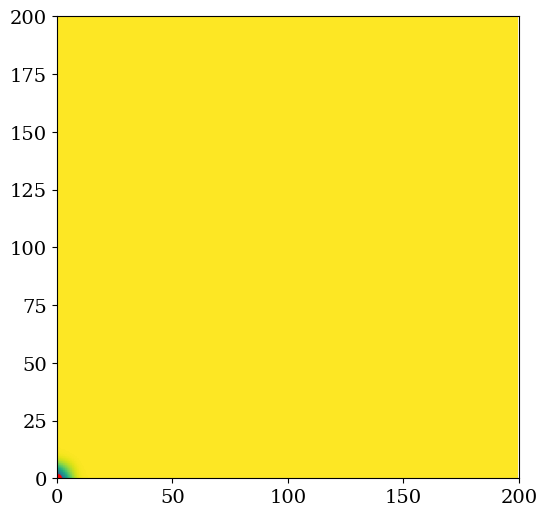

1015


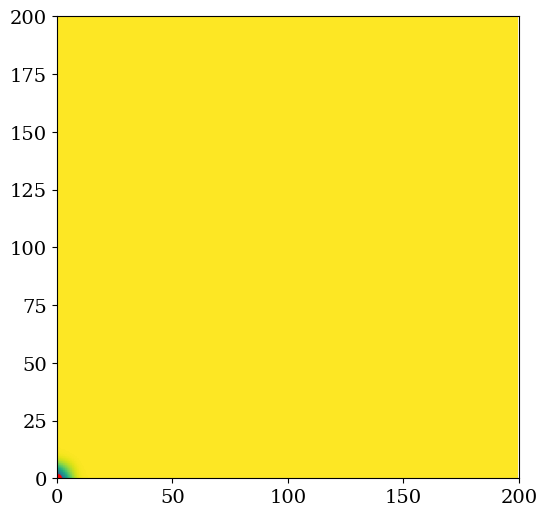

1017


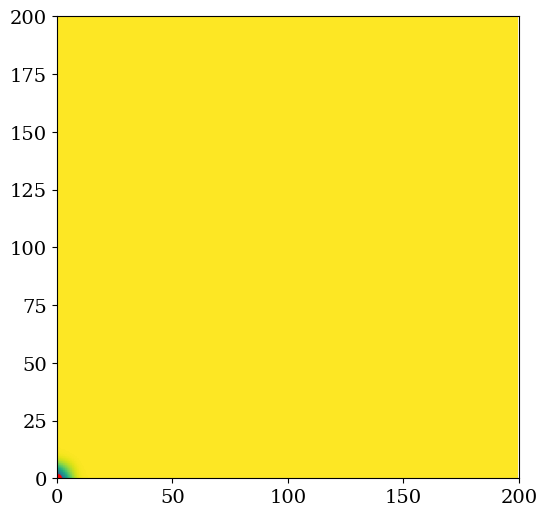

1018


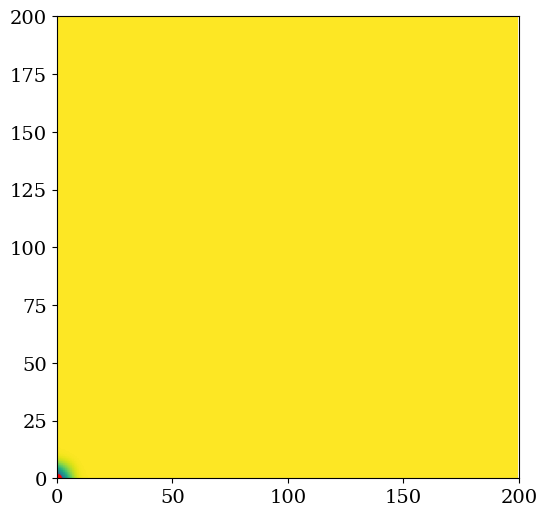

1020


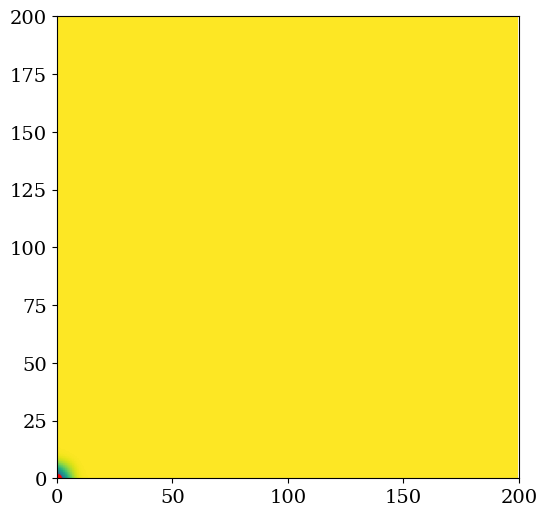

1021


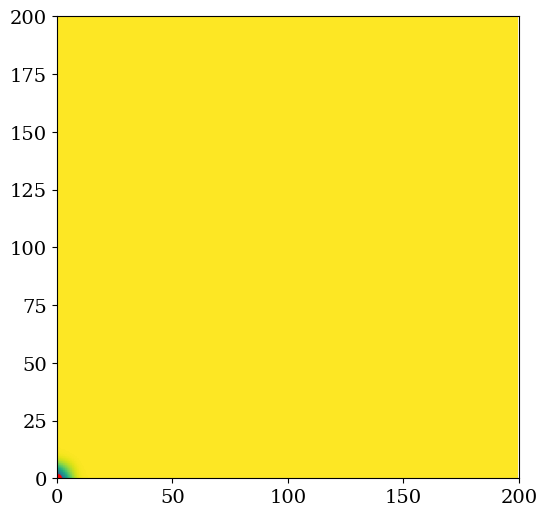

1023


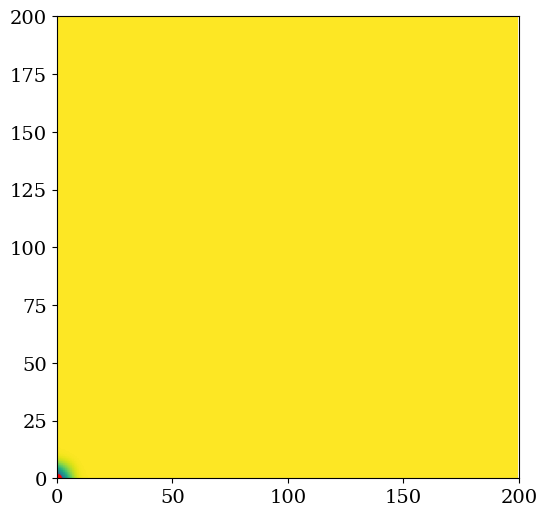

In [245]:
minima_locations = []
for i,m in enumerate(MINIMA):
    if len(m[1]) == 1:
        print(i)
        asdf = np.zeros((200,200))
        func = interpolation_functions[i][1]
        points = m[1]
        zero_zero = False
        # for p in points:
        #     if p[0][0] == 0 and p[0][1] == 0:
        #         zero_zero = True
        # if not zero_zero:
        #     print(points)
        for w in range(200):
            for h in range(200):
                asdf[w][h] = func(w,h)
        plt.imshow(asdf.T, origin="lower")
        plt.scatter(
            [p[0][0] for p in points],
            [p[0][1] for p in points], 
            color="red", s=30
        )
        plt.xlim(0,200)
        plt.ylim(0,200)
        plt.show()

/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/mz/n_rzzjx149d19ncnxglpf7n40000gn/T/ipykernel_11720/1036540595.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  asdf[w][h] = func(w,h)
/var/folders/

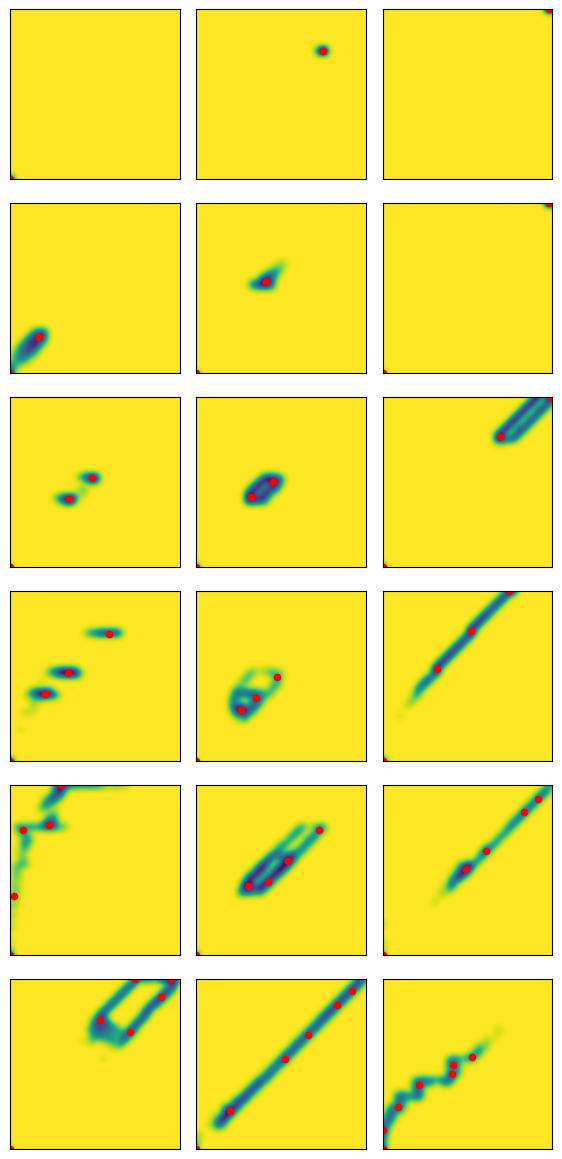

In [246]:
fig, axs = plt.subplots(6, 3, figsize=(7,15))

# 1 minimum
indices = [3, 106, 431]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[0][i].imshow(asdf.T, origin="lower")
    axs[0][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[0][i].set_xlim(0,200)
    axs[0][i].set_ylim(0,200)
    axs[0][i].set_xticks([])
    axs[0][i].set_yticks([])

# 2 minima
indices = [130, 2, 197]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[1][i].imshow(asdf.T, origin="lower")
    axs[1][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[1][i].set_xlim(0,200)
    axs[1][i].set_ylim(0,200)
    axs[1][i].set_xticks([])
    axs[1][i].set_yticks([])

# 3 minima
indices = [512, 387, 757]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[2][i].imshow(asdf.T, origin="lower")
    axs[2][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[2][i].set_xlim(0,200)
    axs[2][i].set_ylim(0,200)
    axs[2][i].set_xticks([])
    axs[2][i].set_yticks([])

# 4 minima
indices = [417, 314, 880]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[3][i].imshow(asdf.T, origin="lower")
    axs[3][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[3][i].set_xlim(0,200)
    axs[3][i].set_ylim(0,200)
    axs[3][i].set_xticks([])
    axs[3][i].set_yticks([])

# 5 minima
indices = [15, 533, 567]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[4][i].imshow(asdf.T, origin="lower")
    axs[4][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[4][i].set_xlim(0,200)
    axs[4][i].set_ylim(0,200)
    axs[4][i].set_xticks([])
    axs[4][i].set_yticks([])

# 6, 7 minima
indices = [253, 896, 54]
for i,idx in enumerate(indices):
    func = interpolation_functions[idx][1]
    points = MINIMA[idx][1]
    asdf = np.zeros((200,200))
    for w in range(200):
        for h in range(200):
            asdf[w][h] = func(w,h)
    axs[5][i].imshow(asdf.T, origin="lower")
    axs[5][i].scatter(
        [p[0][0] for p in points],
        [p[0][1] for p in points],
        color="red",
        s=20
    )
    axs[5][i].set_xlim(0,200)
    axs[5][i].set_ylim(0,200)
    axs[5][i].set_xticks([])
    axs[5][i].set_yticks([])

fig.subplots_adjust(hspace=0.05, wspace=0.1)
plt.savefig("minima_zoo.pdf", bbox_inches="tight")
plt.show()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

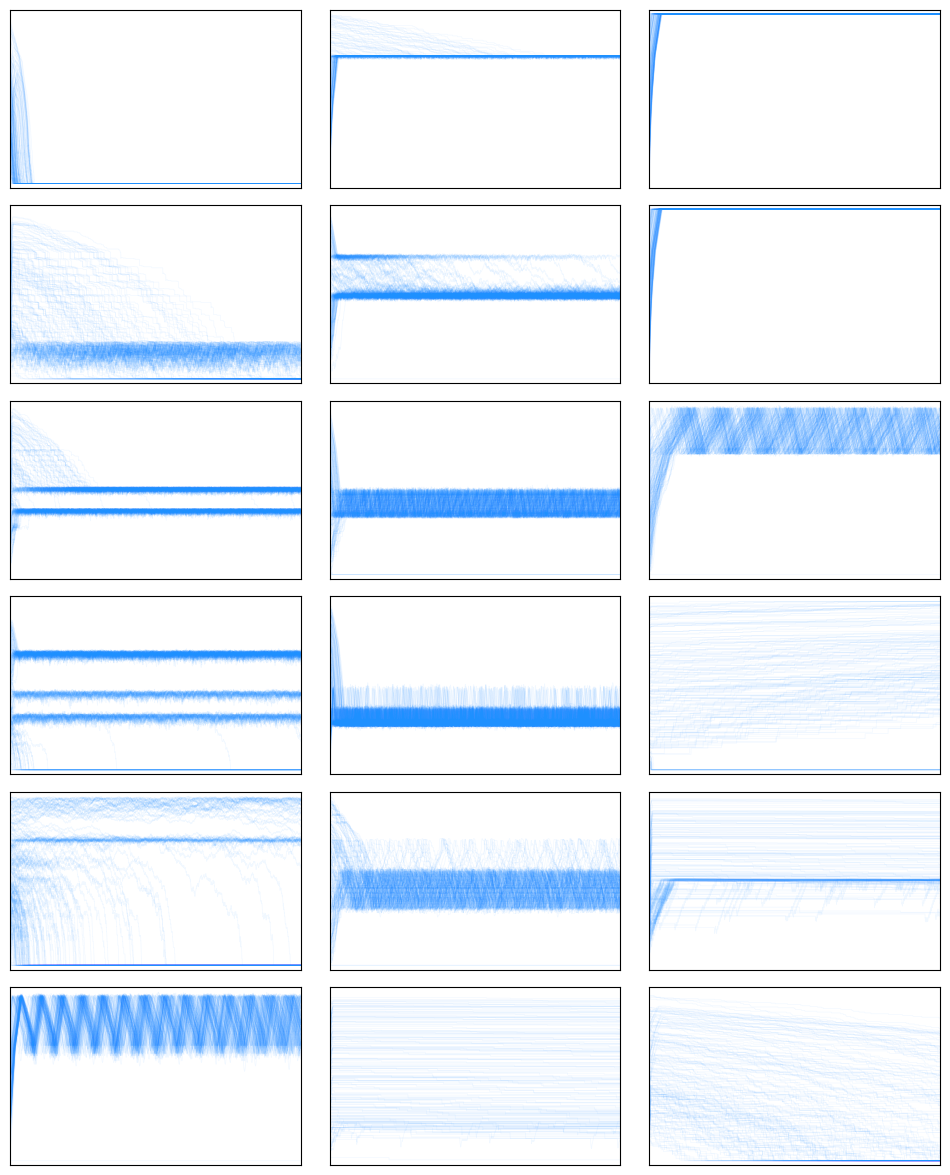

In [29]:
filenames = os.listdir(result_dir)

fig, axs = plt.subplots(6, 3, figsize=(12,15))

num_agents = 200
max_T = 3000
alpha = 0.06

# 1
indices = [3, 106, 431]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[0][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 2
indices = [130, 2, 197]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[1][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 3
indices = [512, 387, 757]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[2][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")
    
# 4
indices = [417, 314, 880]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[3][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 5
indices = [15, 533, 567]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[4][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

# 6, 7
indices = [253, 896, 54]
for i, idx in tqdm(enumerate(indices)):
    file = filenames[idx]
    with open(os.path.join(result_dir, file), "rb") as f:
        res = pickle.load(f)
    util = utility(res["wealth"], res["health"], alpha=res['params']['alpha'])[:num_agents,:max_T]
    axs[5][i].plot(util.T, linewidth=0.5, alpha=alpha, color="dodgerblue")

for i in range(6):
    for j in range(3):
        axs[i][j].set_xlim(0,2500)
        axs[i][j].set_ylim(-4,204)
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig("trajectories_zoo.png", bbox_inches="tight")
plt.show()

### Investigate final state space outcome as function of initial state

In [45]:
init_w = []
init_h = []

result_dir = "results_" + result_suffix
for f in tqdm(os.listdir(result_dir)):
    with open(os.path.join(result_dir, f), "rb") as f:
        res = pickle.load(f)
    wealth = res["wealth"]
    health = res["health"]
    condition = (wealth[:,-1] <=5) & (health[:,-1] <=5)
    init_w.append(wealth[condition,0])
    init_h.append(health[condition,0])

init_w = np.concatenate(init_w)
init_h = np.concatenate(init_h)

  0%|          | 0/1024 [00:00<?, ?it/s]

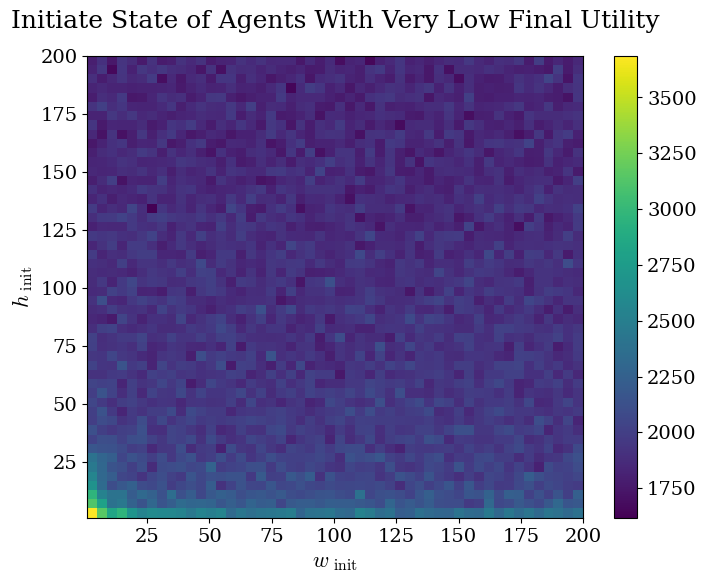

In [46]:
fig, ax = plt.subplots()
h = ax.hist2d(init_w, init_h, bins=50)
fig.colorbar(h[3], ax=ax)
plt.xlabel(r"$w_{\text{ init}}$")
plt.ylabel(r"$h_{\text{ init}}$")
plt.title("Initiate State of Agents With Very Low Final Utility", pad=20)
plt.show()